In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import pandas_profiling
import numpy as np
import imageio
from tqdm import tqdm_notebook as tqdm
import multiprocessing

In [2]:
TEST_VIDEO = '../../data/train/test.mp4'

In [125]:
def get_total_len(path, frame_rate=1, size=None, skip=0):
    n = imageio.get_reader(path).get_meta_data()['nframes']
    result = int((1 - skip) * n / frame_rate)
    if size is not None:
        result = min(result, size)
    return result

In [126]:
def get_reader(path, frame_rate=1, size=None, skip=0):
    total=0
    n = get_total_len(path)
    for i, frame in enumerate(imageio.get_reader(path).iter_data()):
        if skip is not None and i < skip * n:
            continue
        if i % frame_rate == 0:
            total += 1
            yield frame
        if size is not None and total == size:
            break

In [177]:
def show_img(img, k=1):
    fig, ax = plt.subplots(figsize=(int(18*k), int(20*k)))
    ax.imshow(img, interpolation='nearest')

In [180]:
def show_first(reader):
    img = next(reader)
    show_img(img)

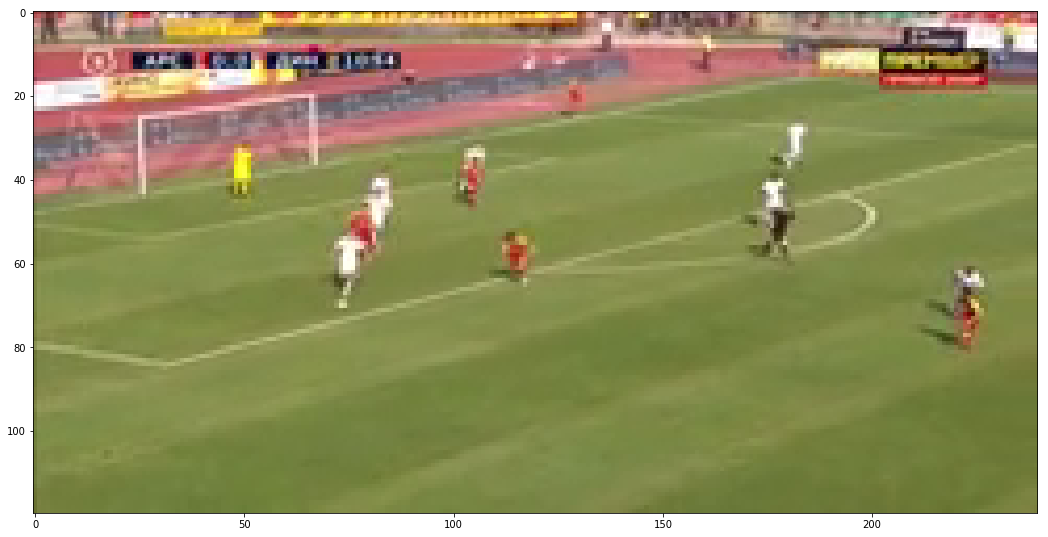

In [181]:
show_first(get_reader(TEST_VIDEO, FRAME_RATE, skip=SKIP, size=SIZE))

### Подход 1

In [184]:
SHAPE_VIDEO = next(get_reader(TEST_VIDEO)).shape
FRAME_RATE = 100
SKIP = 0.1
SIZE = None
GOOD_COLORS = [0, 1, 2]

In [199]:
colors = np.zeros(SHAPE_VIDEO + (256,))
colors.shape
for frame in tqdm(get_reader(TEST_VIDEO, FRAME_RATE, skip=SKIP, size=SIZE),
                  total=get_total_len(TEST_VIDEO, FRAME_RATE, skip=SKIP, size=SIZE)):
    frame = frame # // 6
    for i in range(colors.shape[0]):
        for j in range(colors.shape[1]):
            for k in GOOD_COLORS:
                colors[i, j, k, frame[i, j, k]] += 1

A Jupyter Widget

KeyboardInterrupt: 

In [202]:
def get_static_mask(pixels_colors, threshold=0.85, top_color=5):
    frames_count = pixels_colors[0, 0, 0].sum()
    mask = np.zeros(pixels_colors.shape[:2])
    for i in range(colors.shape[0]):
        for j in range(colors.shape[1]):
            for k in GOOD_COLORS:
                color = pixels_colors[i, j, k] / frames_count
                ind = np.argsort(-color)[:top_color]
                diff = ind.max() - ind.min()
                max_sum = color[ind].sum()
                if max_sum > threshold:
                    mask[i, j] = 1
    return mask

0.3 1


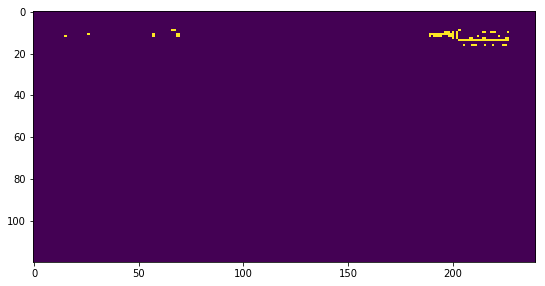

0.3 5


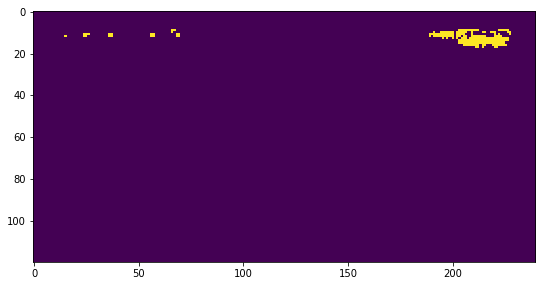

0.3 9


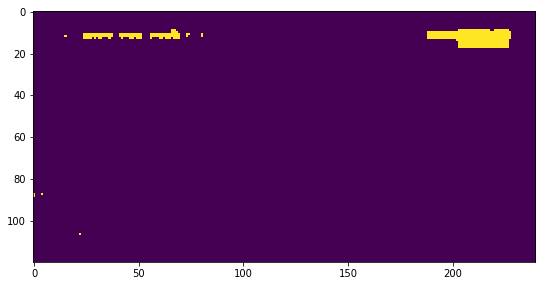

0.3 13


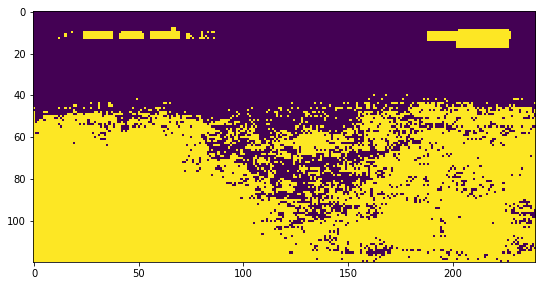

0.5 1


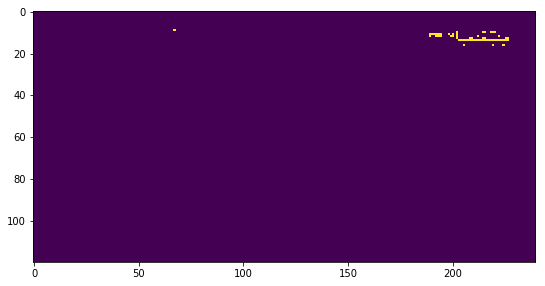

0.5 5


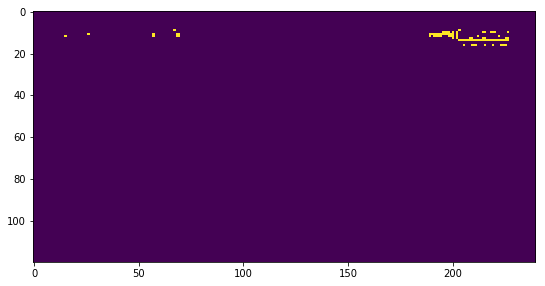

0.5 9


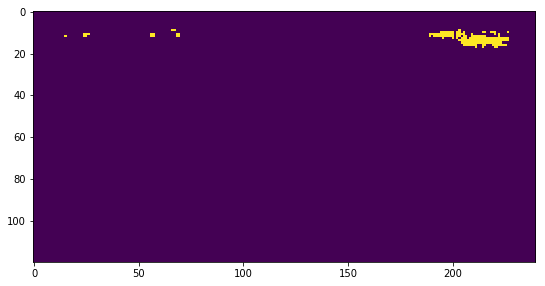

0.5 13


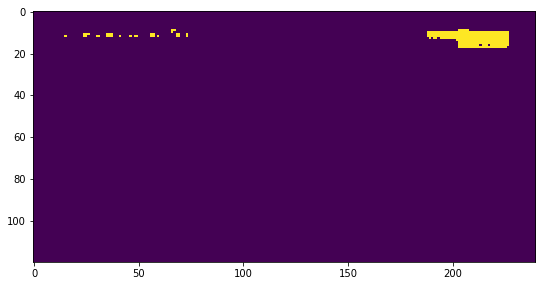

0.5 17


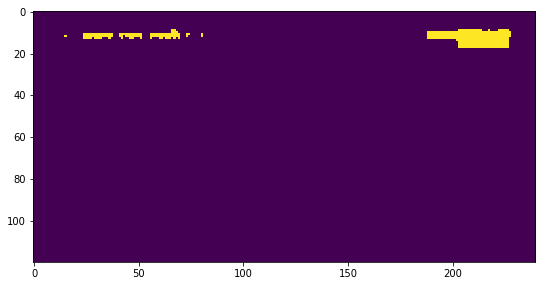

0.5 21


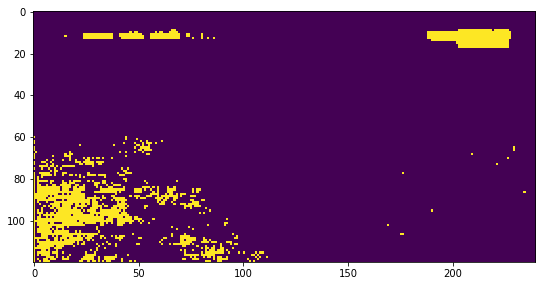

0.5 25


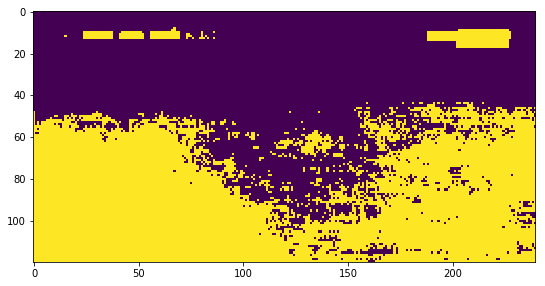

0.7 1


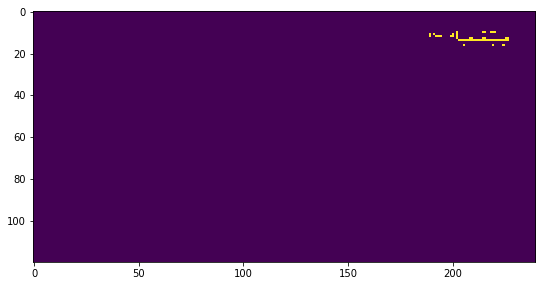

0.7 5


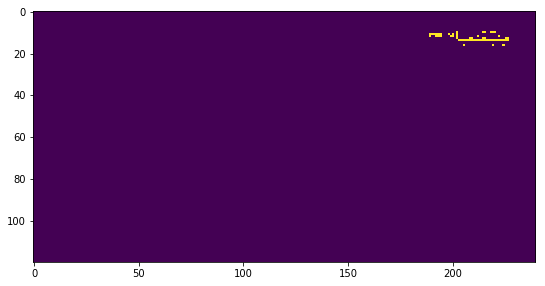

0.7 9


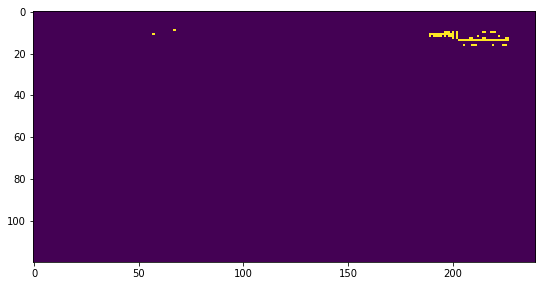

0.7 13


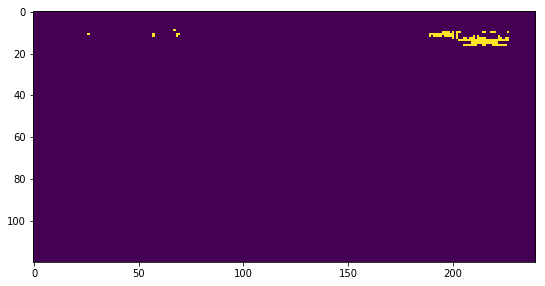

0.7 17


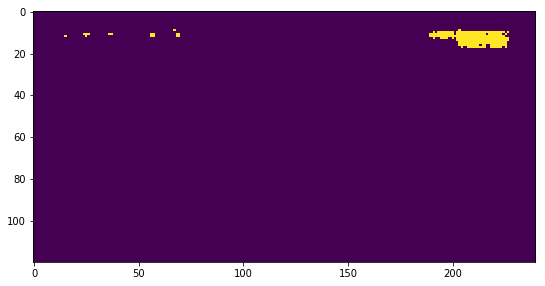

0.7 21


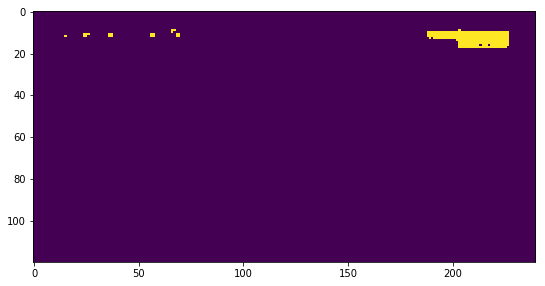

0.7 25


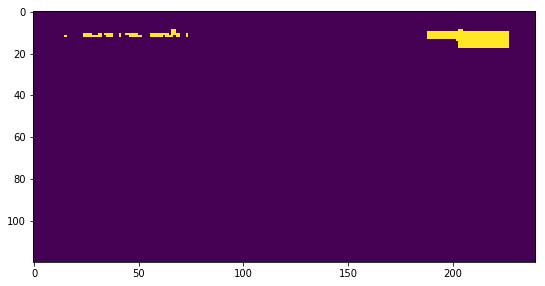

0.7 29


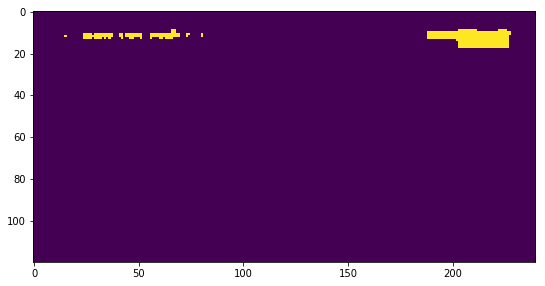

0.7 33


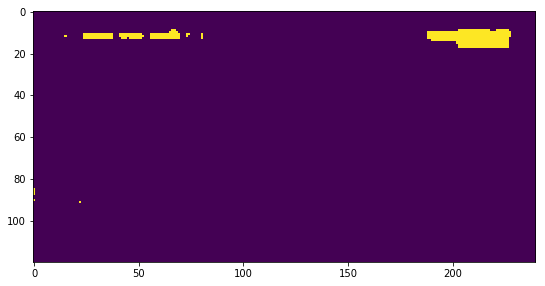

0.7 37


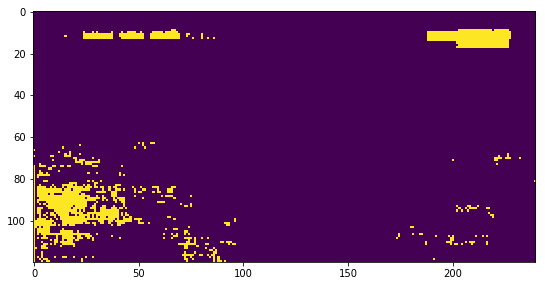

0.7 41


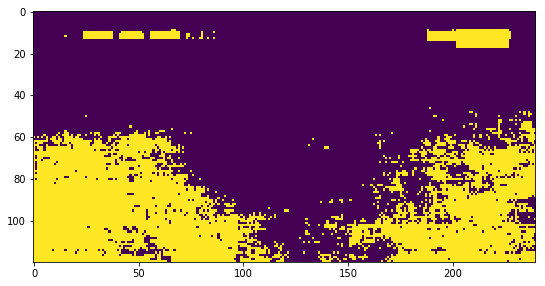

0.7 45


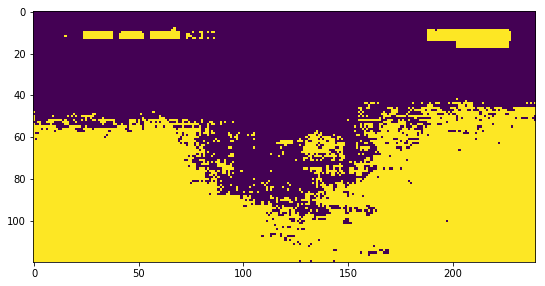

0.9 1


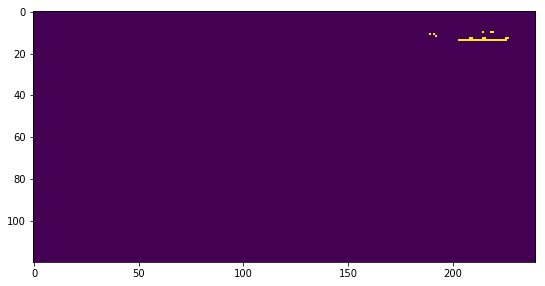

0.9 5


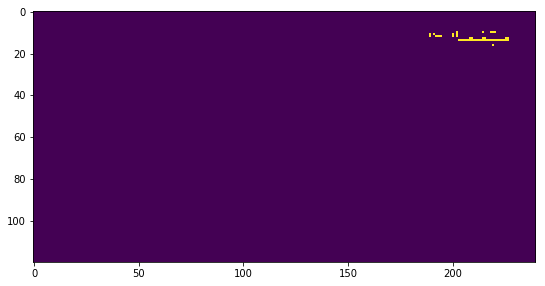

0.9 9


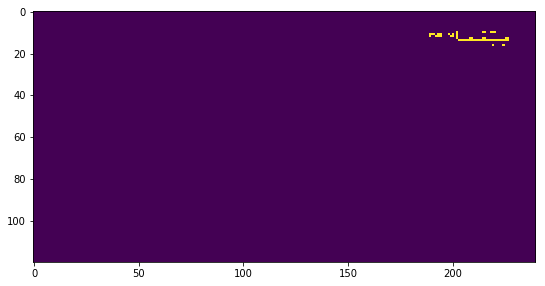

0.9 13


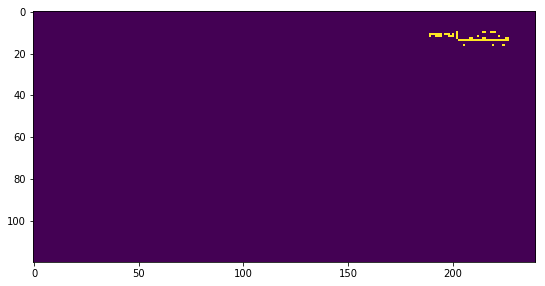

0.9 17


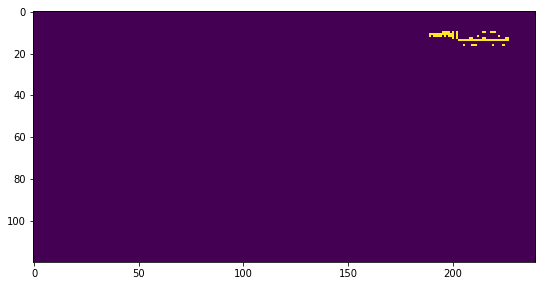

0.9 21


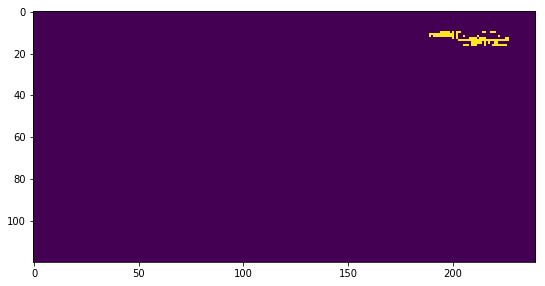

0.9 25


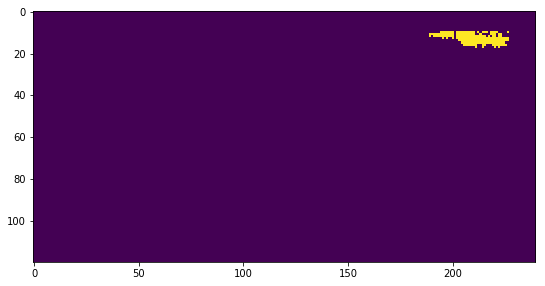

0.9 29


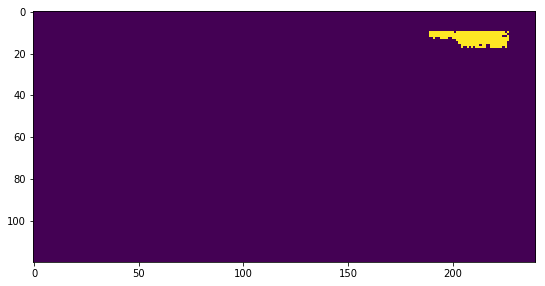

0.9 33


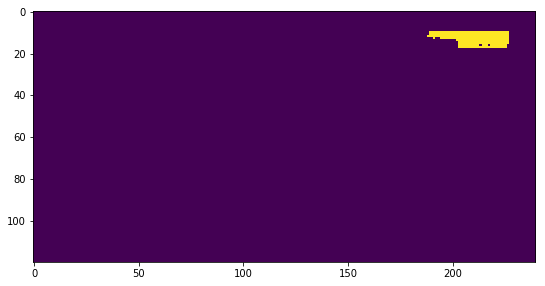

0.9 37


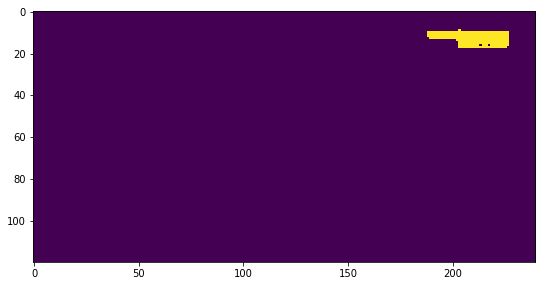

0.9 41


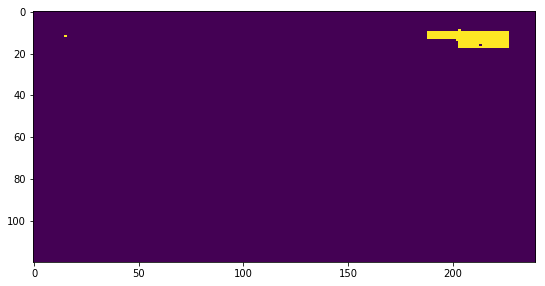

0.9 45


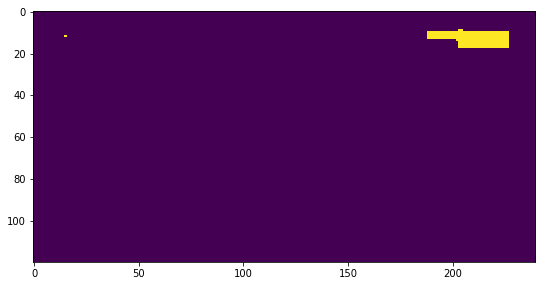

0.9 49


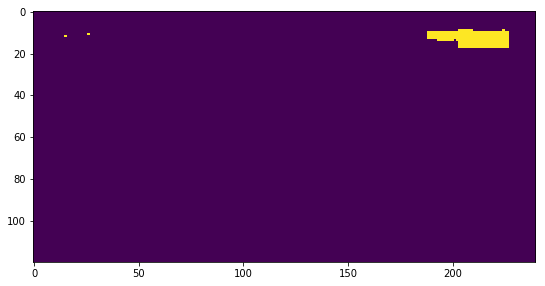

0.9 53


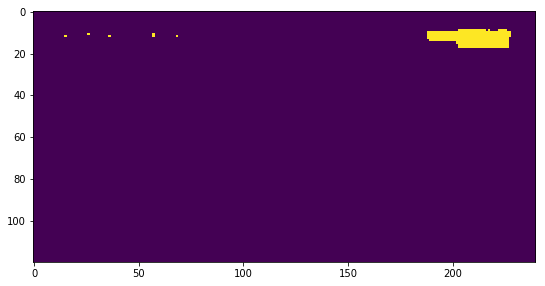

0.9 57


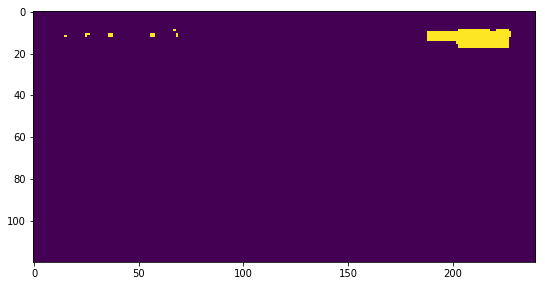

0.9 61


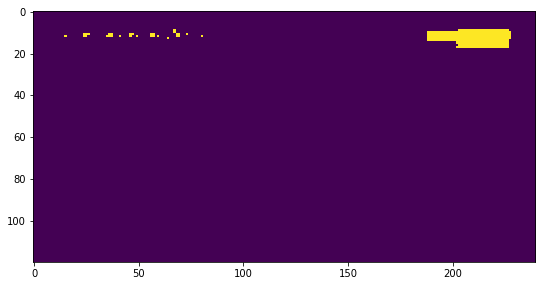

0.9 65


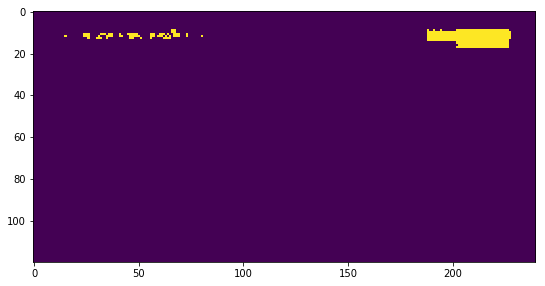

0.9 69


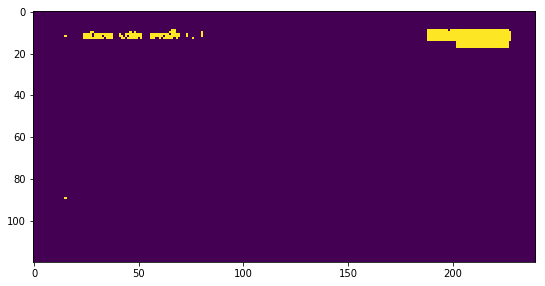

0.9 73


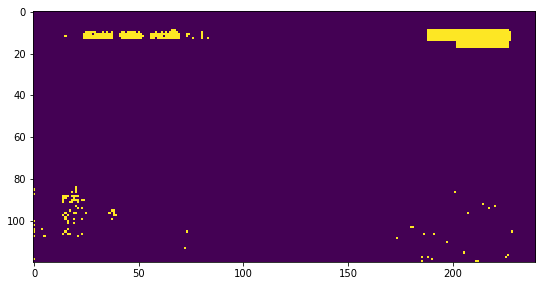

0.9 77


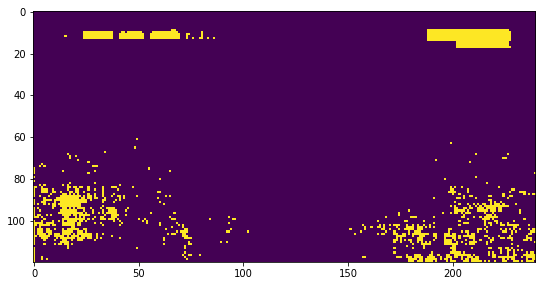

0.9 81


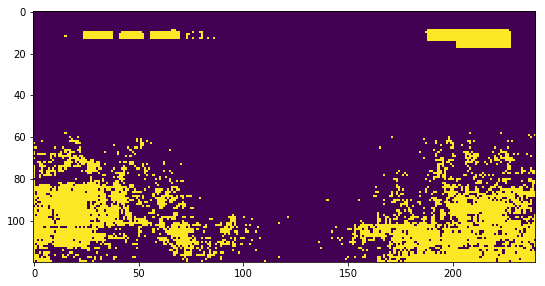

0.9 85


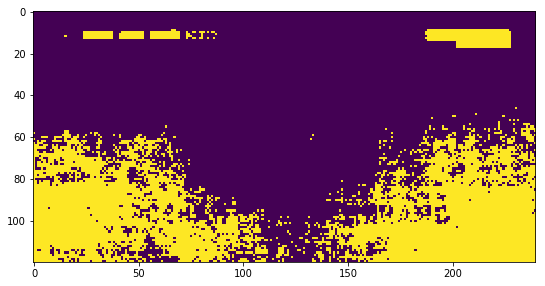

0.9 89


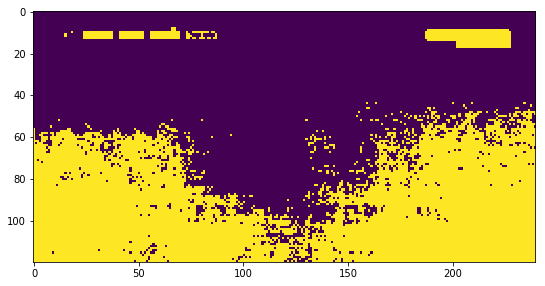

In [207]:
for th in [0.3, 0.5, 0.7, 0.9]:
    for tp in range(1, 400, 4):
        print(th, tp)
        ui_mask = get_static_mask(colors, threshold=th, top_color=tp)
        m = ui_mask.mean()
        show_img(ui_mask, k=0.5)
        plt.show()
        if m > 0.3:
            break;

### Подход 2

In [226]:
SHAPE_VIDEO = next(get_reader(TEST_VIDEO)).shape
FRAME_RATE = 9
SKIP = 0.1
SIZE = 1000
GOOD_COLORS = [0, 1, 2]

In [233]:
count_same = np.zeros(SHAPE_VIDEO[:2])
total = 0
last = None
for frame in tqdm(get_reader(TEST_VIDEO, FRAME_RATE, skip=SKIP, size=SIZE),
                  total=get_total_len(TEST_VIDEO, FRAME_RATE, skip=SKIP, size=SIZE)):
    frame = frame.astype('float')
    if last is not None:
        for i in range(colors.shape[0]):
            for j in range(colors.shape[1]):
                diff = last[i, j] - frame[i, j]
                if np.abs(diff).sum() <= 10:
                    count_same[i, j] += 1
    total += 1
    last = frame

A Jupyter Widget

KeyboardInterrupt: 

In [234]:
count_same

array([[  19.,   22.,   22., ...,   20.,   19.,   22.],
       [  16.,   15.,   19., ...,   30.,   24.,   24.],
       [  22.,   16.,   22., ...,   35.,   29.,   31.],
       ..., 
       [  98.,  111.,  112., ...,  119.,  113.,  107.],
       [ 117.,  116.,  113., ...,  118.,  109.,  108.],
       [ 124.,  120.,  124., ...,  112.,  112.,  108.]])

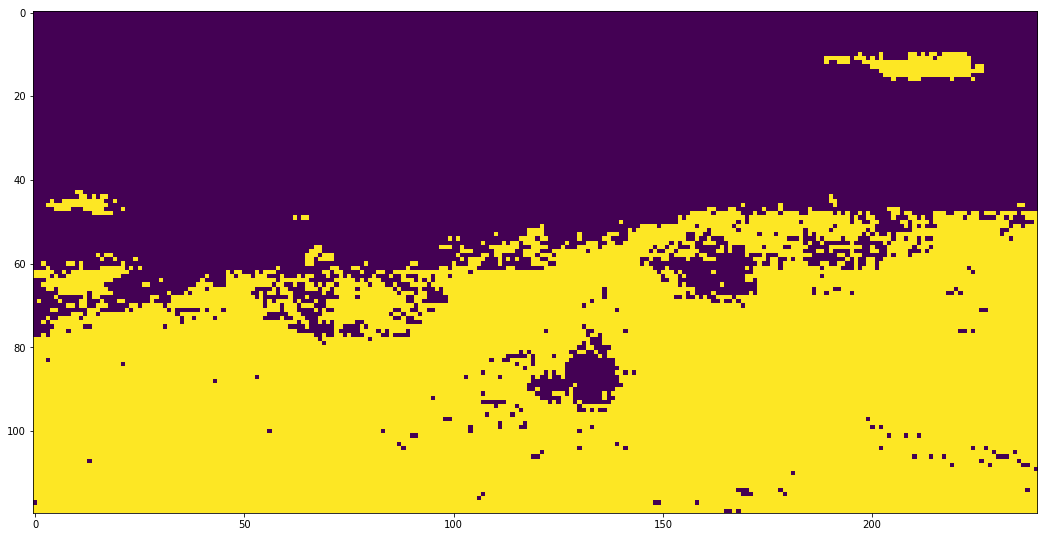

In [236]:
show_img(count_same > 100)

### Подход 3 (ищим зелень)

In [321]:
SHAPE_VIDEO = next(get_reader(TEST_VIDEO)).shape
FRAME_RATE = 30
SKIP = 0.1
SIZE = 1000
GOOD_COLORS = [0, 1, 2]
DIV_K = 1

In [324]:
colors = np.zeros(SHAPE_VIDEO + (256 // DIV_K,))
green_win = np.zeros(SHAPE_VIDEO[:2])
total = 0
for frame in tqdm(get_reader(TEST_VIDEO, FRAME_RATE, skip=SKIP, size=SIZE),
                  total=get_total_len(TEST_VIDEO, FRAME_RATE, skip=SKIP, size=SIZE)):
    frame = frame // DIV_K
    for i in range(colors.shape[0]):
        for j in range(colors.shape[1]):
            for k in GOOD_COLORS:
                colors[i, j, k, frame[i, j, k]] += 1
    green_win += frame[:, :, 1] * 2 > frame[:, :, 0] + frame[:, :, 2]
    total += 1

A Jupyter Widget

In [368]:
green_win = np.zeros(SHAPE_VIDEO[:2])
for frame in tqdm(get_reader(TEST_VIDEO, FRAME_RATE, skip=SKIP, size=SIZE),
                  total=get_total_len(TEST_VIDEO, FRAME_RATE, skip=SKIP, size=SIZE)):
    frame = (frame // DIV_K).astype('float')
    green_win += (frame[:, :, 1] * 2 > frame[:, :, 0] + frame[:, :, 2])

A Jupyter Widget

In [369]:
green_win /= total

In [370]:
green_win

array([[ 0.278,  0.279,  0.27 , ...,  0.288,  0.294,  0.294],
       [ 0.279,  0.282,  0.271, ...,  0.29 ,  0.294,  0.294],
       [ 0.281,  0.282,  0.283, ...,  0.291,  0.298,  0.298],
       ..., 
       [ 0.81 ,  0.81 ,  0.806, ...,  0.825,  0.826,  0.826],
       [ 0.799,  0.8  ,  0.802, ...,  0.82 ,  0.826,  0.825],
       [ 0.799,  0.799,  0.801, ...,  0.821,  0.825,  0.825]])

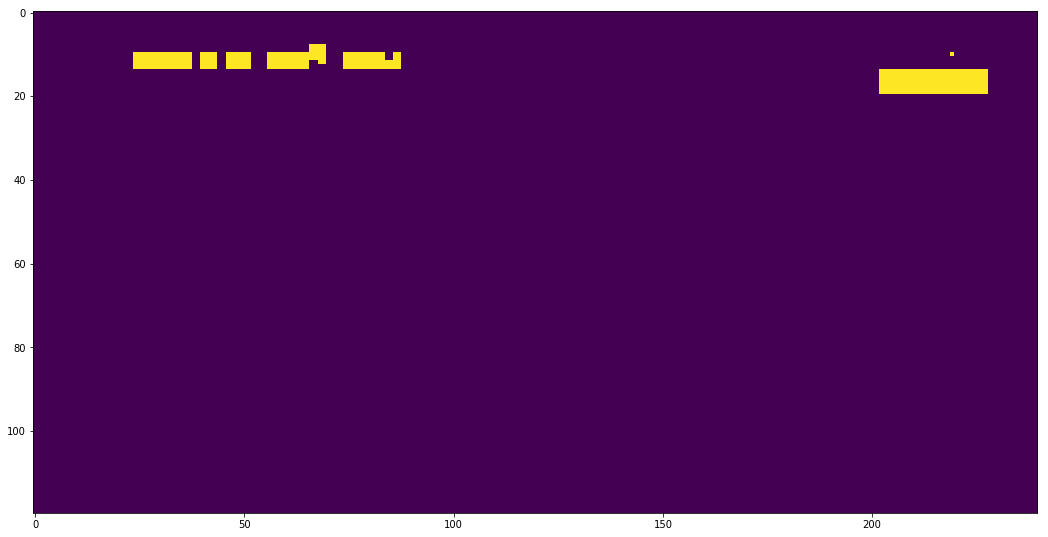

In [377]:
show_img(green_win < 0.2)

In [280]:
def get_static_mask_exclude_green(pixels_colors, green_win, threshold=0.85, max_green=0.18, top_color=5):
    frames_count = pixels_colors[0, 0, 0].sum()
    mask = np.zeros(pixels_colors.shape[:2])
    for i in range(colors.shape[0]):
        for j in range(colors.shape[1]):
            if green_win[i, j] < max_green:
                for k in GOOD_COLORS:
                    color = pixels_colors[i, j, k] / frames_count
                    ind = np.argsort(-color)[:top_color]
                    diff = ind.max() - ind.min()
                    max_sum = color[ind].sum()
                    if max_sum > threshold:
                        mask[i, j] = 1
            
    return mask

0.3 1 0.15


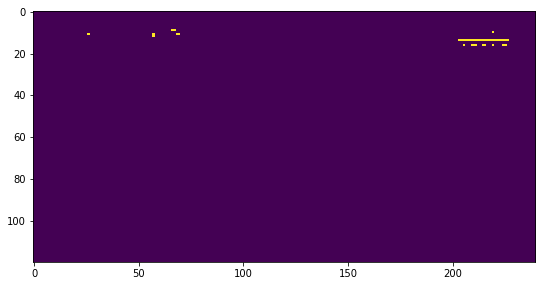

0.3 1 0.18


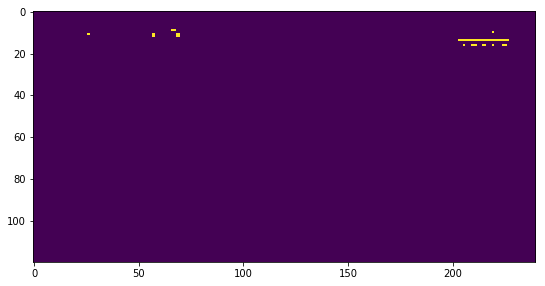

0.3 1 0.2


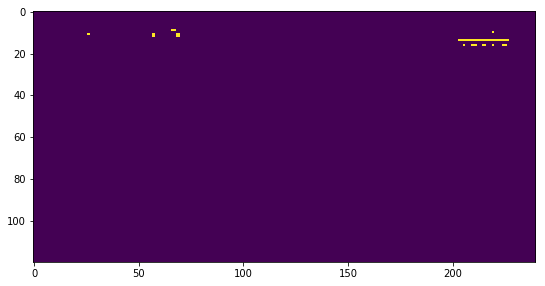

0.3 1 0.25


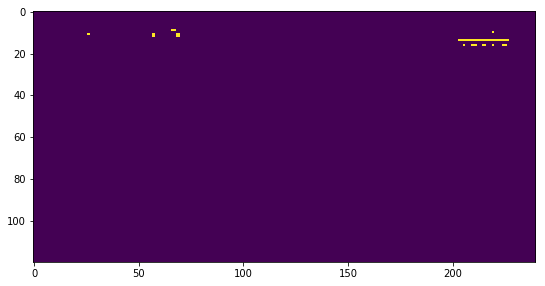

0.3 1 0.3


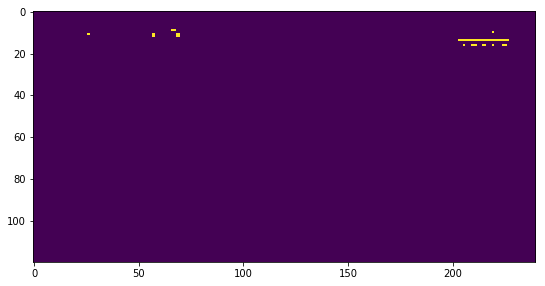

0.3 5 0.15


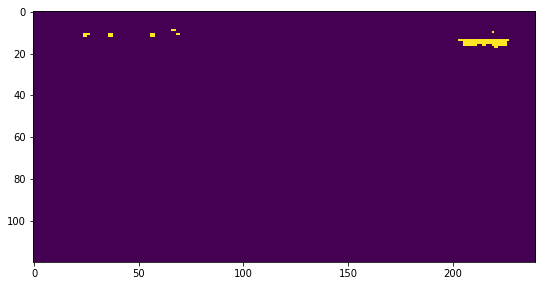

0.3 5 0.18


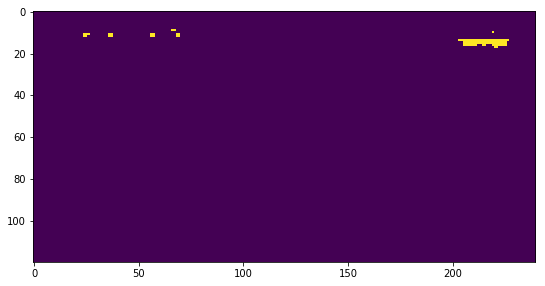

0.3 5 0.2


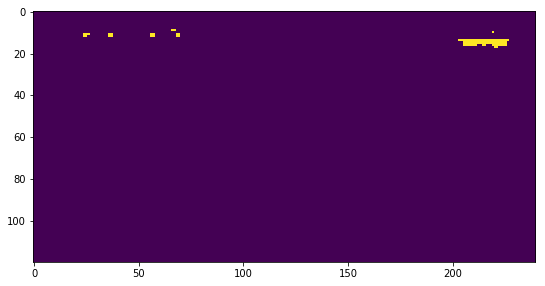

0.3 5 0.25


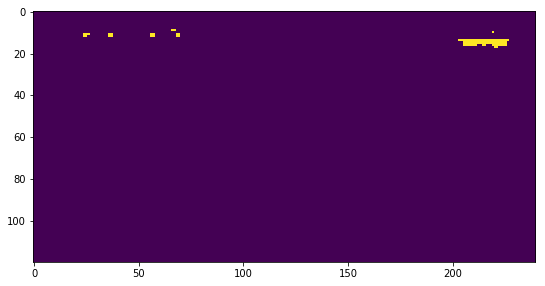

0.3 5 0.3


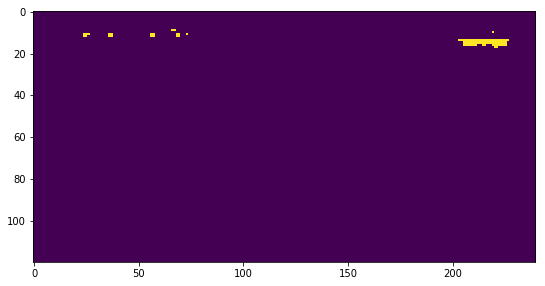

0.3 9 0.15


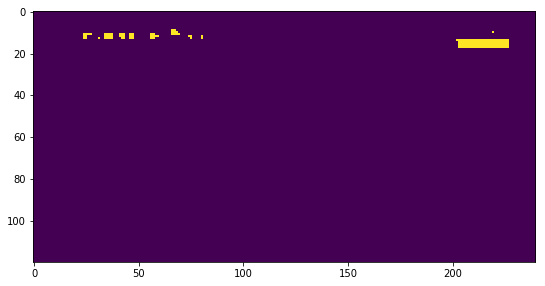

0.3 9 0.18


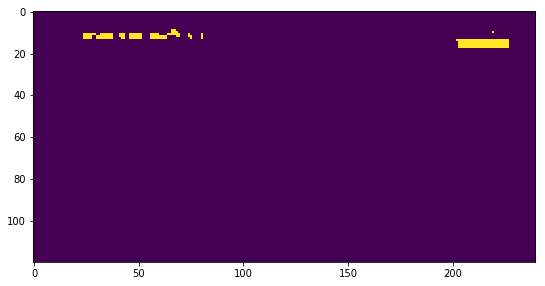

0.3 9 0.2


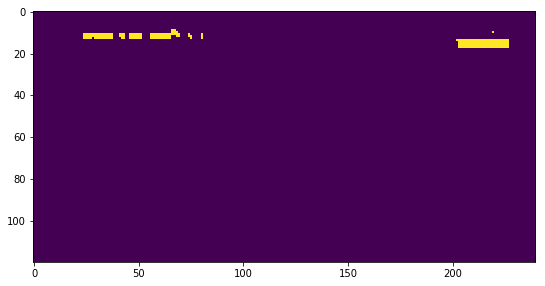

0.3 9 0.25


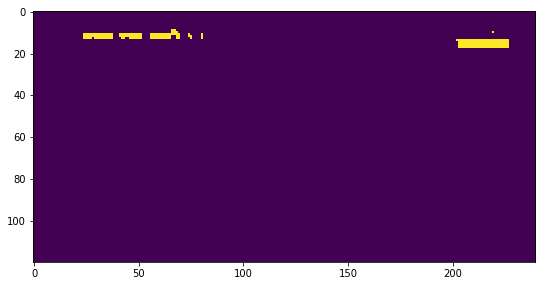

0.3 9 0.3


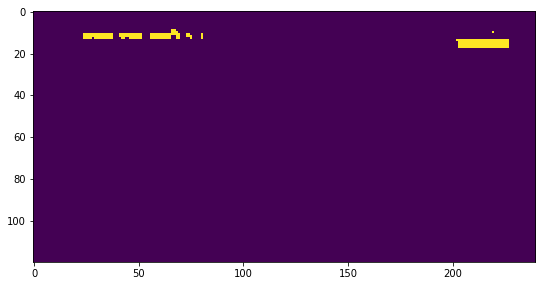

0.3 13 0.15


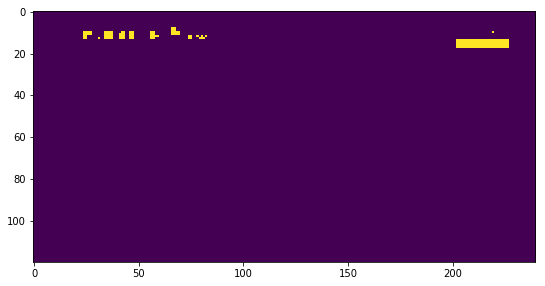

0.3 13 0.18


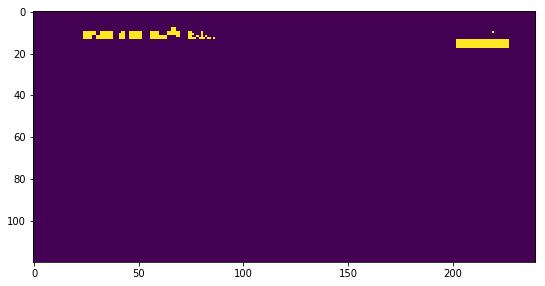

0.3 13 0.2


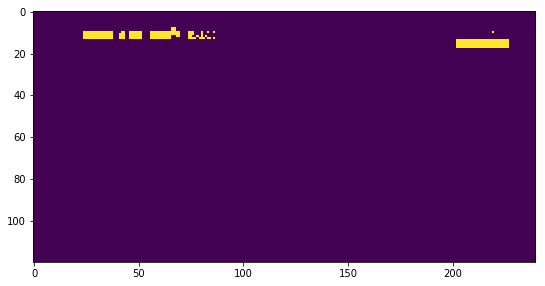

0.3 13 0.25


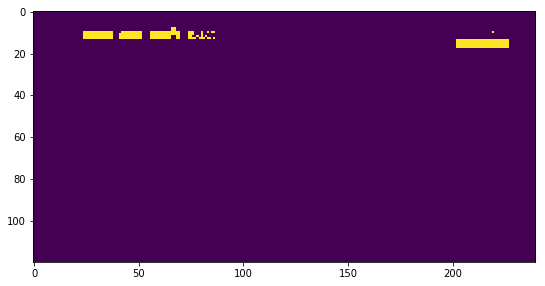

0.3 13 0.3


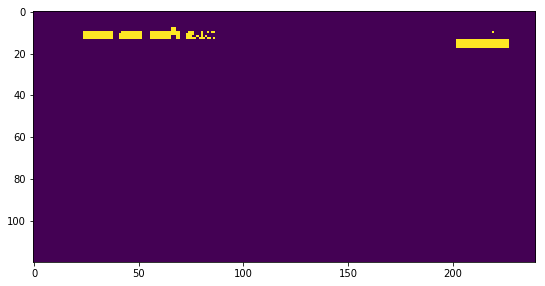

0.3 17 0.15


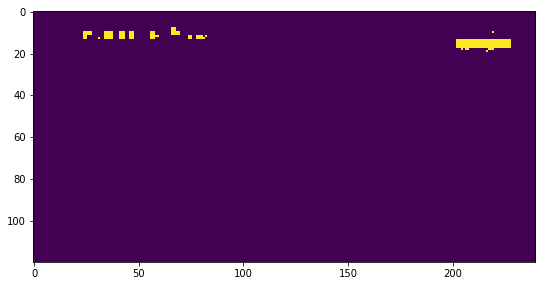

0.3 17 0.18


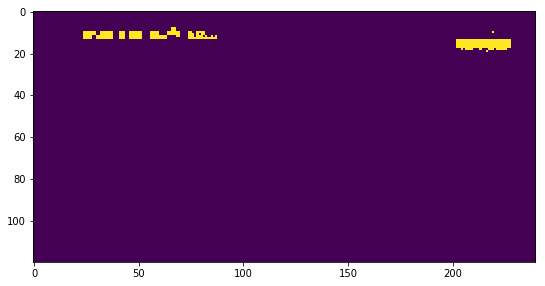

0.3 17 0.2


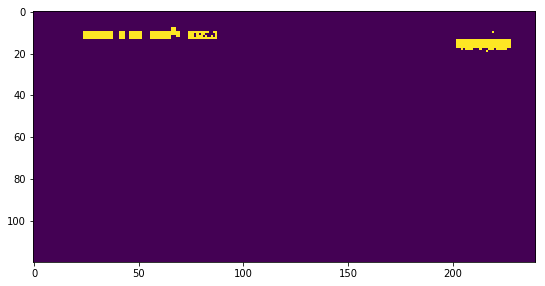

0.3 17 0.25


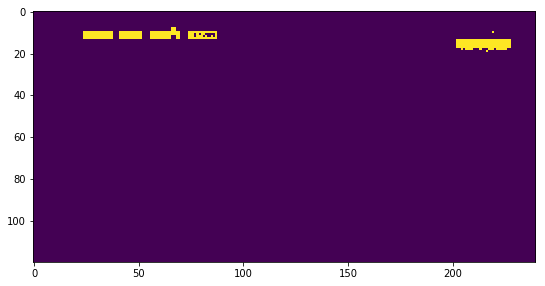

0.3 17 0.3


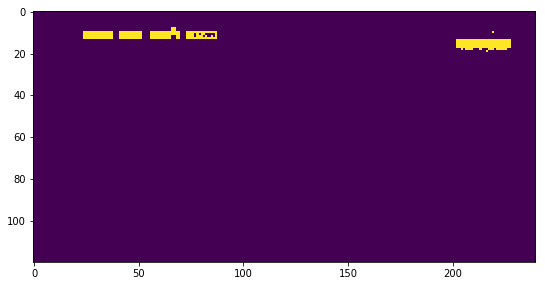

0.3 21 0.15


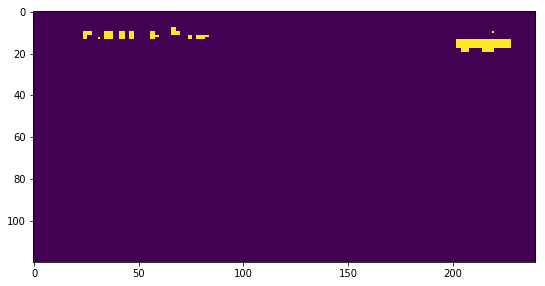

0.3 21 0.18


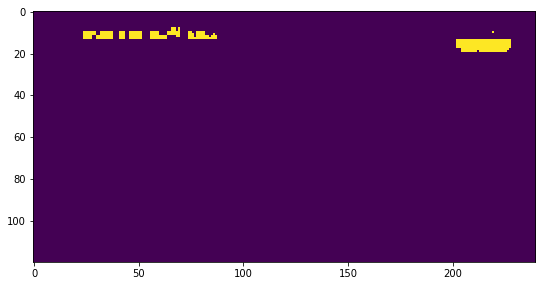

0.3 21 0.2


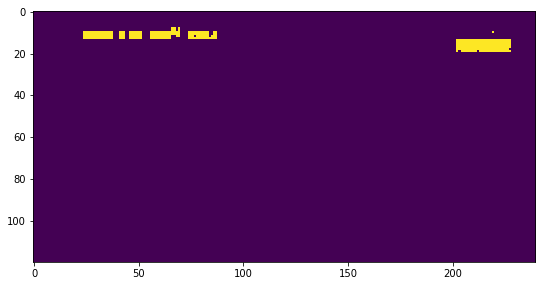

0.3 21 0.25


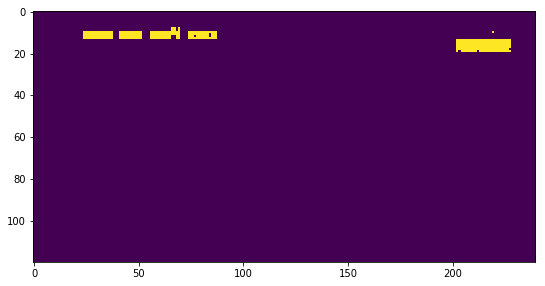

0.3 21 0.3


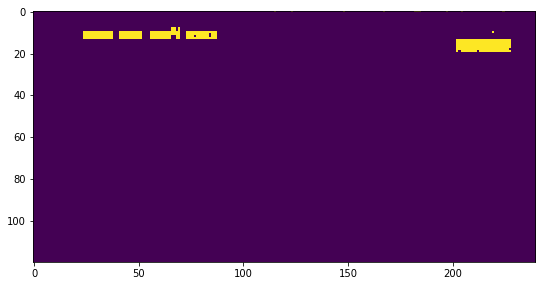

0.3 25 0.15


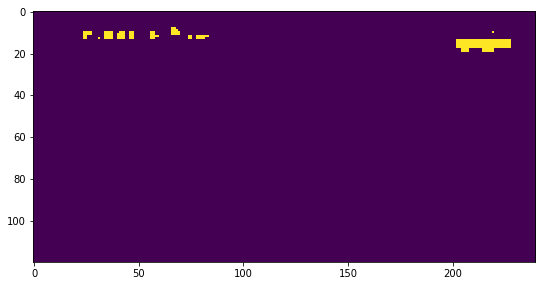

0.3 25 0.18


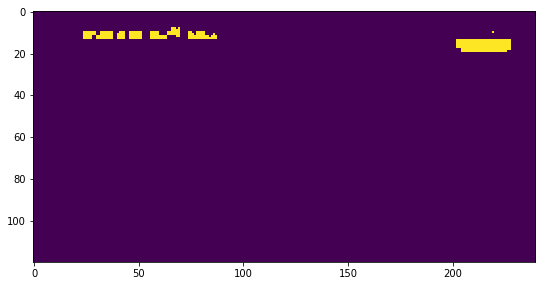

0.3 25 0.2


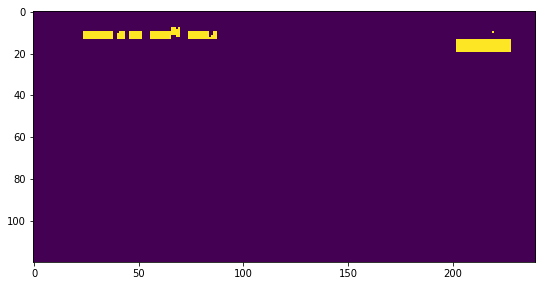

0.3 25 0.25


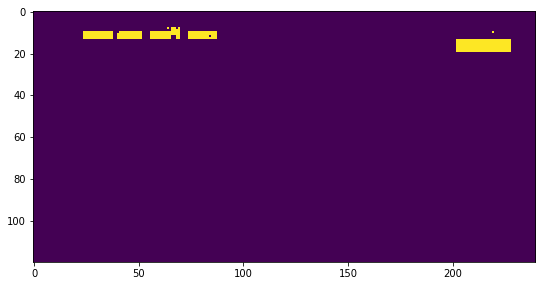

0.3 25 0.3


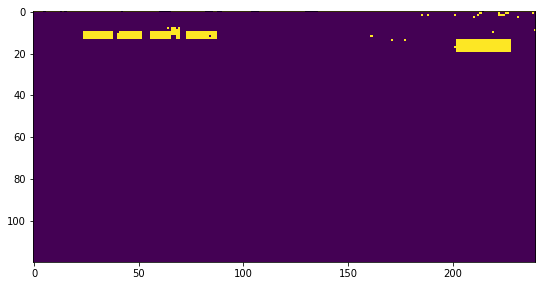

0.3 29 0.15


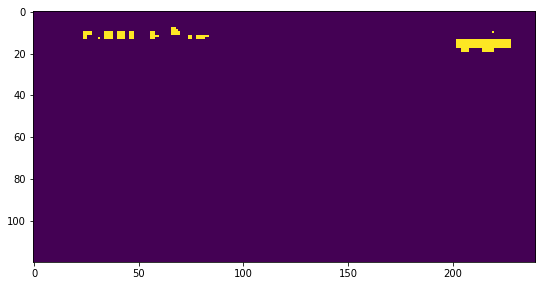

0.3 29 0.18


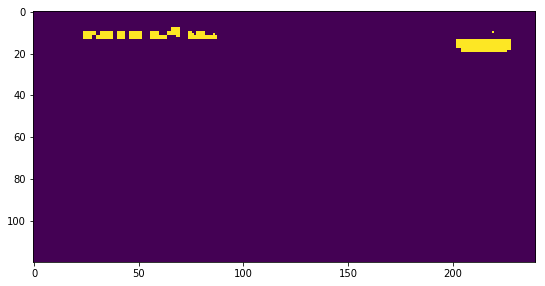

0.3 29 0.2


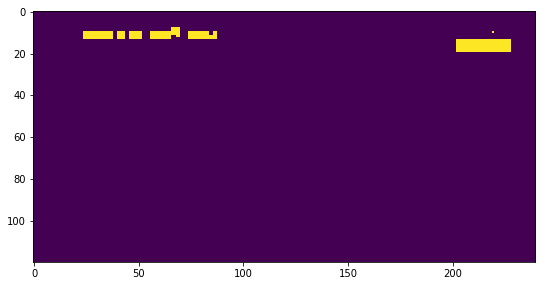

0.3 29 0.25


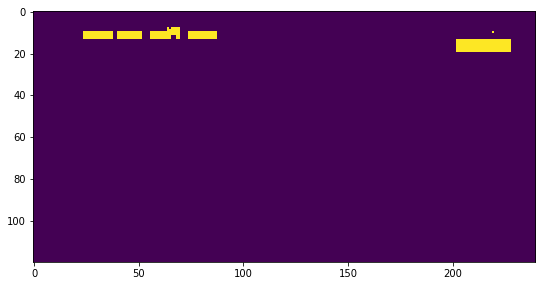

0.3 29 0.3


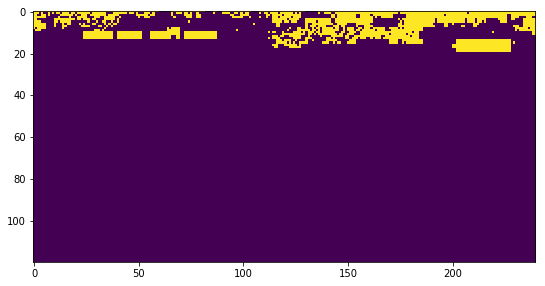

0.3 33 0.15


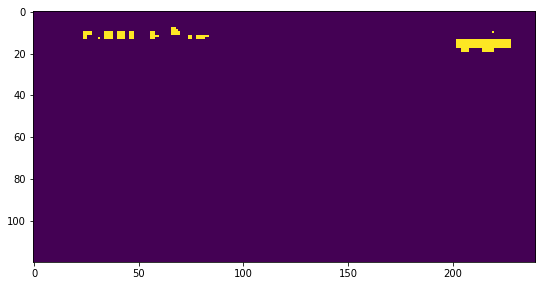

0.3 33 0.18


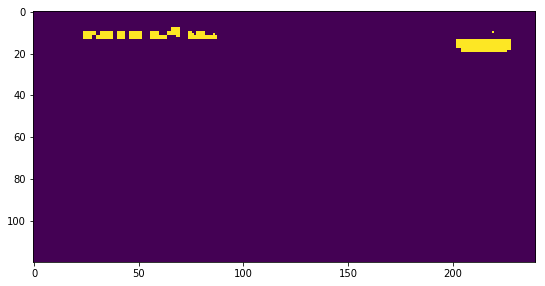

0.3 33 0.2


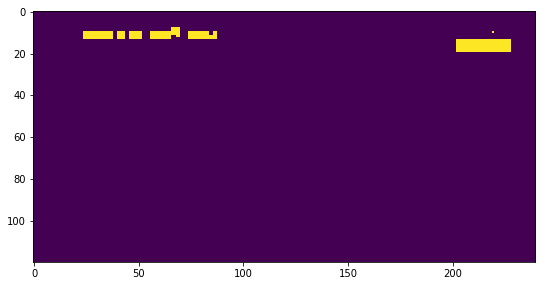

0.3 33 0.25


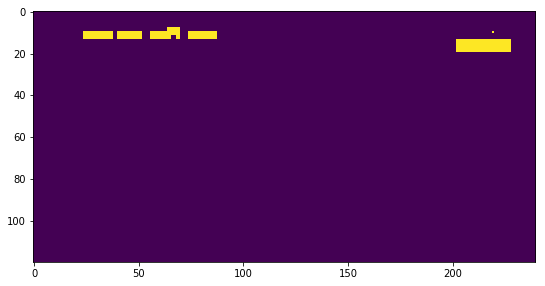

0.3 33 0.3


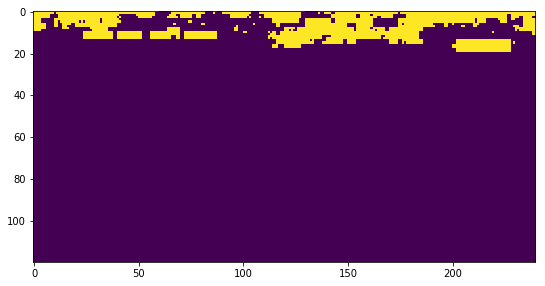

0.3 37 0.15


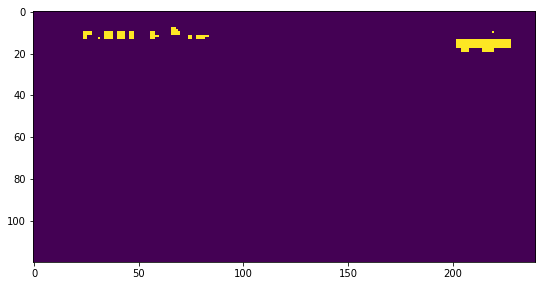

0.3 37 0.18


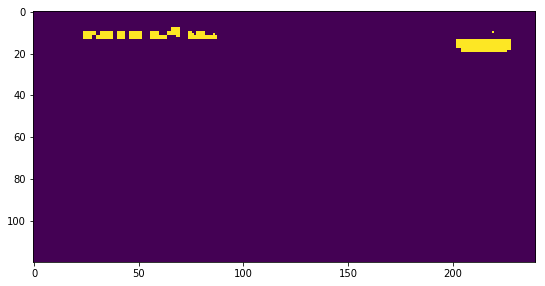

0.3 37 0.2


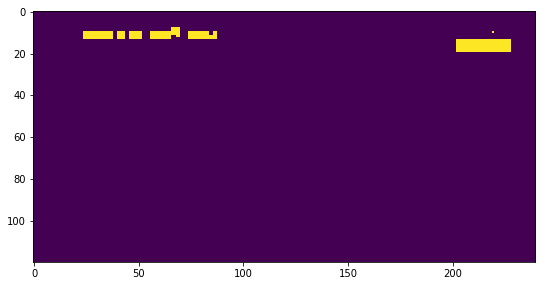

0.3 37 0.25


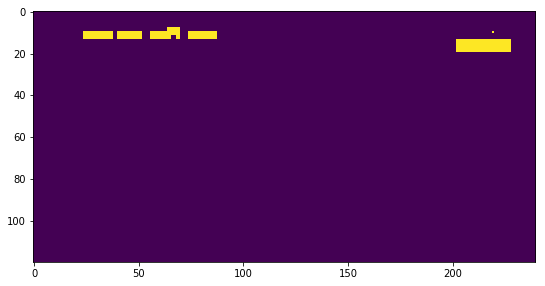

0.3 37 0.3


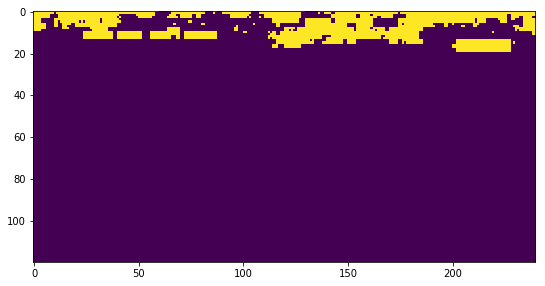

0.3 41 0.15


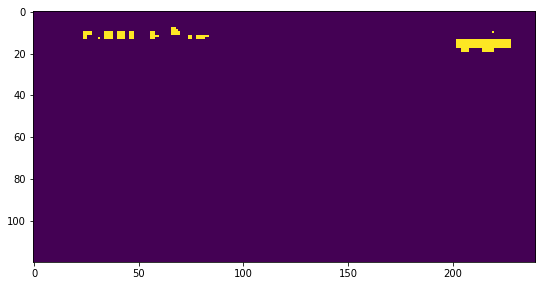

0.3 41 0.18


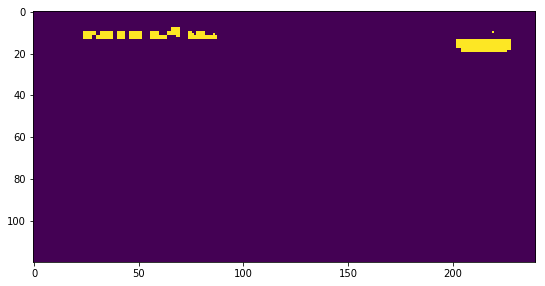

0.3 41 0.2


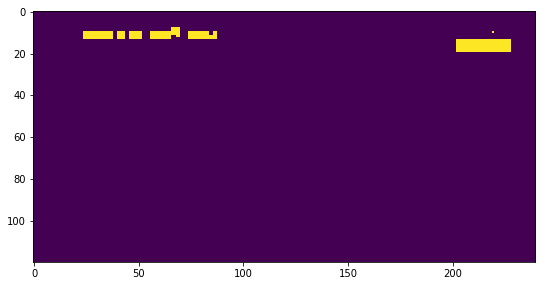

0.3 41 0.25


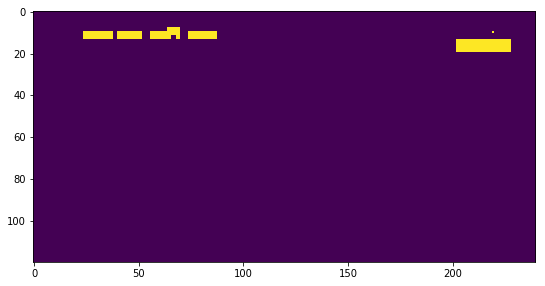

0.3 41 0.3


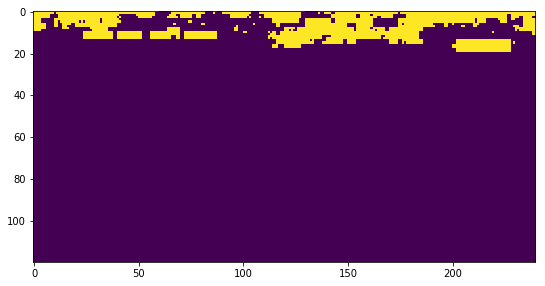

0.3 45 0.15


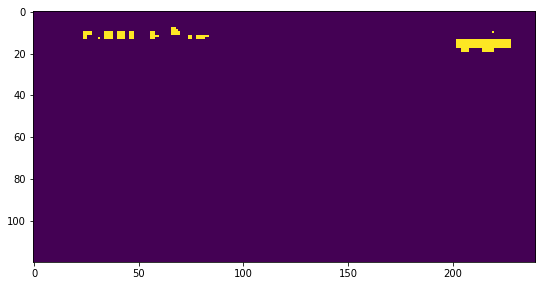

0.3 45 0.18


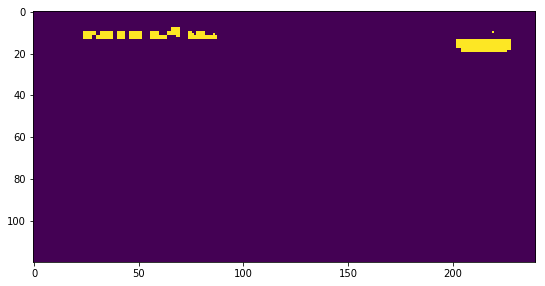

0.3 45 0.2


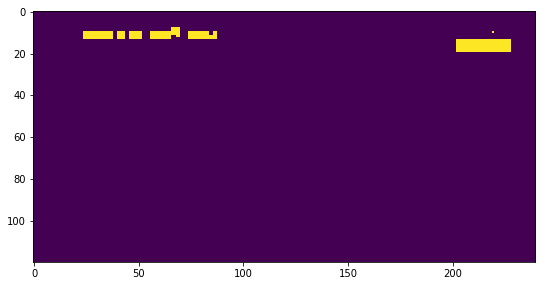

0.3 45 0.25


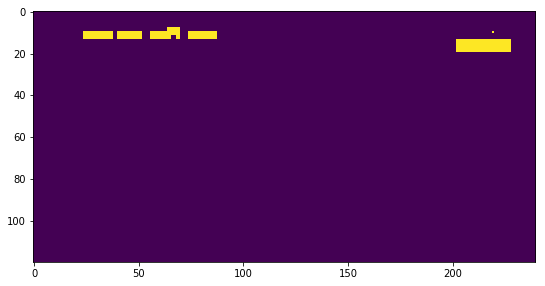

0.3 45 0.3


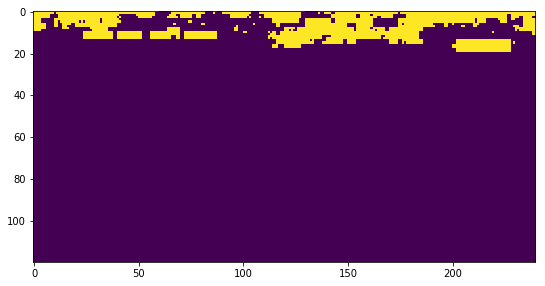

0.3 49 0.15


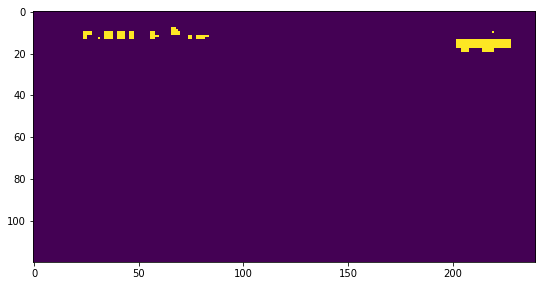

0.3 49 0.18


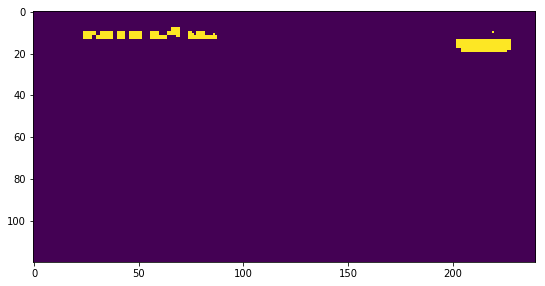

0.3 49 0.2


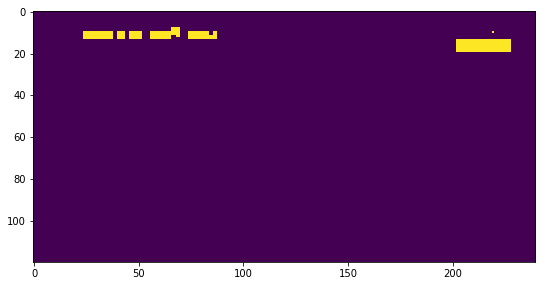

0.3 49 0.25


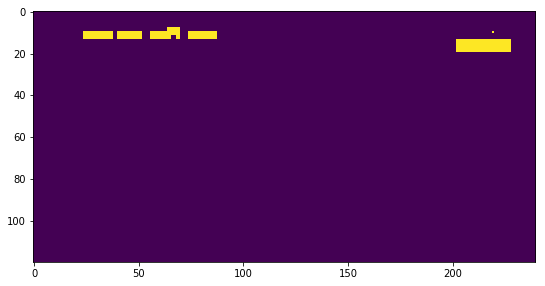

0.3 49 0.3


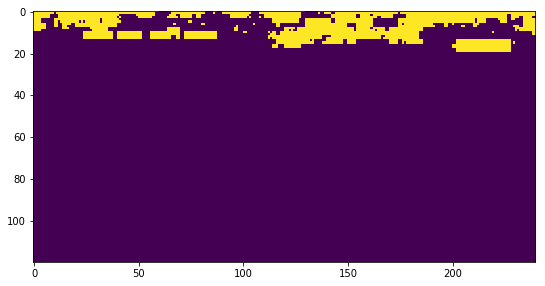

0.3 53 0.15


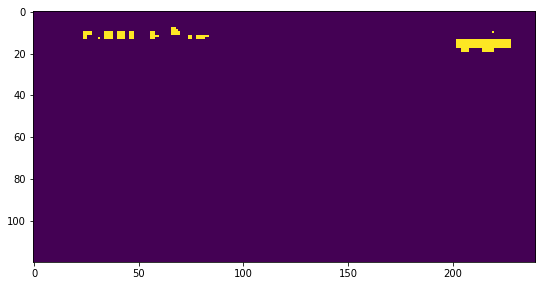

0.3 53 0.18


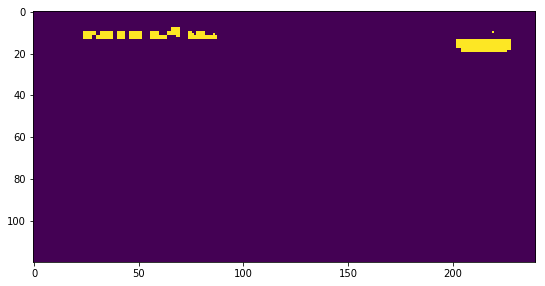

0.3 53 0.2


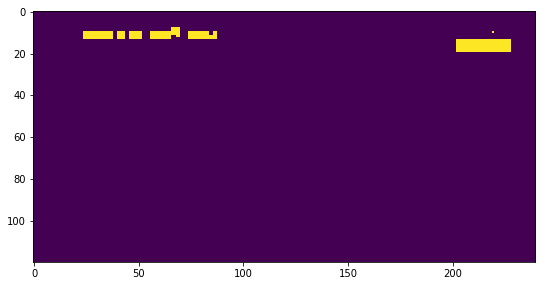

0.3 53 0.25


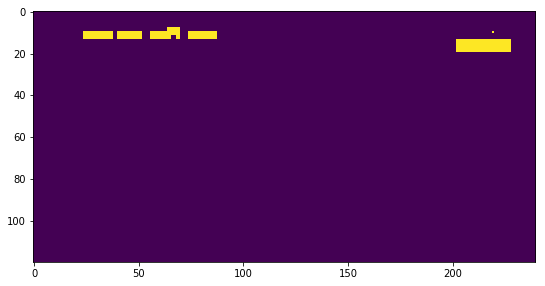

0.3 53 0.3


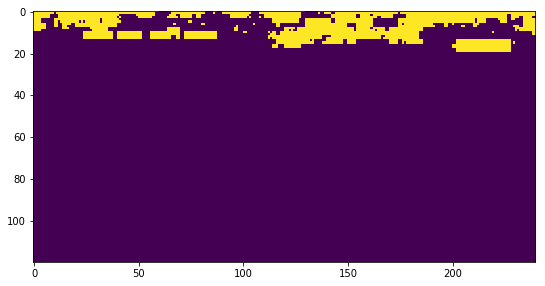

0.3 57 0.15


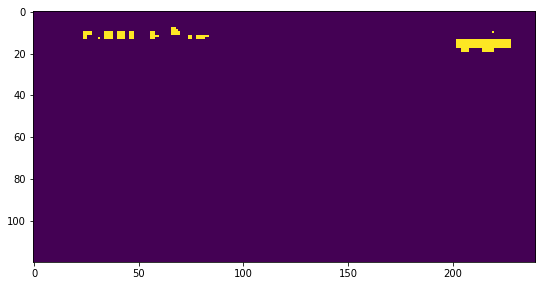

0.3 57 0.18


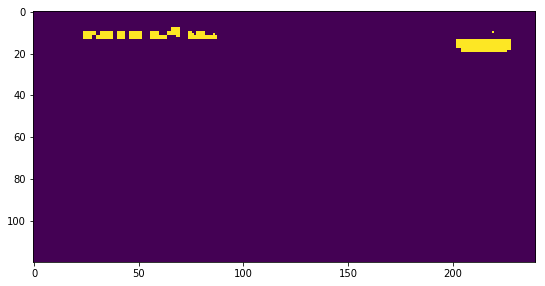

0.3 57 0.2


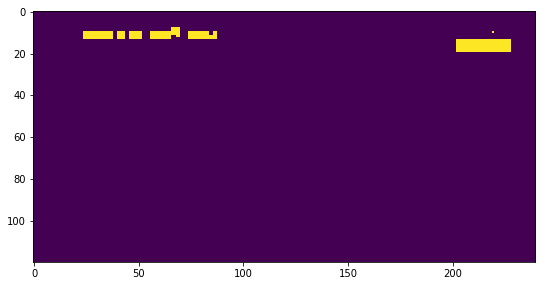

0.3 57 0.25


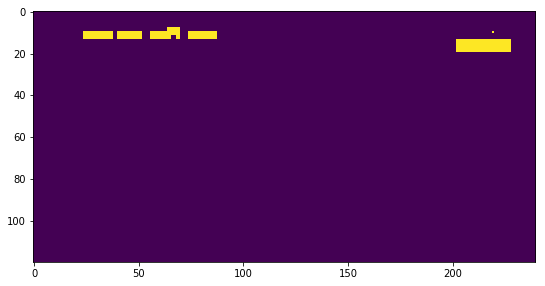

0.3 57 0.3


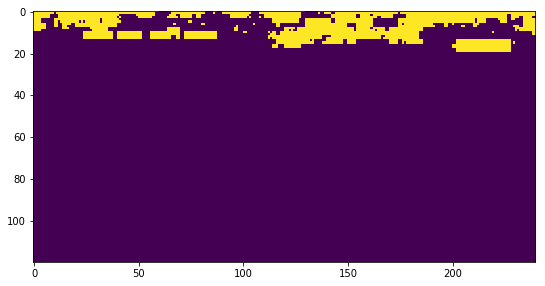

0.3 61 0.15


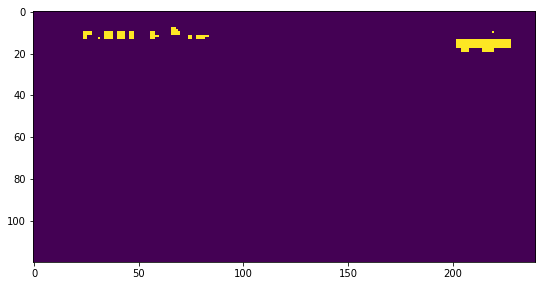

0.3 61 0.18


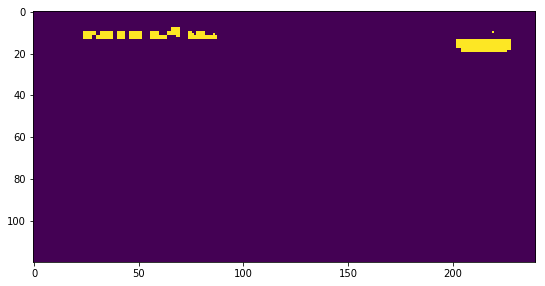

0.3 61 0.2


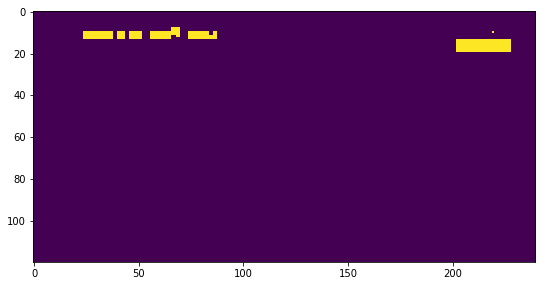

0.3 61 0.25


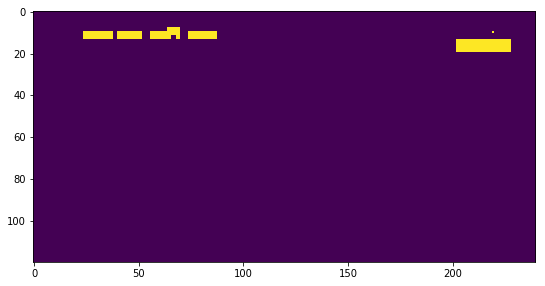

0.3 61 0.3


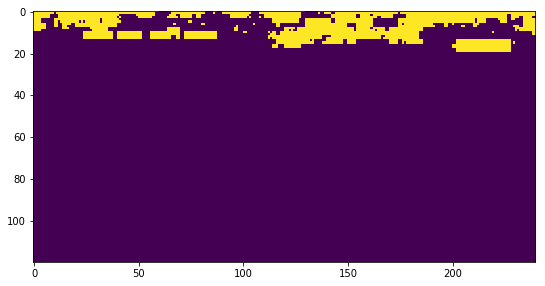

0.3 65 0.15


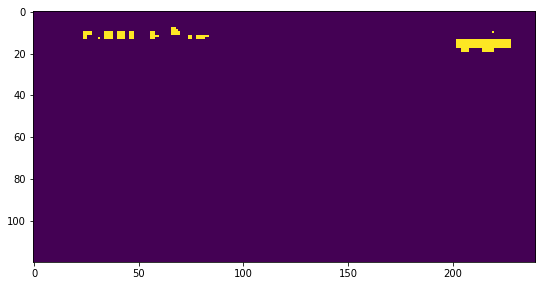

0.3 65 0.18


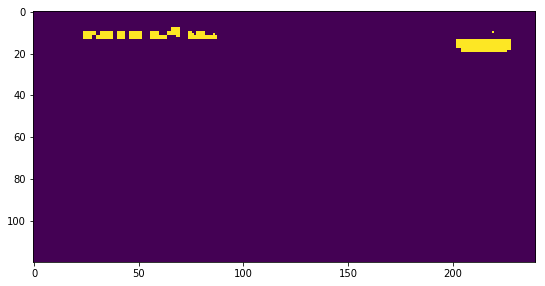

0.3 65 0.2


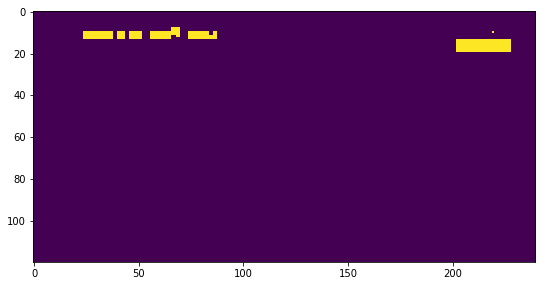

0.3 65 0.25


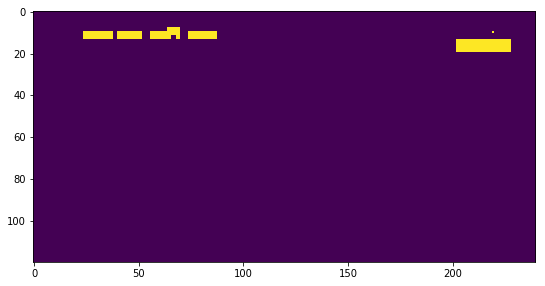

0.3 65 0.3


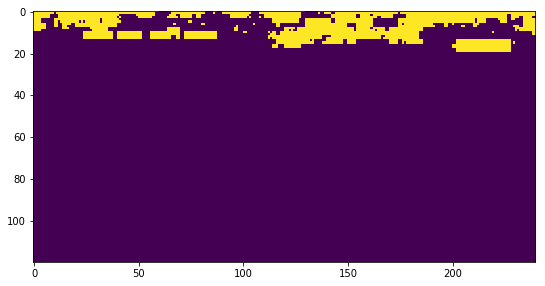

0.3 69 0.15


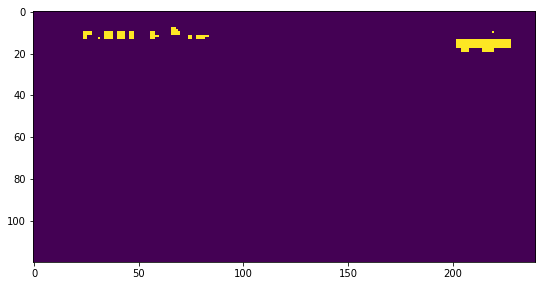

0.3 69 0.18


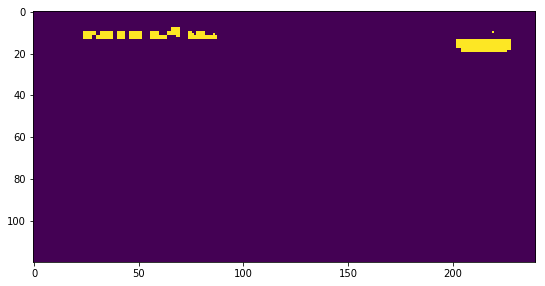

0.3 69 0.2


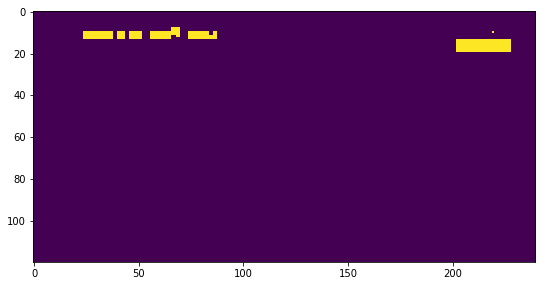

0.3 69 0.25


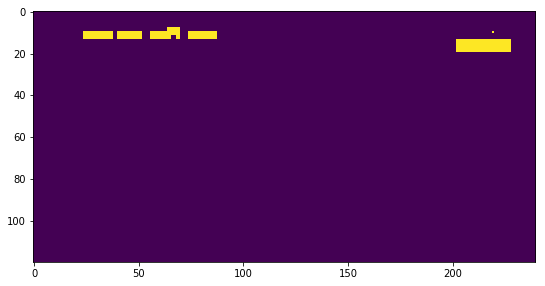

0.3 69 0.3


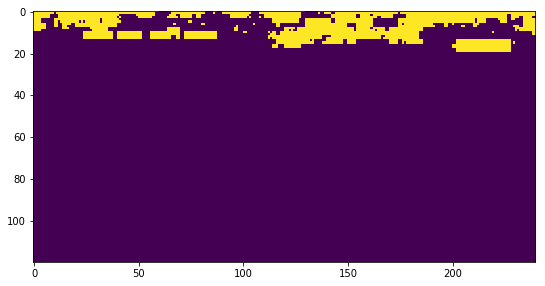

0.3 73 0.15


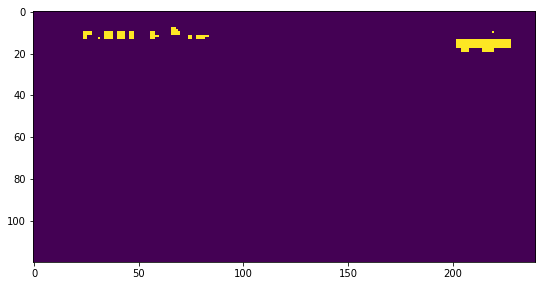

0.3 73 0.18


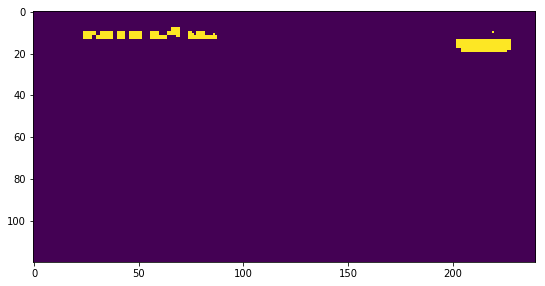

0.3 73 0.2


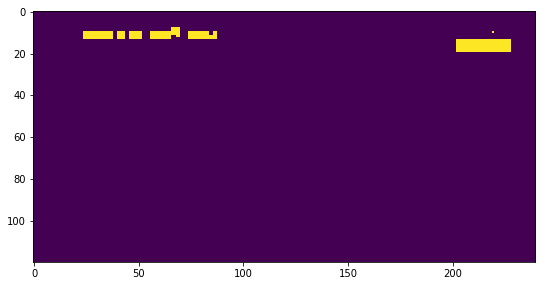

0.3 73 0.25


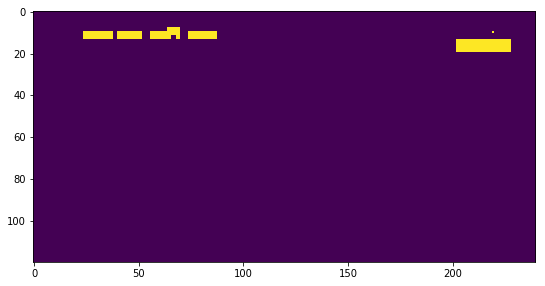

0.3 73 0.3


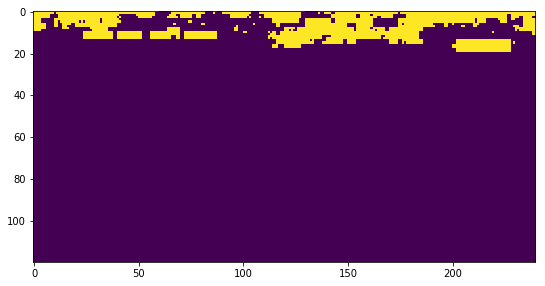

0.3 77 0.15


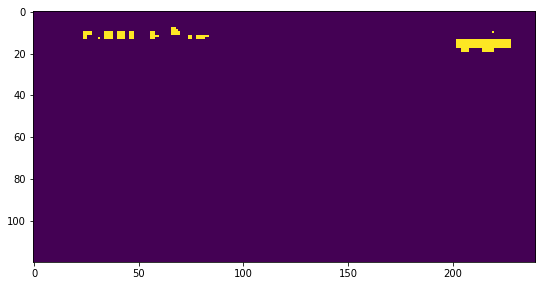

0.3 77 0.18


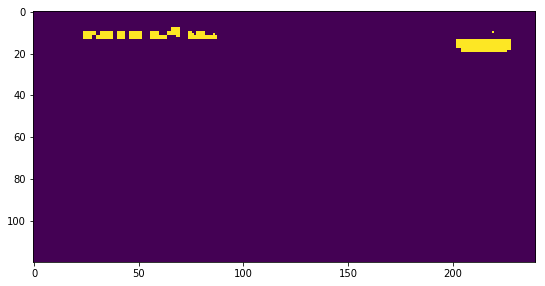

0.3 77 0.2


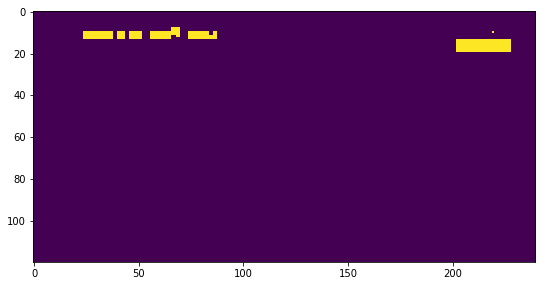

0.3 77 0.25


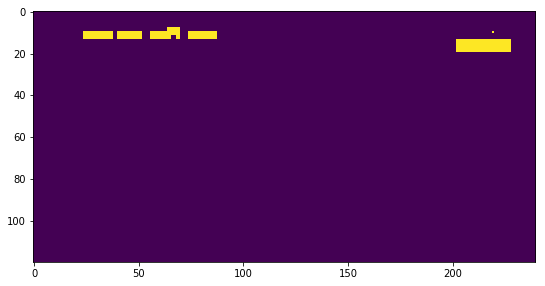

0.3 77 0.3


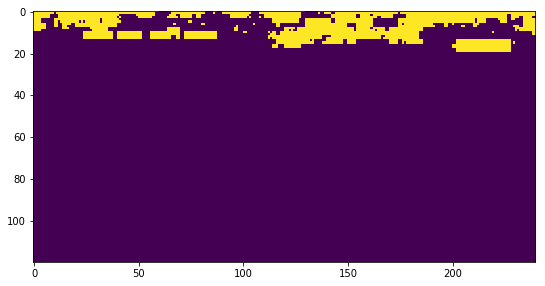

0.3 81 0.15


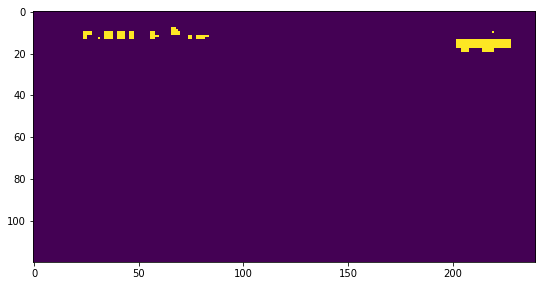

0.3 81 0.18


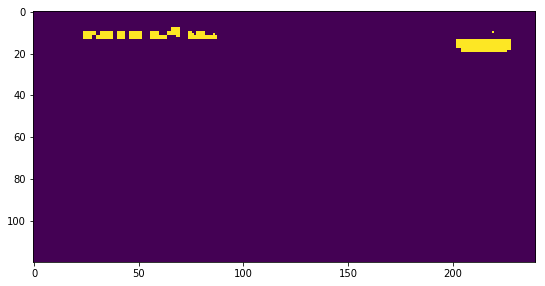

0.3 81 0.2


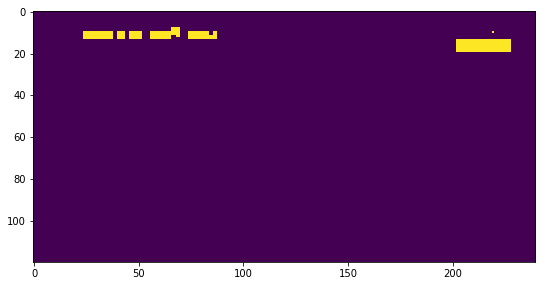

0.3 81 0.25


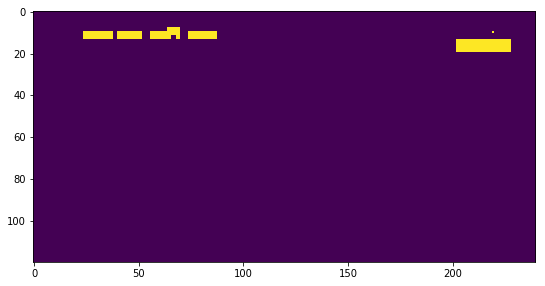

0.3 81 0.3


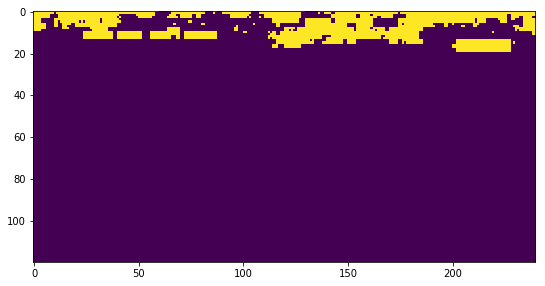

0.3 85 0.15


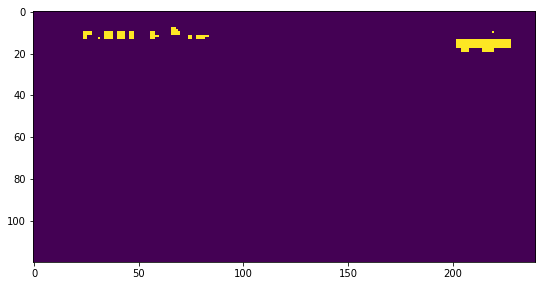

0.3 85 0.18


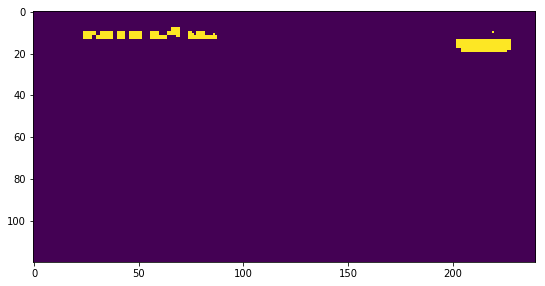

0.3 85 0.2


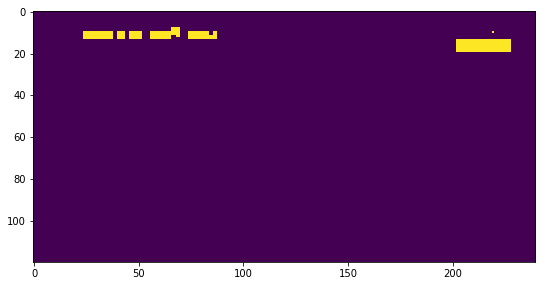

0.3 85 0.25


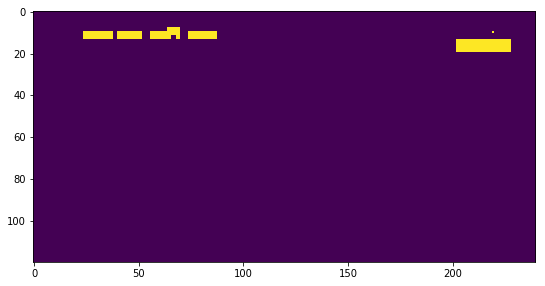

0.3 85 0.3


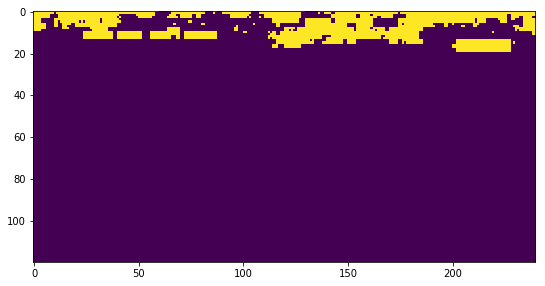

0.3 89 0.15


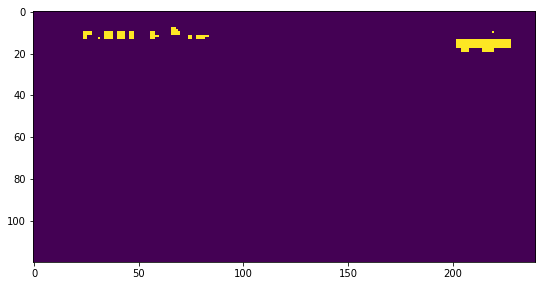

0.3 89 0.18


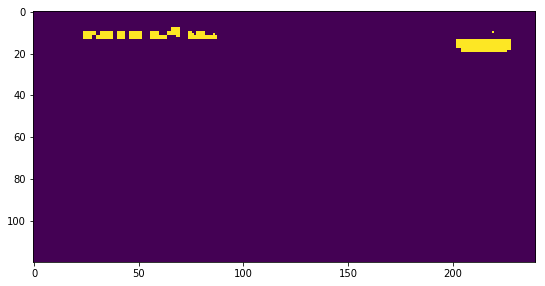

0.3 89 0.2


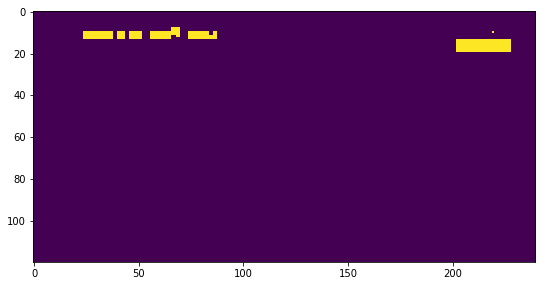

0.3 89 0.25


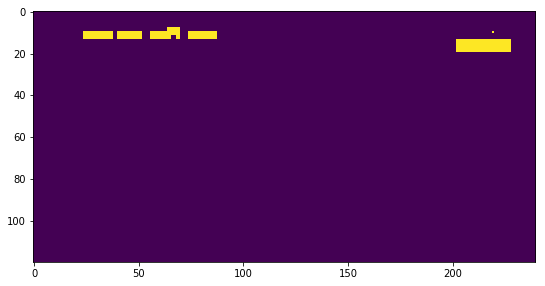

0.3 89 0.3


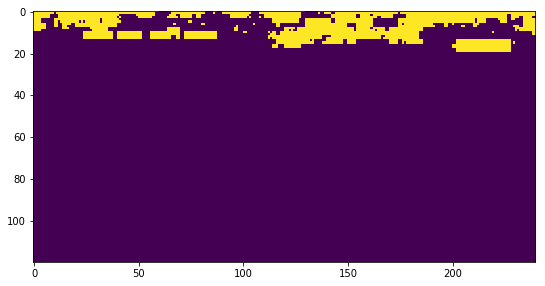

0.3 93 0.15


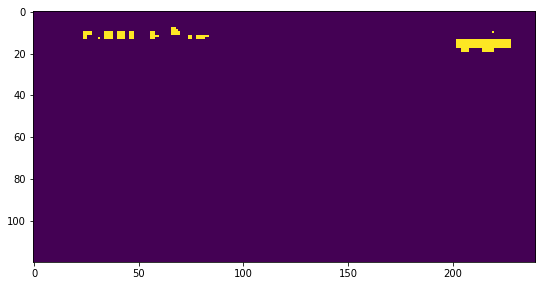

0.3 93 0.18


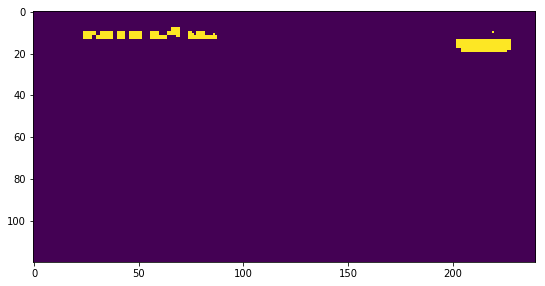

0.3 93 0.2


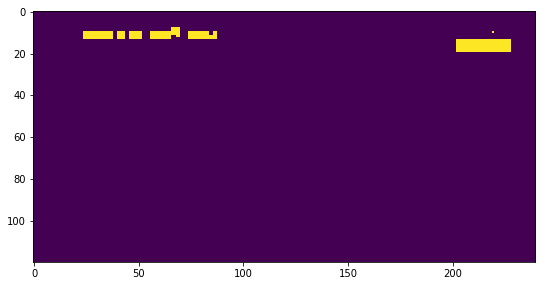

0.3 93 0.25


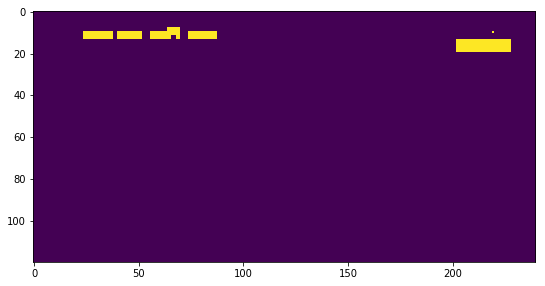

0.3 93 0.3


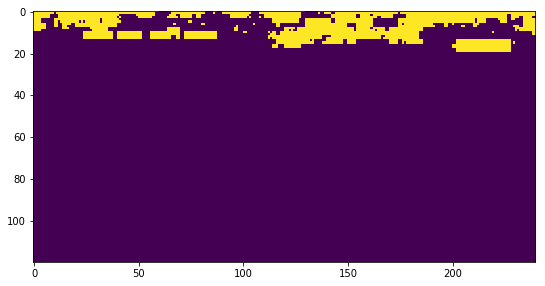

0.3 97 0.15


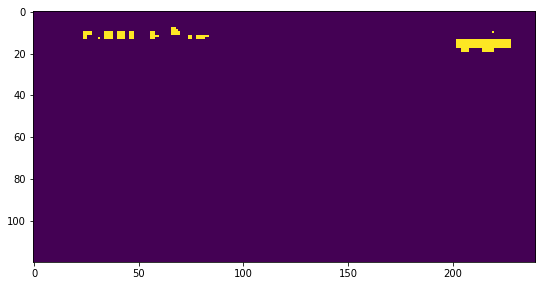

0.3 97 0.18


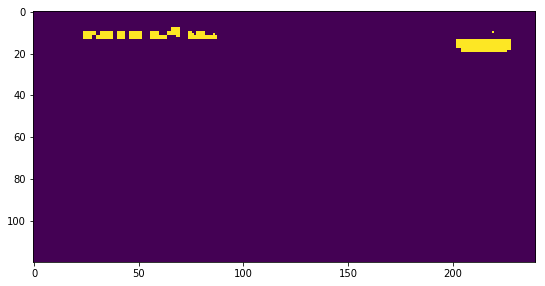

0.3 97 0.2


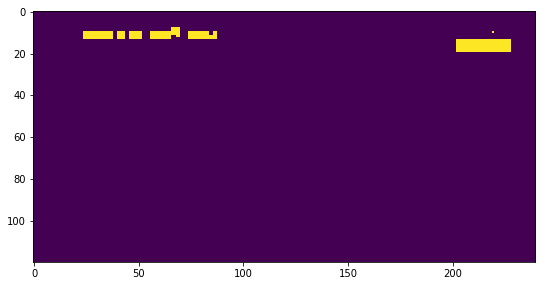

0.3 97 0.25


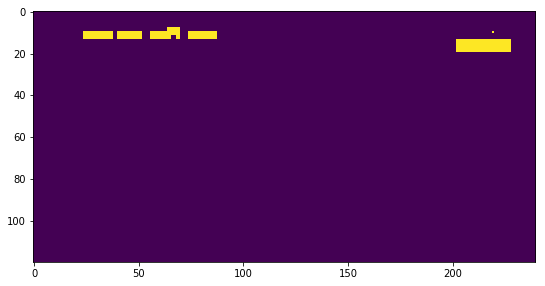

0.3 97 0.3


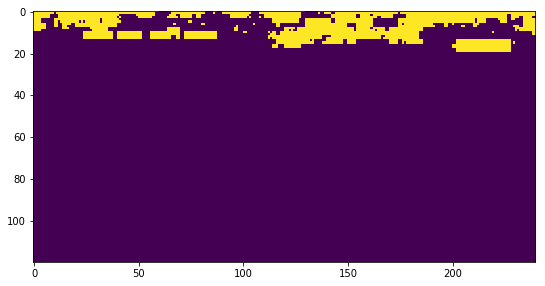

0.3 101 0.15


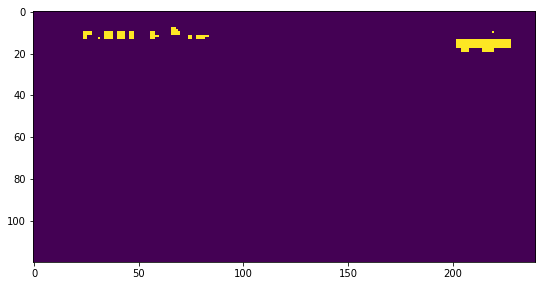

0.3 101 0.18


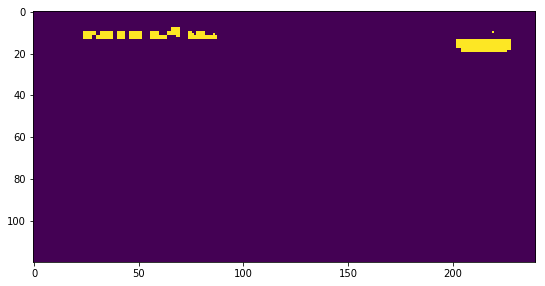

0.3 101 0.2


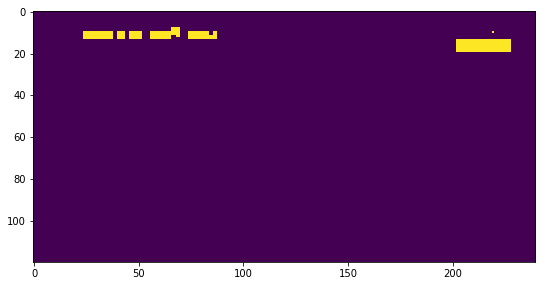

0.3 101 0.25


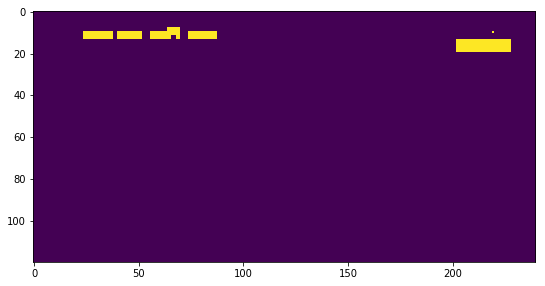

0.3 101 0.3


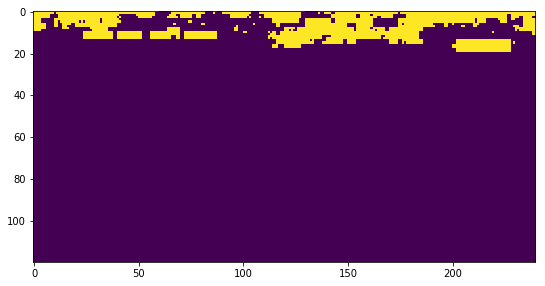

0.3 105 0.15


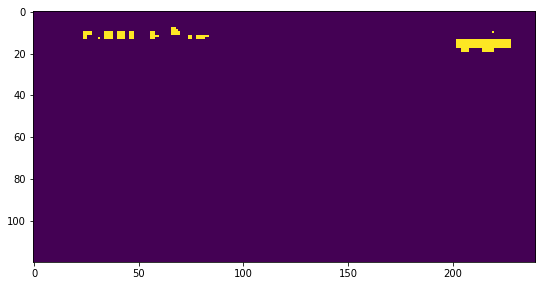

0.3 105 0.18


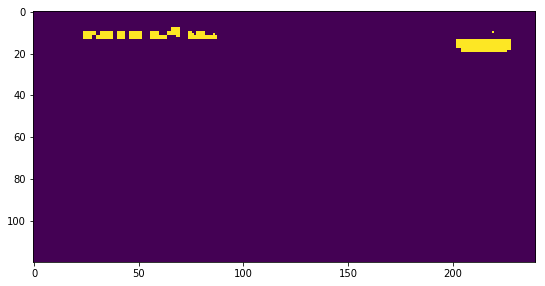

0.3 105 0.2


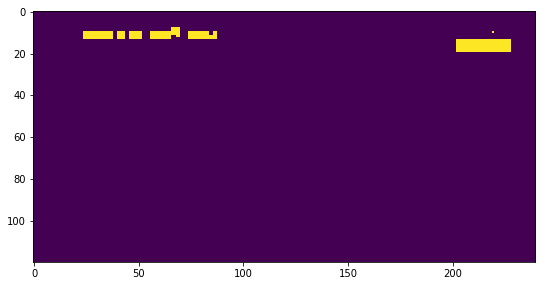

0.3 105 0.25


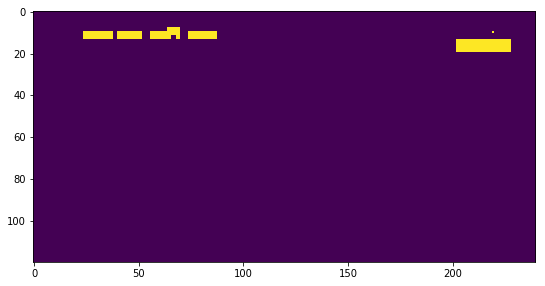

0.3 105 0.3


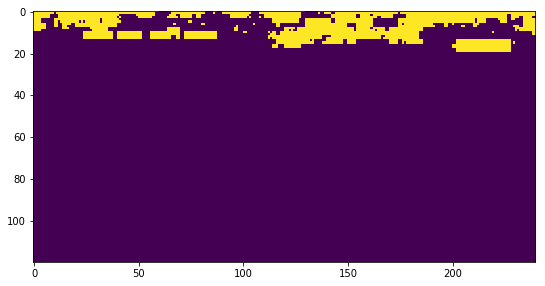

0.3 109 0.15


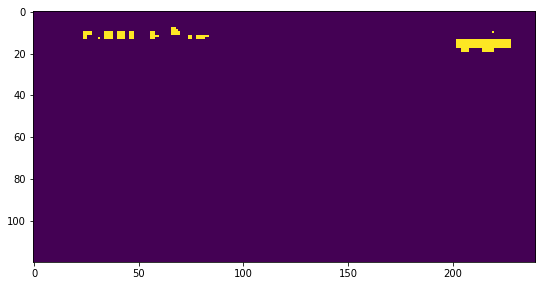

0.3 109 0.18


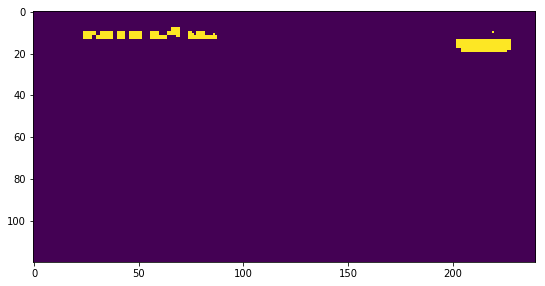

0.3 109 0.2


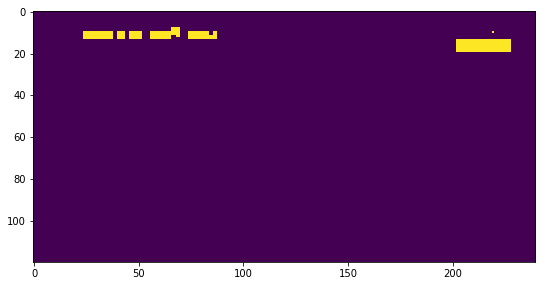

0.3 109 0.25


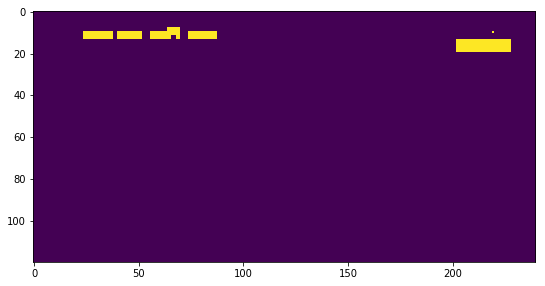

0.3 109 0.3


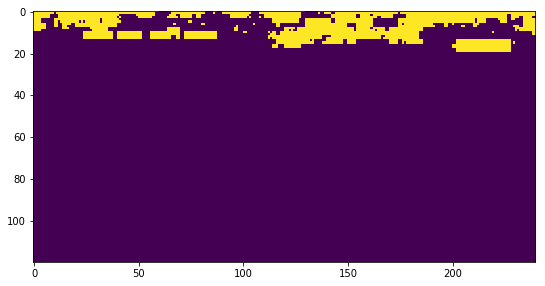

0.3 113 0.15


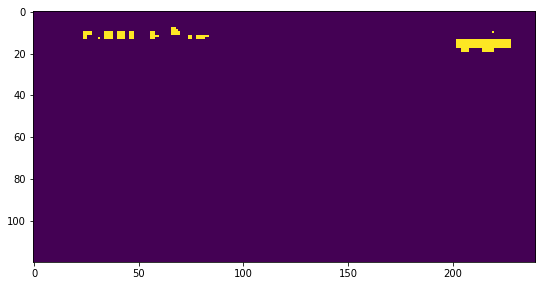

0.3 113 0.18


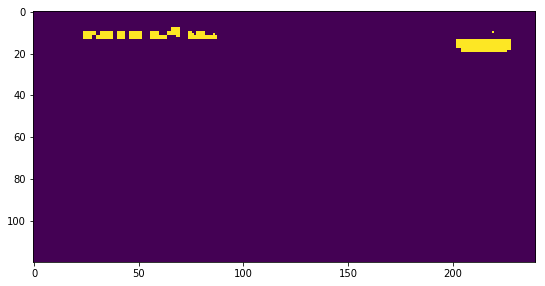

0.3 113 0.2


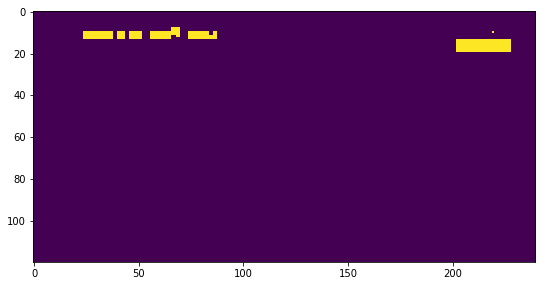

0.3 113 0.25


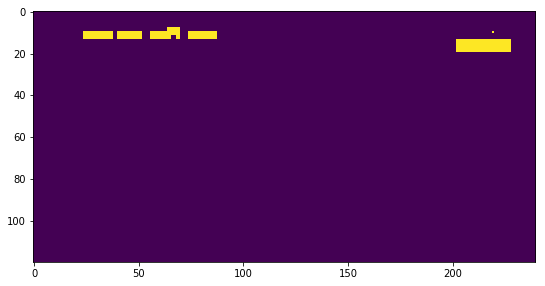

0.3 113 0.3


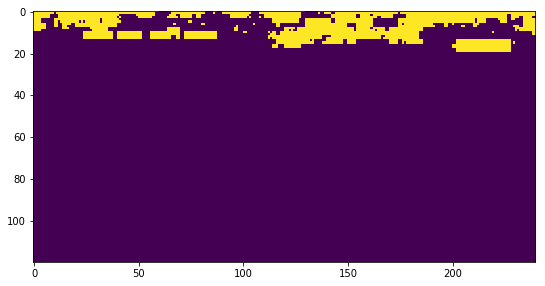

0.3 117 0.15


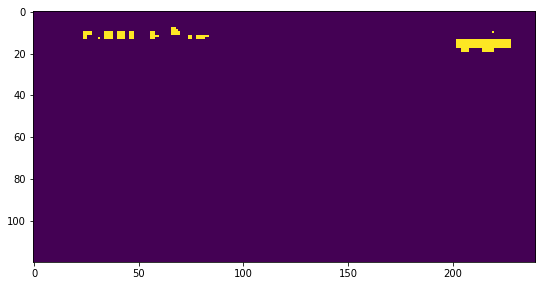

0.3 117 0.18


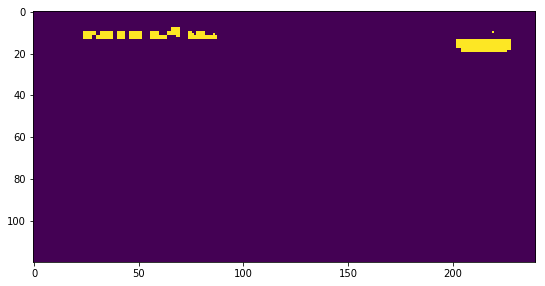

0.3 117 0.2


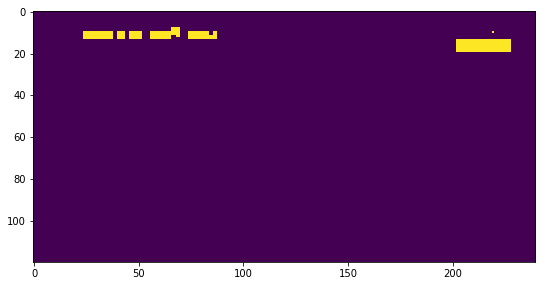

0.3 117 0.25


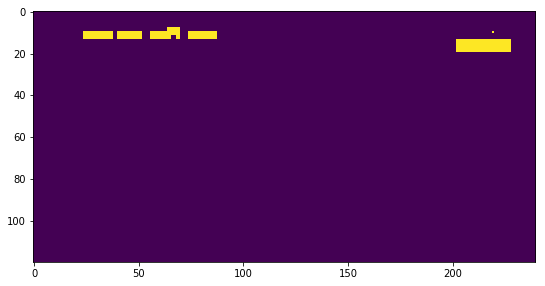

0.3 117 0.3


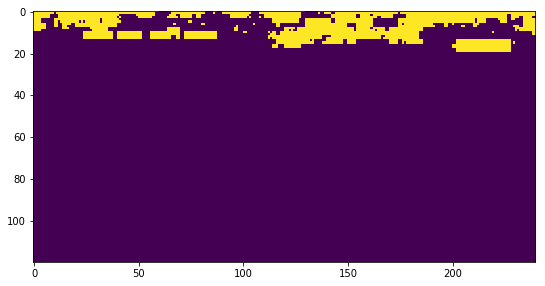

0.3 121 0.15


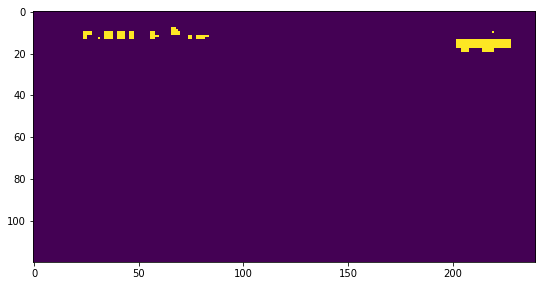

0.3 121 0.18


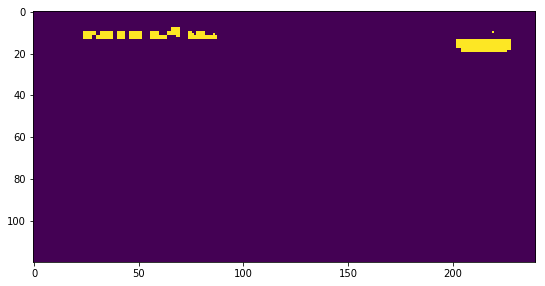

0.3 121 0.2


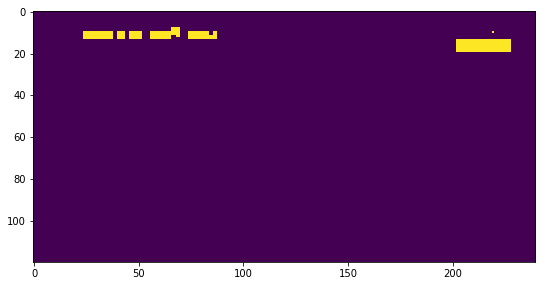

0.3 121 0.25


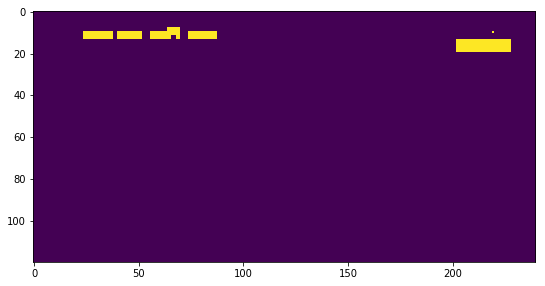

0.3 121 0.3


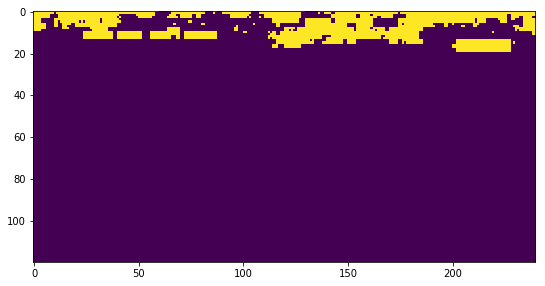

0.3 125 0.15


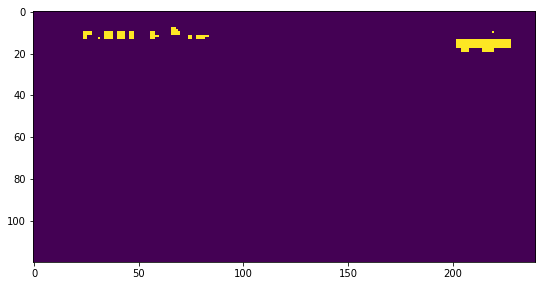

0.3 125 0.18


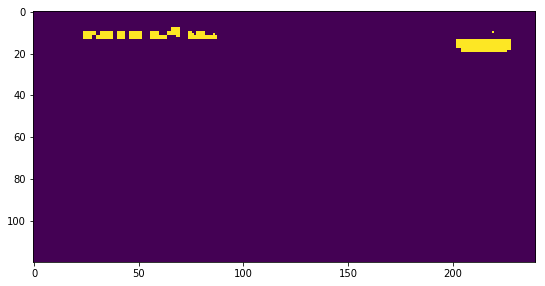

0.3 125 0.2


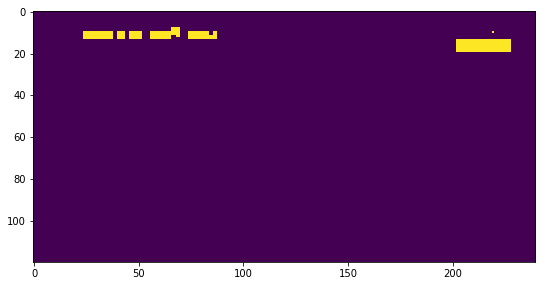

0.3 125 0.25


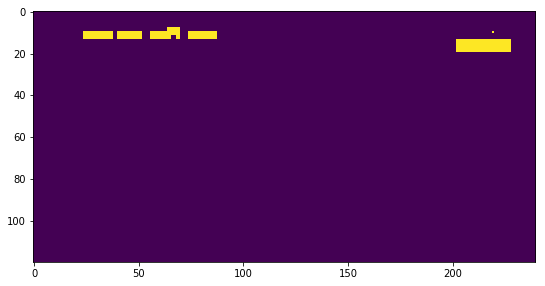

0.3 125 0.3


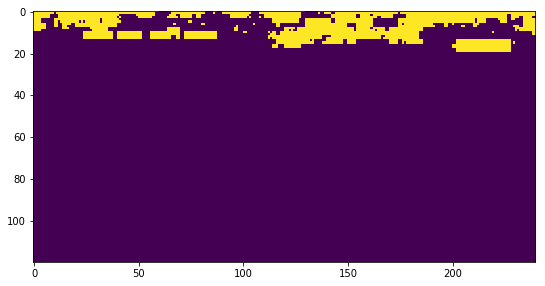

0.3 129 0.15


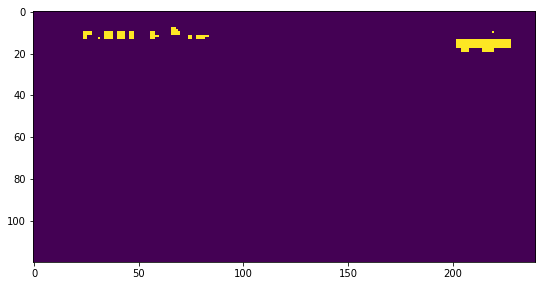

0.3 129 0.18


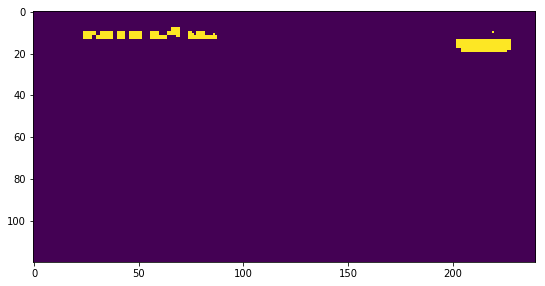

0.3 129 0.2


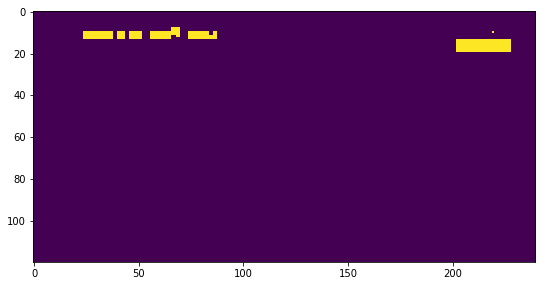

0.3 129 0.25


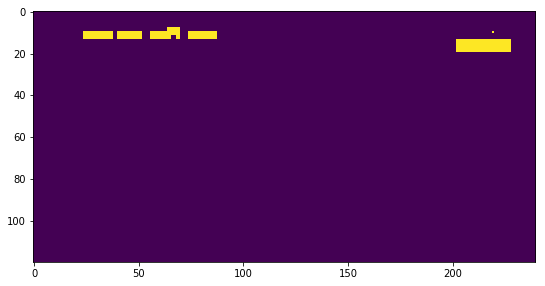

0.3 129 0.3


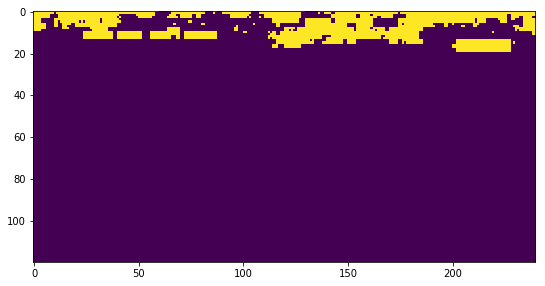

0.3 133 0.15


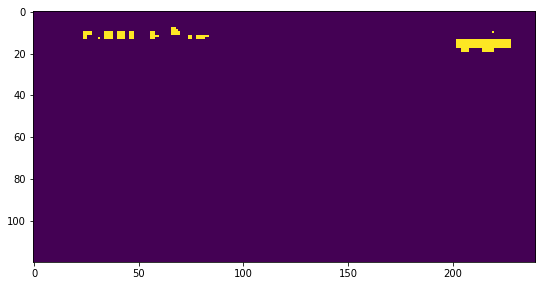

0.3 133 0.18


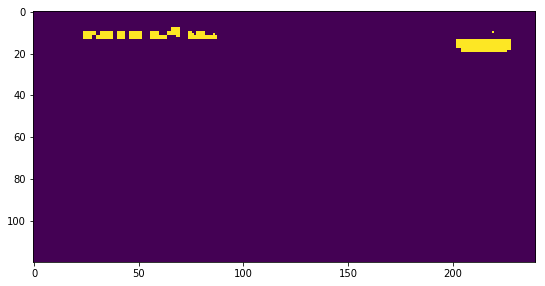

0.3 133 0.2


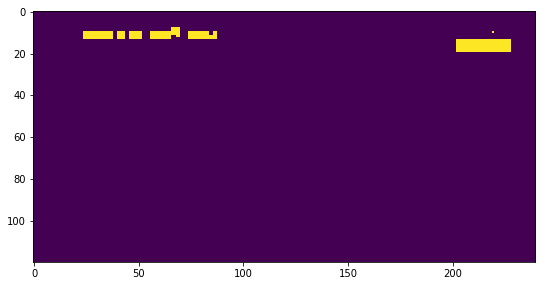

0.3 133 0.25


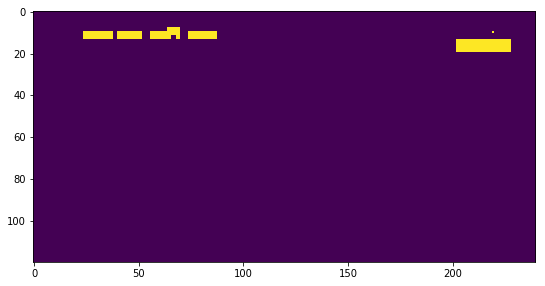

0.3 133 0.3


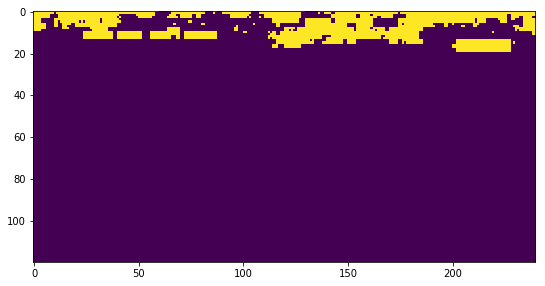

0.3 137 0.15


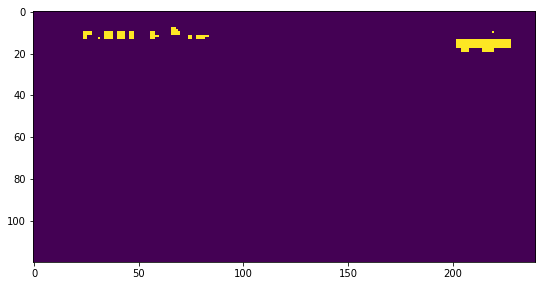

0.3 137 0.18


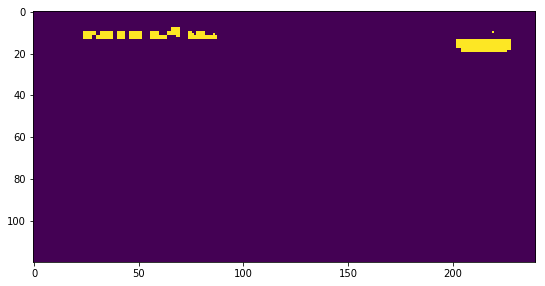

0.3 137 0.2


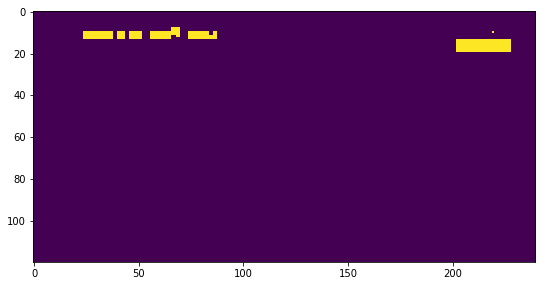

0.3 137 0.25


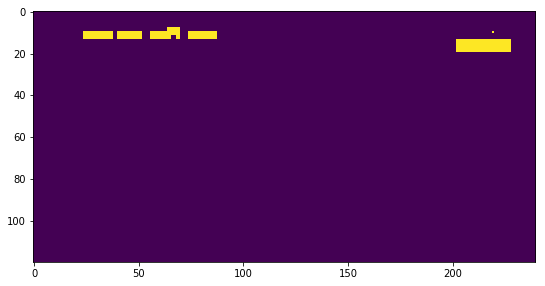

0.3 137 0.3


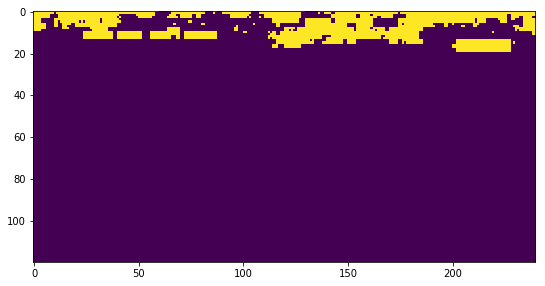

0.3 141 0.15


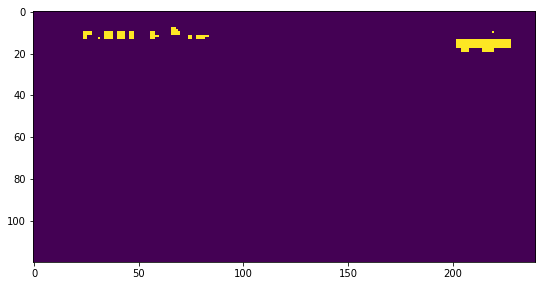

0.3 141 0.18


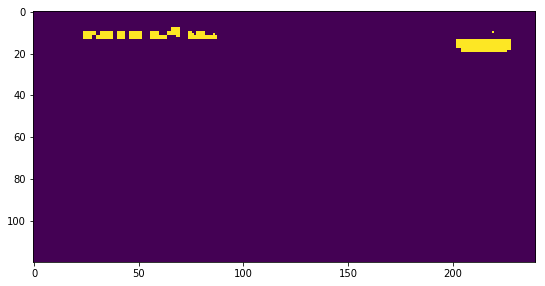

0.3 141 0.2


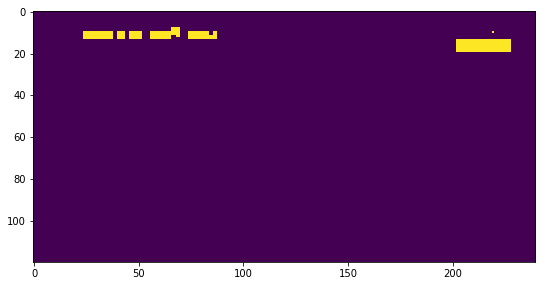

0.3 141 0.25


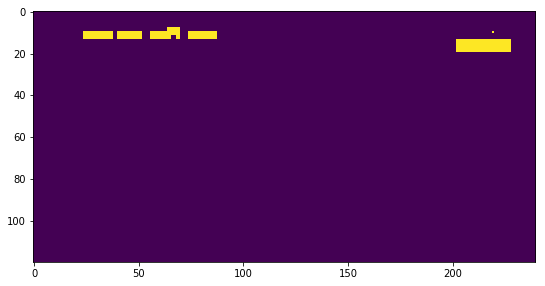

0.3 141 0.3


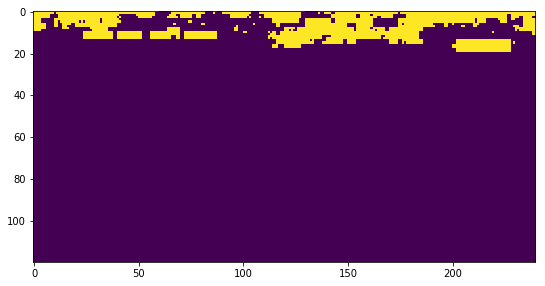

0.3 145 0.15


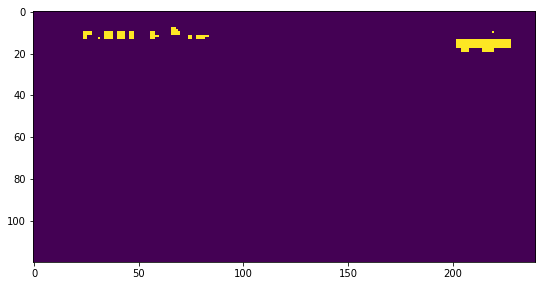

0.3 145 0.18


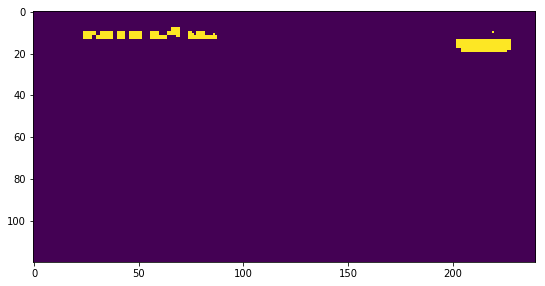

0.3 145 0.2


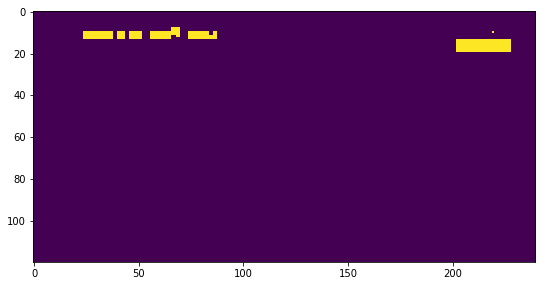

0.3 145 0.25


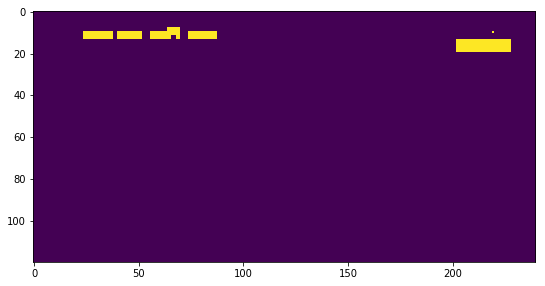

0.3 145 0.3


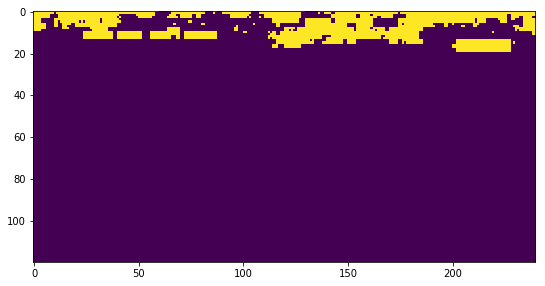

0.3 149 0.15


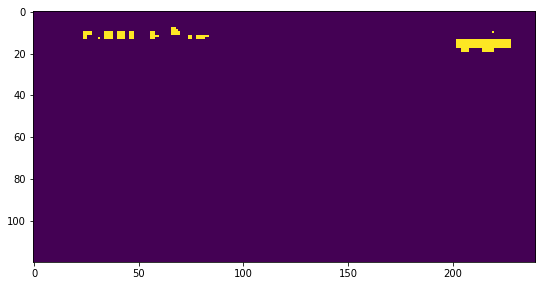

0.3 149 0.18


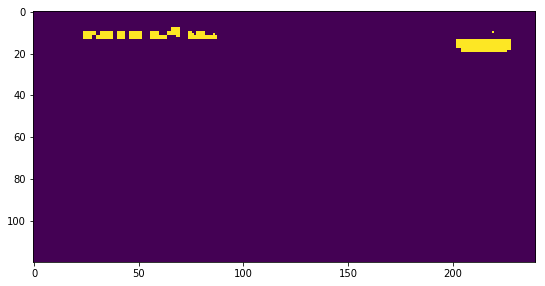

0.3 149 0.2


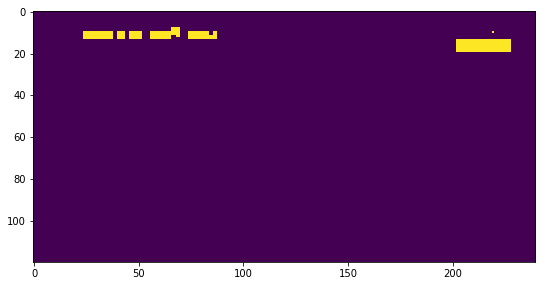

0.3 149 0.25


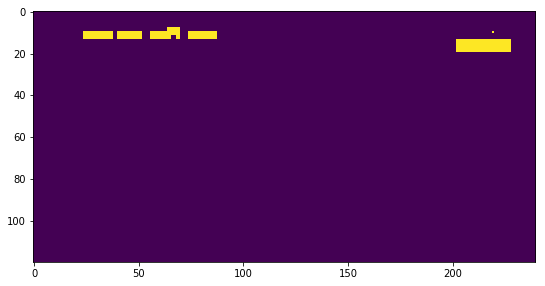

0.3 149 0.3


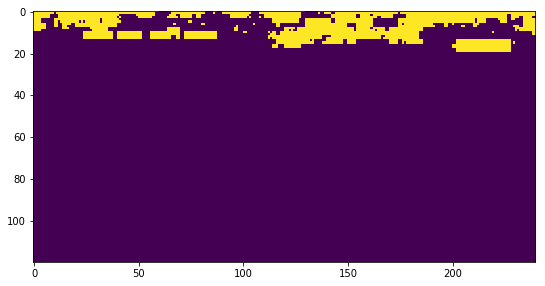

0.3 153 0.15


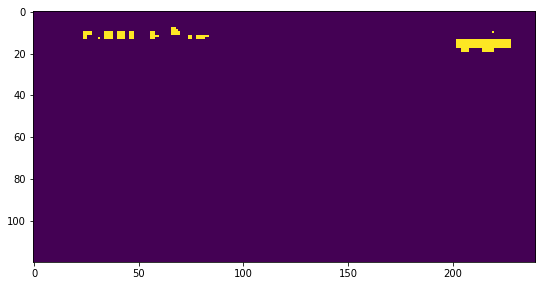

0.3 153 0.18


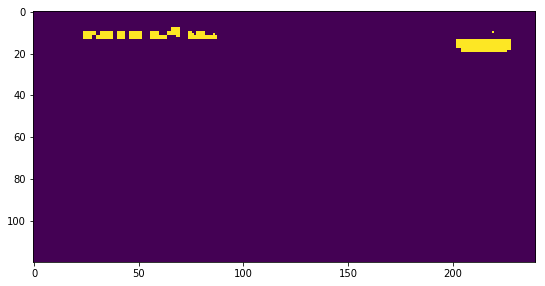

0.3 153 0.2


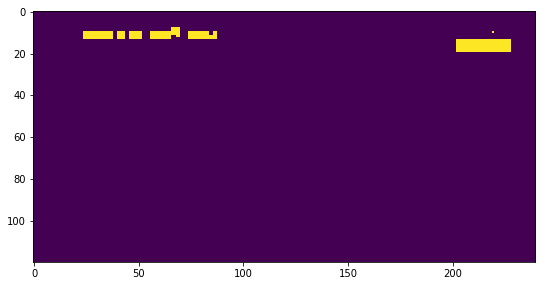

0.3 153 0.25


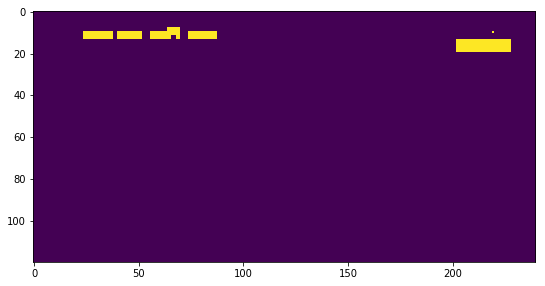

0.3 153 0.3


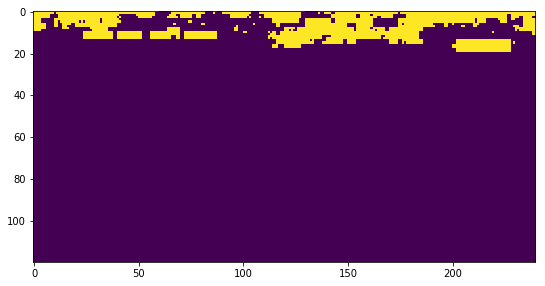

0.3 157 0.15


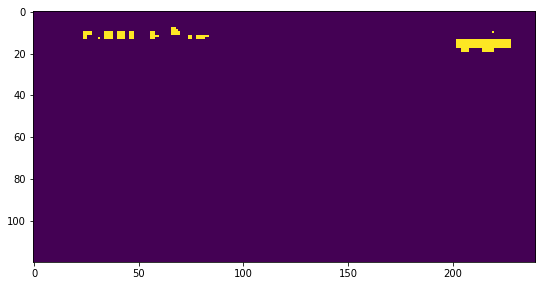

0.3 157 0.18


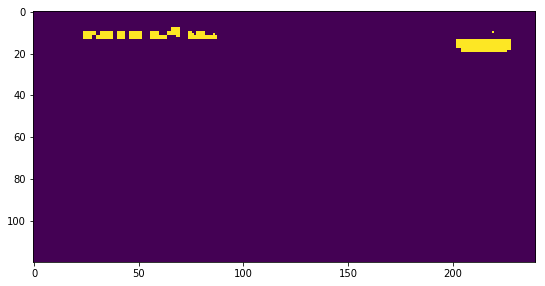

0.3 157 0.2


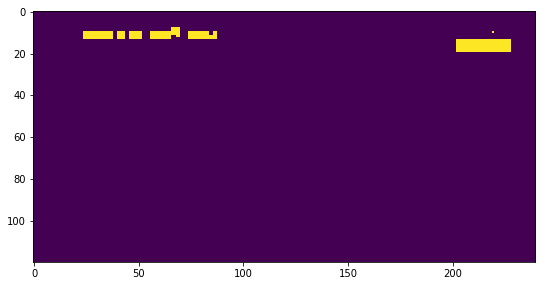

0.3 157 0.25


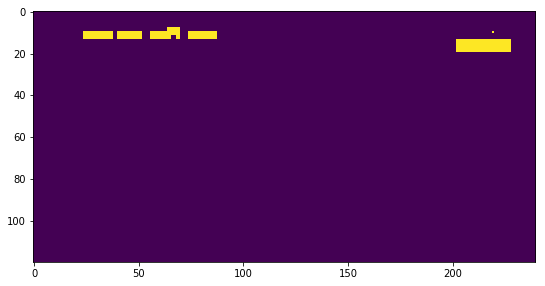

0.3 157 0.3


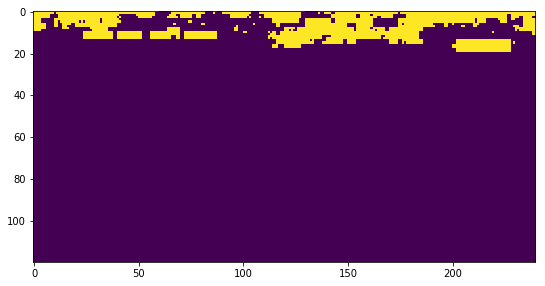

0.3 161 0.15


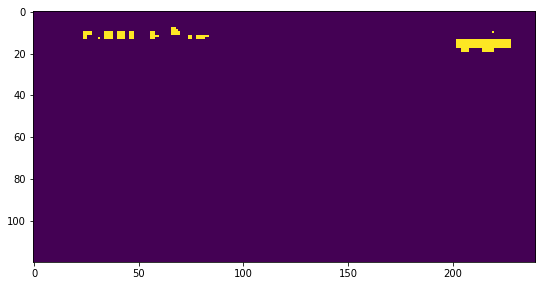

0.3 161 0.18


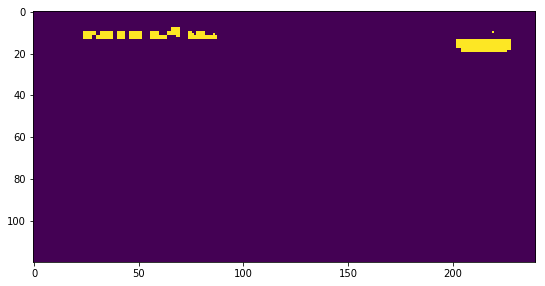

0.3 161 0.2


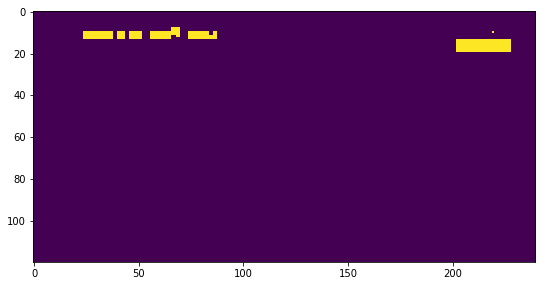

0.3 161 0.25


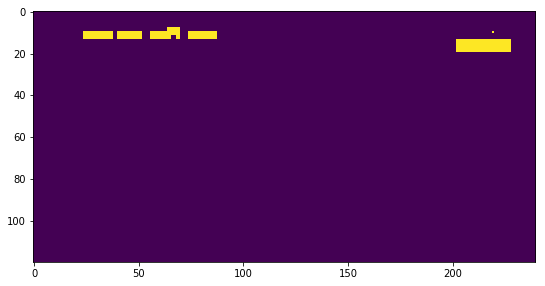

0.3 161 0.3


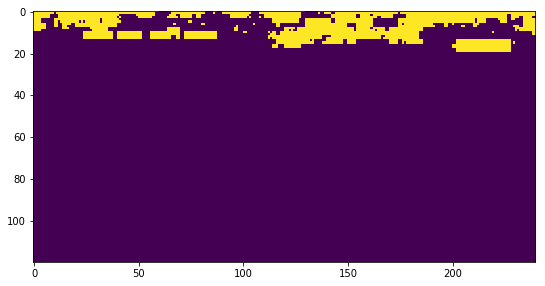

0.3 165 0.15


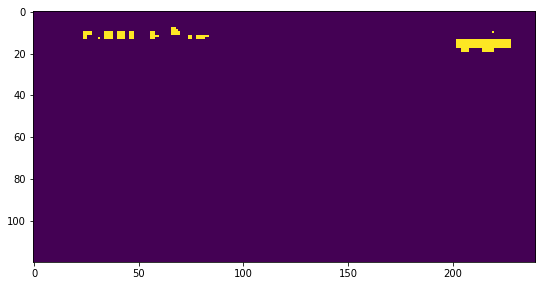

0.3 165 0.18


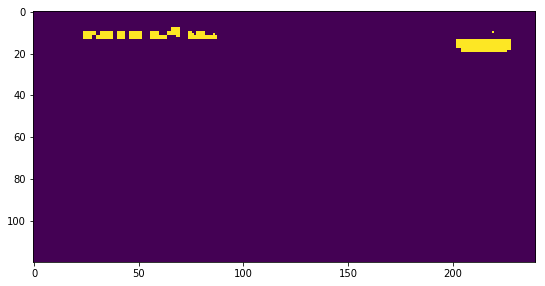

0.3 165 0.2


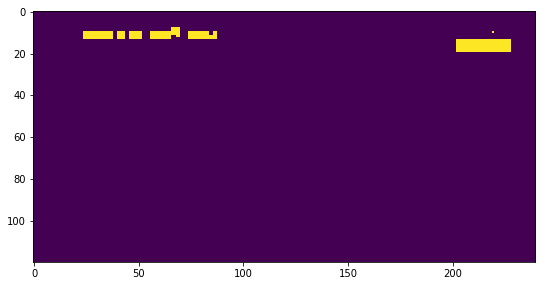

0.3 165 0.25


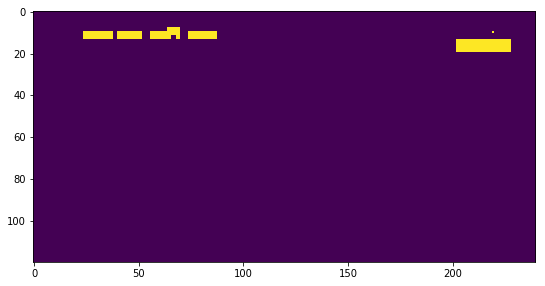

0.3 165 0.3


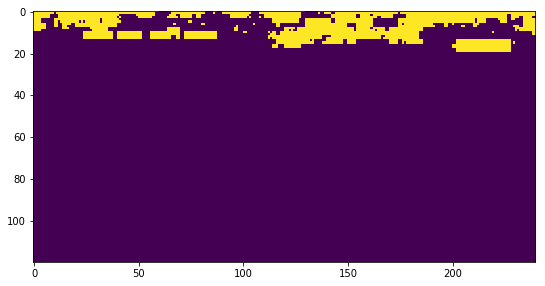

0.3 169 0.15


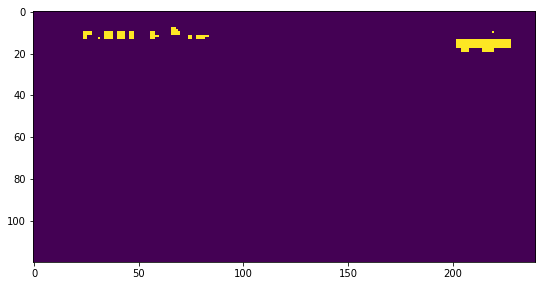

0.3 169 0.18


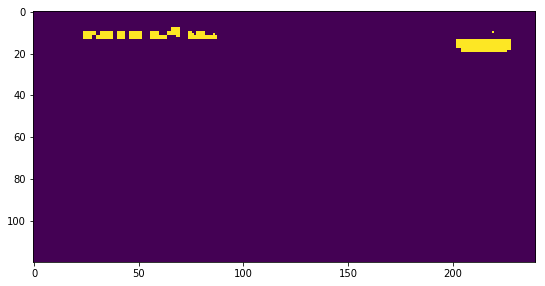

0.3 169 0.2


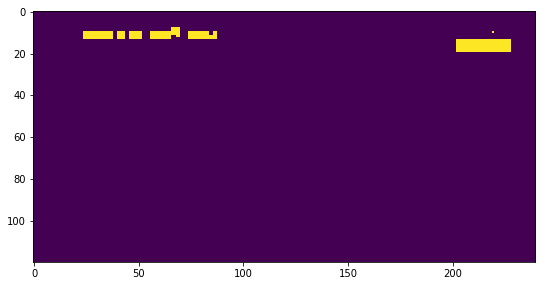

0.3 169 0.25


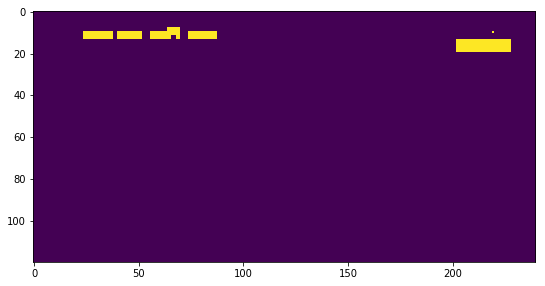

0.3 169 0.3


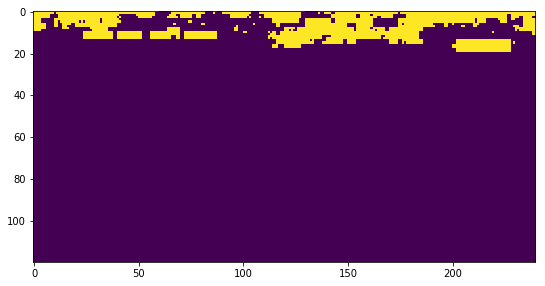

0.3 173 0.15


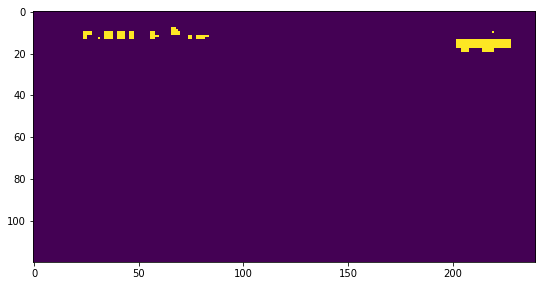

0.3 173 0.18


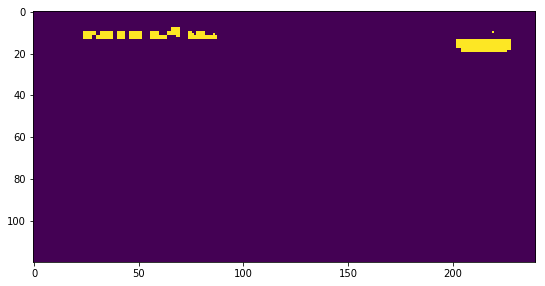

0.3 173 0.2


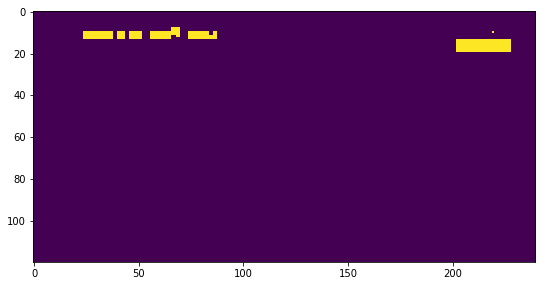

0.3 173 0.25


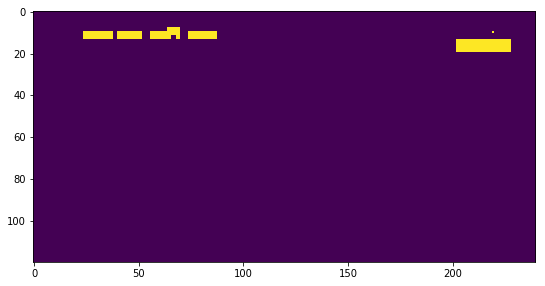

0.3 173 0.3


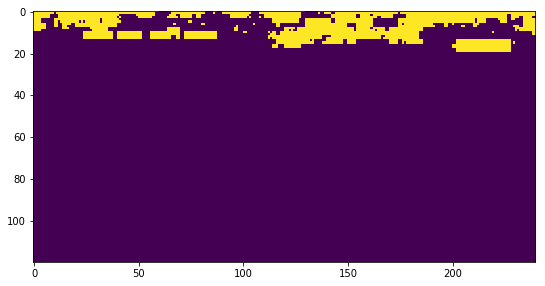

0.3 177 0.15


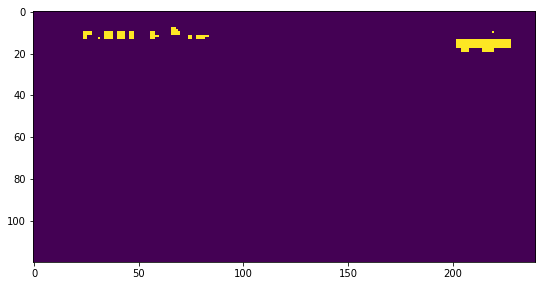

0.3 177 0.18


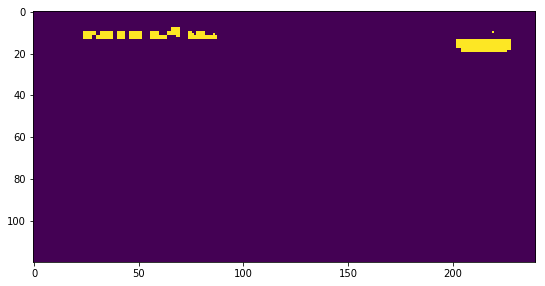

0.3 177 0.2


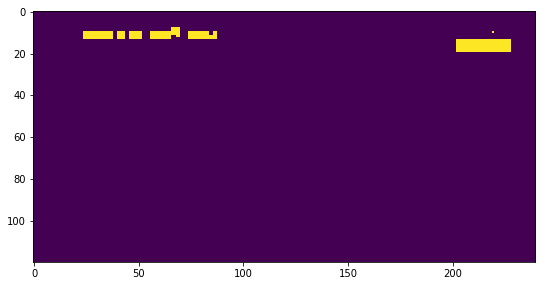

0.3 177 0.25


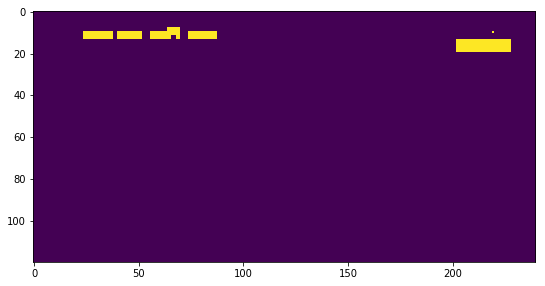

0.3 177 0.3


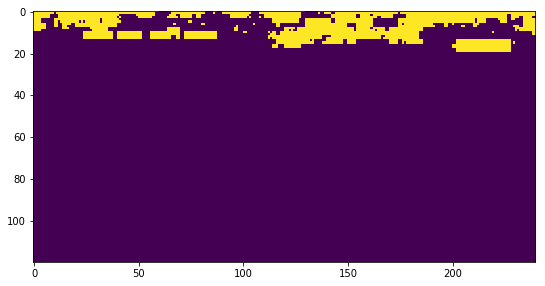

0.3 181 0.15


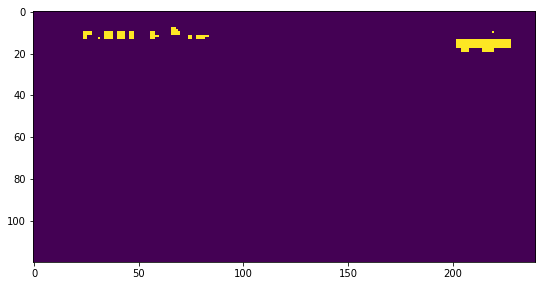

0.3 181 0.18


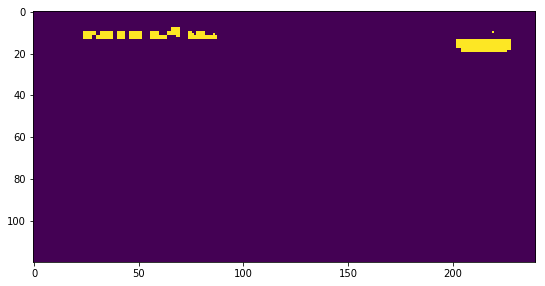

0.3 181 0.2


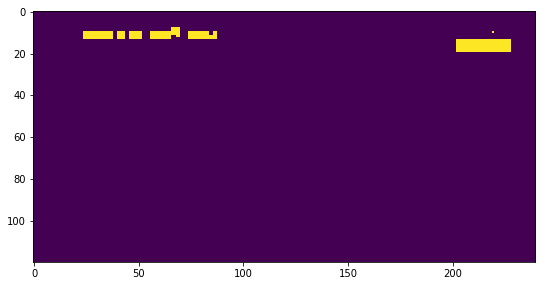

0.3 181 0.25


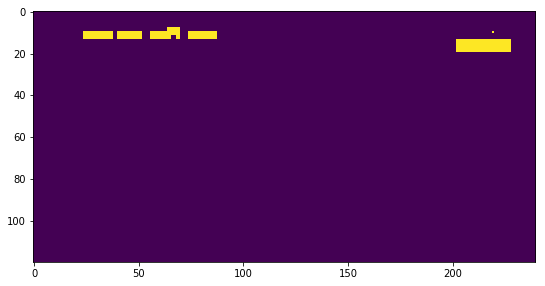

0.3 181 0.3


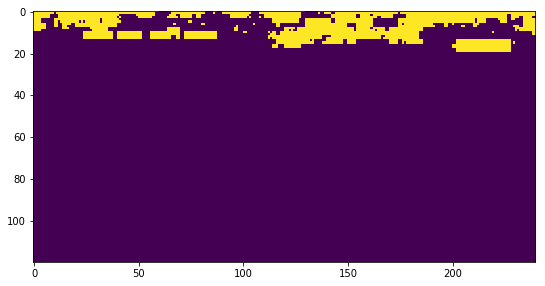

0.3 185 0.15


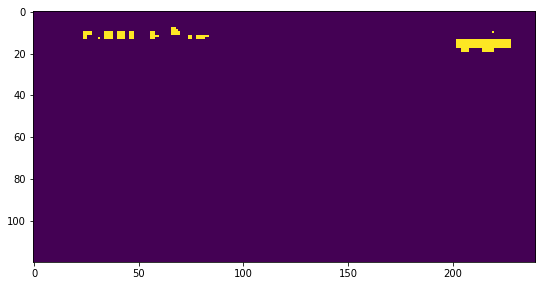

0.3 185 0.18


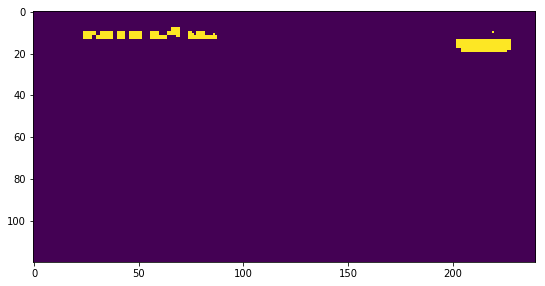

0.3 185 0.2


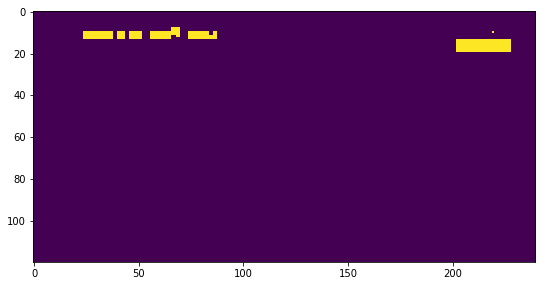

0.3 185 0.25


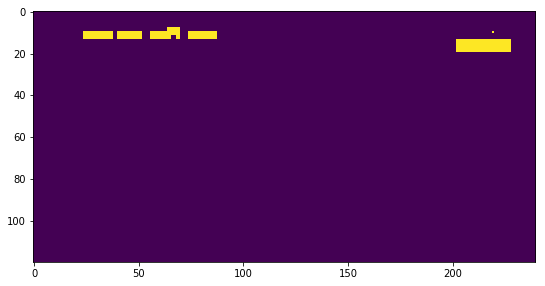

0.3 185 0.3


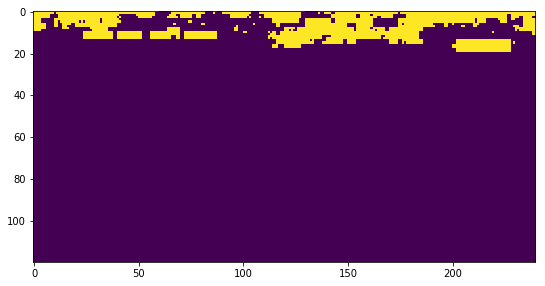

0.3 189 0.15


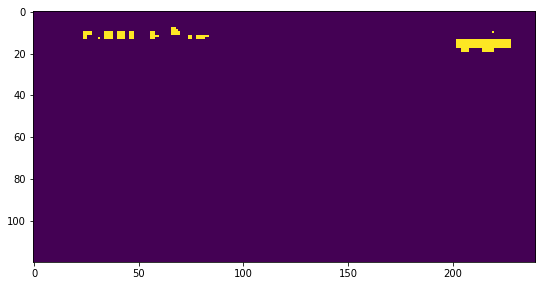

0.3 189 0.18


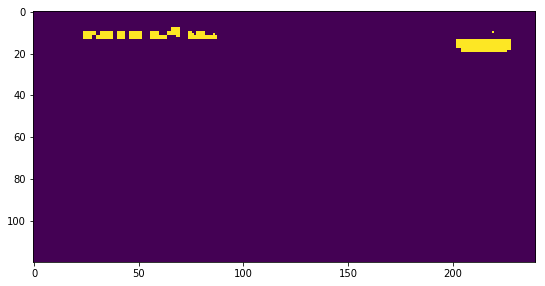

0.3 189 0.2


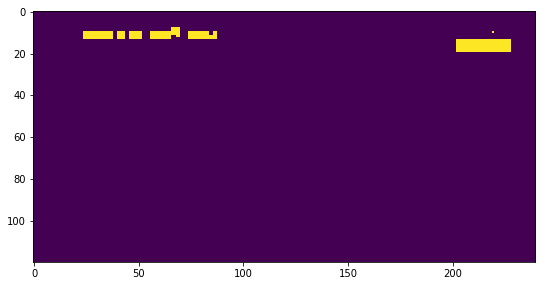

0.3 189 0.25


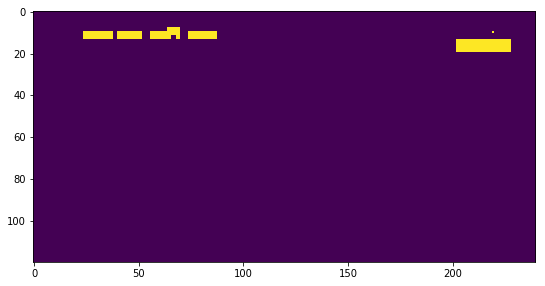

0.3 189 0.3


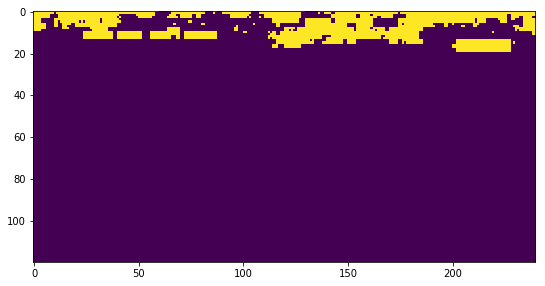

0.3 193 0.15


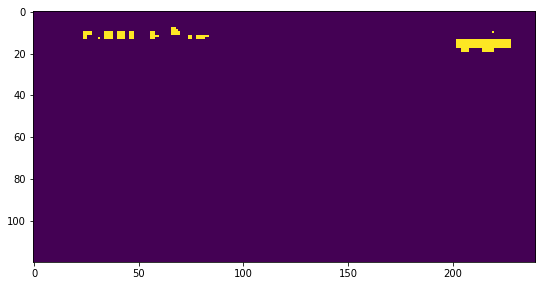

0.3 193 0.18


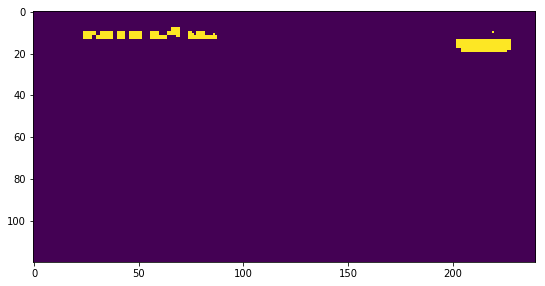

0.3 193 0.2


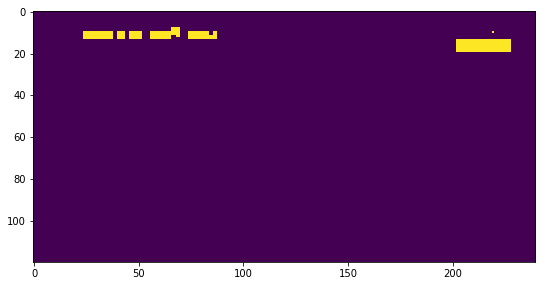

0.3 193 0.25


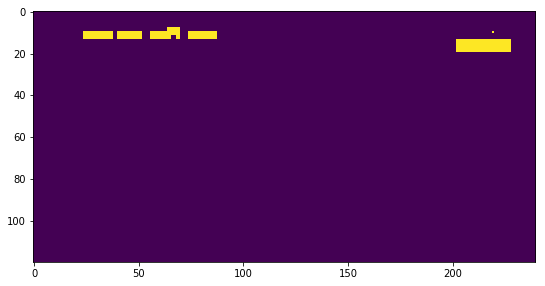

0.3 193 0.3


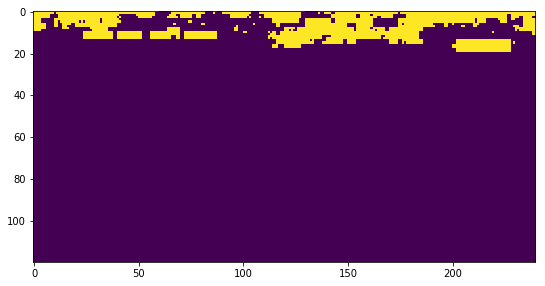

0.3 197 0.15


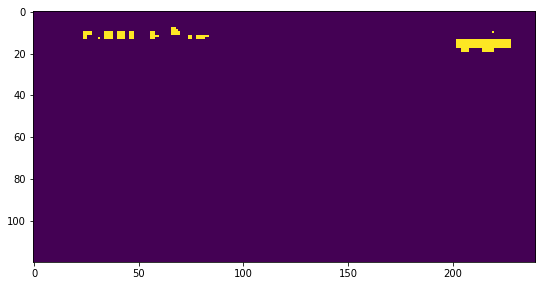

0.3 197 0.18


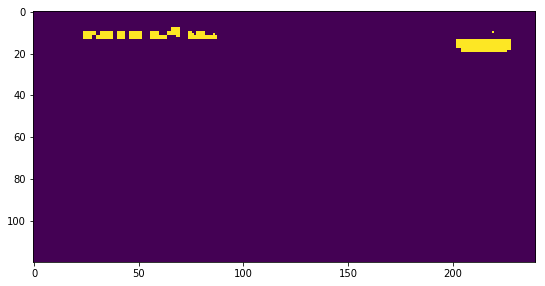

0.3 197 0.2


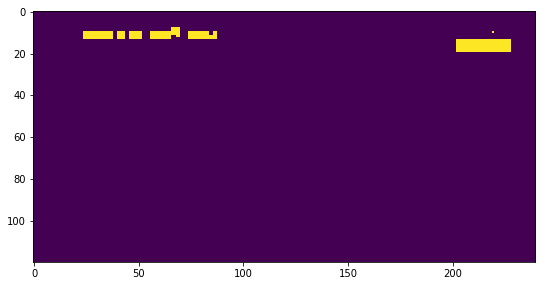

0.3 197 0.25


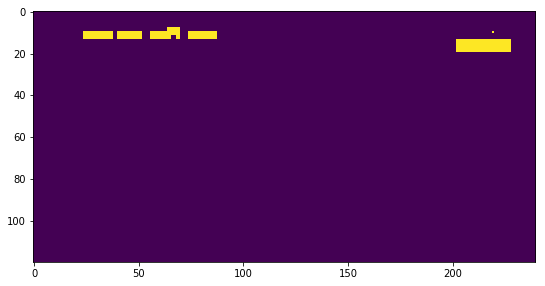

0.3 197 0.3


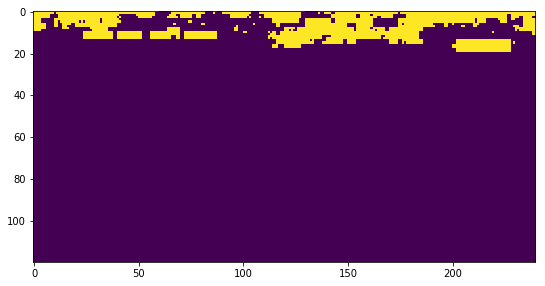

0.3 201 0.15


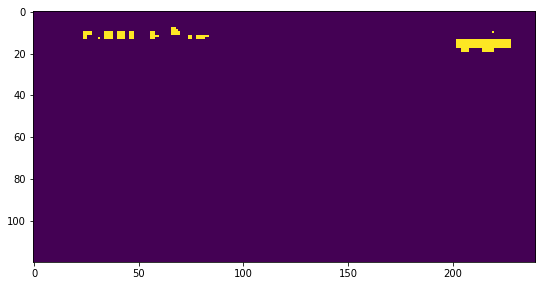

0.3 201 0.18


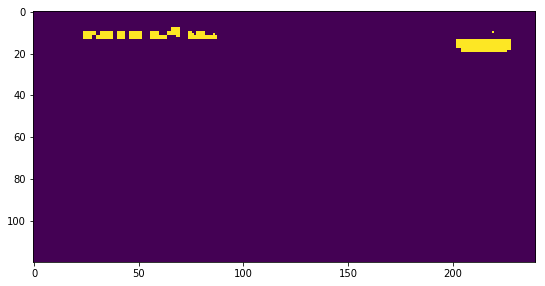

0.3 201 0.2


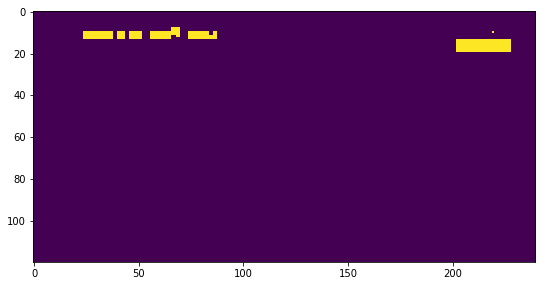

0.3 201 0.25


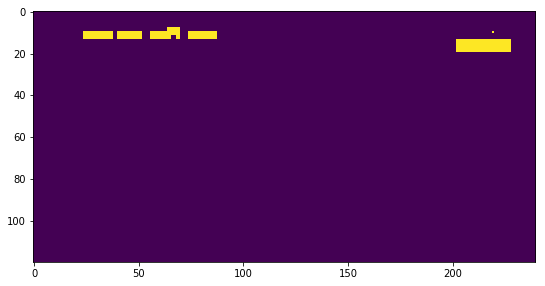

0.3 201 0.3


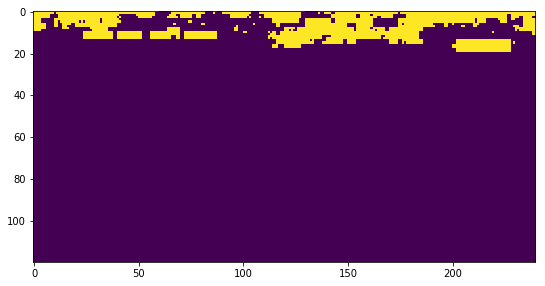

0.3 205 0.15


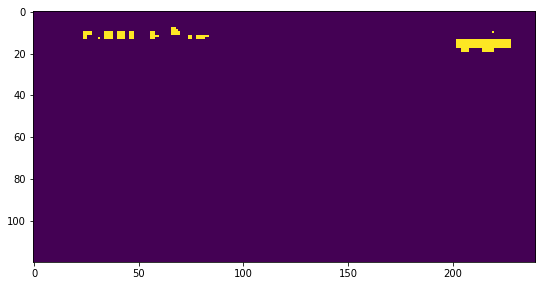

0.3 205 0.18


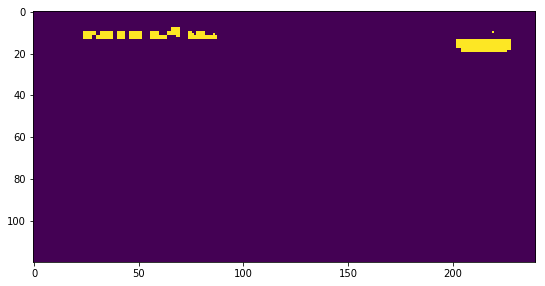

0.3 205 0.2


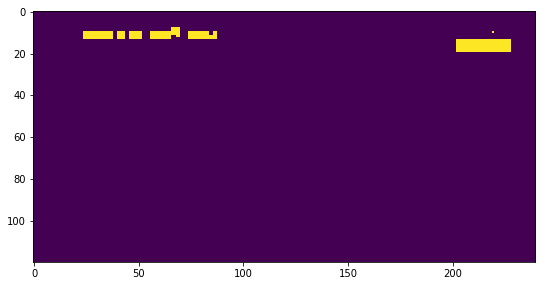

0.3 205 0.25


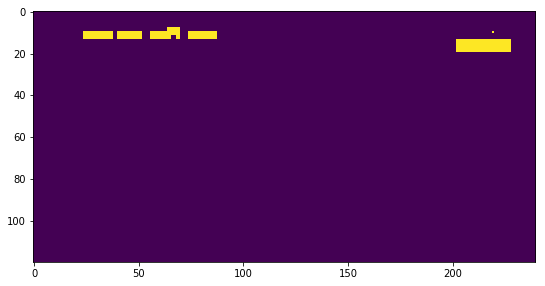

0.3 205 0.3


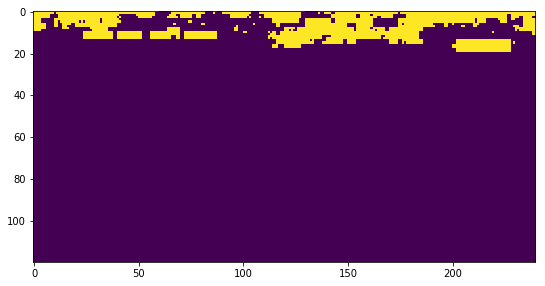

0.3 209 0.15


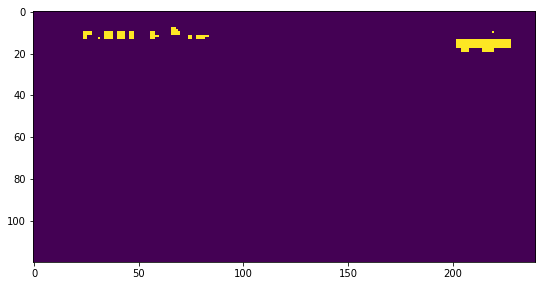

0.3 209 0.18


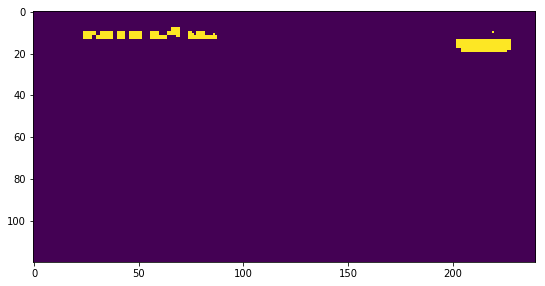

0.3 209 0.2


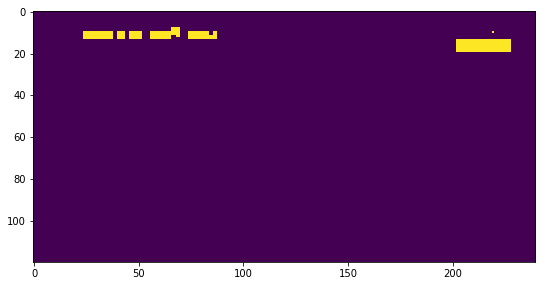

0.3 209 0.25


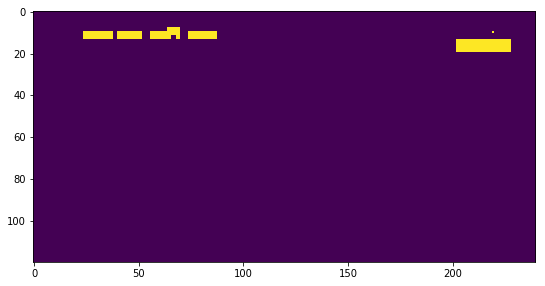

0.3 209 0.3


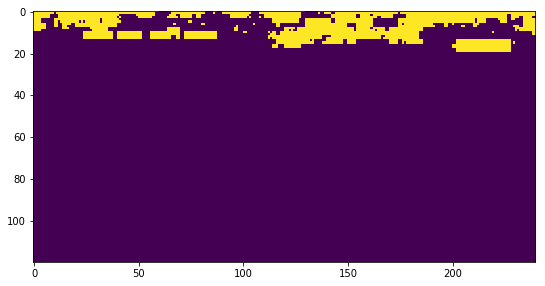

0.3 213 0.15


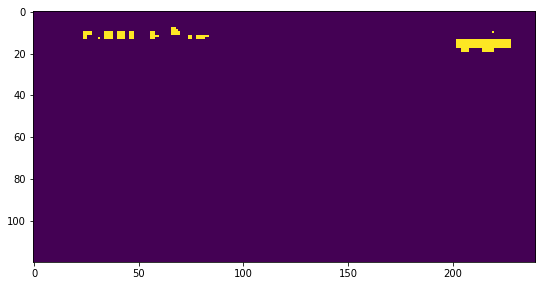

0.3 213 0.18


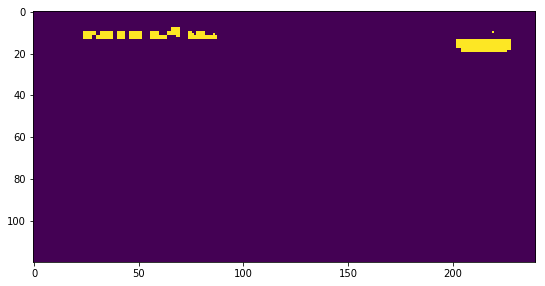

0.3 213 0.2


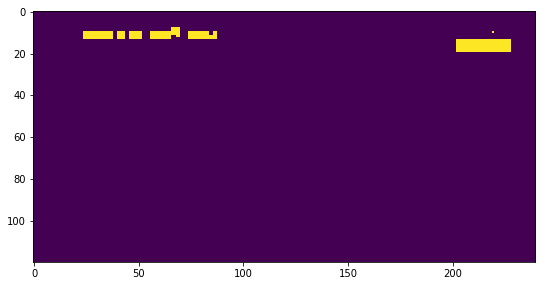

0.3 213 0.25


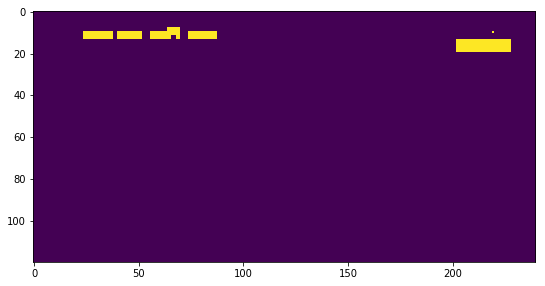

0.3 213 0.3


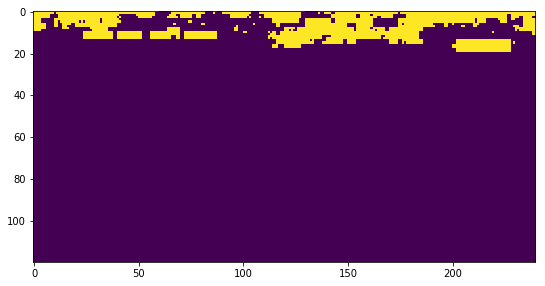

0.3 217 0.15


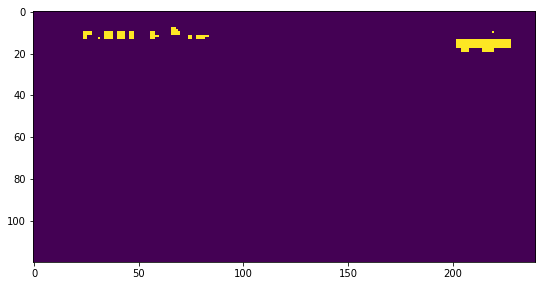

0.3 217 0.18


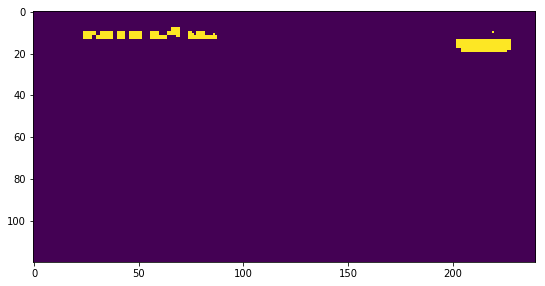

0.3 217 0.2


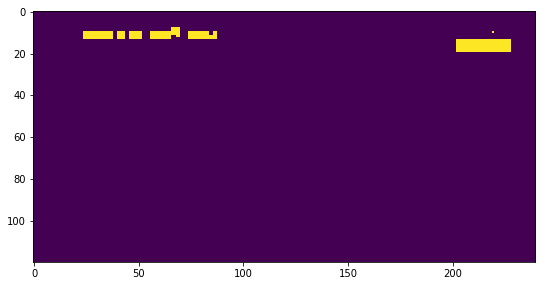

0.3 217 0.25


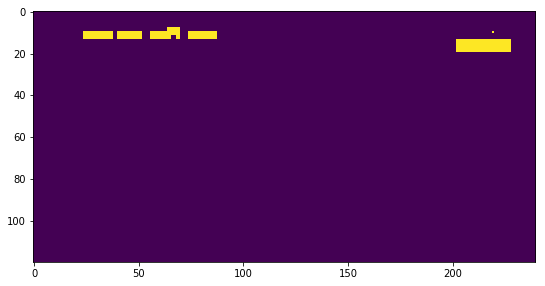

0.3 217 0.3


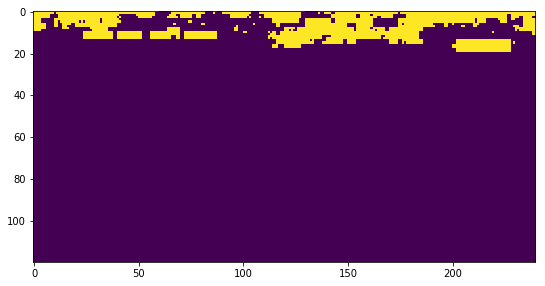

0.3 221 0.15


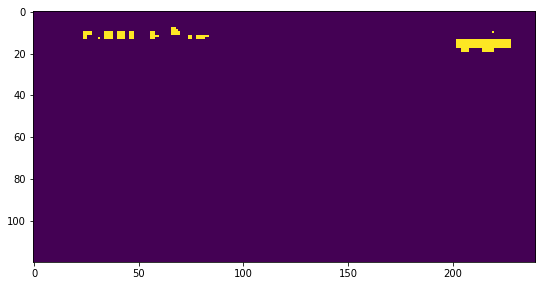

0.3 221 0.18


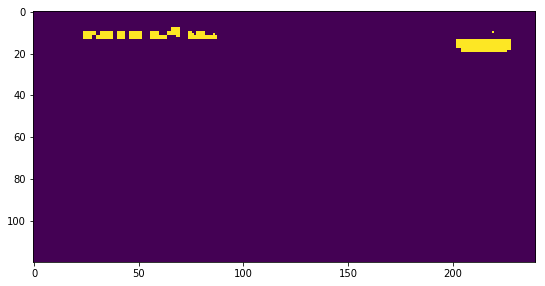

0.3 221 0.2


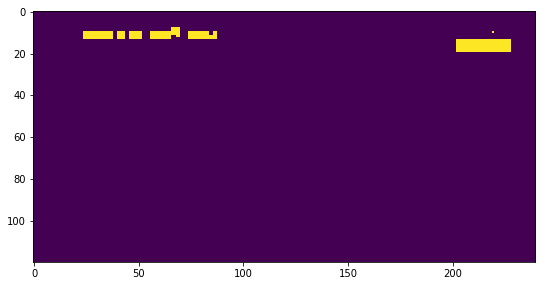

0.3 221 0.25


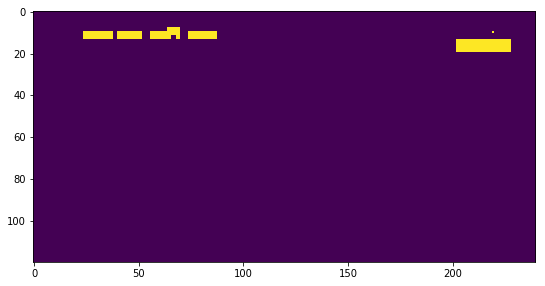

0.3 221 0.3


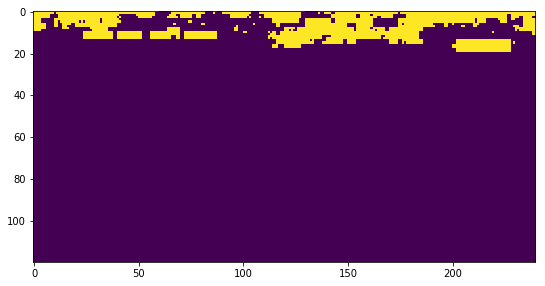

0.3 225 0.15


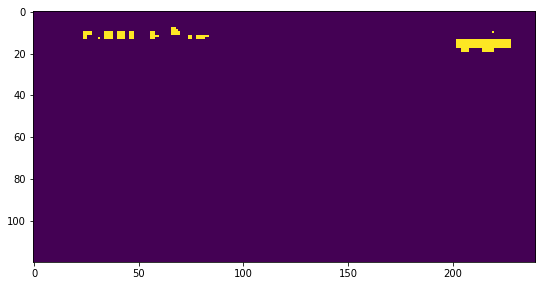

0.3 225 0.18


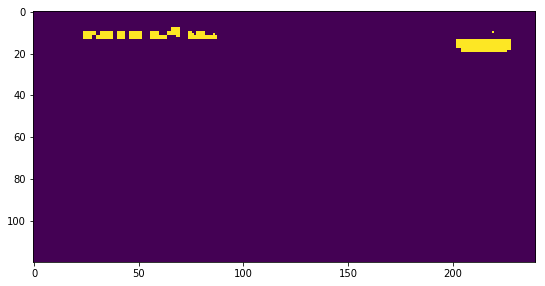

0.3 225 0.2


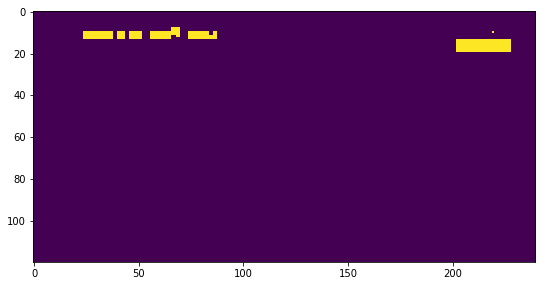

0.3 225 0.25


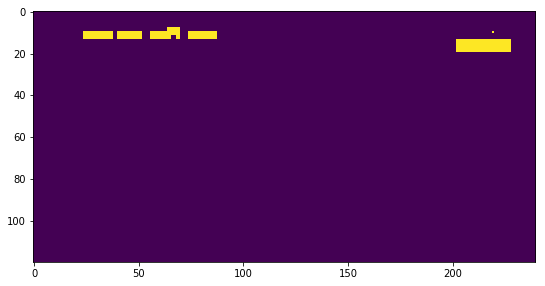

0.3 225 0.3


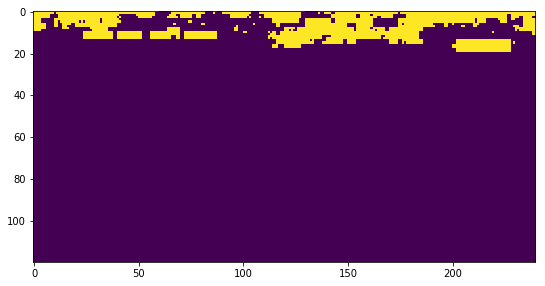

0.3 229 0.15


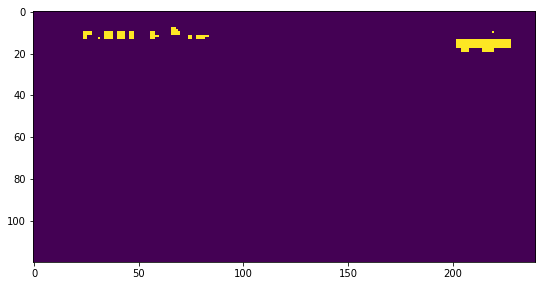

0.3 229 0.18


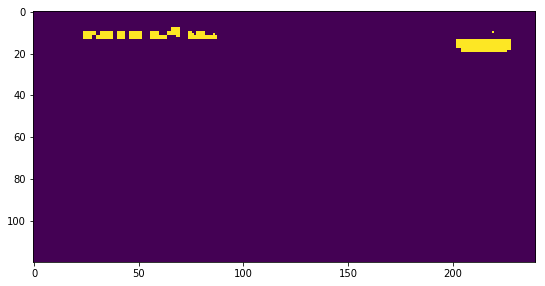

0.3 229 0.2


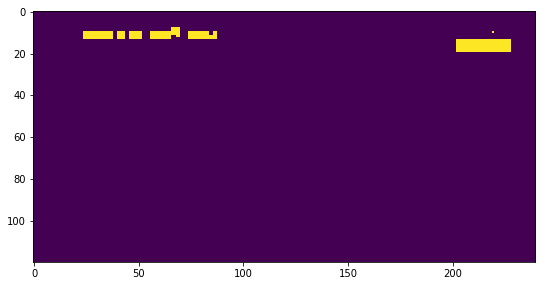

0.3 229 0.25


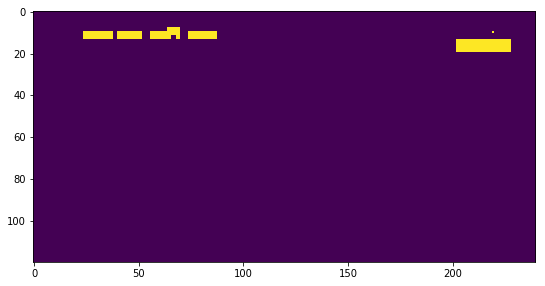

0.3 229 0.3


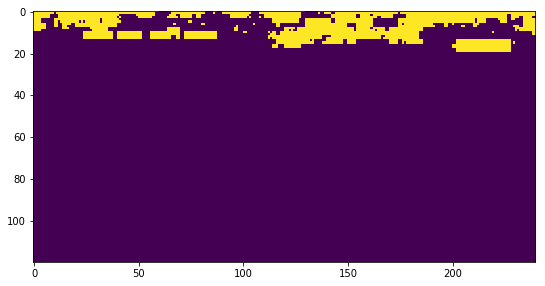

0.3 233 0.15


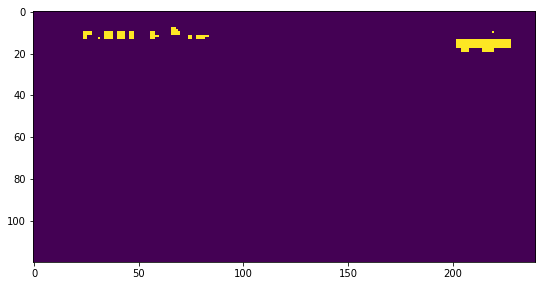

0.3 233 0.18


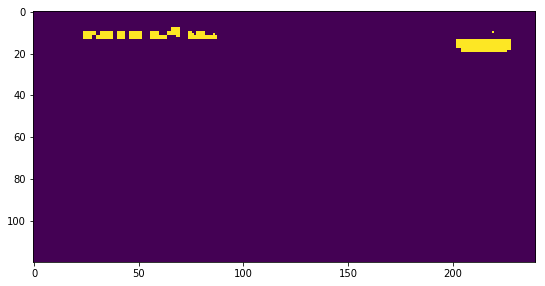

0.3 233 0.2


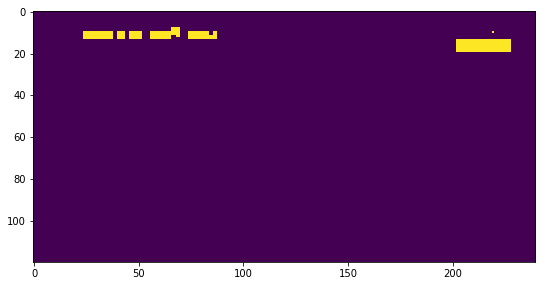

0.3 233 0.25


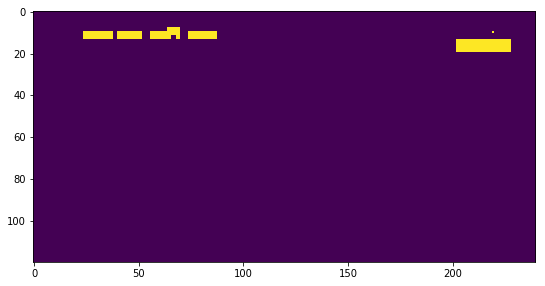

0.3 233 0.3


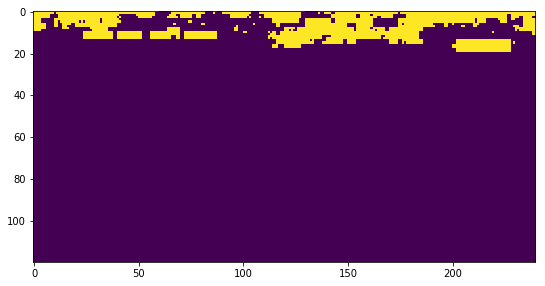

0.3 237 0.15


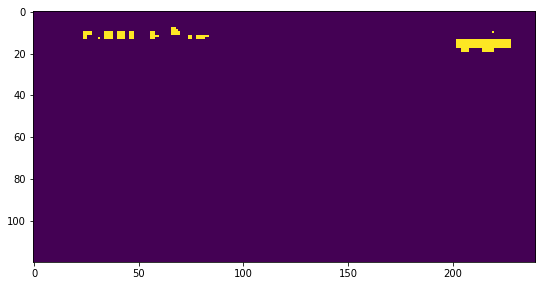

0.3 237 0.18


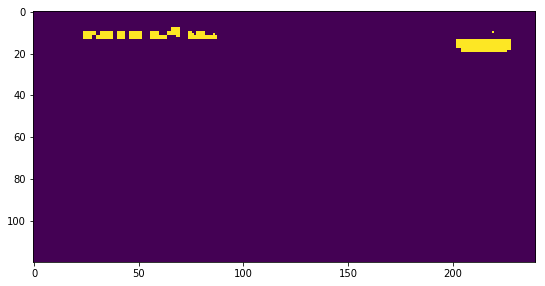

0.3 237 0.2


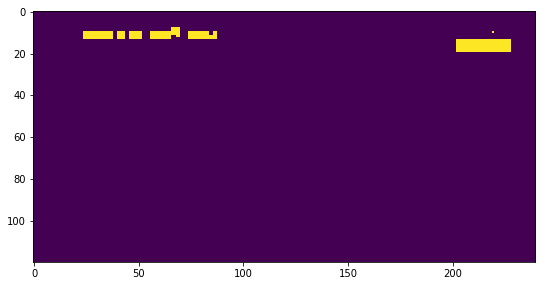

0.3 237 0.25


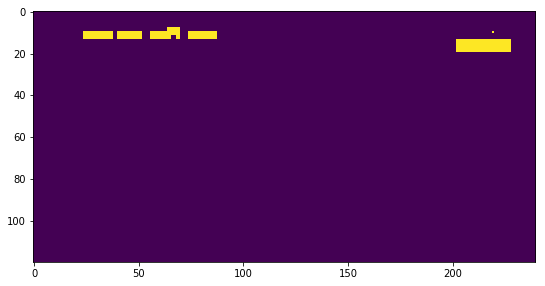

0.3 237 0.3


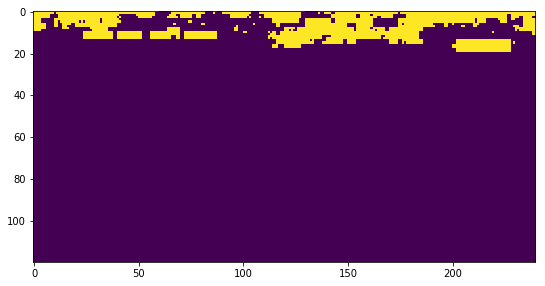

0.3 241 0.15


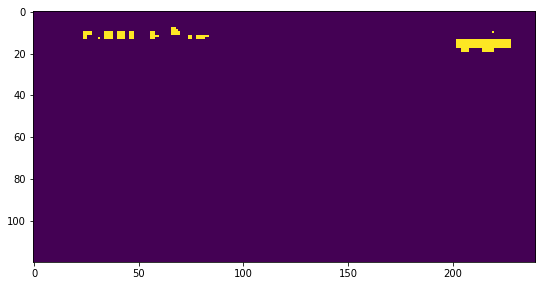

0.3 241 0.18


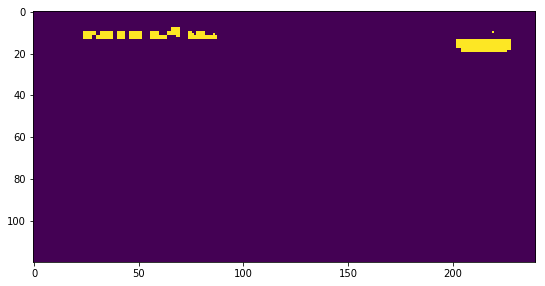

0.3 241 0.2


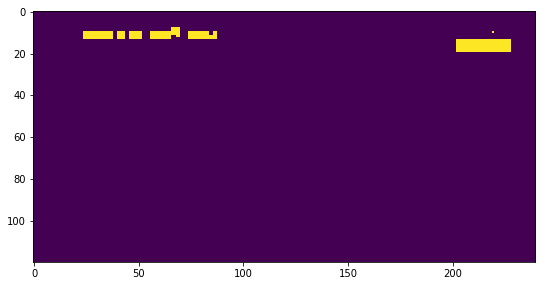

0.3 241 0.25


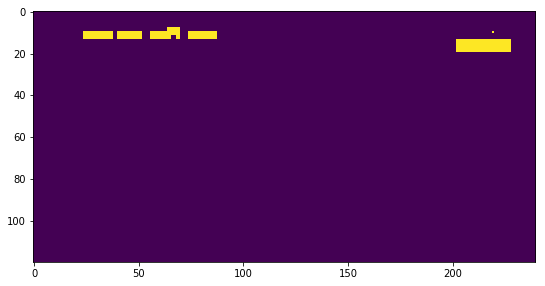

0.3 241 0.3


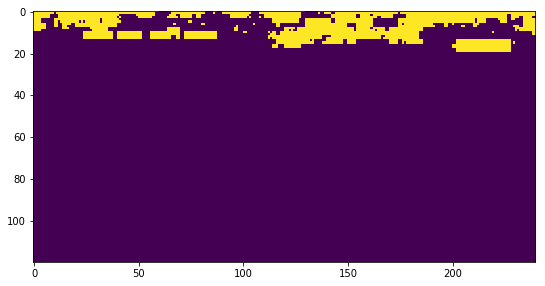

0.3 245 0.15


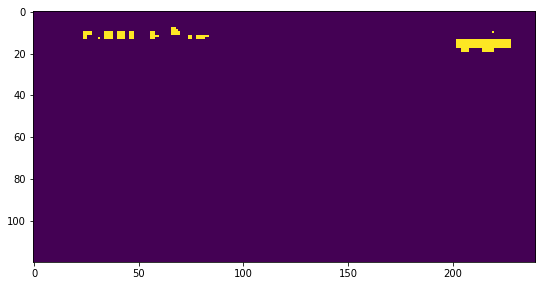

0.3 245 0.18


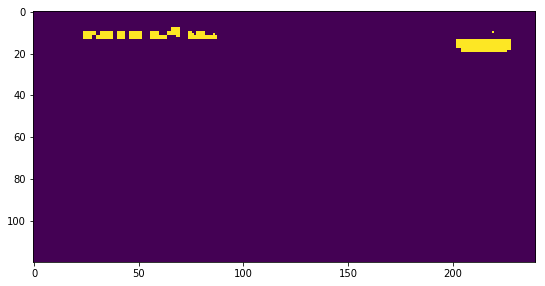

0.3 245 0.2


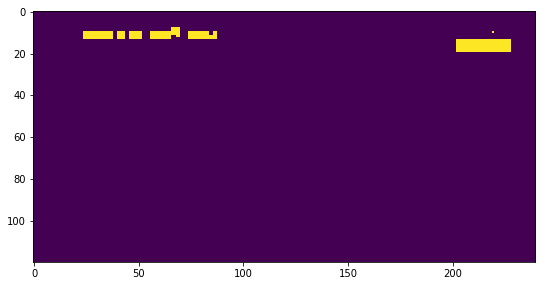

0.3 245 0.25


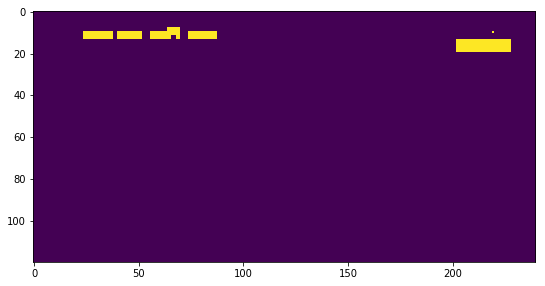

0.3 245 0.3


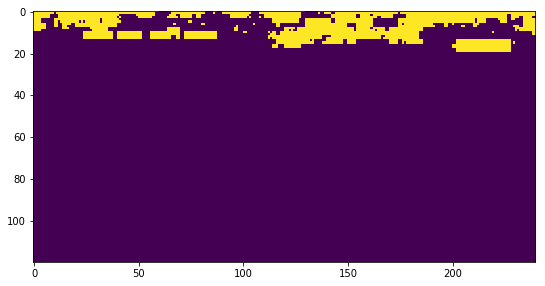

0.3 249 0.15


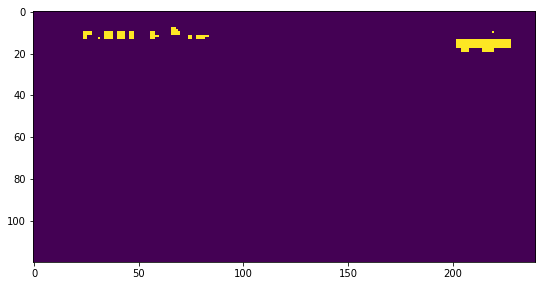

0.3 249 0.18


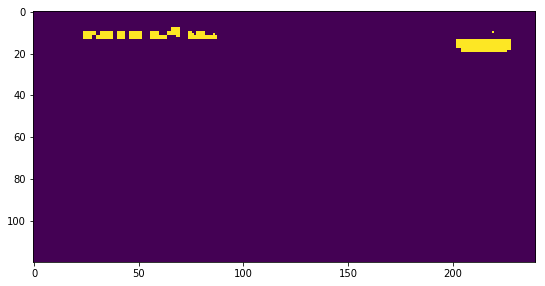

0.3 249 0.2


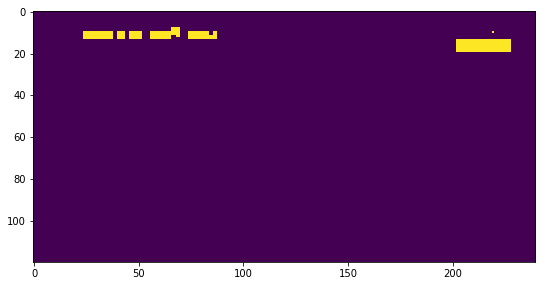

0.3 249 0.25


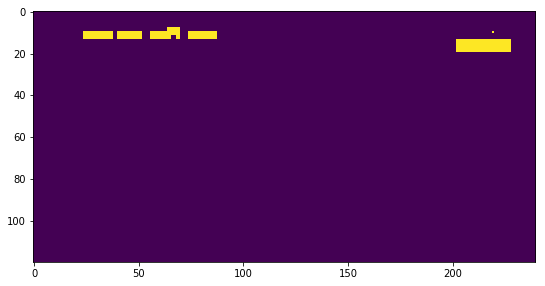

0.3 249 0.3


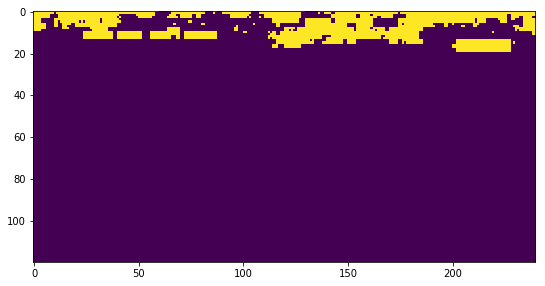

0.3 253 0.15


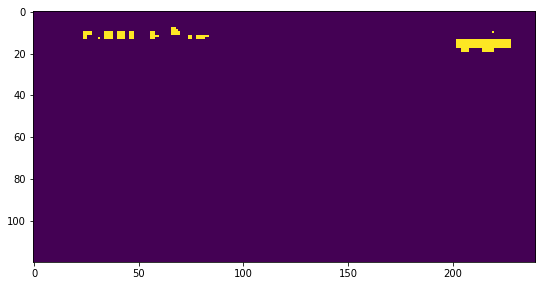

0.3 253 0.18


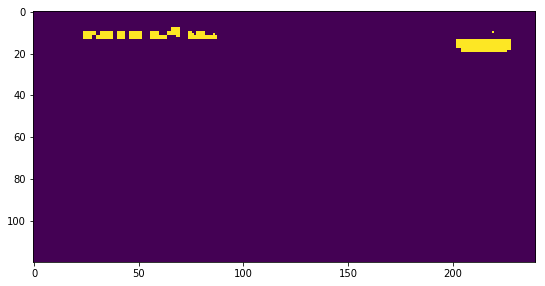

0.3 253 0.2


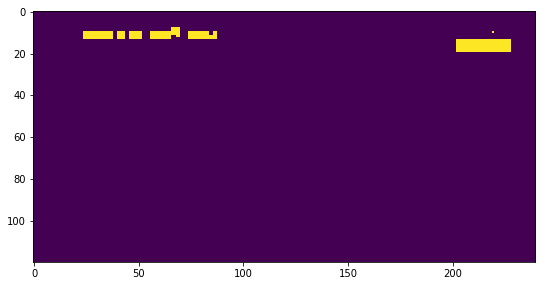

0.3 253 0.25


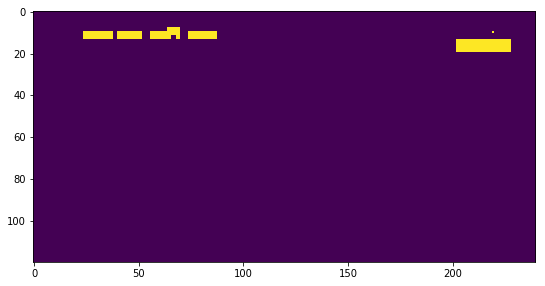

0.3 253 0.3


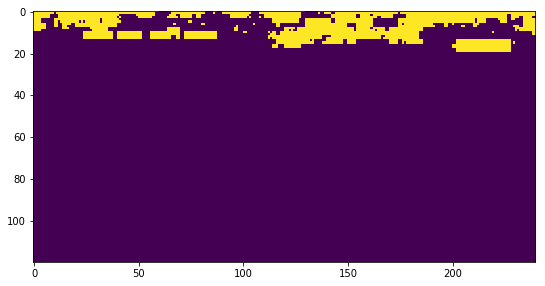

0.3 257 0.15


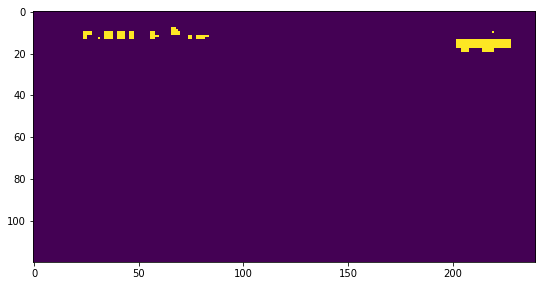

0.3 257 0.18


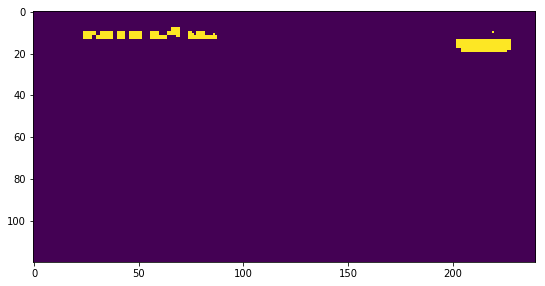

0.3 257 0.2


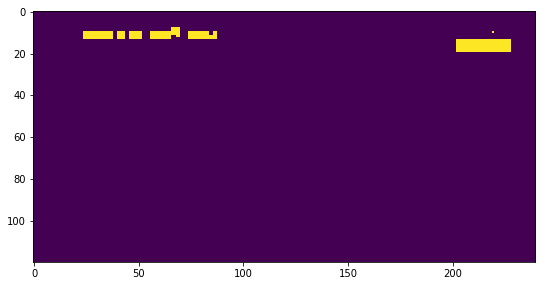

0.3 257 0.25


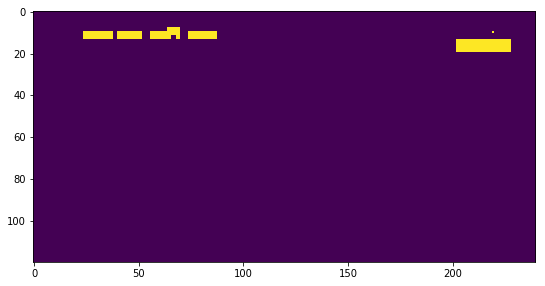

0.3 257 0.3


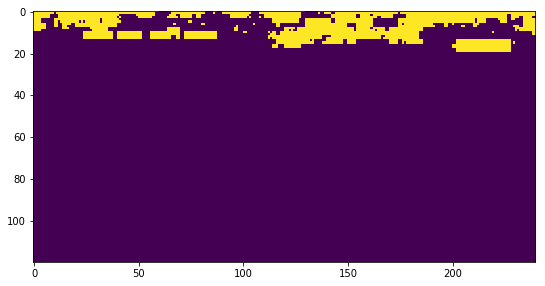

0.3 261 0.15


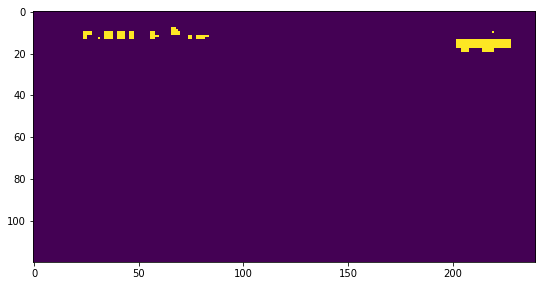

0.3 261 0.18


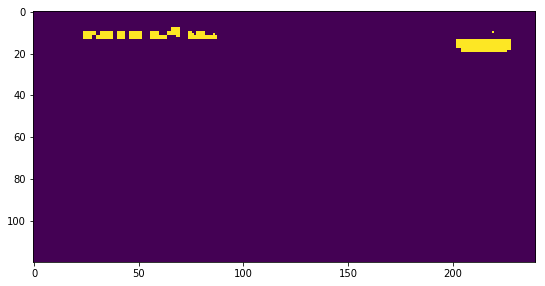

0.3 261 0.2


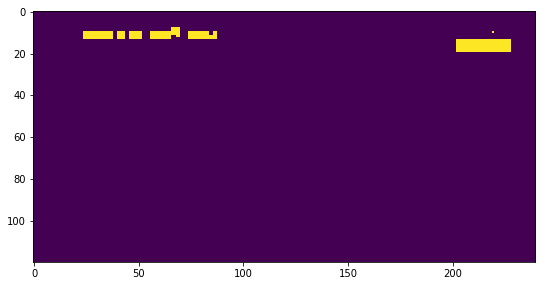

0.3 261 0.25


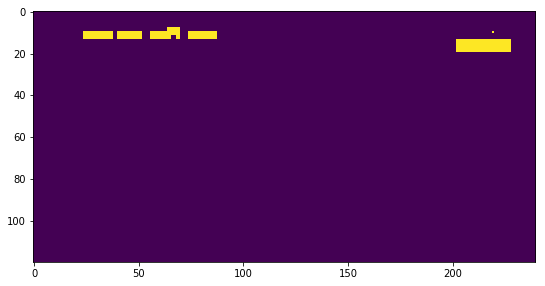

0.3 261 0.3


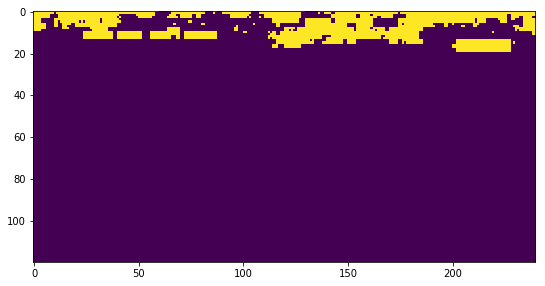

0.3 265 0.15


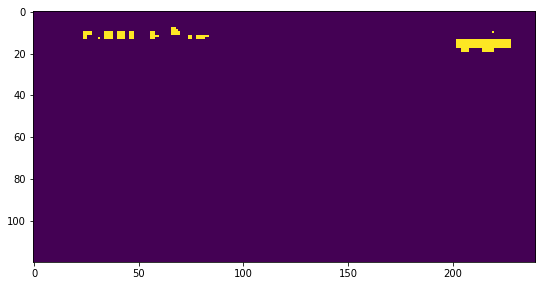

0.3 265 0.18


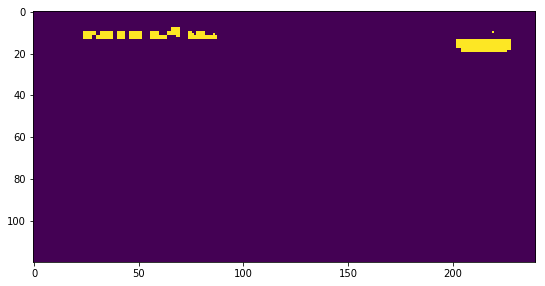

0.3 265 0.2


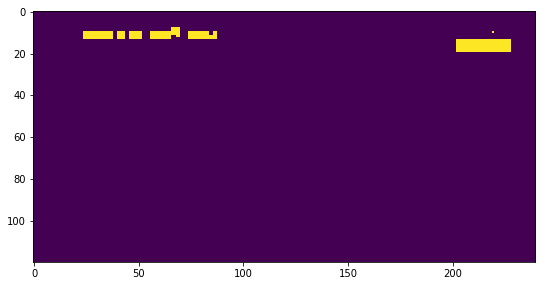

0.3 265 0.25


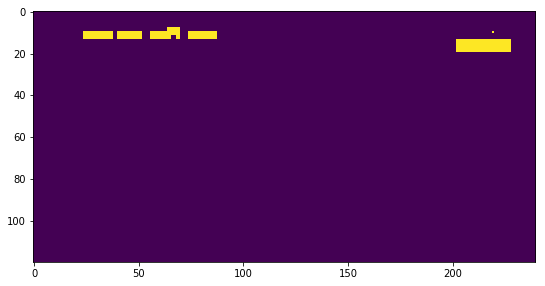

0.3 265 0.3


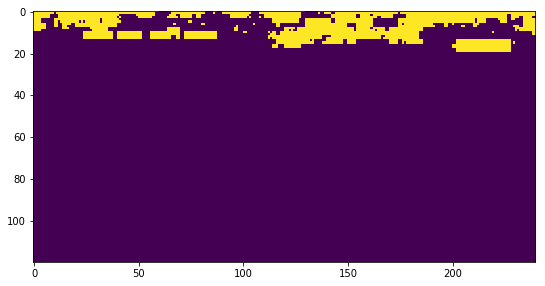

0.3 269 0.15


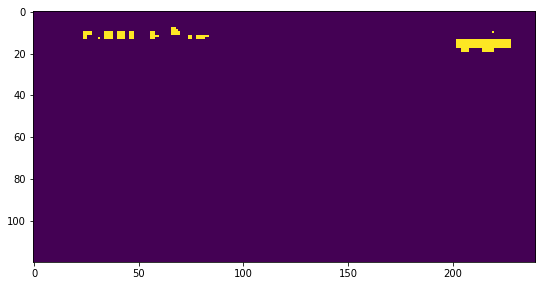

0.3 269 0.18


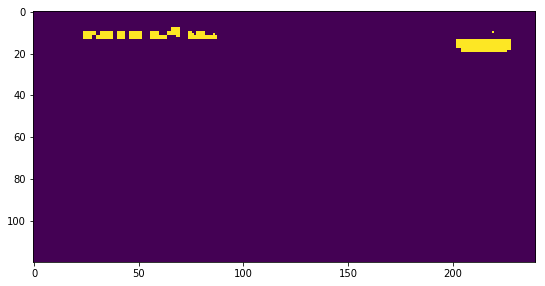

0.3 269 0.2


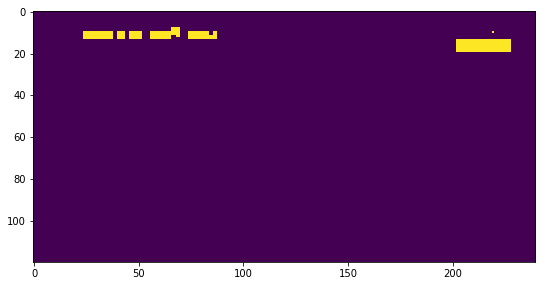

0.3 269 0.25


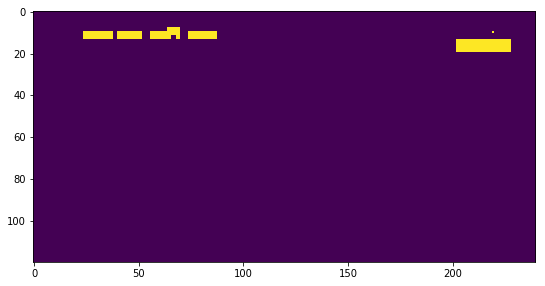

0.3 269 0.3


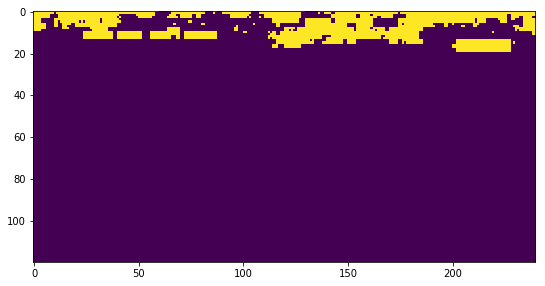

0.3 273 0.15


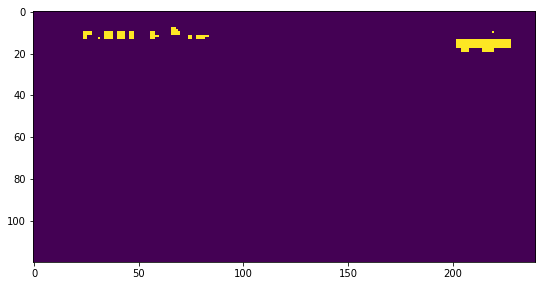

0.3 273 0.18


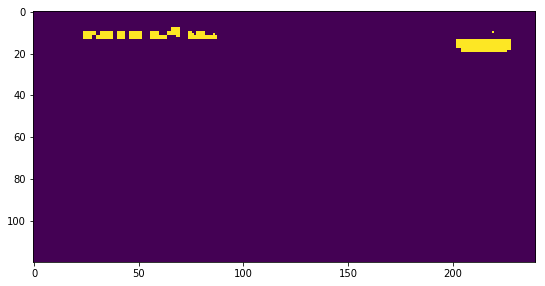

0.3 273 0.2


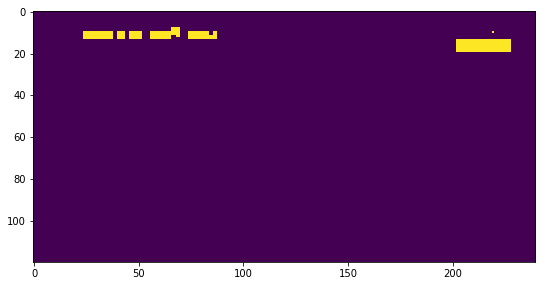

0.3 273 0.25


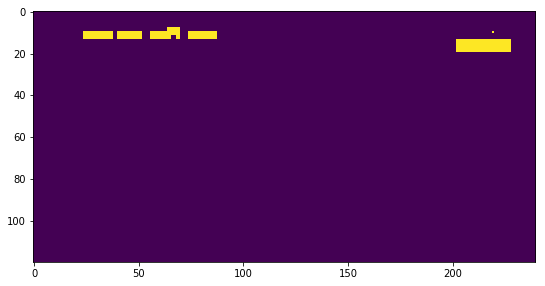

0.3 273 0.3


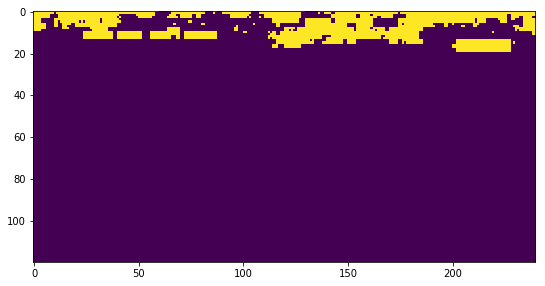

0.3 277 0.15


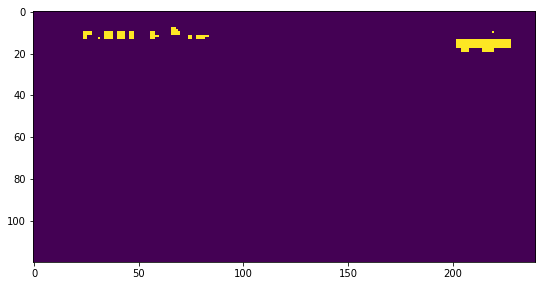

0.3 277 0.18


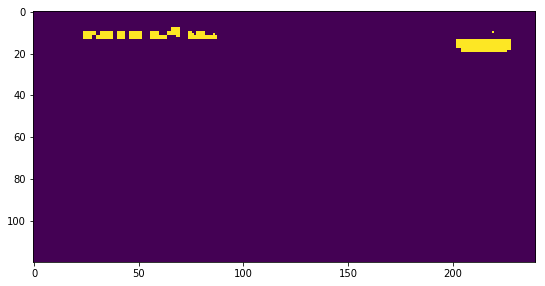

0.3 277 0.2


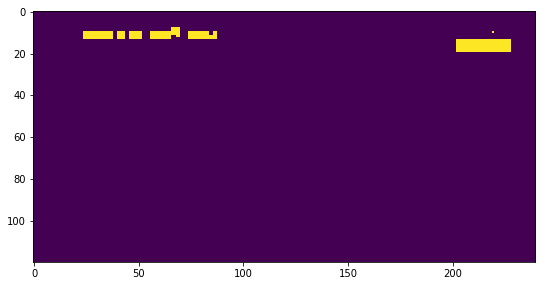

0.3 277 0.25


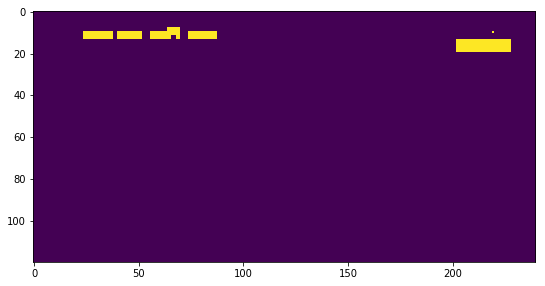

0.3 277 0.3


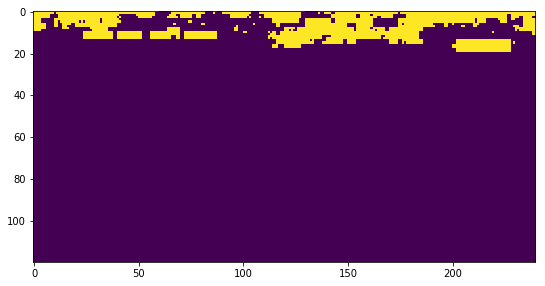

0.3 281 0.15


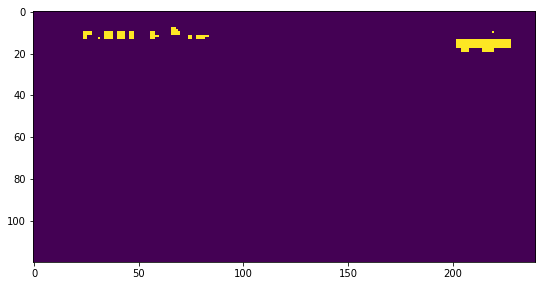

0.3 281 0.18


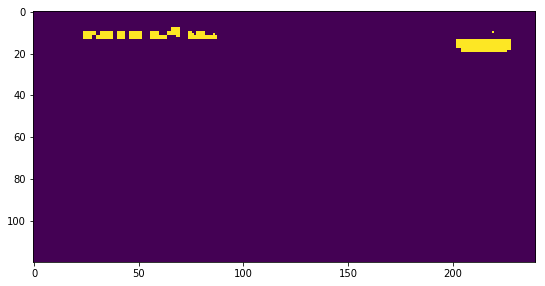

0.3 281 0.2


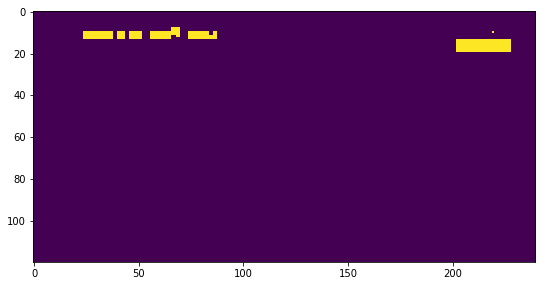

0.3 281 0.25


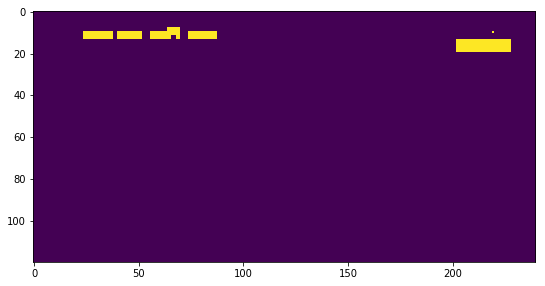

0.3 281 0.3


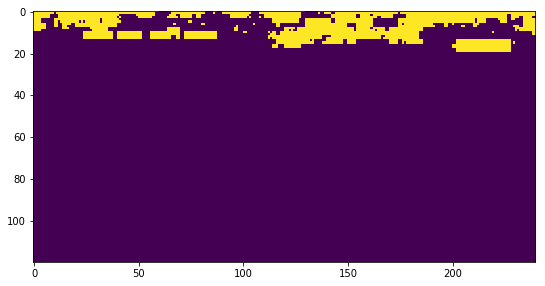

0.3 285 0.15


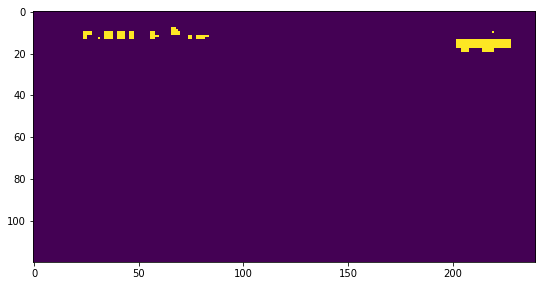

0.3 285 0.18


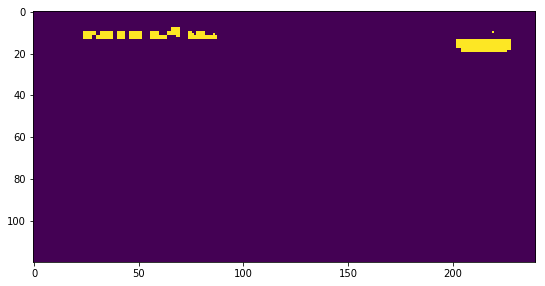

0.3 285 0.2


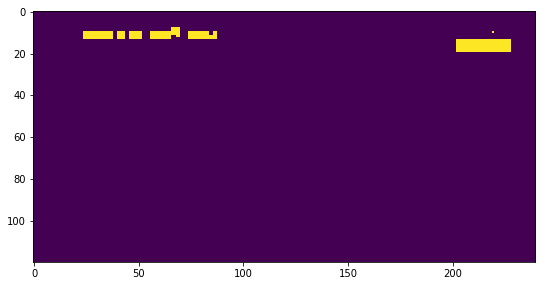

0.3 285 0.25


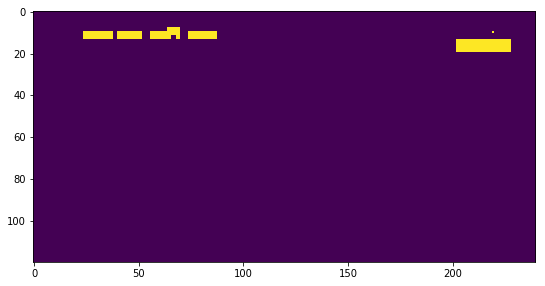

0.3 285 0.3


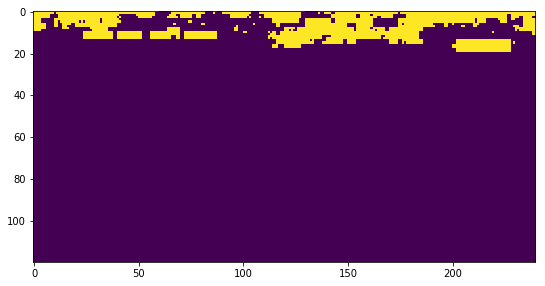

0.3 289 0.15


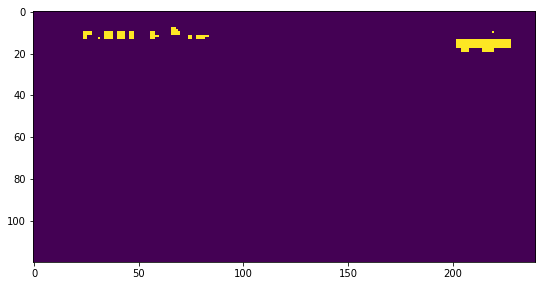

0.3 289 0.18


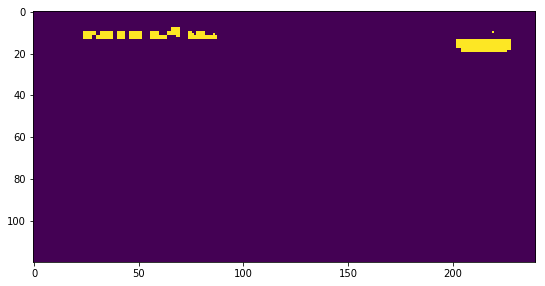

0.3 289 0.2


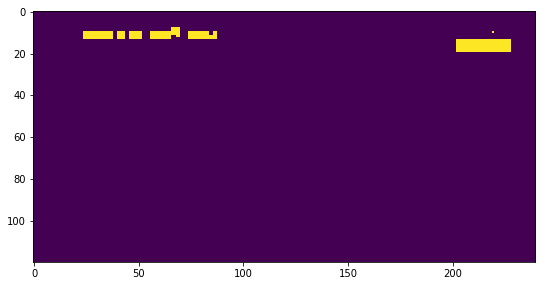

0.3 289 0.25


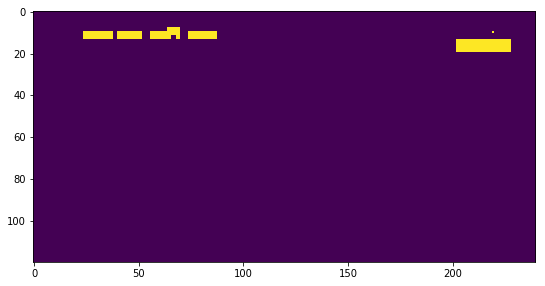

0.3 289 0.3


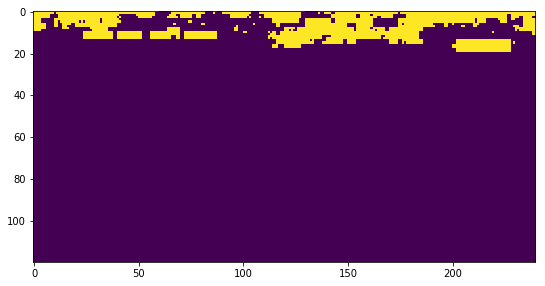

0.3 293 0.15


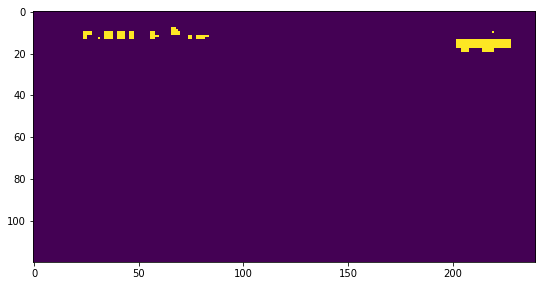

0.3 293 0.18


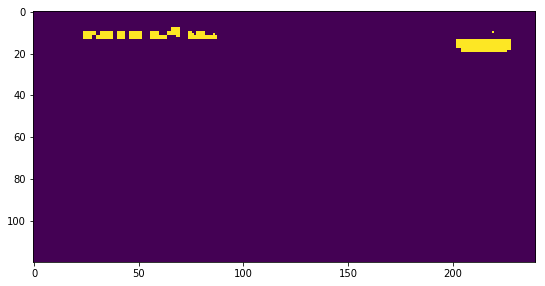

0.3 293 0.2


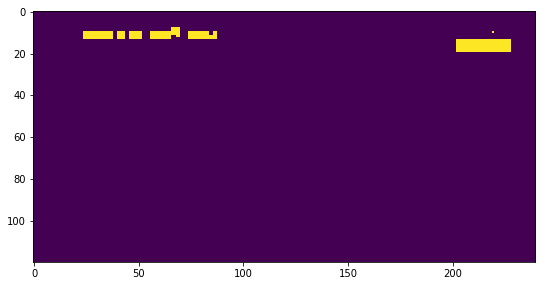

0.3 293 0.25


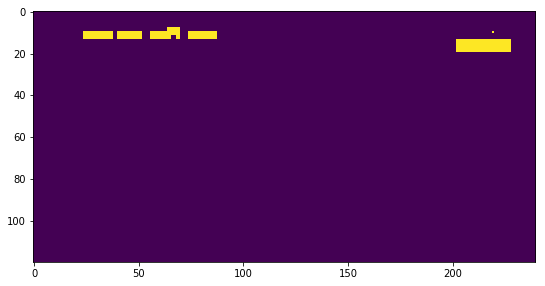

0.3 293 0.3


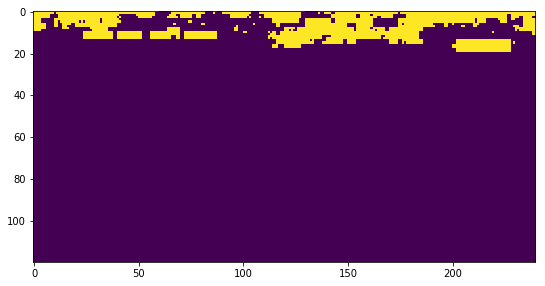

0.3 297 0.15


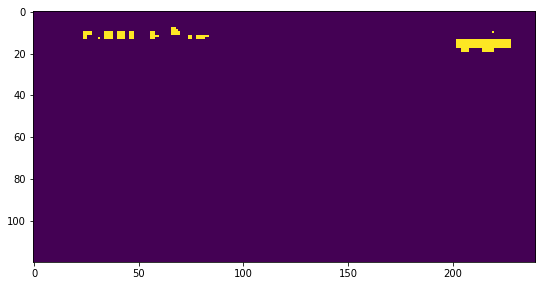

0.3 297 0.18


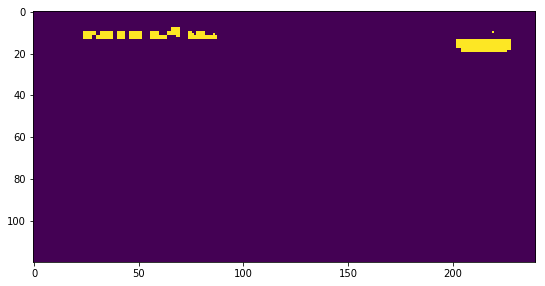

0.3 297 0.2


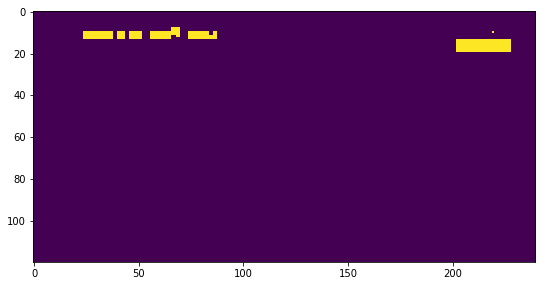

0.3 297 0.25


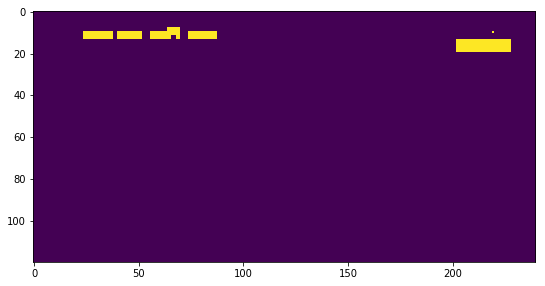

0.3 297 0.3


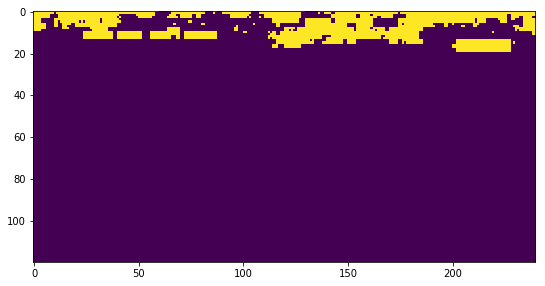

0.3 301 0.15


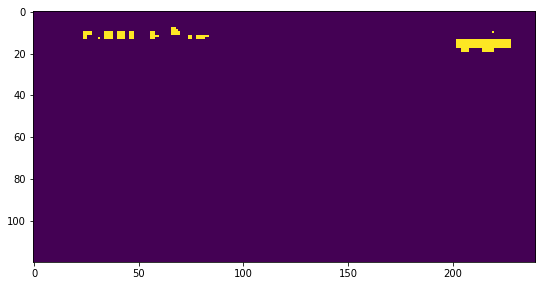

0.3 301 0.18


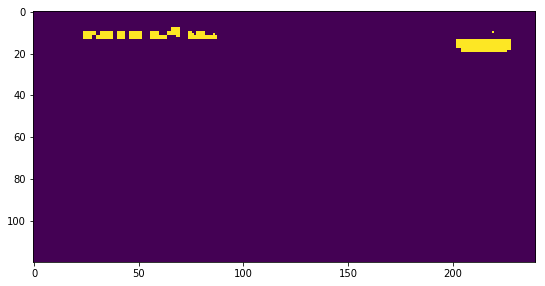

0.3 301 0.2


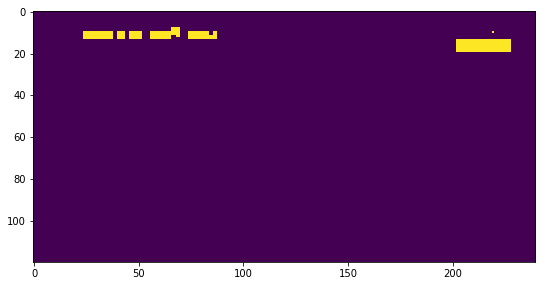

0.3 301 0.25


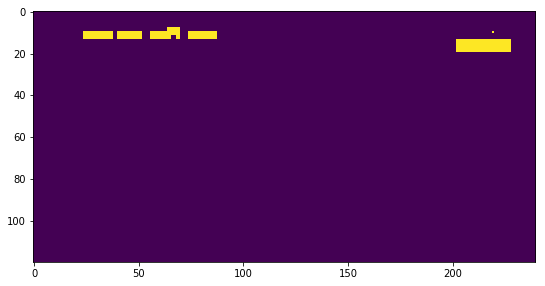

0.3 301 0.3


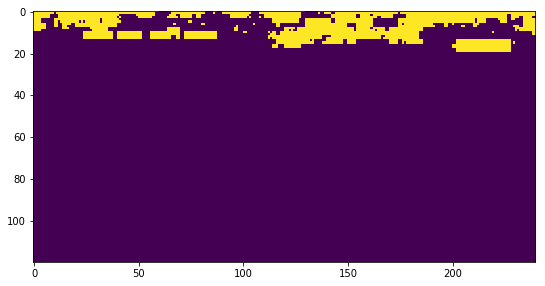

0.3 305 0.15


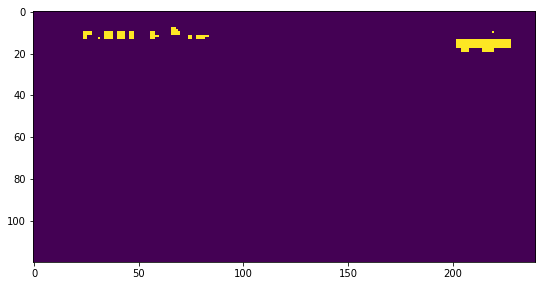

0.3 305 0.18


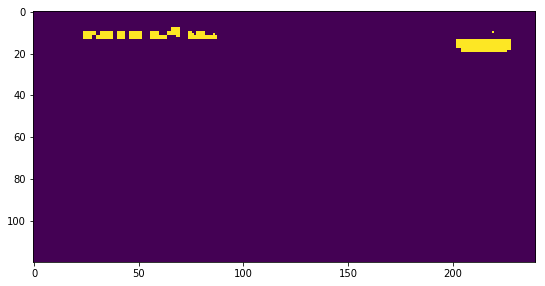

0.3 305 0.2


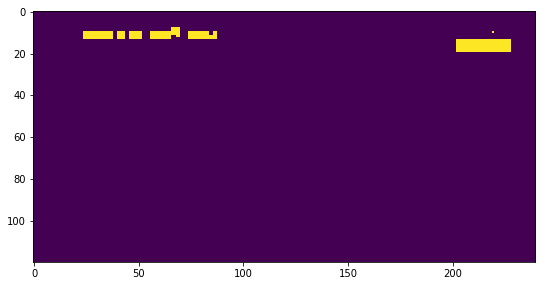

0.3 305 0.25


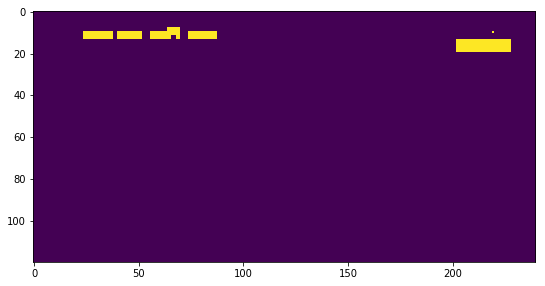

0.3 305 0.3


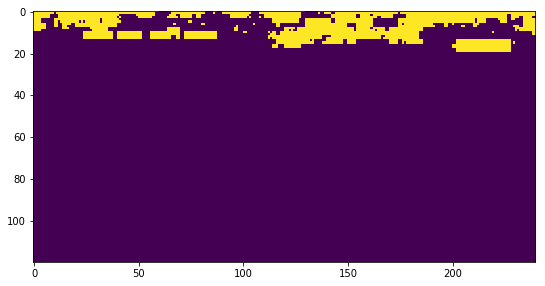

0.3 309 0.15


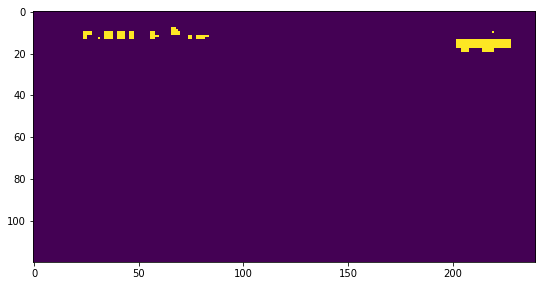

0.3 309 0.18


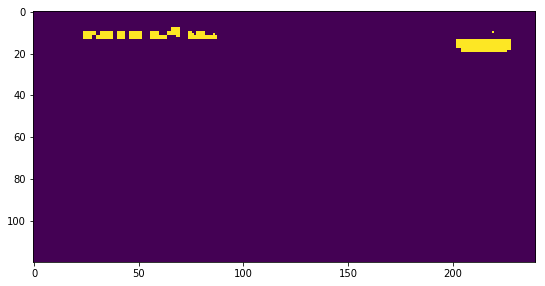

0.3 309 0.2


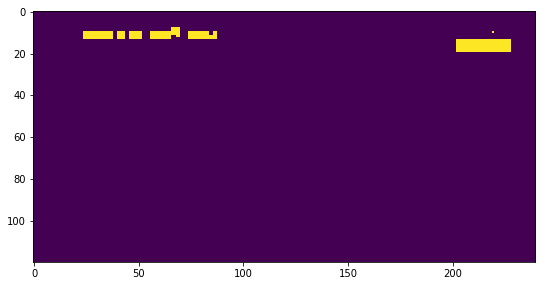

0.3 309 0.25


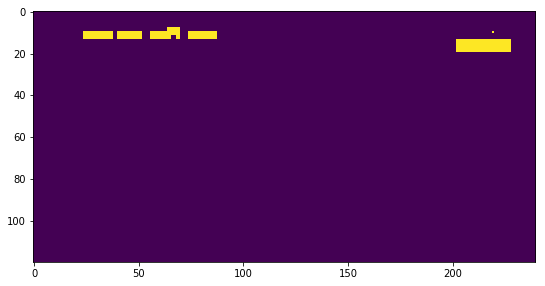

0.3 309 0.3


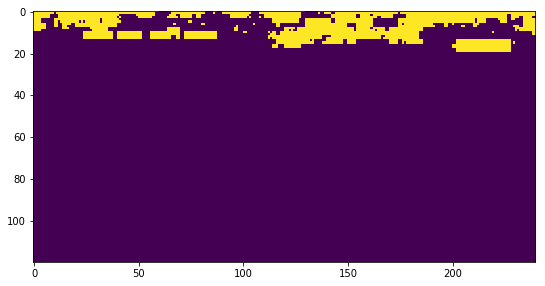

0.3 313 0.15


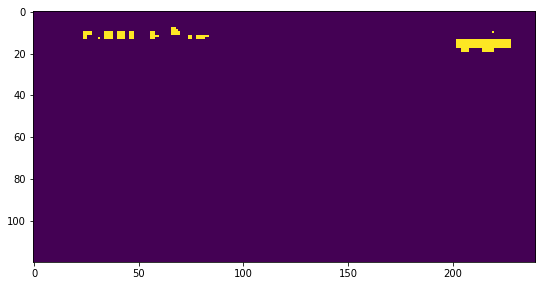

0.3 313 0.18


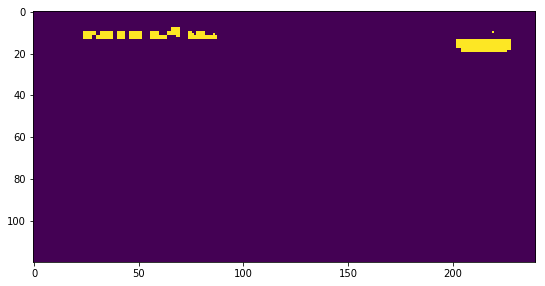

0.3 313 0.2


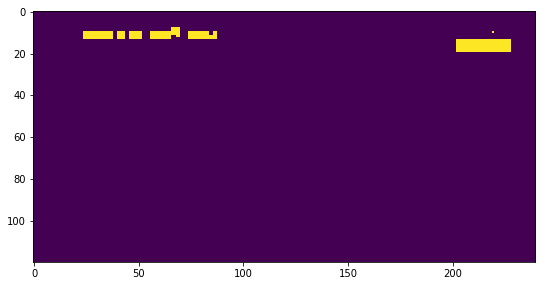

0.3 313 0.25


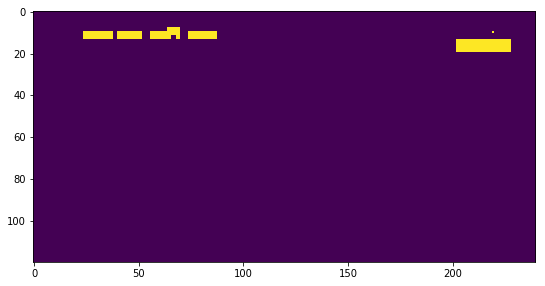

0.3 313 0.3


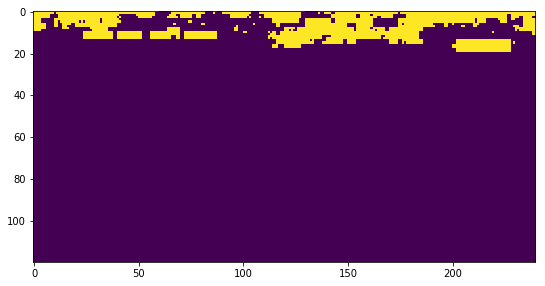

0.3 317 0.15


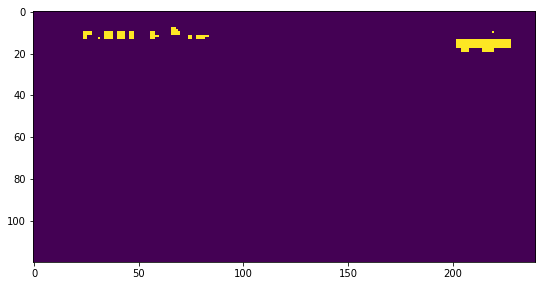

0.3 317 0.18


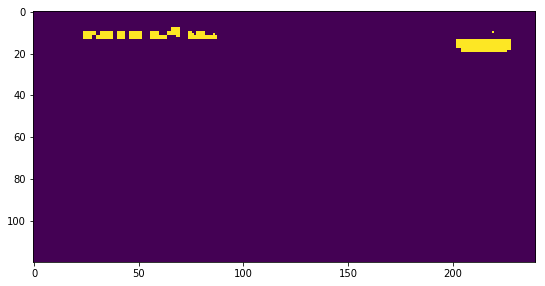

0.3 317 0.2


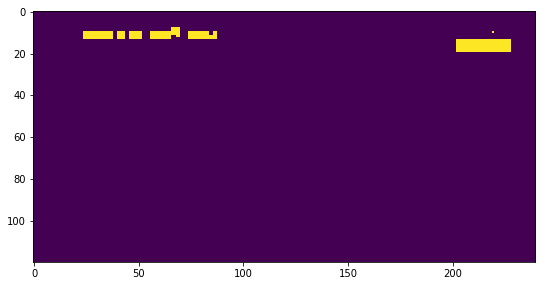

0.3 317 0.25


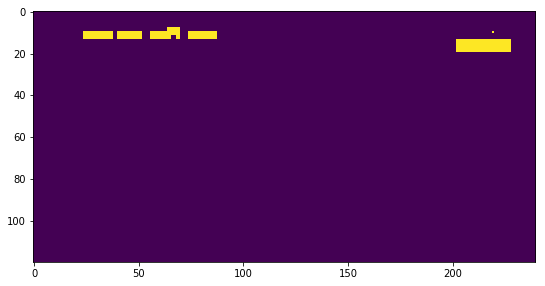

0.3 317 0.3


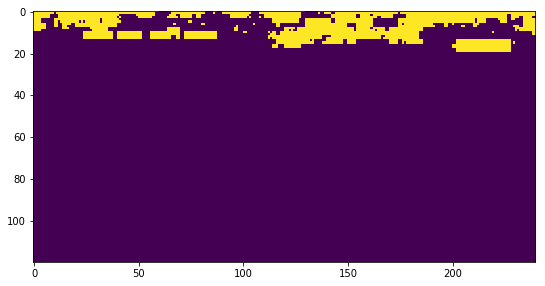

0.3 321 0.15


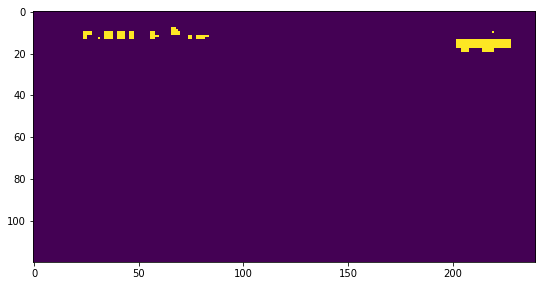

0.3 321 0.18


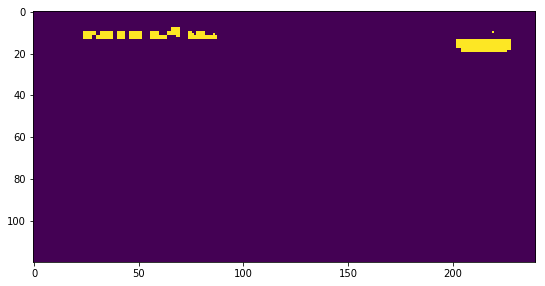

0.3 321 0.2


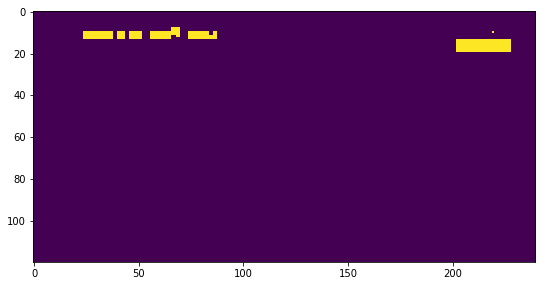

0.3 321 0.25


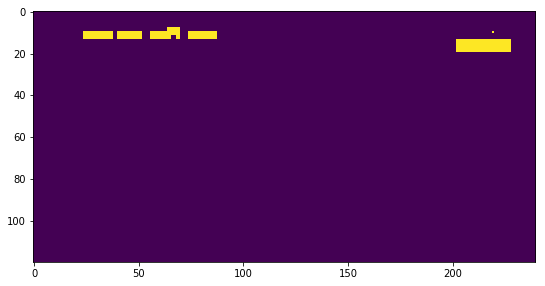

0.3 321 0.3


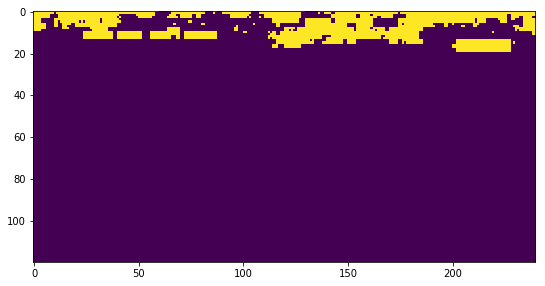

0.3 325 0.15


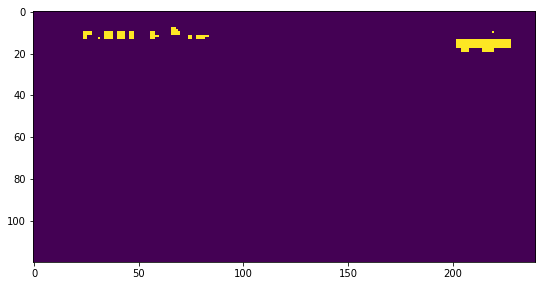

0.3 325 0.18


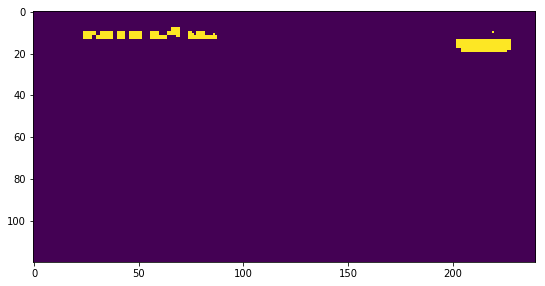

0.3 325 0.2


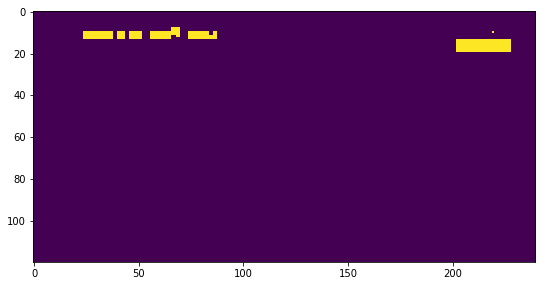

0.3 325 0.25


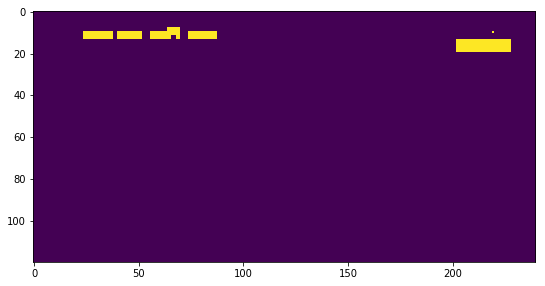

0.3 325 0.3


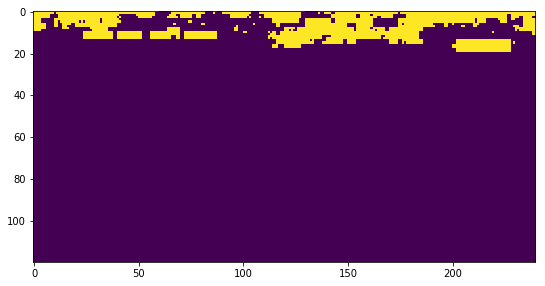

0.3 329 0.15


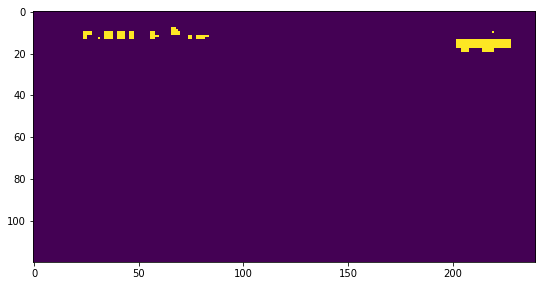

0.3 329 0.18


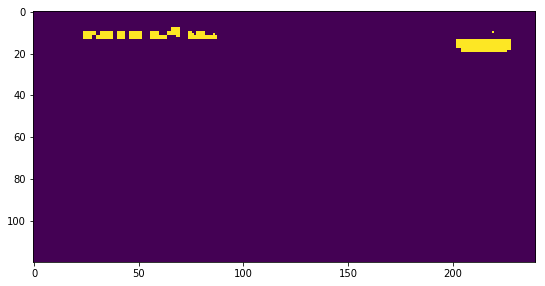

0.3 329 0.2


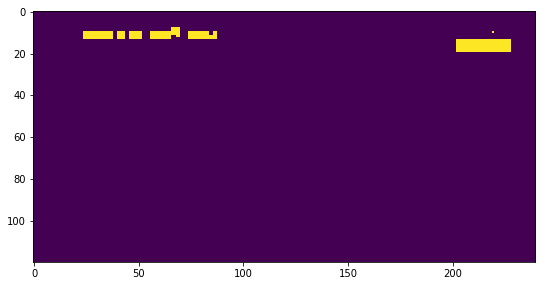

0.3 329 0.25


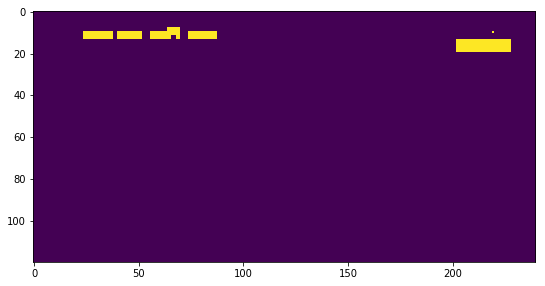

0.3 329 0.3


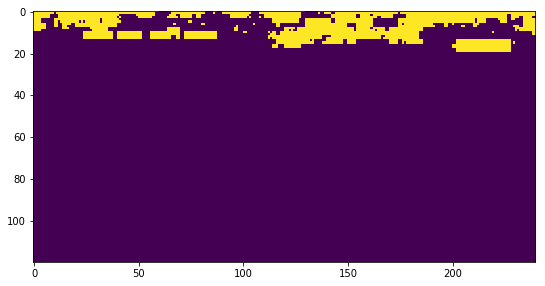

0.3 333 0.15


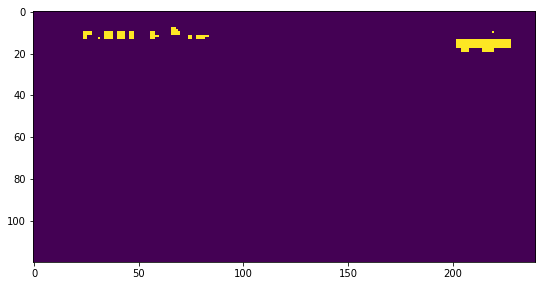

0.3 333 0.18


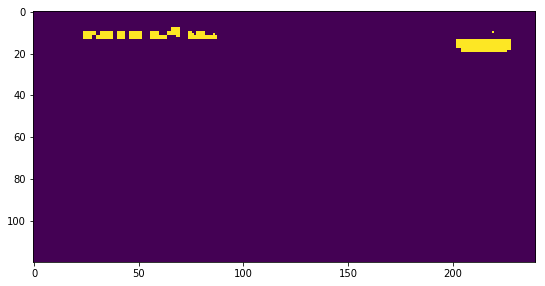

0.3 333 0.2


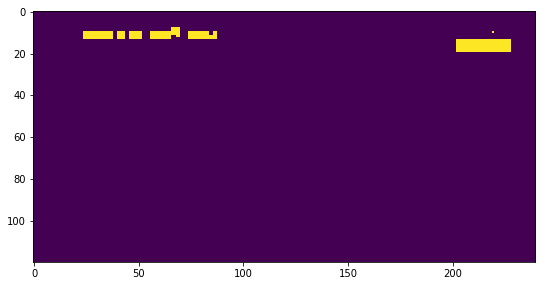

0.3 333 0.25


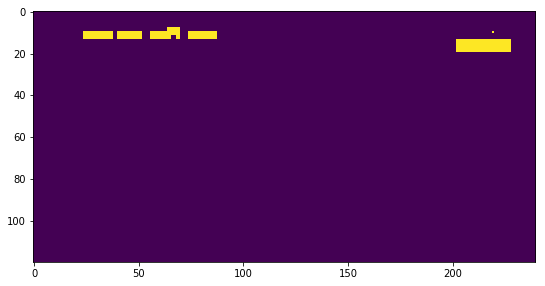

0.3 333 0.3


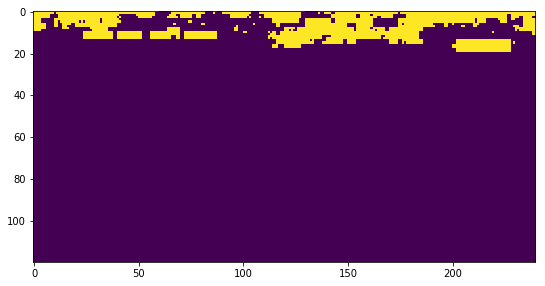

0.3 337 0.15


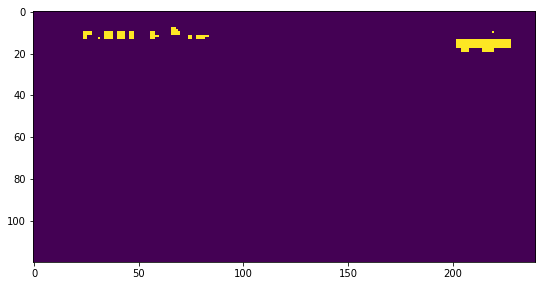

0.3 337 0.18


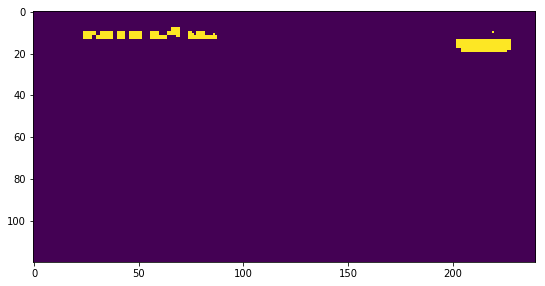

0.3 337 0.2


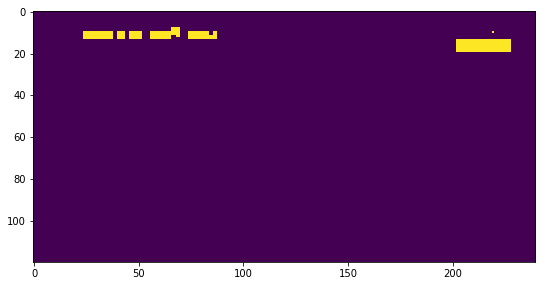

0.3 337 0.25


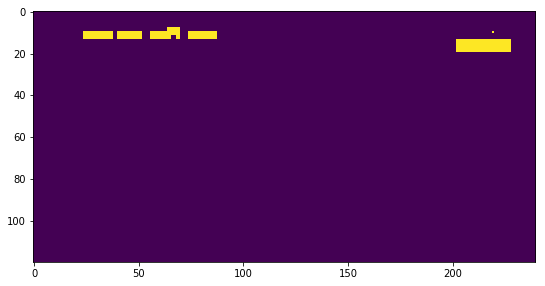

0.3 337 0.3


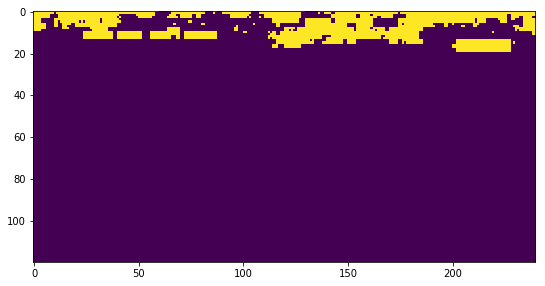

0.3 341 0.15


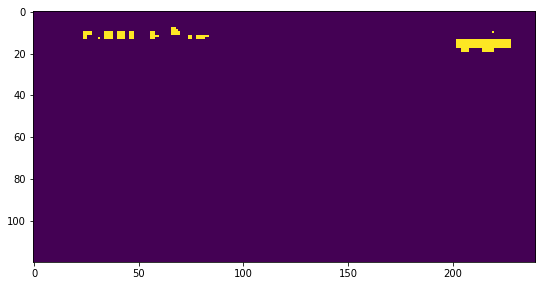

0.3 341 0.18


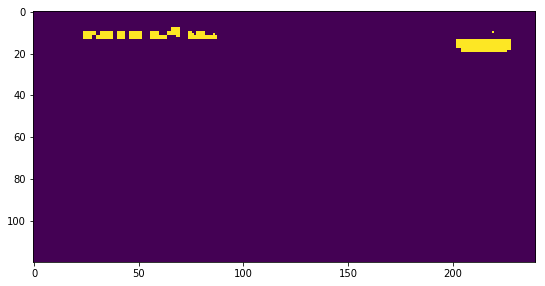

0.3 341 0.2


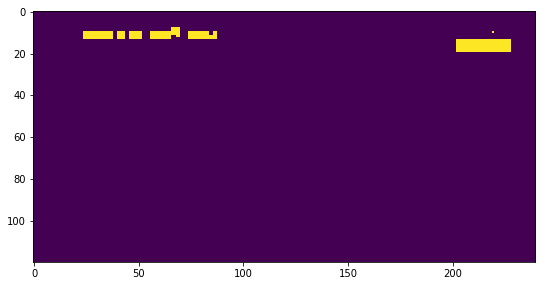

0.3 341 0.25


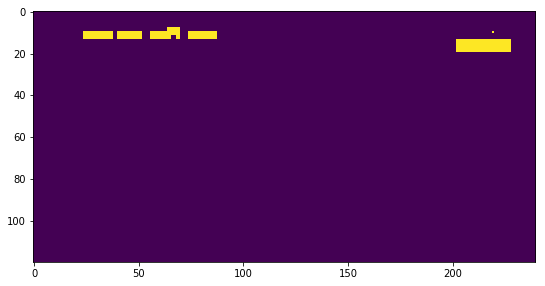

0.3 341 0.3


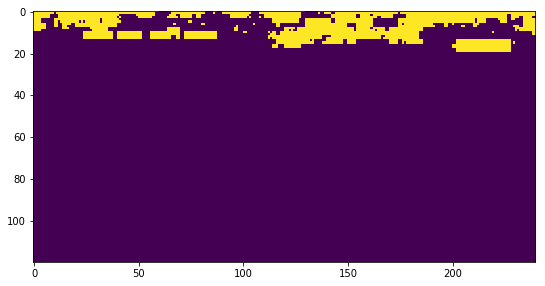

0.3 345 0.15


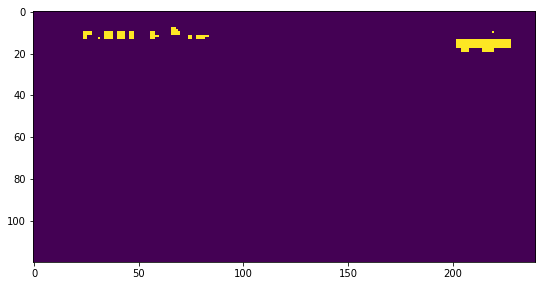

0.3 345 0.18


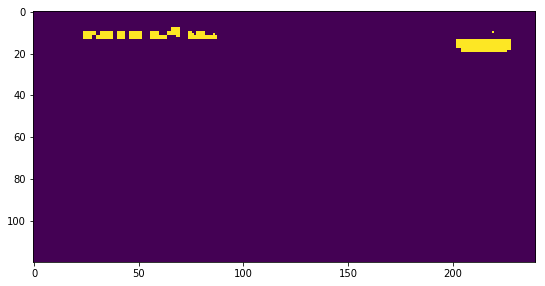

0.3 345 0.2


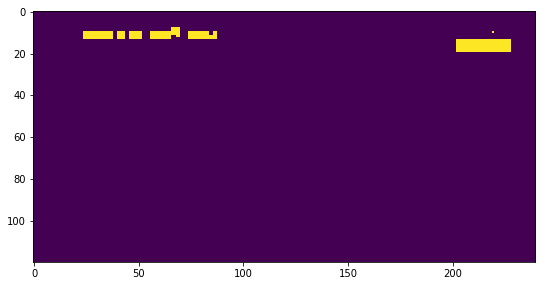

0.3 345 0.25


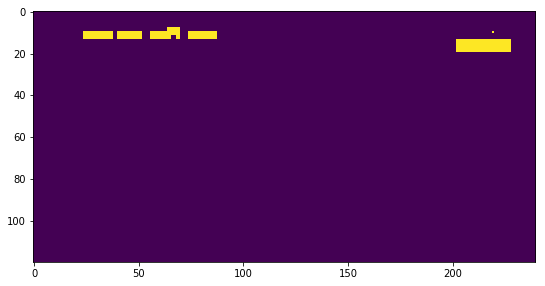

0.3 345 0.3


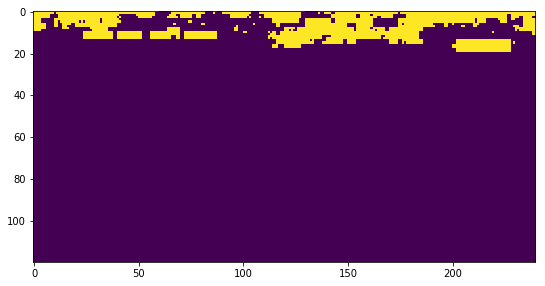

0.3 349 0.15


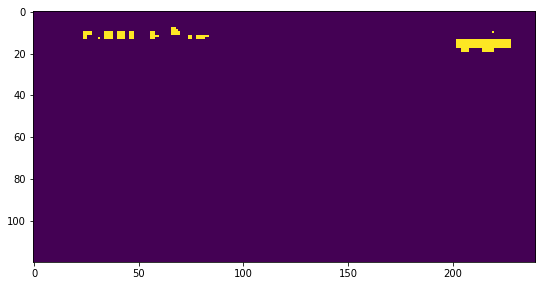

0.3 349 0.18


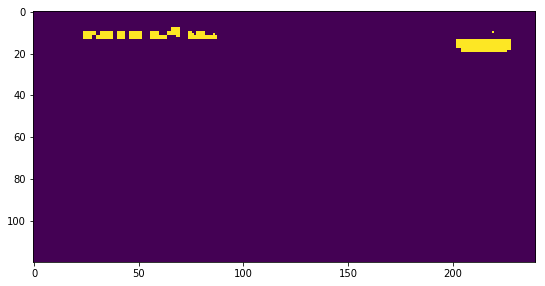

0.3 349 0.2


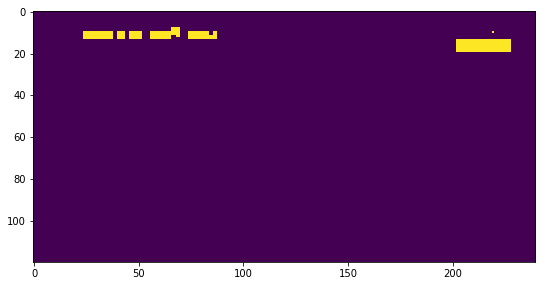

0.3 349 0.25


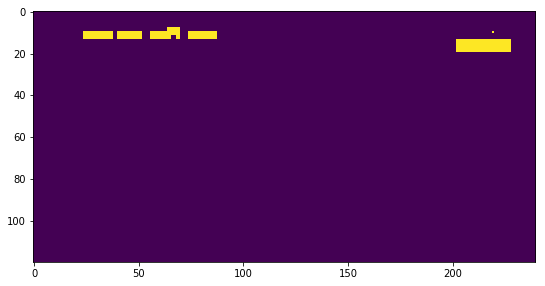

0.3 349 0.3


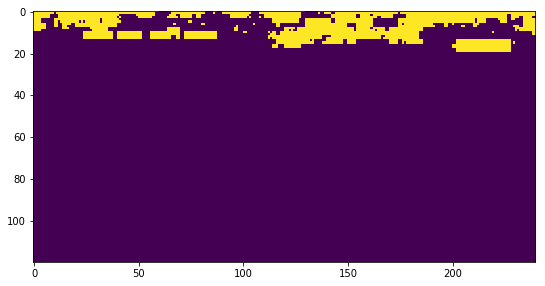

0.3 353 0.15


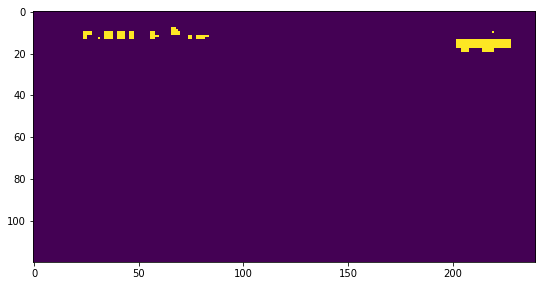

0.3 353 0.18


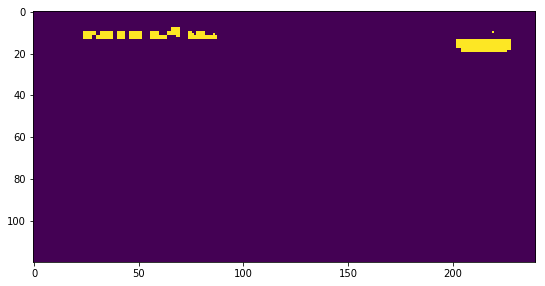

0.3 353 0.2


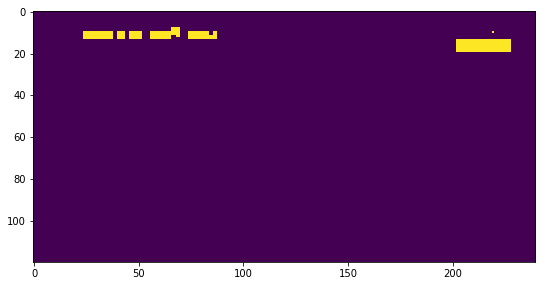

0.3 353 0.25


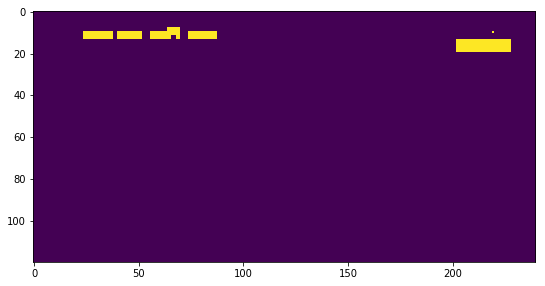

0.3 353 0.3


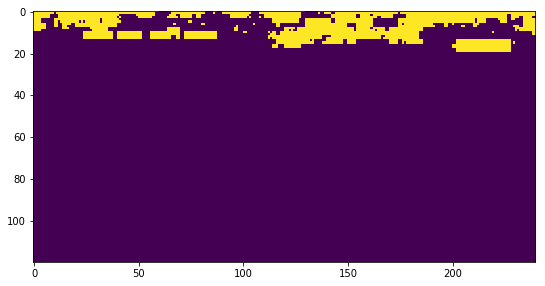

0.3 357 0.15


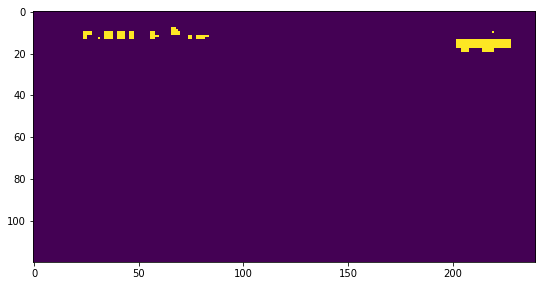

0.3 357 0.18


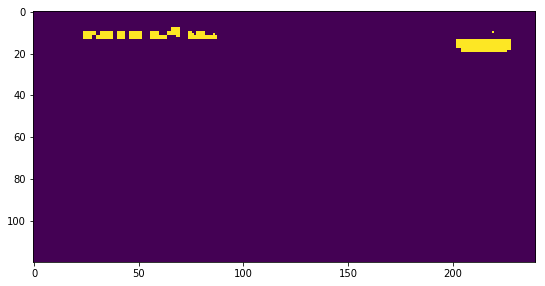

0.3 357 0.2


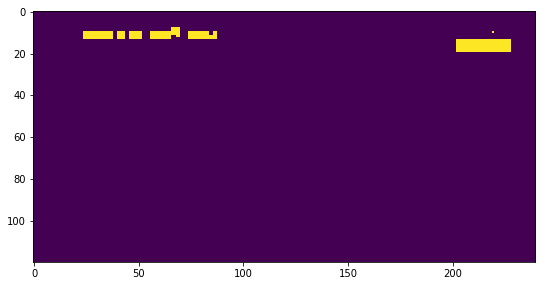

0.3 357 0.25


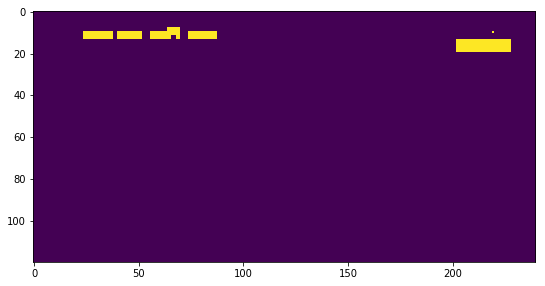

0.3 357 0.3


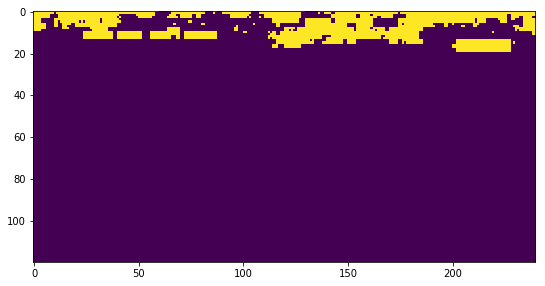

0.3 361 0.15


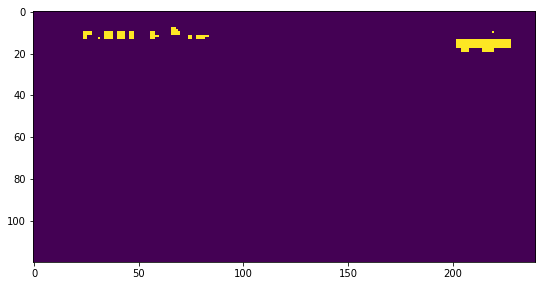

0.3 361 0.18


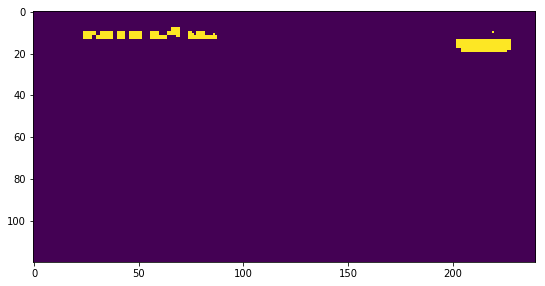

0.3 361 0.2


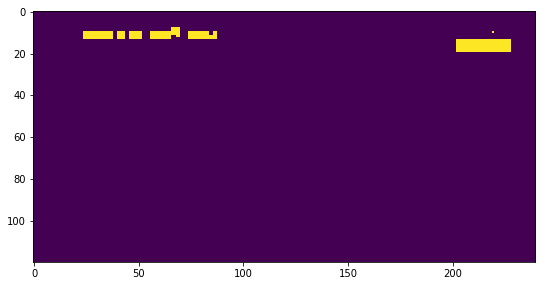

0.3 361 0.25


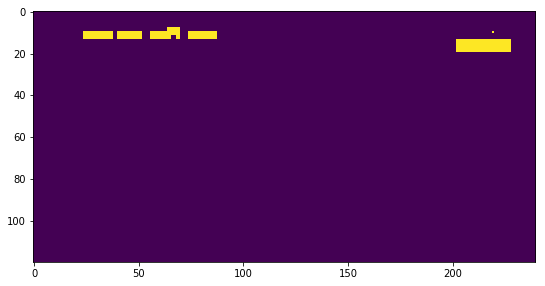

0.3 361 0.3


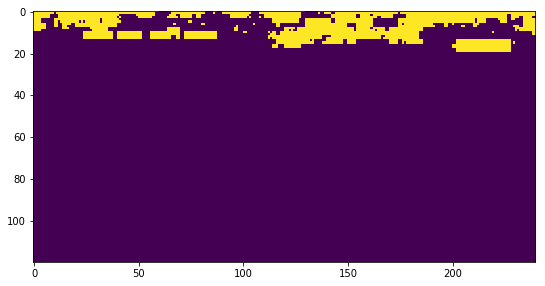

0.3 365 0.15


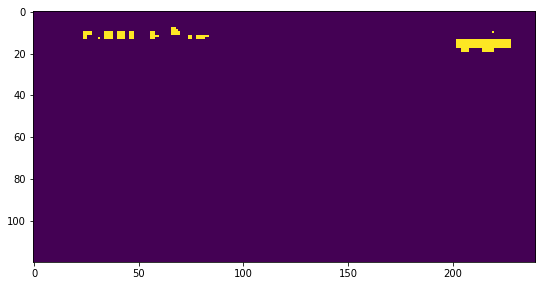

0.3 365 0.18


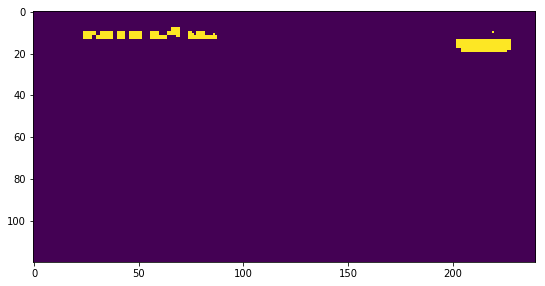

0.3 365 0.2


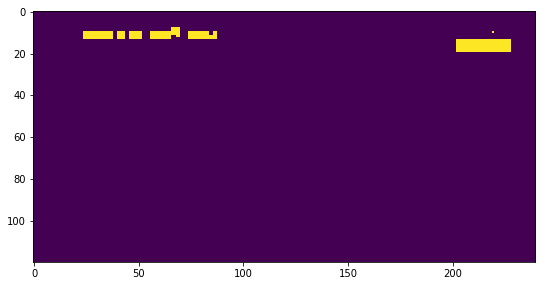

0.3 365 0.25


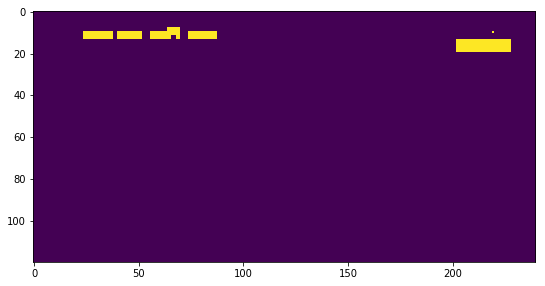

0.3 365 0.3


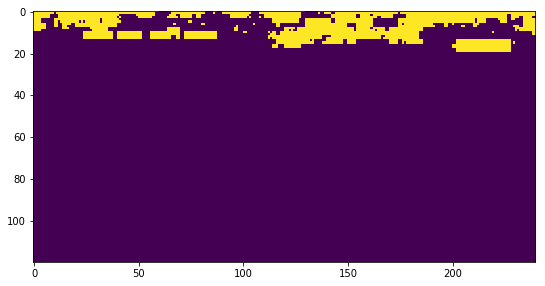

0.3 369 0.15


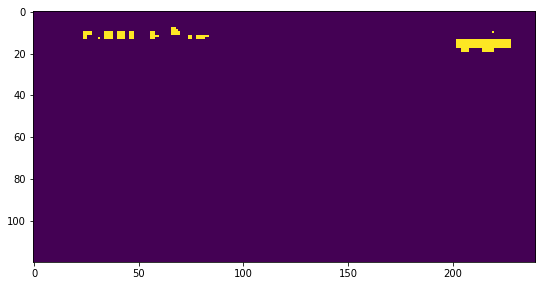

0.3 369 0.18


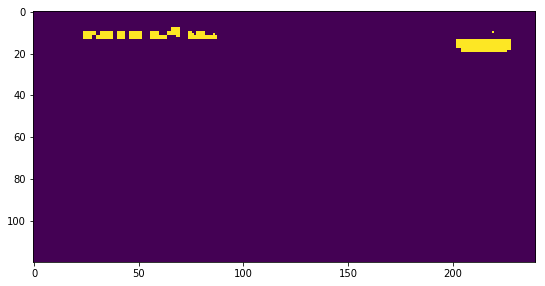

0.3 369 0.2


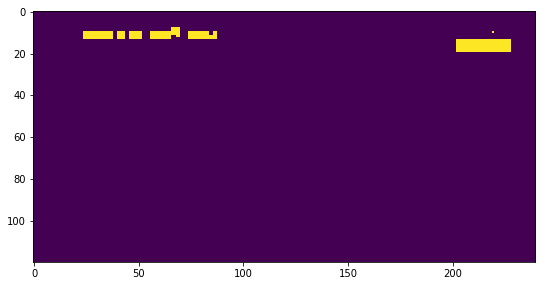

0.3 369 0.25


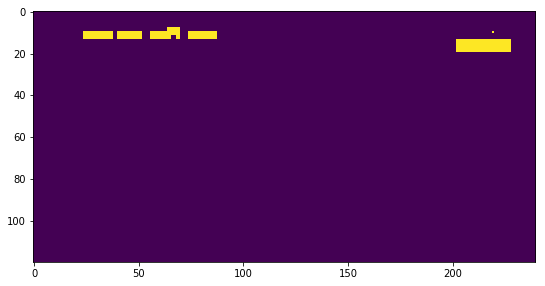

0.3 369 0.3


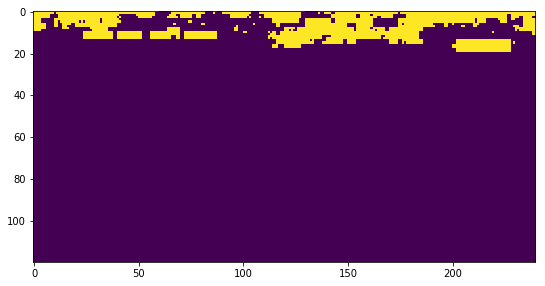

0.3 373 0.15


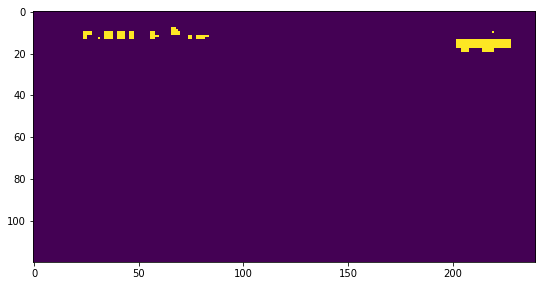

0.3 373 0.18


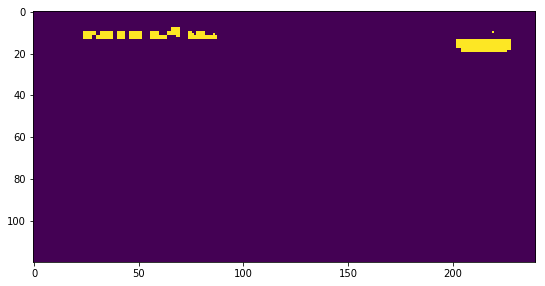

0.3 373 0.2


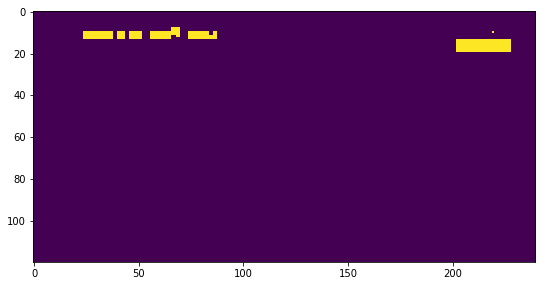

0.3 373 0.25


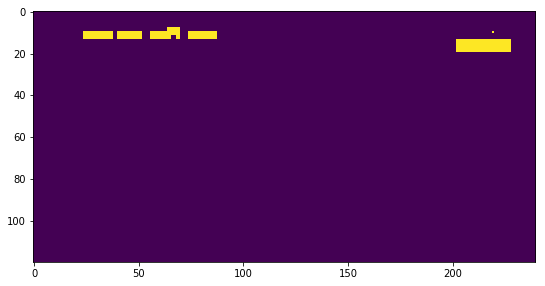

0.3 373 0.3


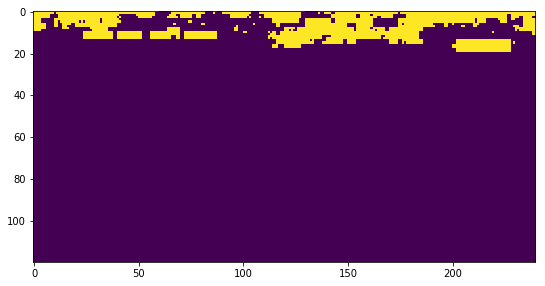

0.3 377 0.15


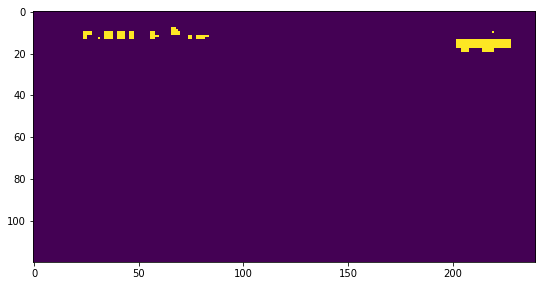

0.3 377 0.18


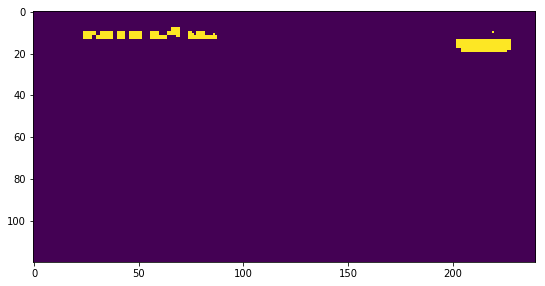

0.3 377 0.2


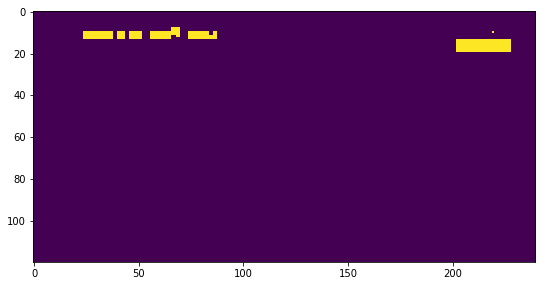

0.3 377 0.25


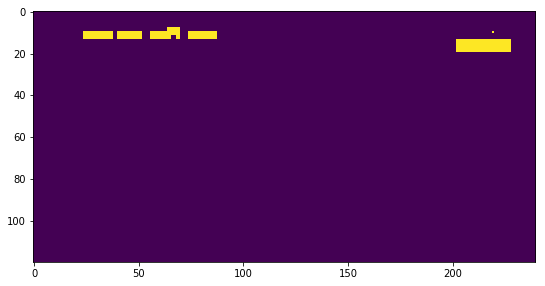

0.3 377 0.3


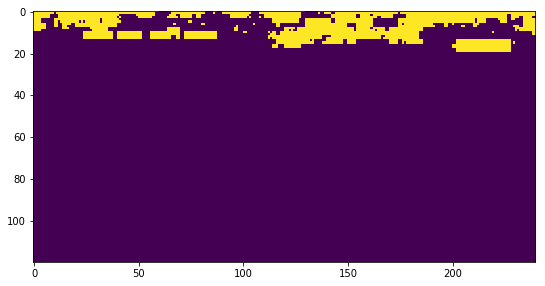

0.3 381 0.15


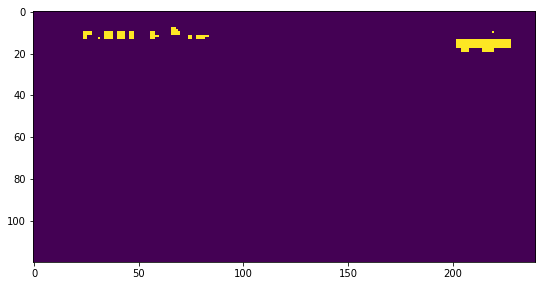

0.3 381 0.18


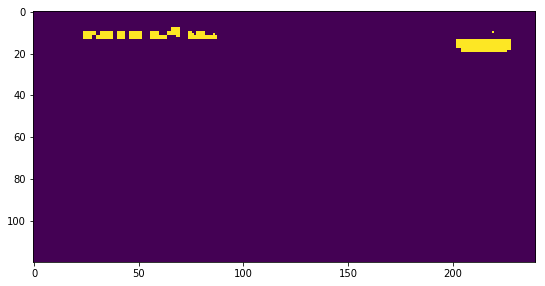

0.3 381 0.2


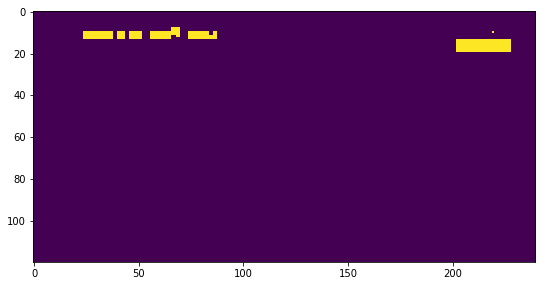

0.3 381 0.25


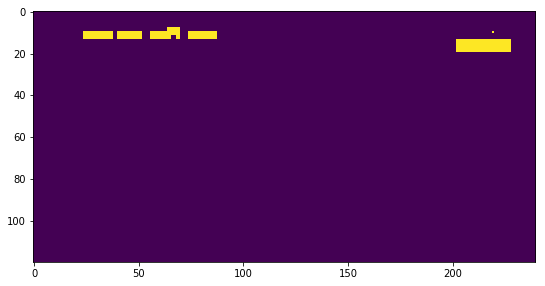

0.3 381 0.3


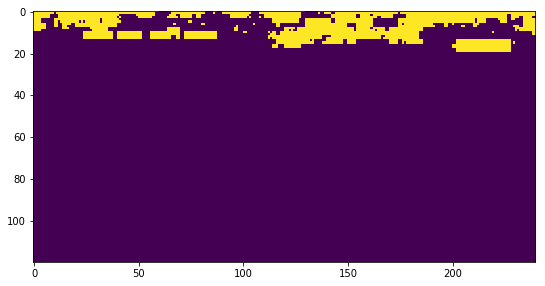

0.3 385 0.15


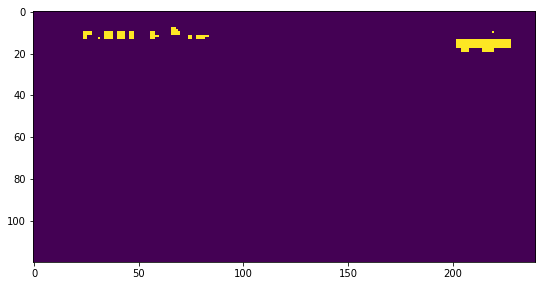

0.3 385 0.18


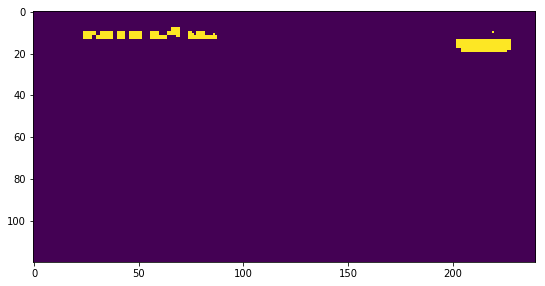

0.3 385 0.2


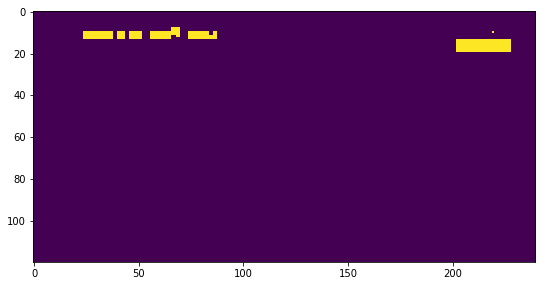

0.3 385 0.25


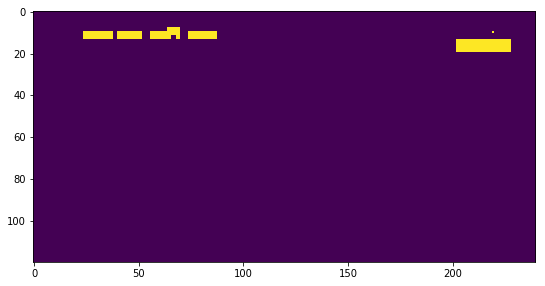

0.3 385 0.3


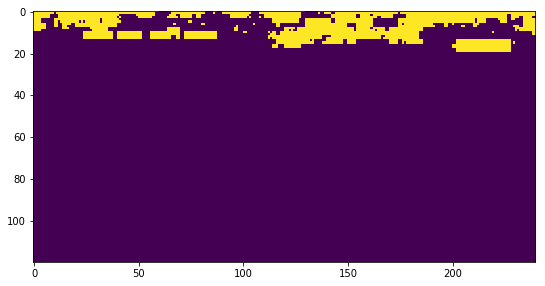

0.3 389 0.15


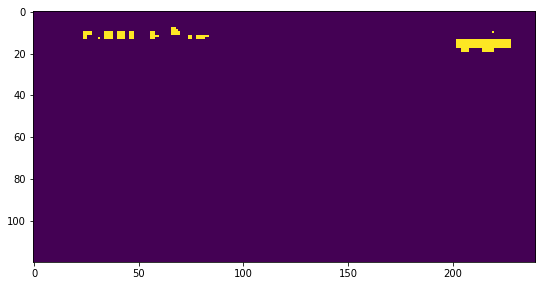

0.3 389 0.18


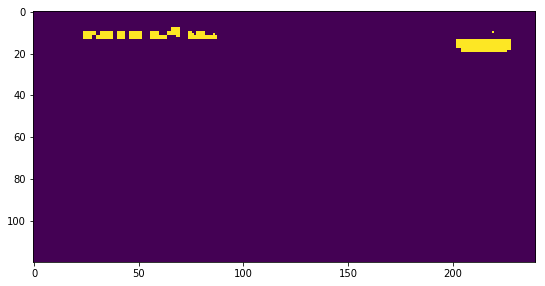

0.3 389 0.2


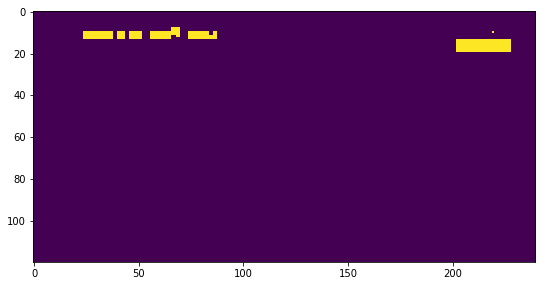

0.3 389 0.25


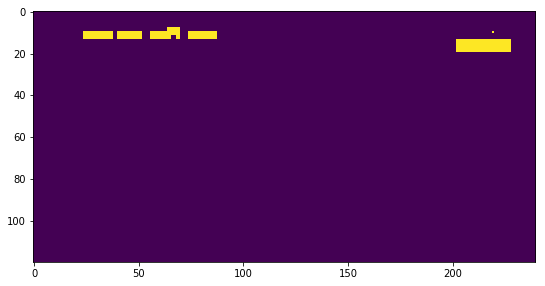

0.3 389 0.3


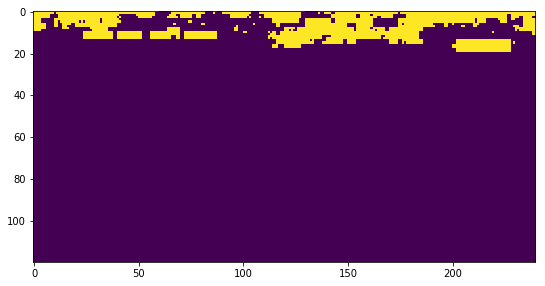

0.3 393 0.15


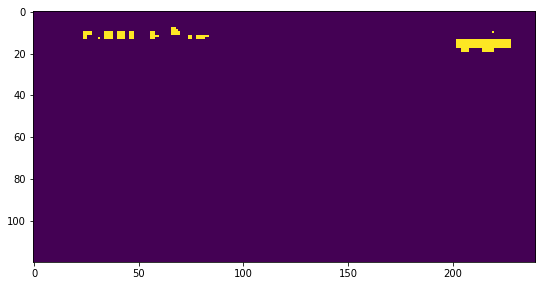

0.3 393 0.18


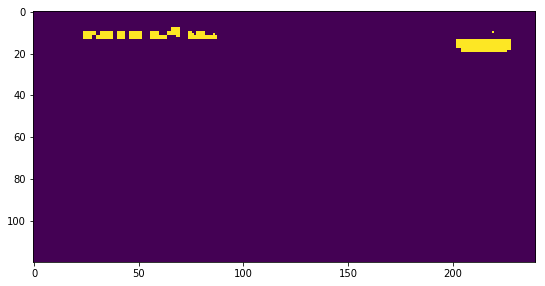

0.3 393 0.2


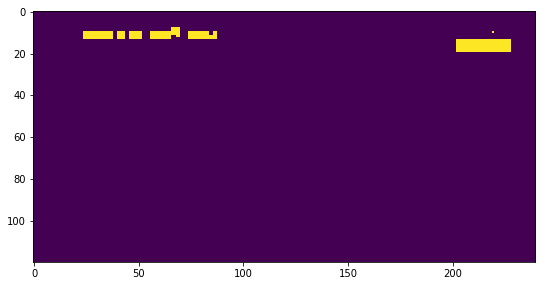

0.3 393 0.25


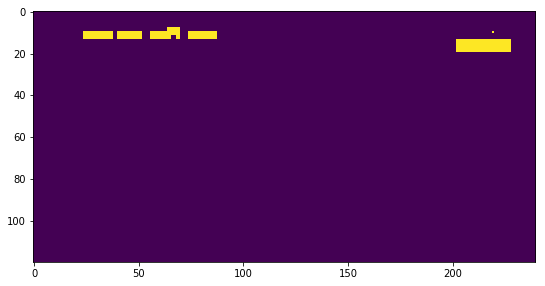

0.3 393 0.3


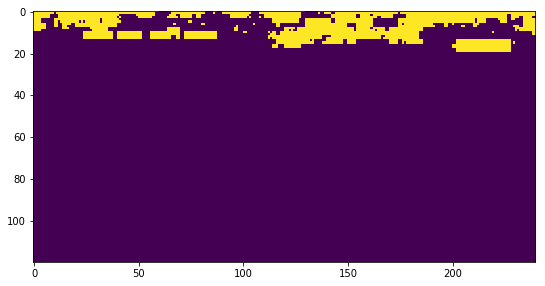

0.3 397 0.15


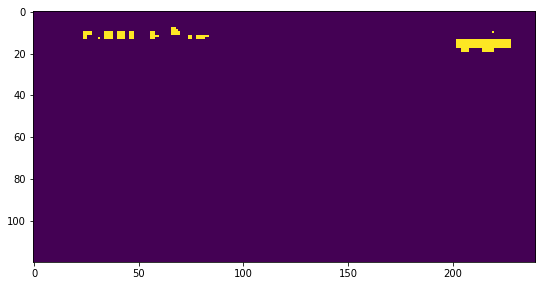

0.3 397 0.18


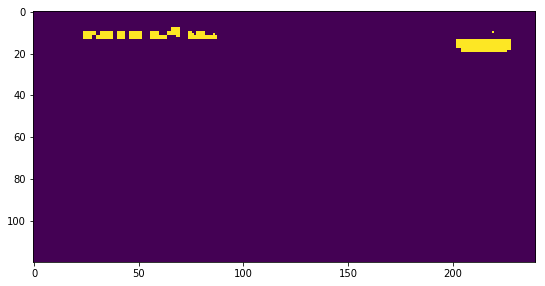

0.3 397 0.2


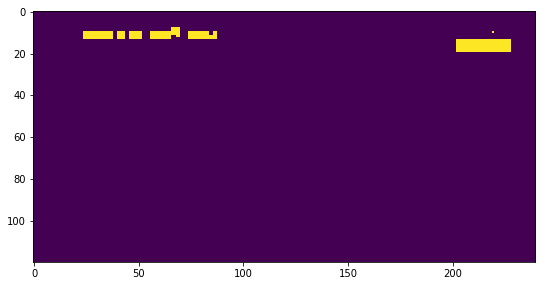

0.3 397 0.25


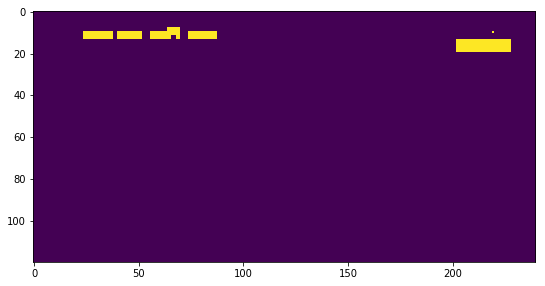

0.3 397 0.3


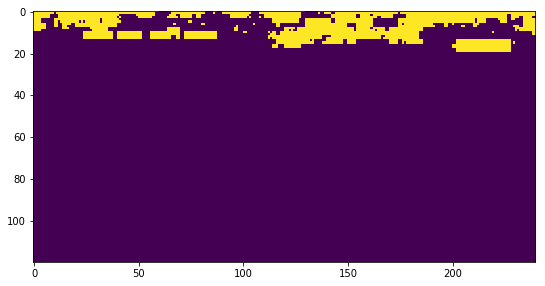

0.5 1 0.15


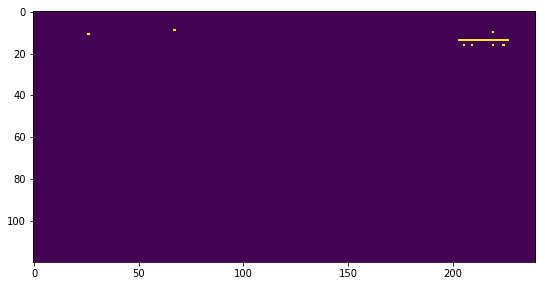

0.5 1 0.18


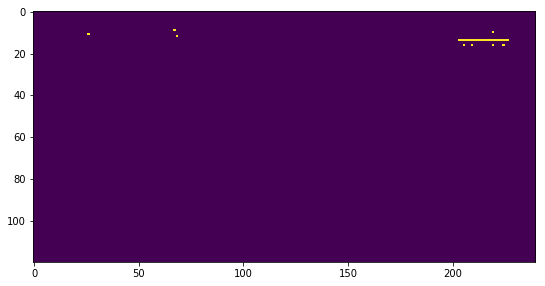

0.5 1 0.2


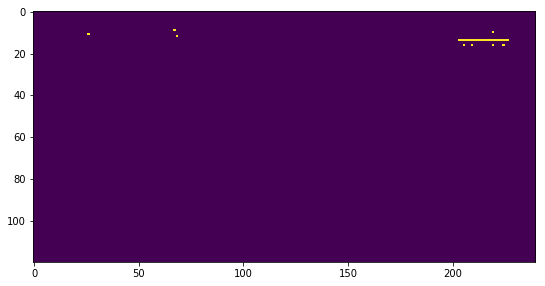

0.5 1 0.25


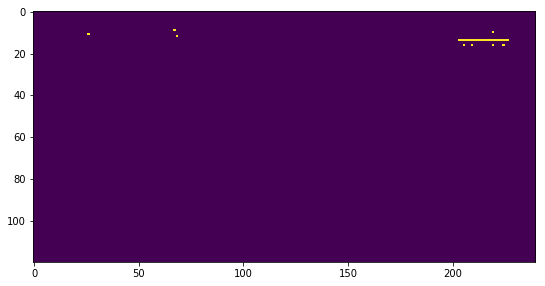

0.5 1 0.3


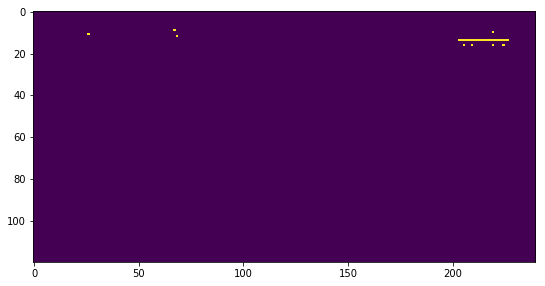

0.5 5 0.15


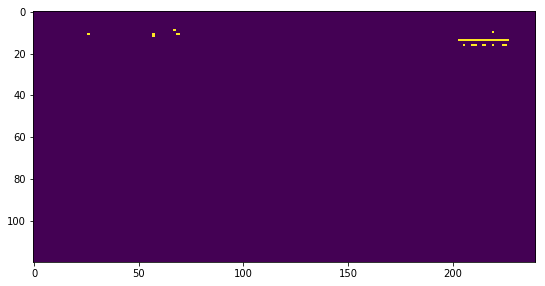

0.5 5 0.18


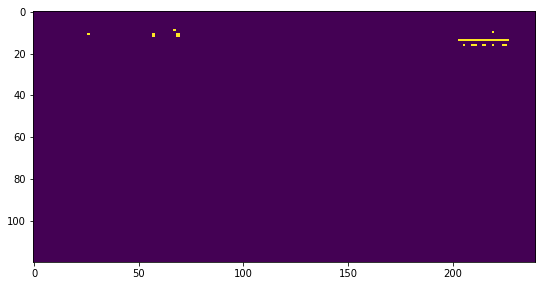

0.5 5 0.2


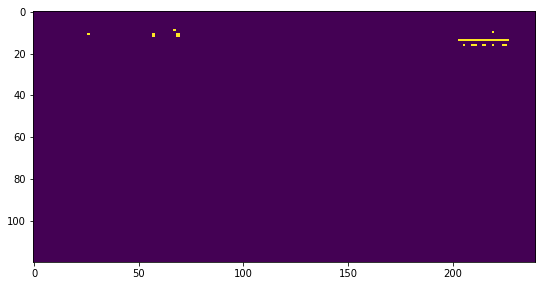

0.5 5 0.25


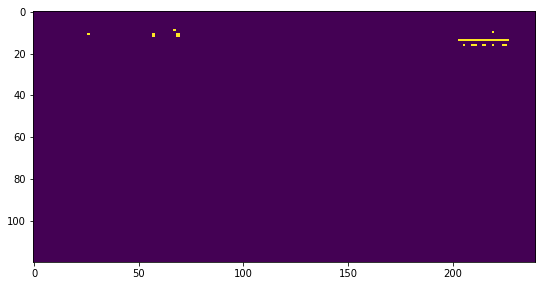

0.5 5 0.3


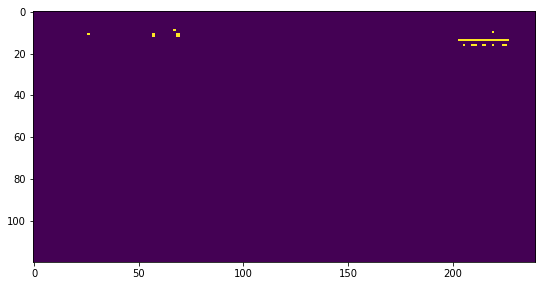

0.5 9 0.15


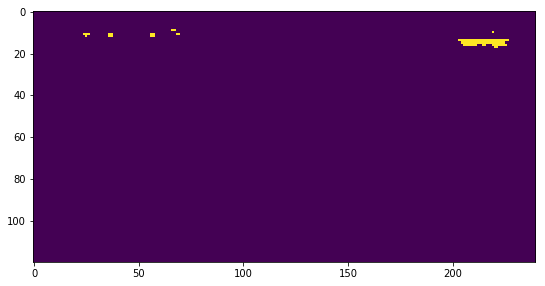

0.5 9 0.18


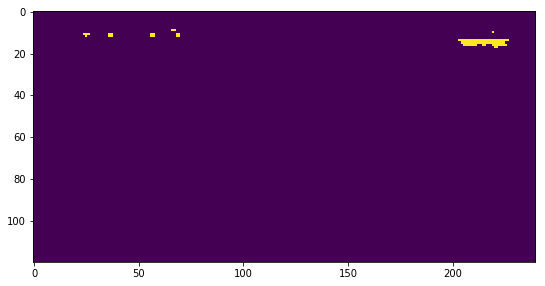

0.5 9 0.2


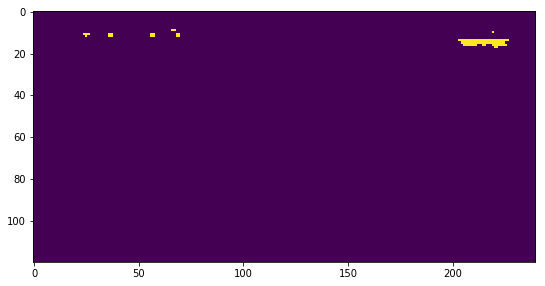

0.5 9 0.25


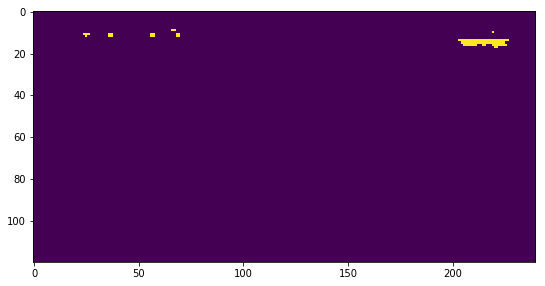

0.5 9 0.3


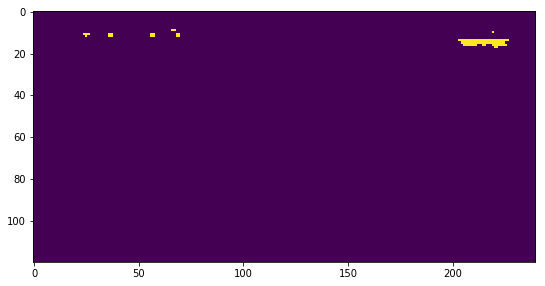

0.5 13 0.15


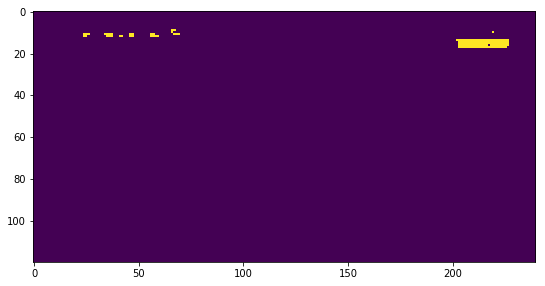

0.5 13 0.18


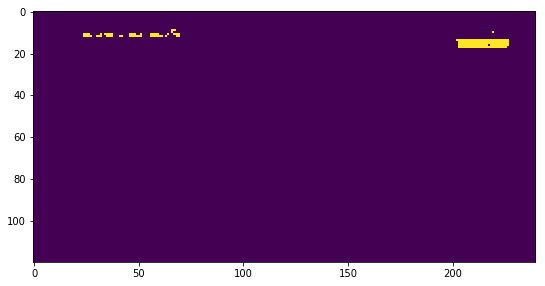

0.5 13 0.2


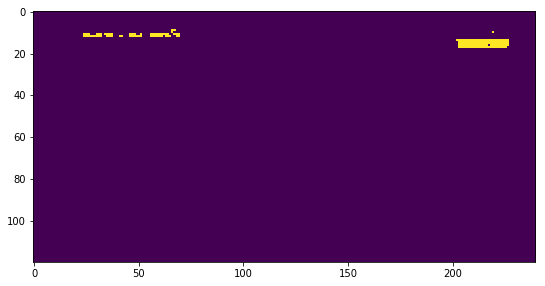

0.5 13 0.25


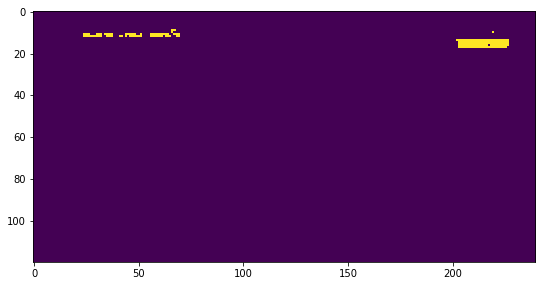

0.5 13 0.3


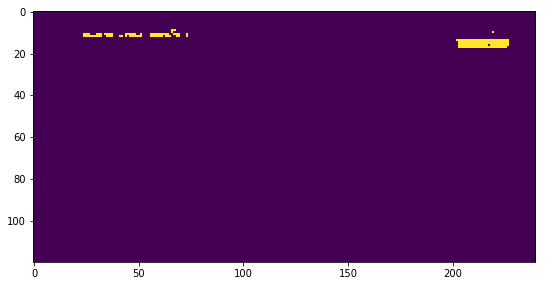

0.5 17 0.15


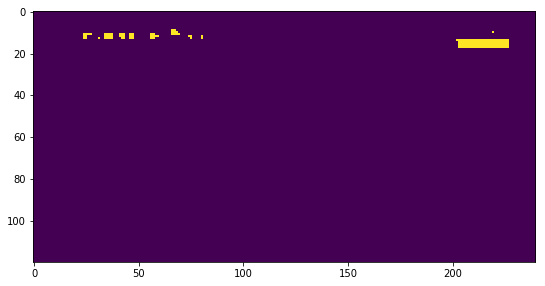

0.5 17 0.18


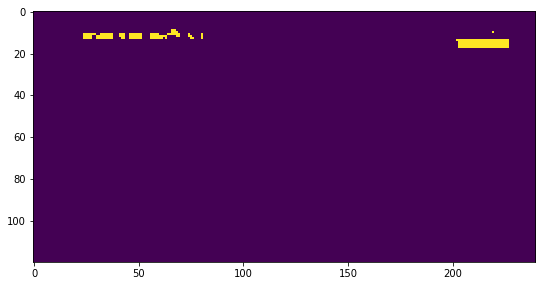

0.5 17 0.2


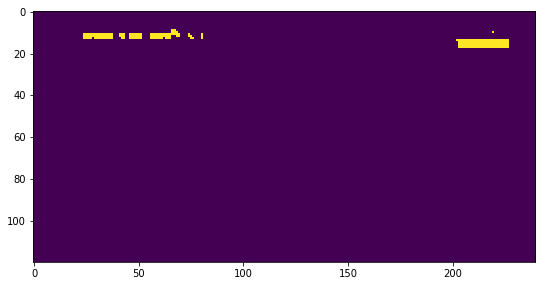

0.5 17 0.25


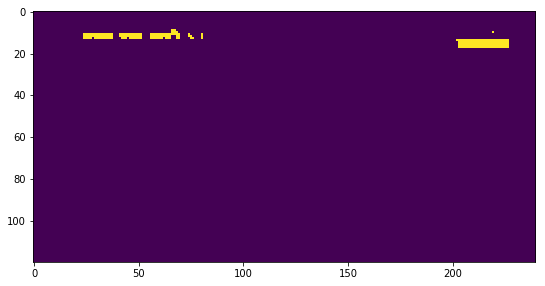

0.5 17 0.3


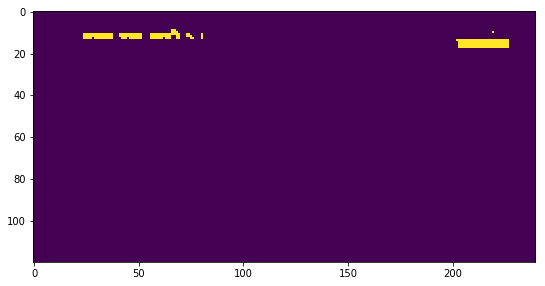

0.5 21 0.15


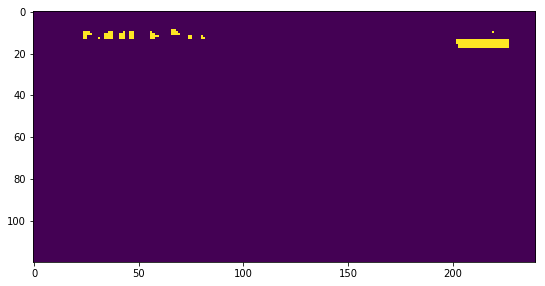

0.5 21 0.18


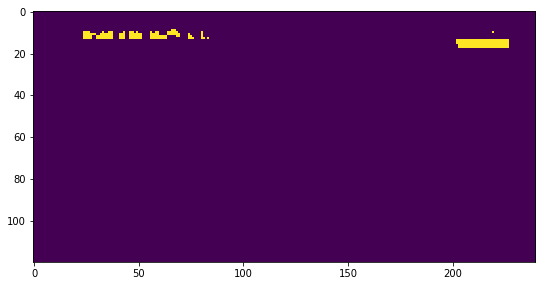

0.5 21 0.2


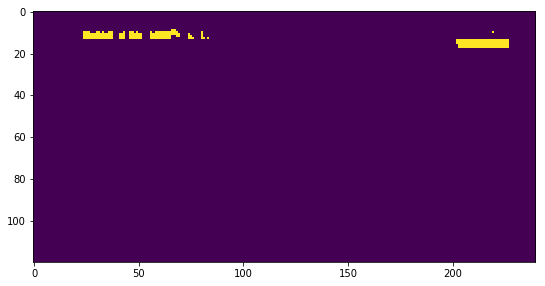

0.5 21 0.25


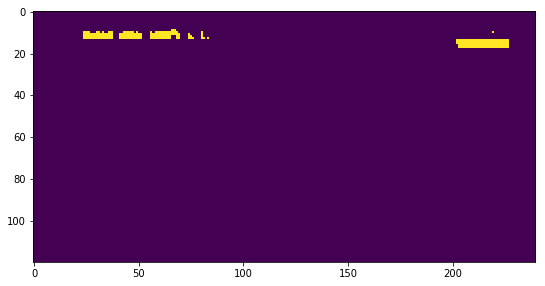

0.5 21 0.3


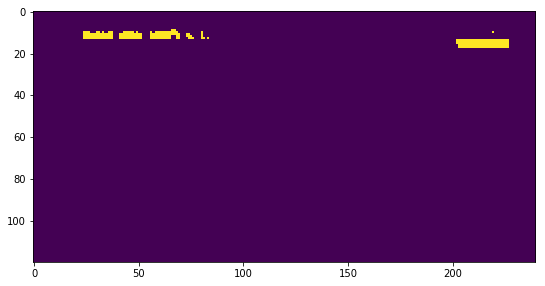

0.5 25 0.15


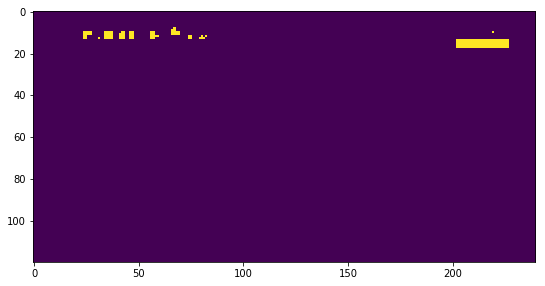

0.5 25 0.18


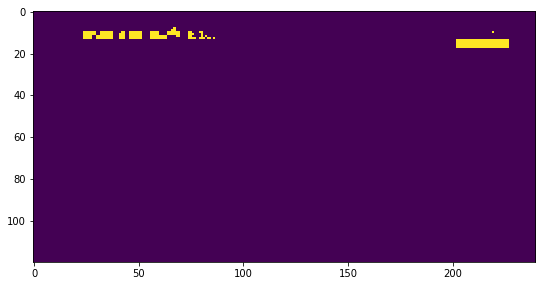

0.5 25 0.2


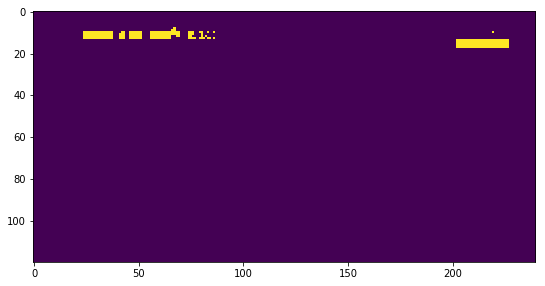

0.5 25 0.25


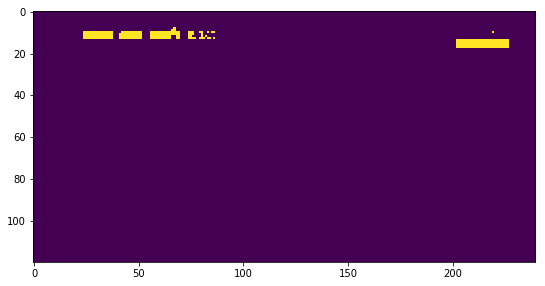

0.5 25 0.3


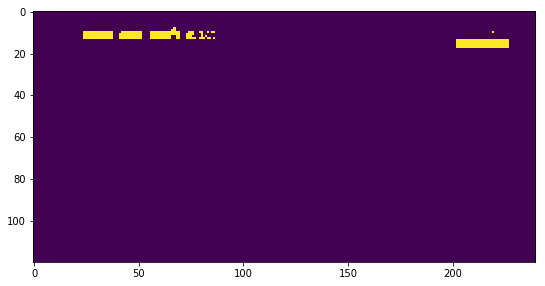

0.5 29 0.15


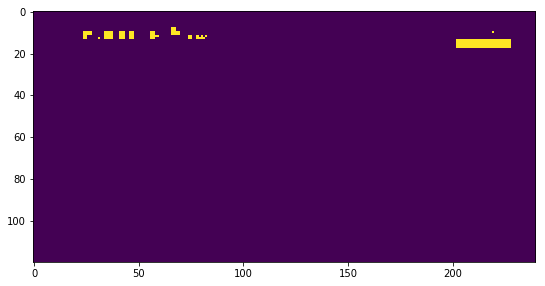

0.5 29 0.18


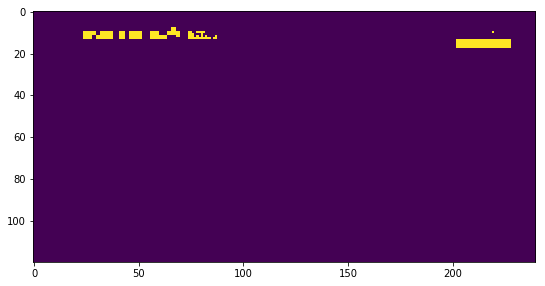

0.5 29 0.2


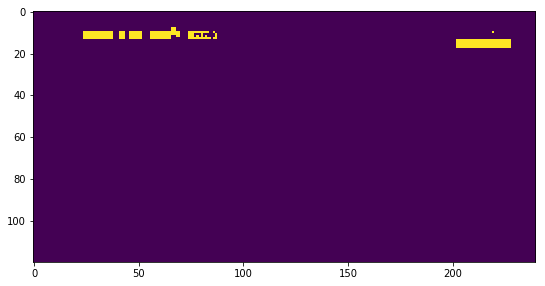

0.5 29 0.25


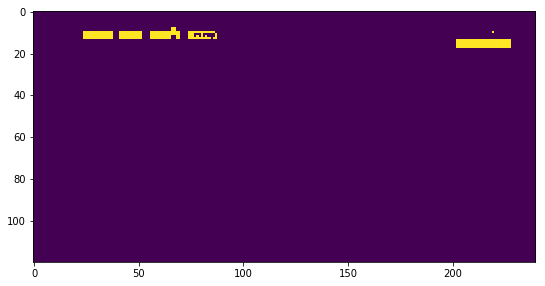

0.5 29 0.3


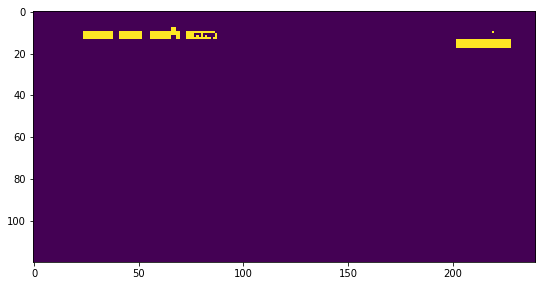

0.5 33 0.15


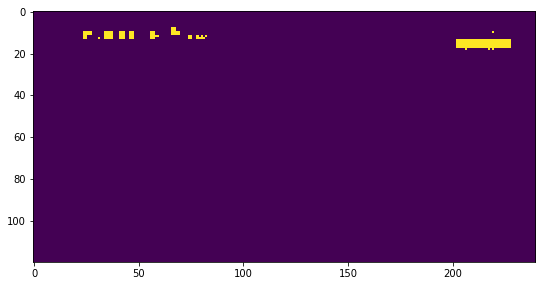

0.5 33 0.18


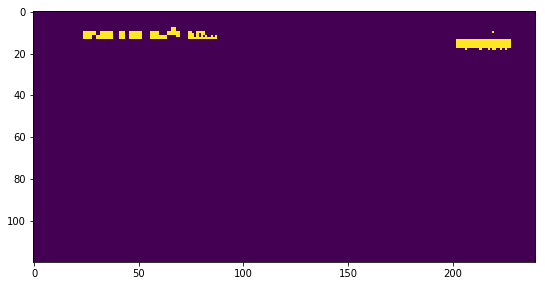

0.5 33 0.2


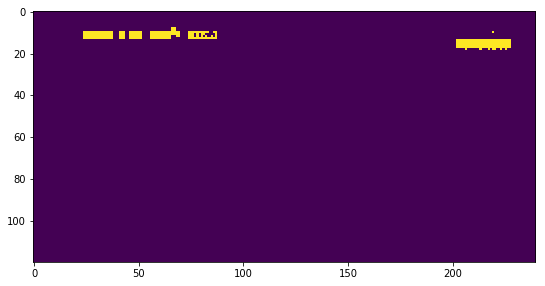

0.5 33 0.25


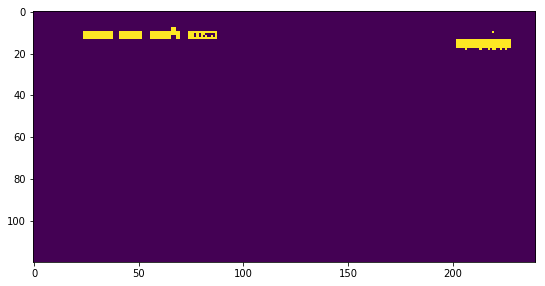

0.5 33 0.3


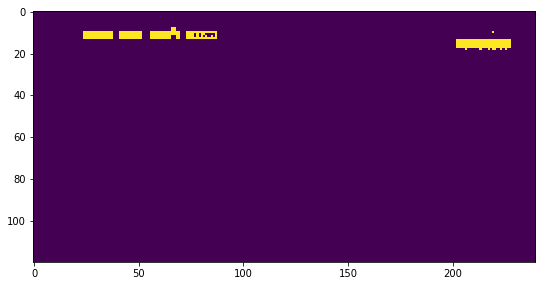

0.5 37 0.15


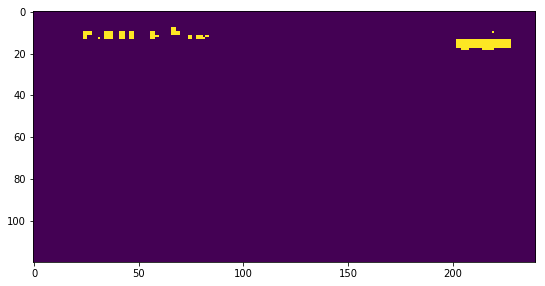

0.5 37 0.18


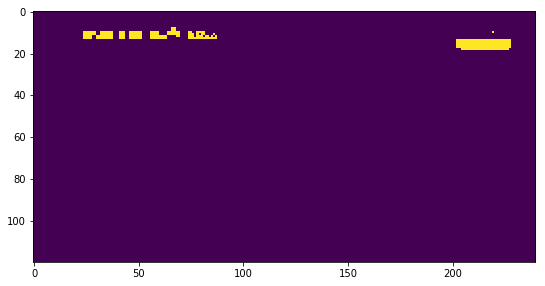

0.5 37 0.2


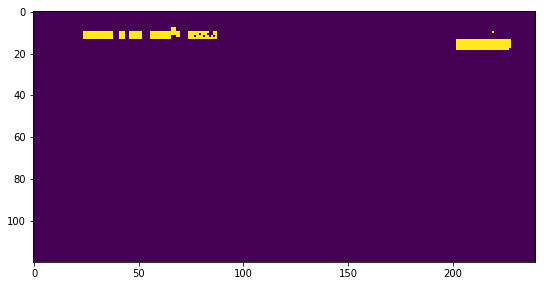

0.5 37 0.25


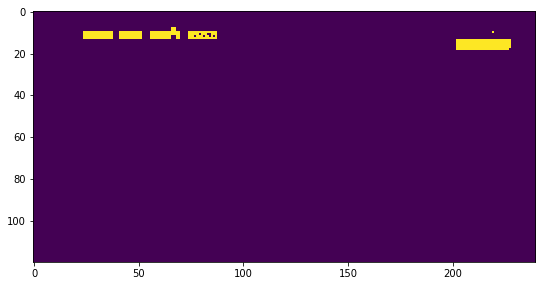

0.5 37 0.3


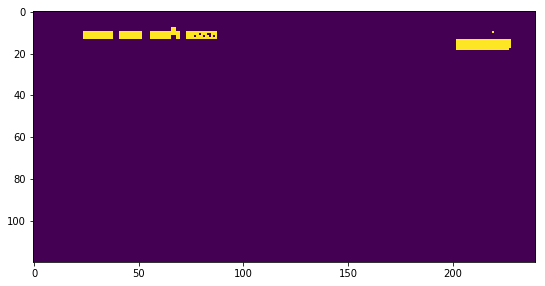

0.5 41 0.15


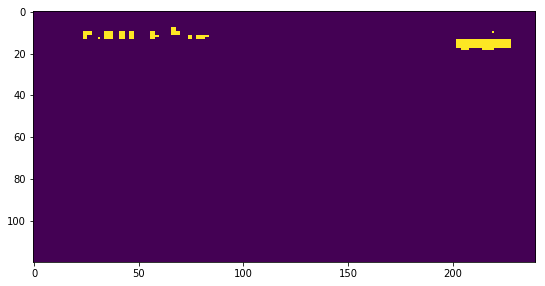

0.5 41 0.18


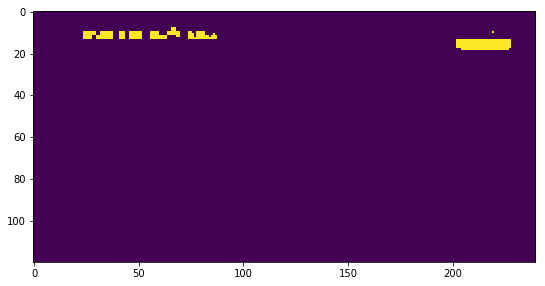

0.5 41 0.2


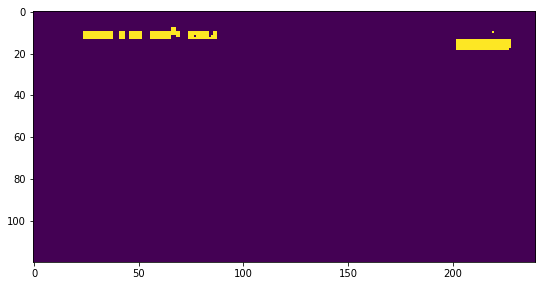

0.5 41 0.25


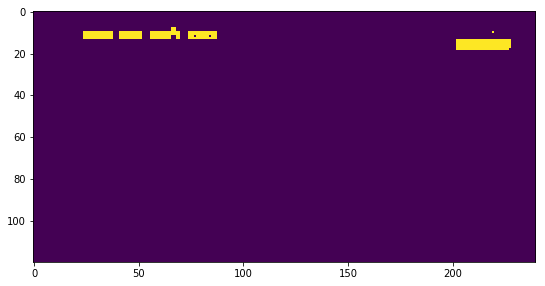

0.5 41 0.3


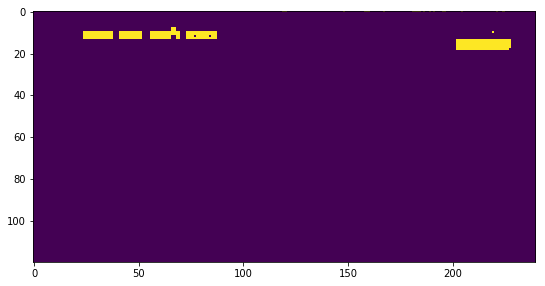

0.5 45 0.15


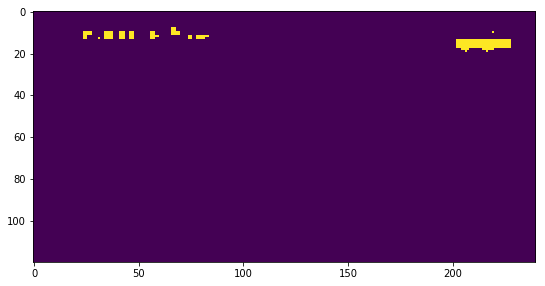

0.5 45 0.18


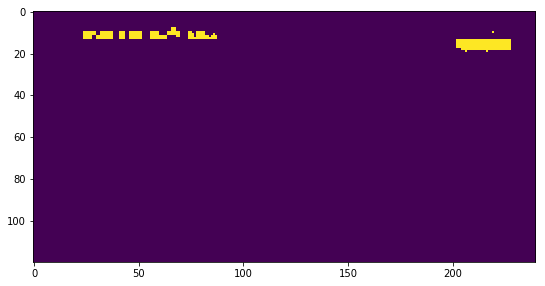

0.5 45 0.2


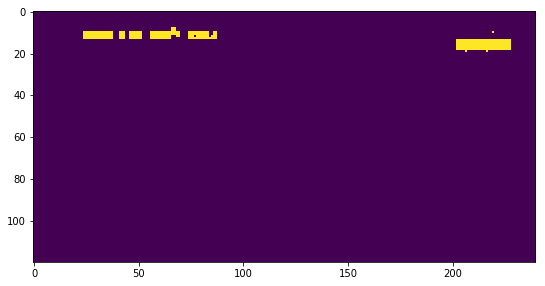

0.5 45 0.25


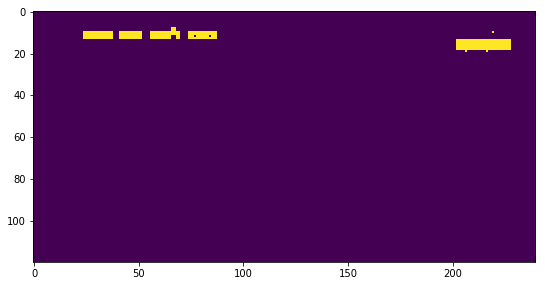

0.5 45 0.3


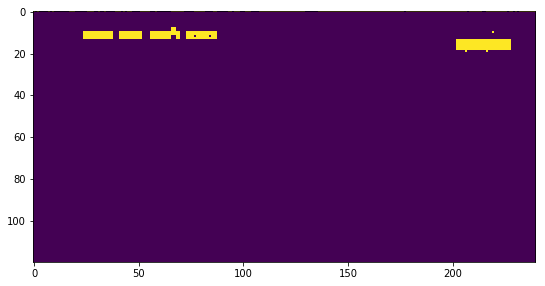

0.5 49 0.15


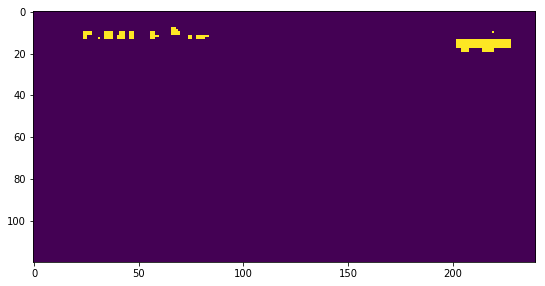

0.5 49 0.18


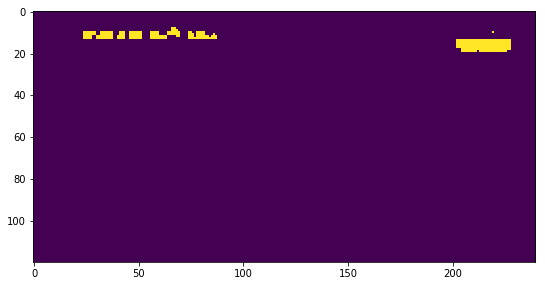

0.5 49 0.2


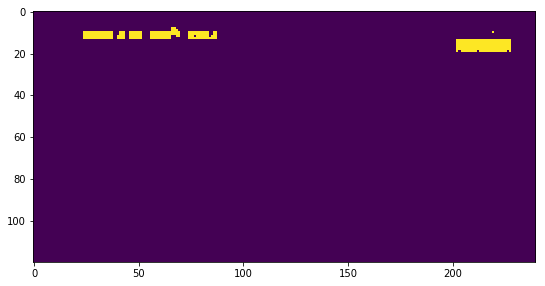

0.5 49 0.25


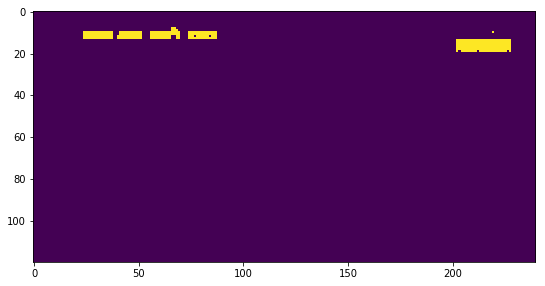

0.5 49 0.3


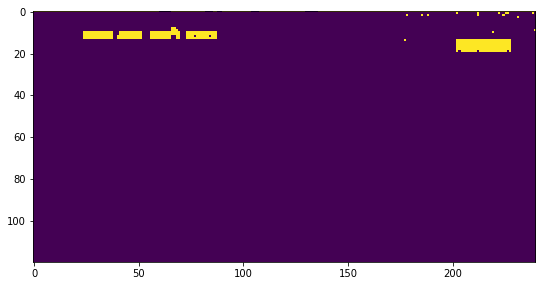

0.5 53 0.15


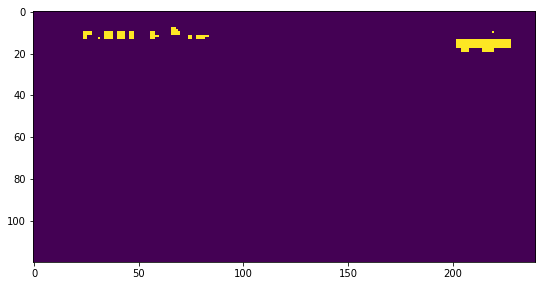

0.5 53 0.18


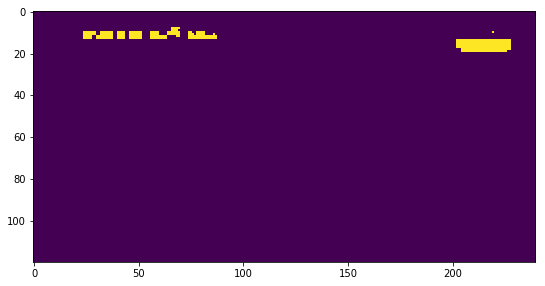

0.5 53 0.2


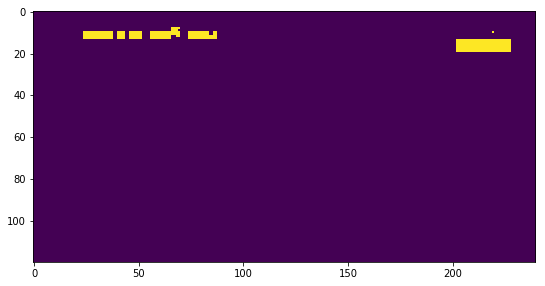

0.5 53 0.25


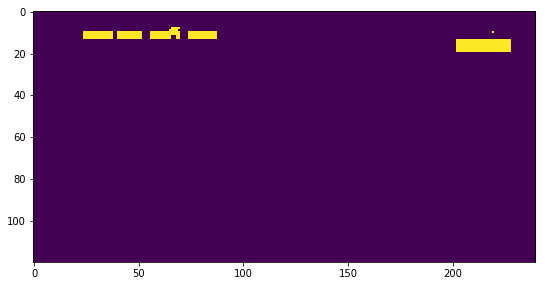

0.5 53 0.3


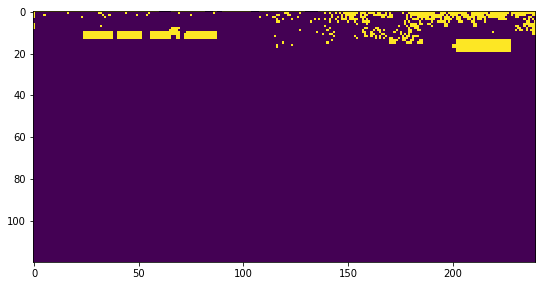

0.5 57 0.15


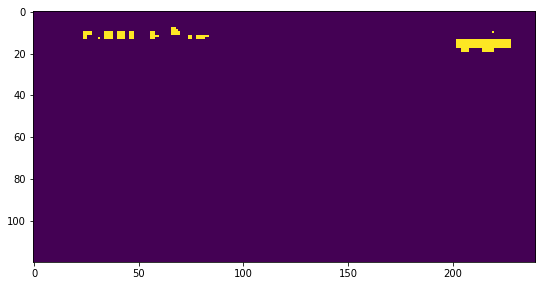

0.5 57 0.18


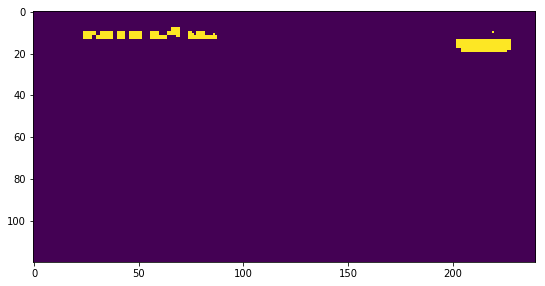

0.5 57 0.2


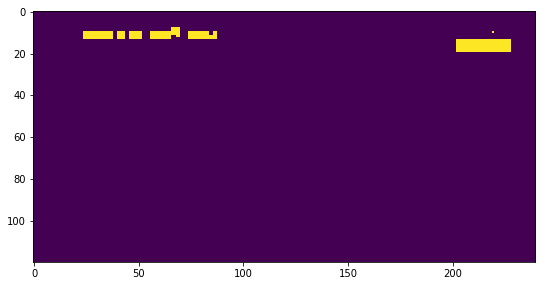

0.5 57 0.25


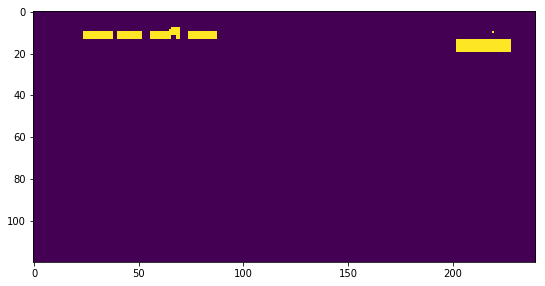

0.5 57 0.3


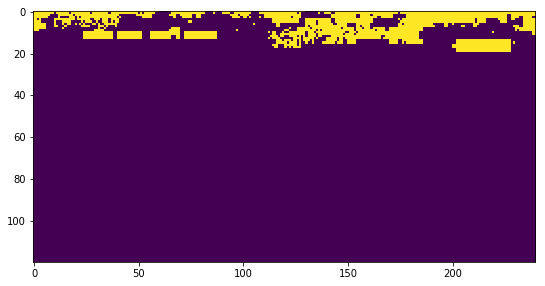

0.5 61 0.15


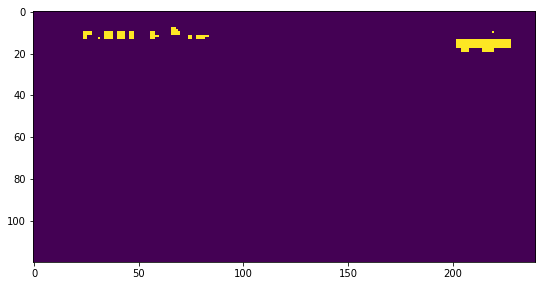

0.5 61 0.18


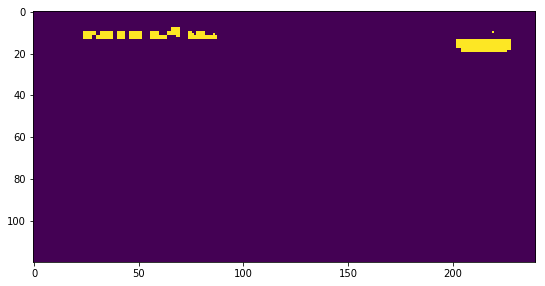

0.5 61 0.2


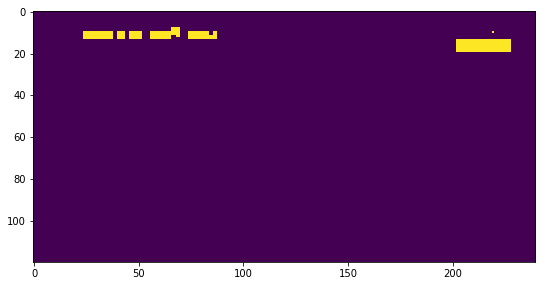

0.5 61 0.25


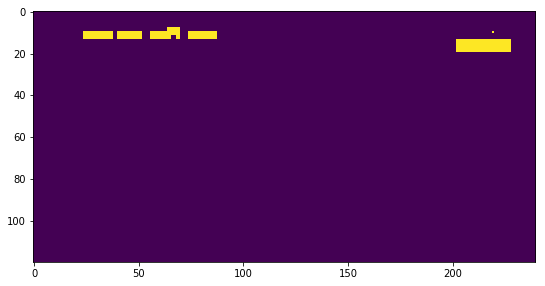

0.5 61 0.3


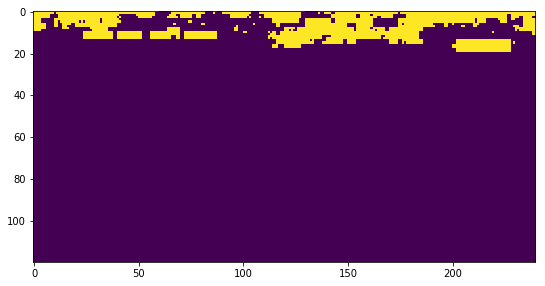

0.5 65 0.15


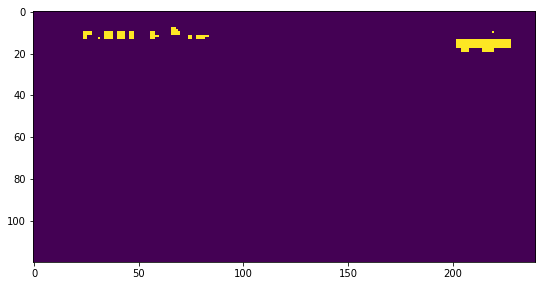

0.5 65 0.18


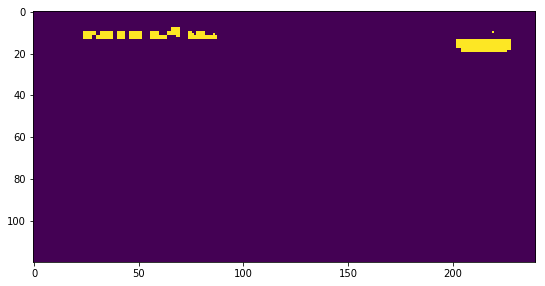

0.5 65 0.2


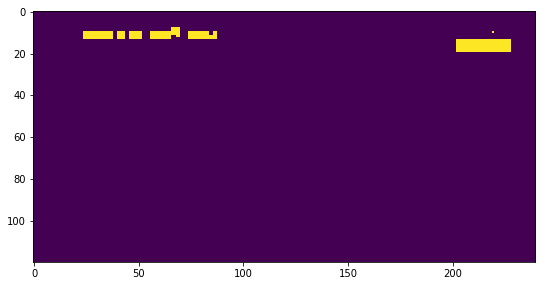

0.5 65 0.25


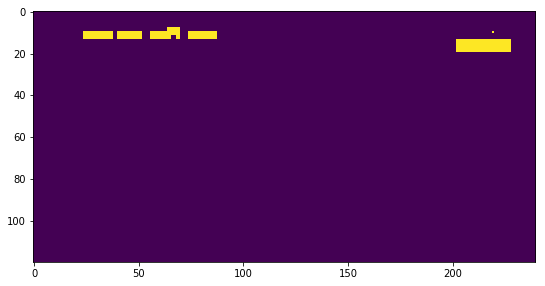

0.5 65 0.3


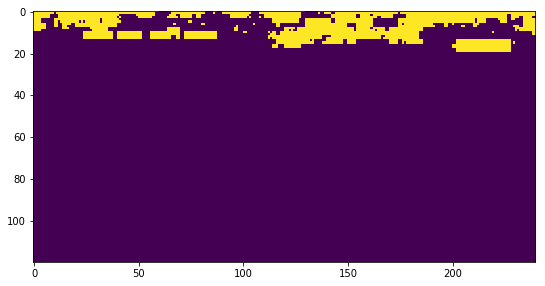

0.5 69 0.15


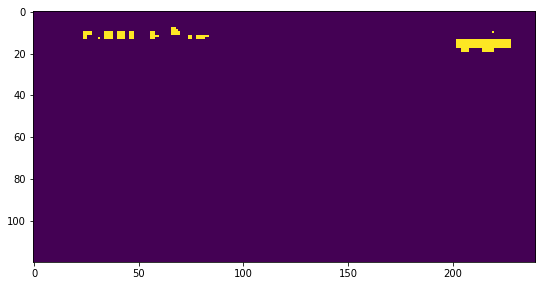

0.5 69 0.18


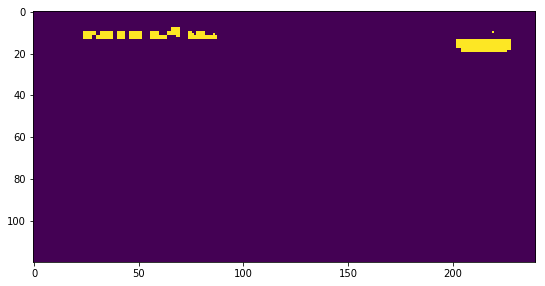

0.5 69 0.2


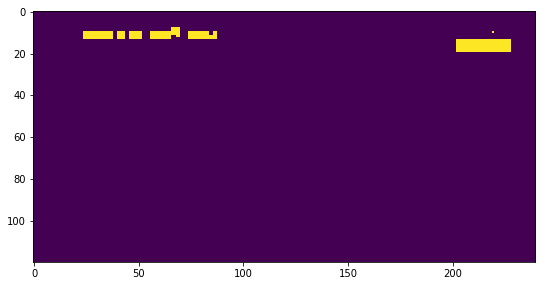

0.5 69 0.25


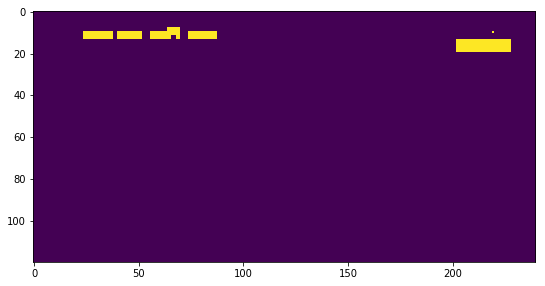

0.5 69 0.3


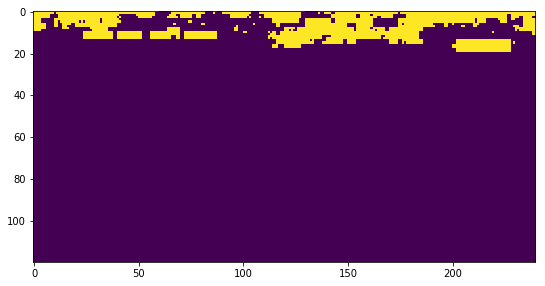

0.5 73 0.15


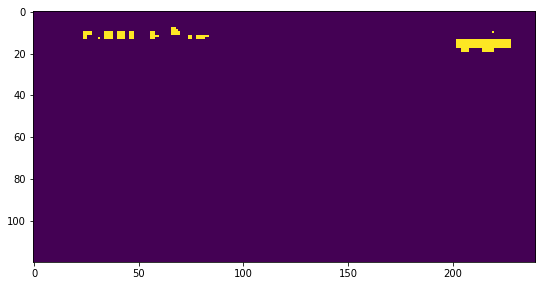

0.5 73 0.18


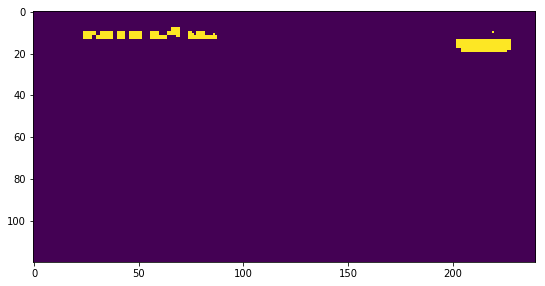

0.5 73 0.2


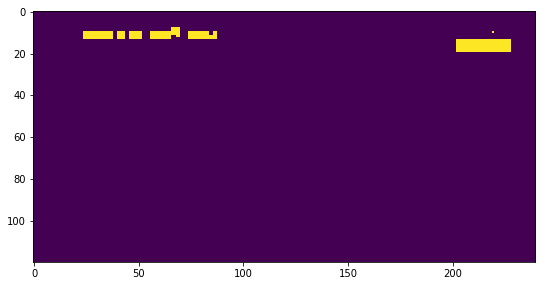

0.5 73 0.25


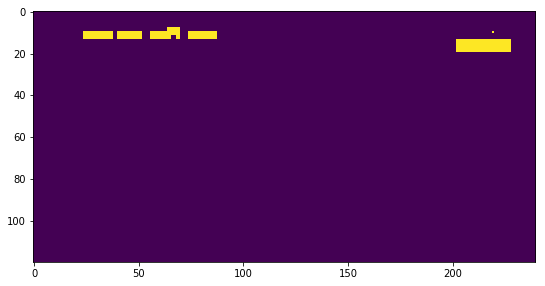

0.5 73 0.3


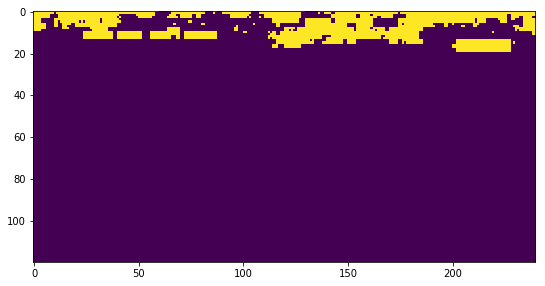

0.5 77 0.15


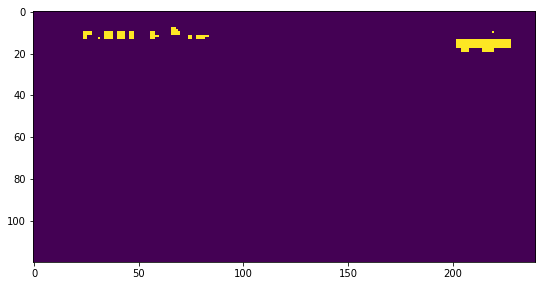

0.5 77 0.18


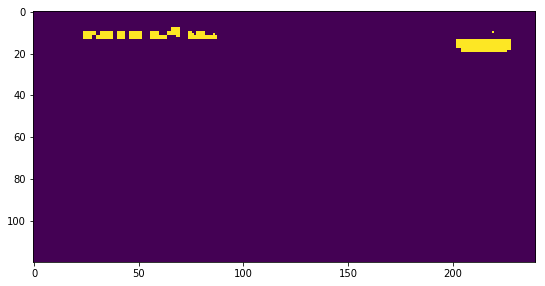

0.5 77 0.2


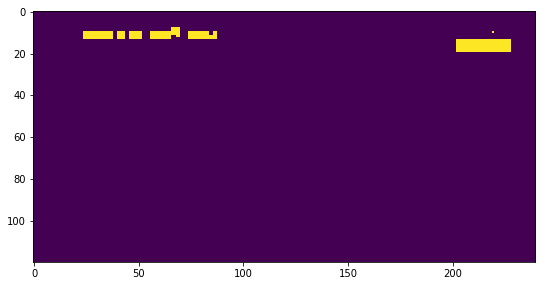

0.5 77 0.25


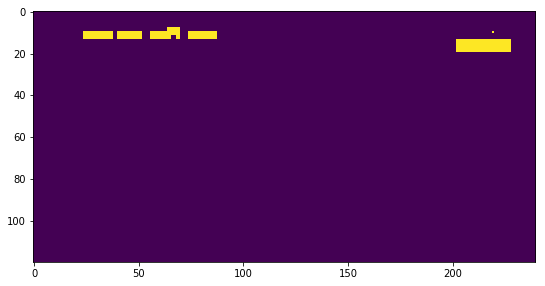

0.5 77 0.3


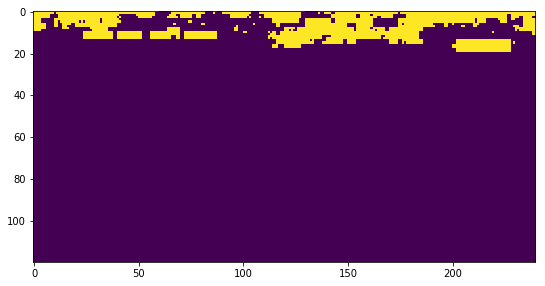

0.5 81 0.15


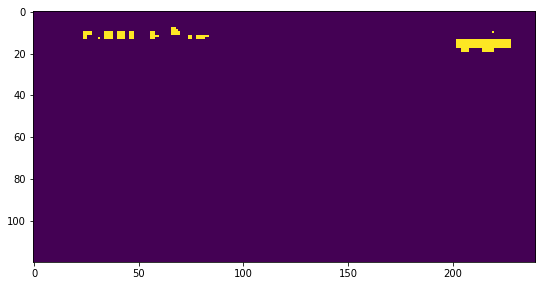

0.5 81 0.18


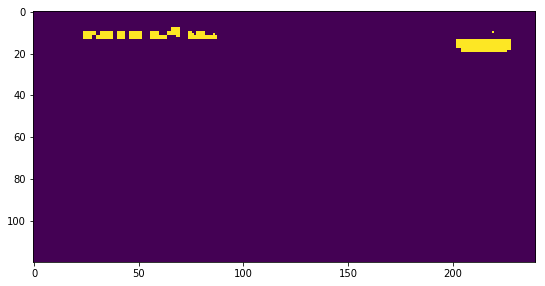

0.5 81 0.2


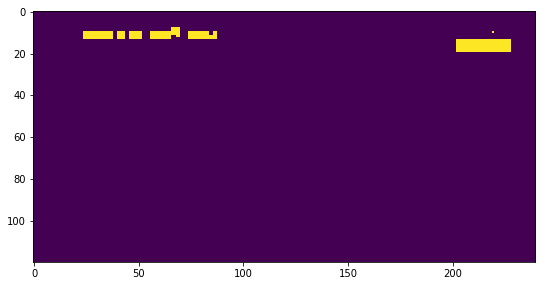

0.5 81 0.25


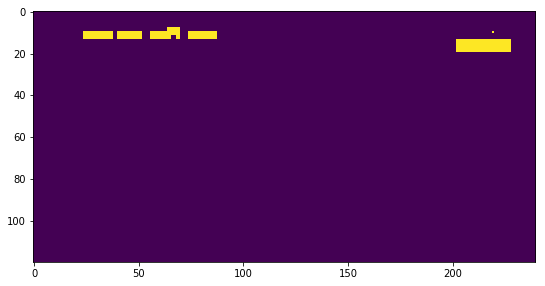

0.5 81 0.3


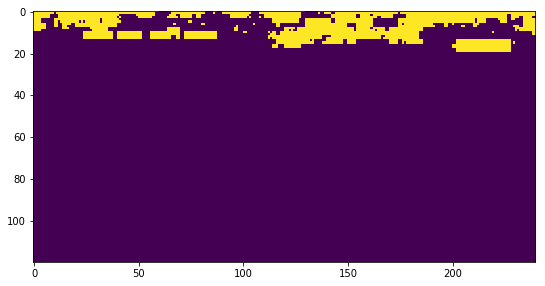

0.5 85 0.15


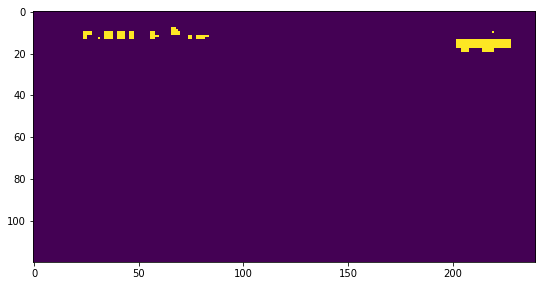

0.5 85 0.18


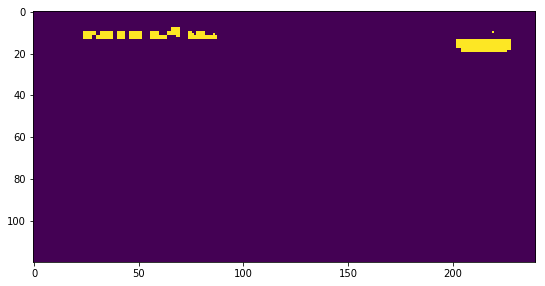

0.5 85 0.2


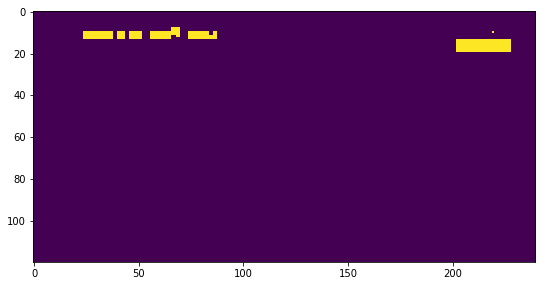

0.5 85 0.25


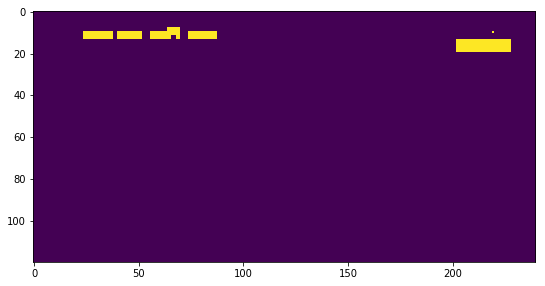

0.5 85 0.3


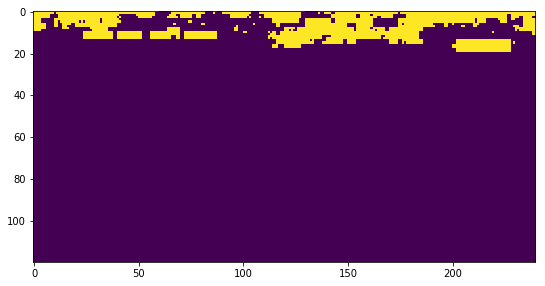

0.5 89 0.15


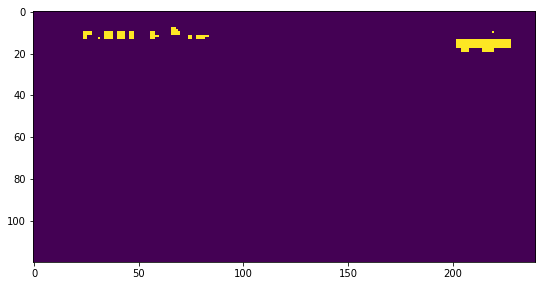

0.5 89 0.18


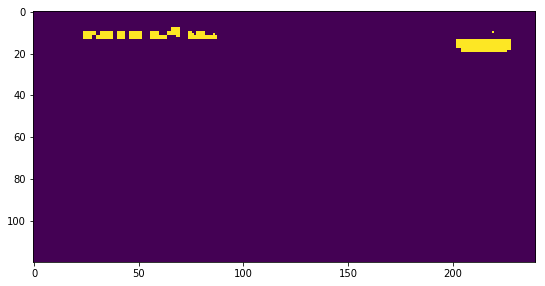

0.5 89 0.2


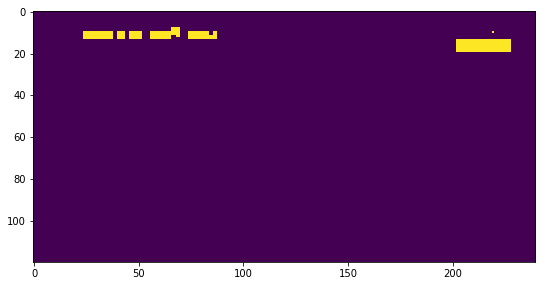

0.5 89 0.25


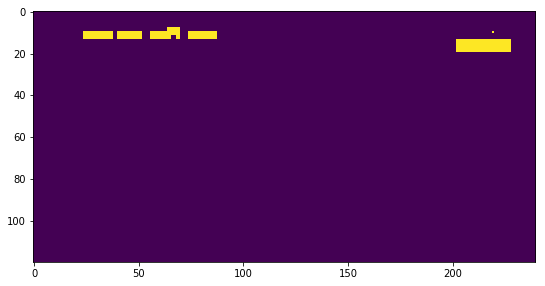

0.5 89 0.3


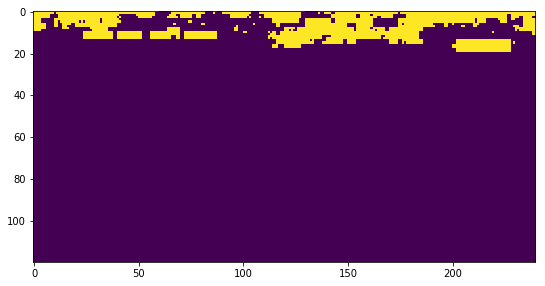

0.5 93 0.15


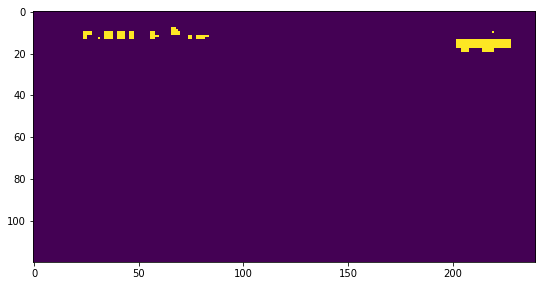

0.5 93 0.18


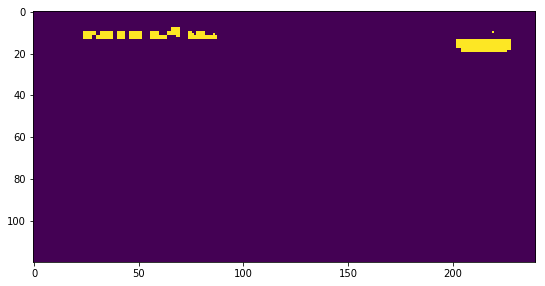

0.5 93 0.2


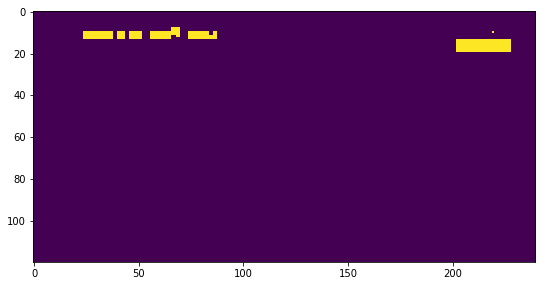

0.5 93 0.25


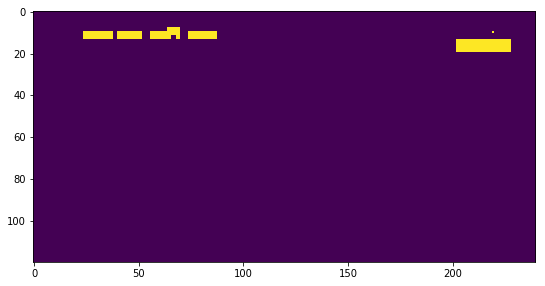

0.5 93 0.3


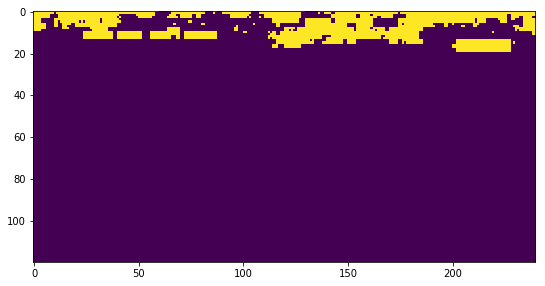

0.5 97 0.15


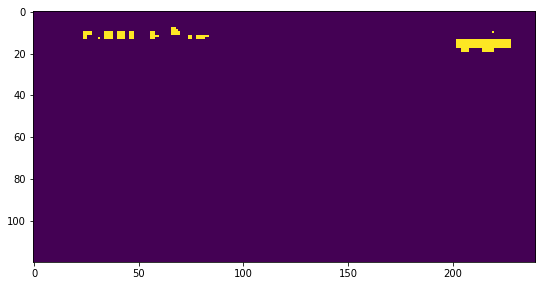

0.5 97 0.18


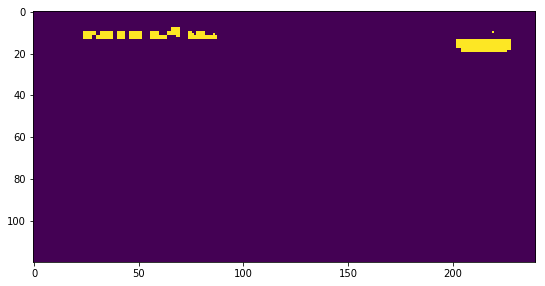

0.5 97 0.2


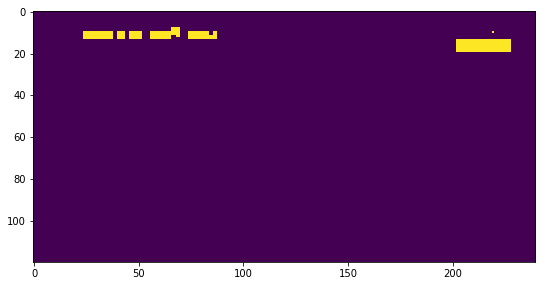

0.5 97 0.25


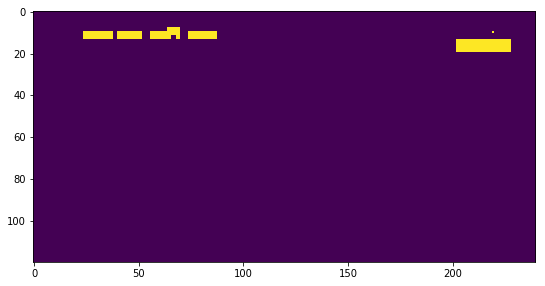

0.5 97 0.3


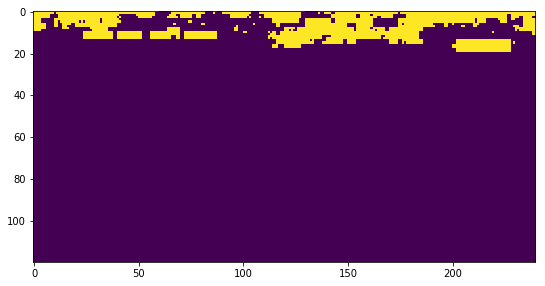

0.5 101 0.15


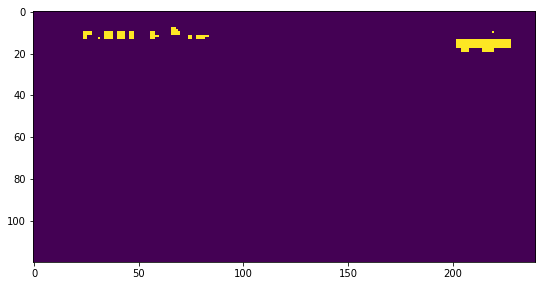

0.5 101 0.18


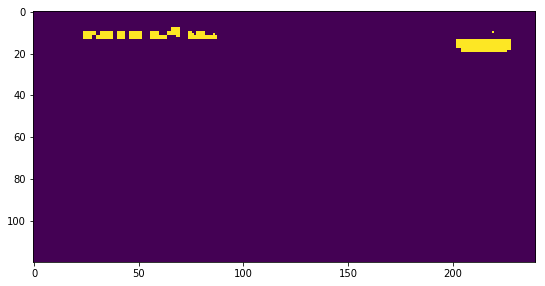

0.5 101 0.2


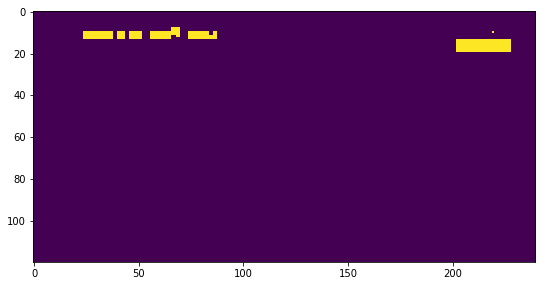

0.5 101 0.25


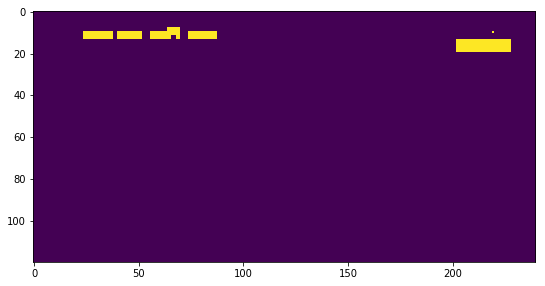

0.5 101 0.3


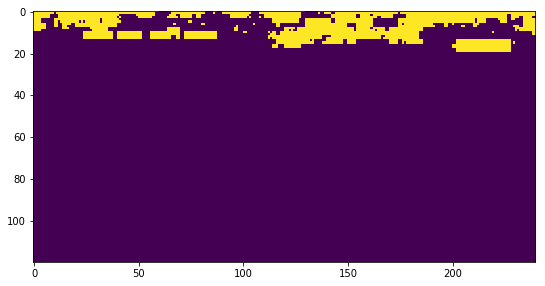

0.5 105 0.15


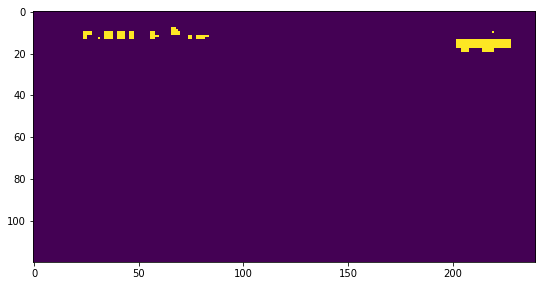

0.5 105 0.18


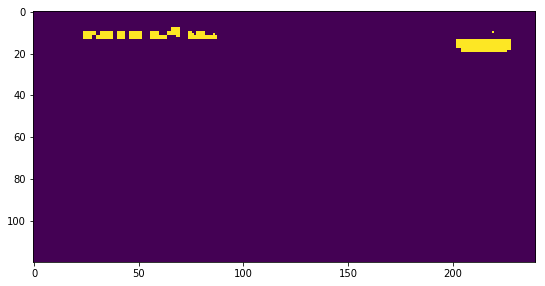

0.5 105 0.2


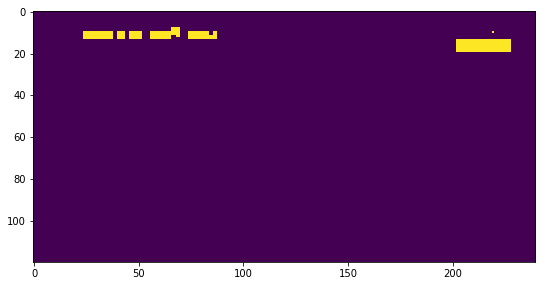

0.5 105 0.25


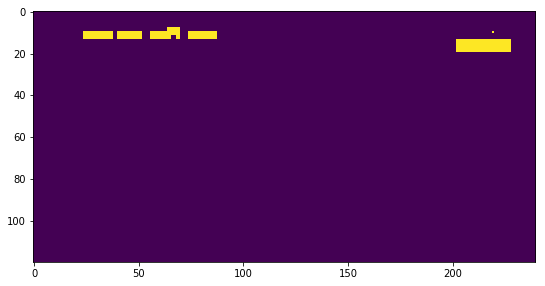

0.5 105 0.3


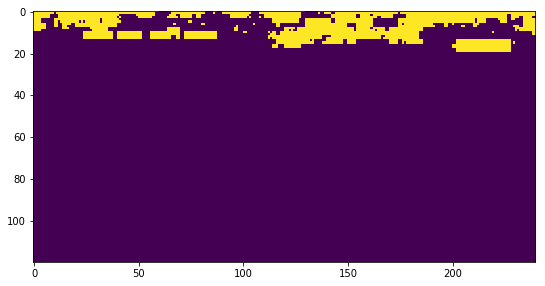

0.5 109 0.15


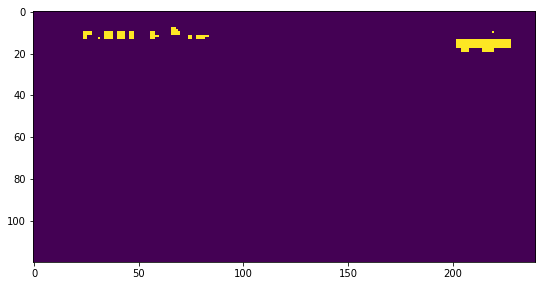

0.5 109 0.18


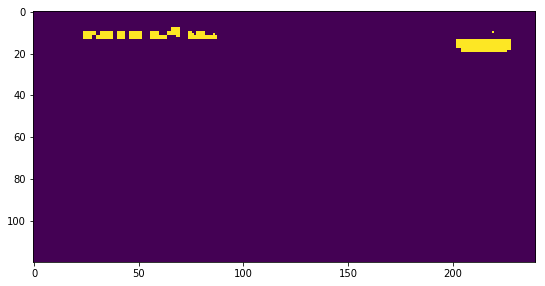

0.5 109 0.2


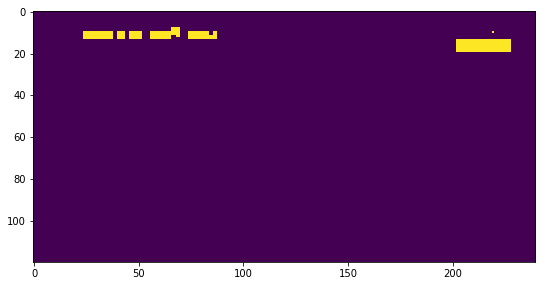

0.5 109 0.25


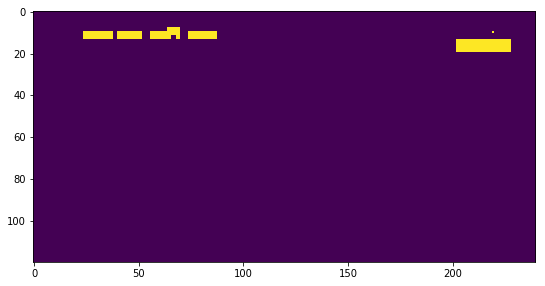

0.5 109 0.3


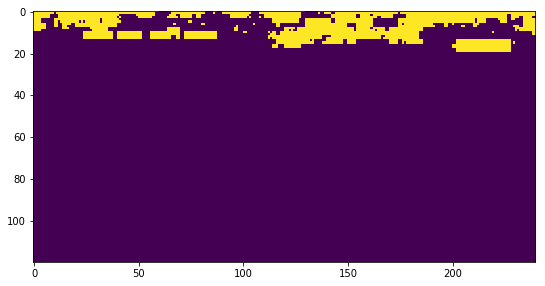

0.5 113 0.15


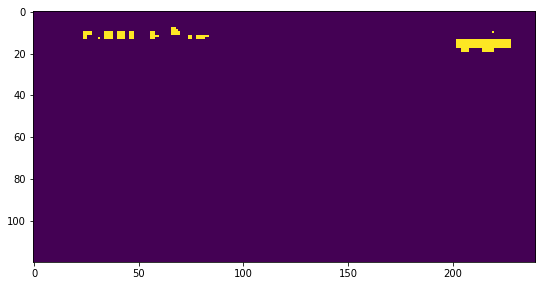

0.5 113 0.18


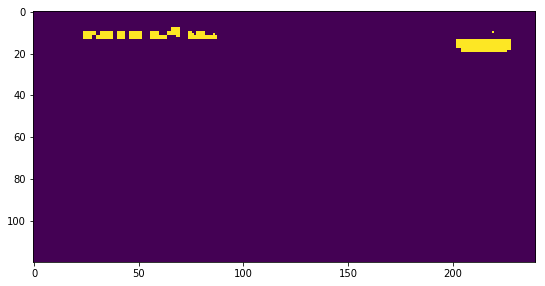

0.5 113 0.2


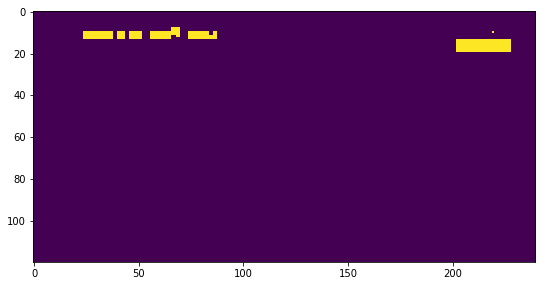

0.5 113 0.25


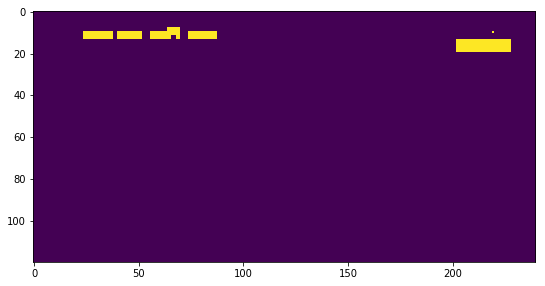

0.5 113 0.3


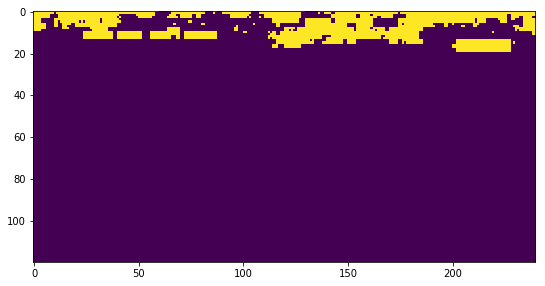

0.5 117 0.15


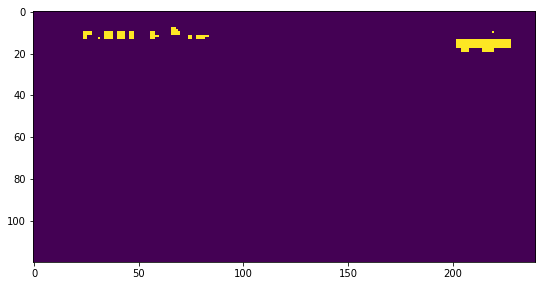

0.5 117 0.18


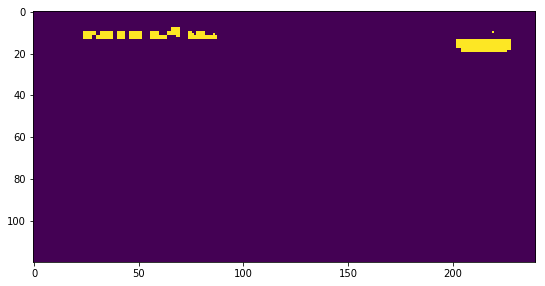

0.5 117 0.2


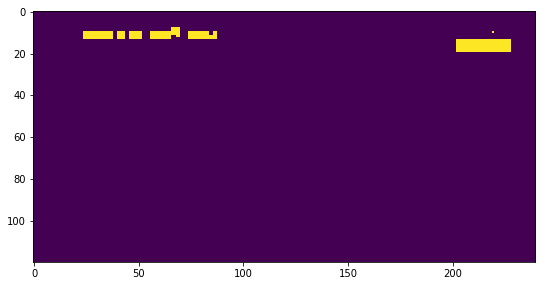

0.5 117 0.25


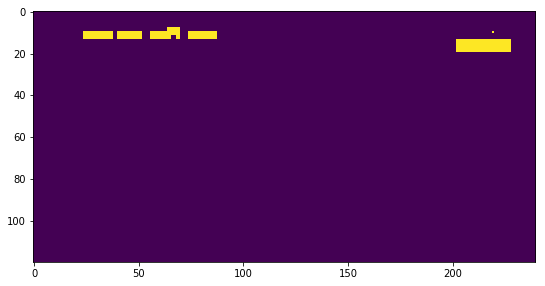

0.5 117 0.3


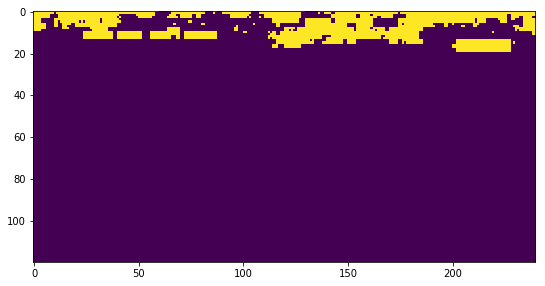

0.5 121 0.15


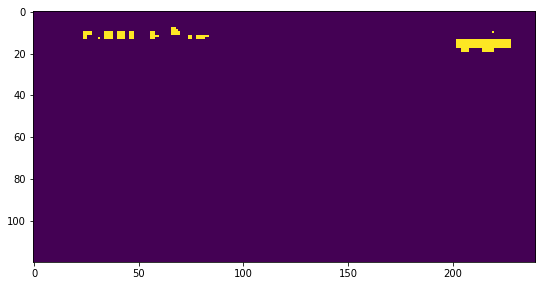

0.5 121 0.18


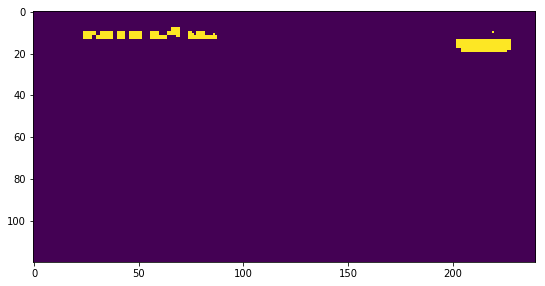

0.5 121 0.2


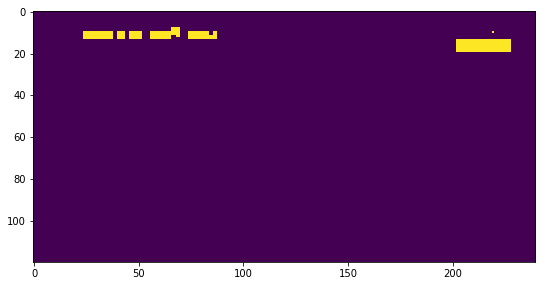

0.5 121 0.25


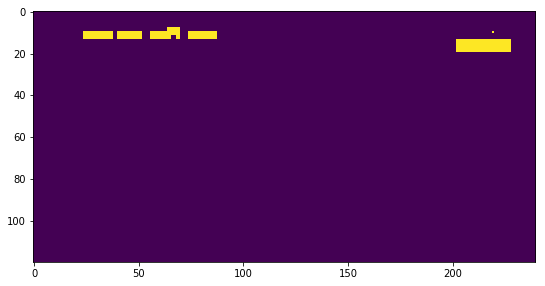

0.5 121 0.3


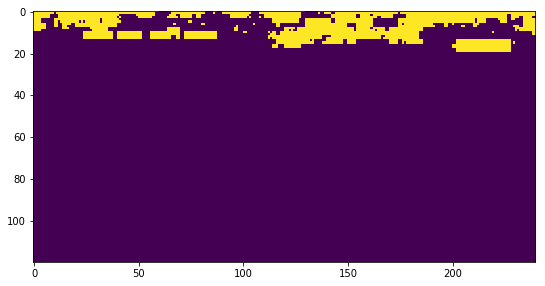

0.5 125 0.15


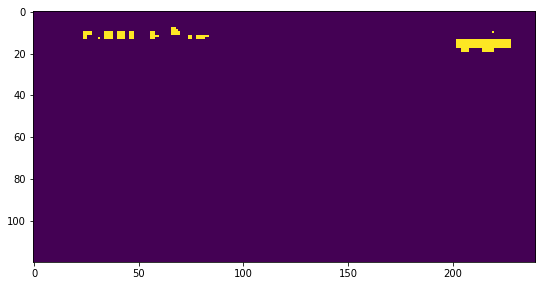

0.5 125 0.18


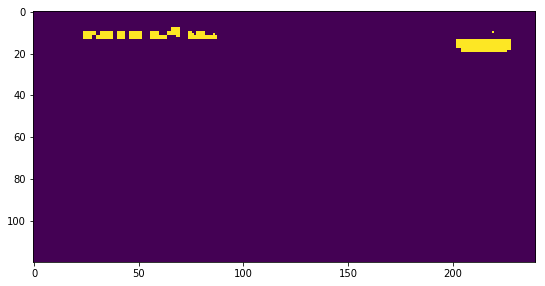

0.5 125 0.2


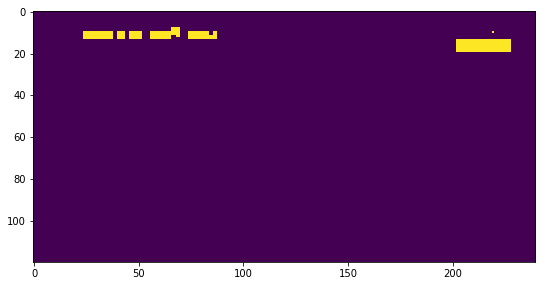

0.5 125 0.25


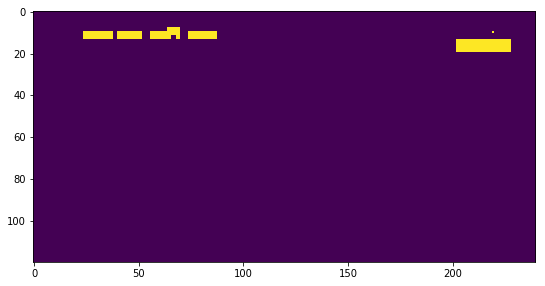

0.5 125 0.3


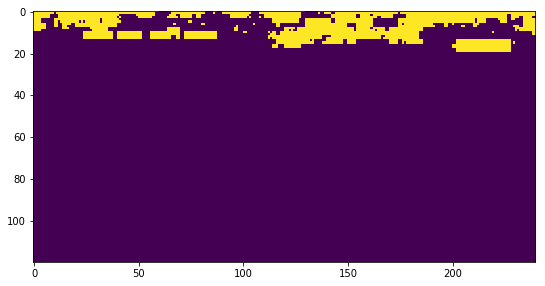

0.5 129 0.15


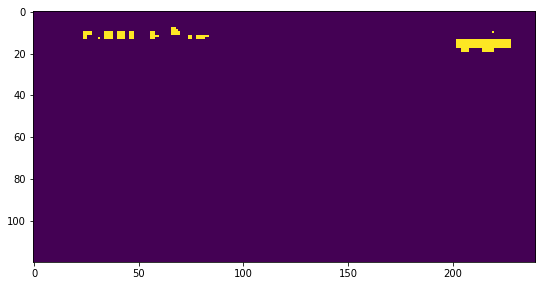

0.5 129 0.18


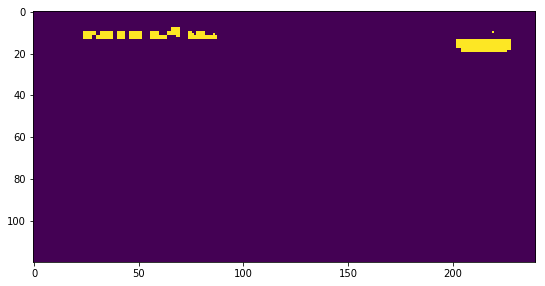

0.5 129 0.2


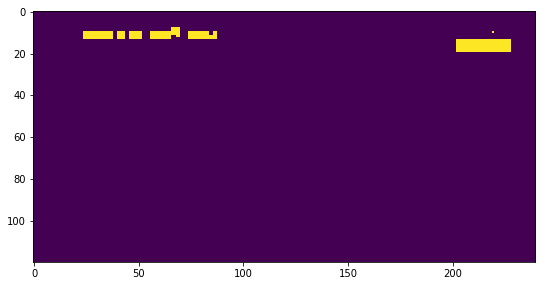

0.5 129 0.25


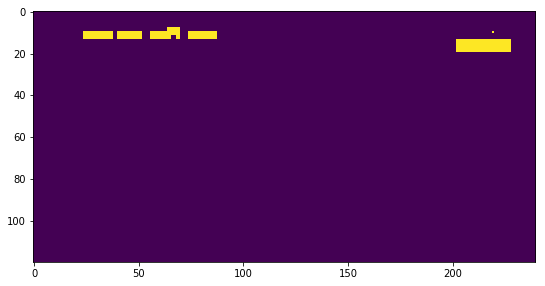

0.5 129 0.3


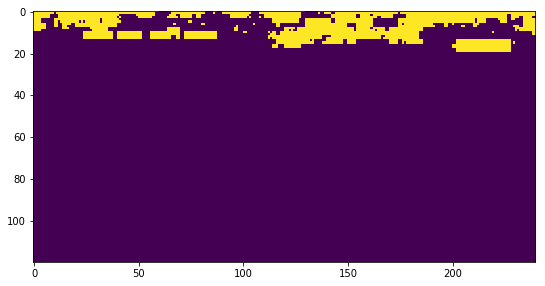

0.5 133 0.15


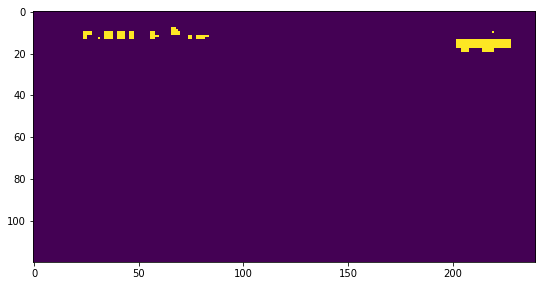

0.5 133 0.18


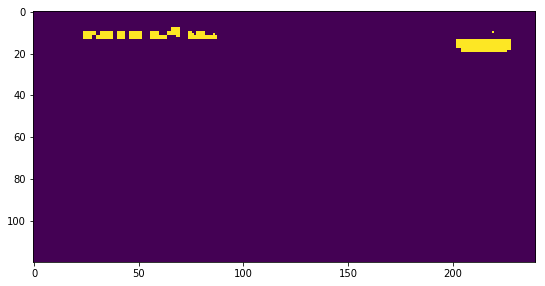

0.5 133 0.2


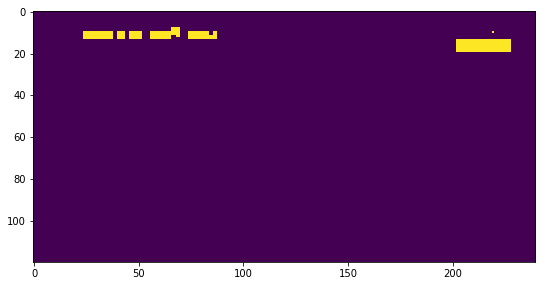

0.5 133 0.25


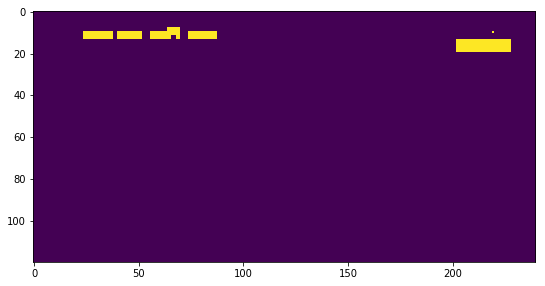

0.5 133 0.3


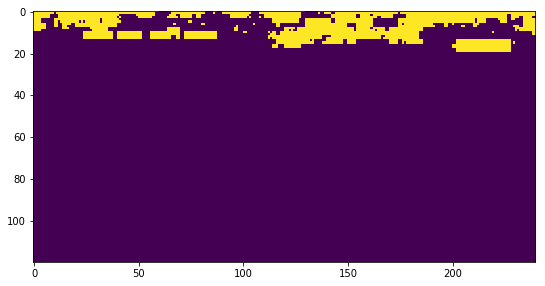

0.5 137 0.15


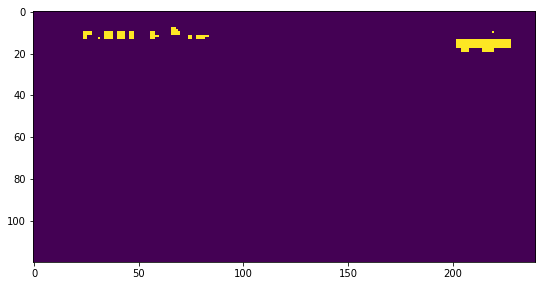

0.5 137 0.18


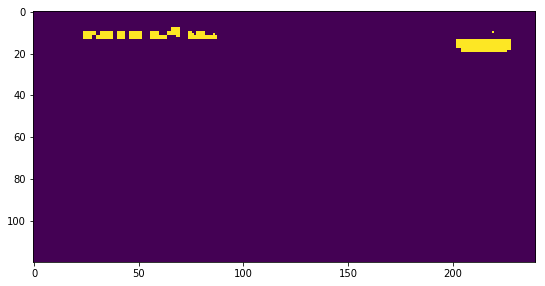

0.5 137 0.2


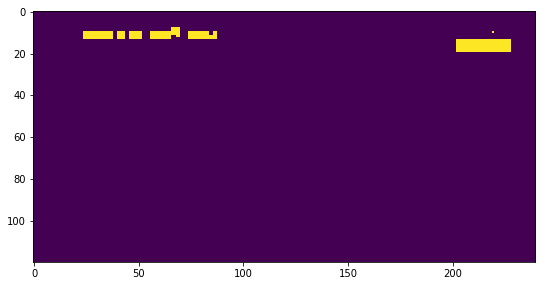

0.5 137 0.25


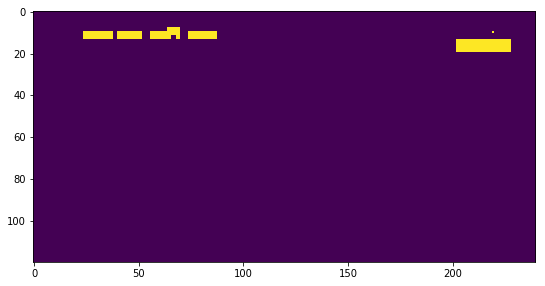

0.5 137 0.3


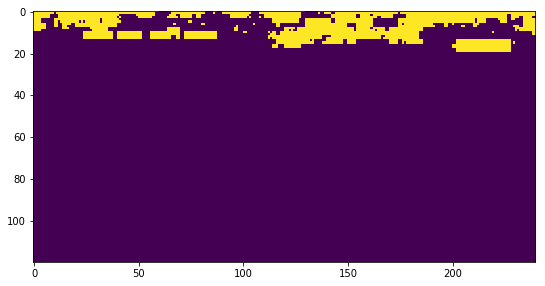

0.5 141 0.15


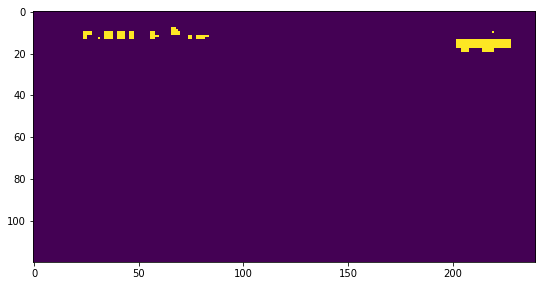

0.5 141 0.18


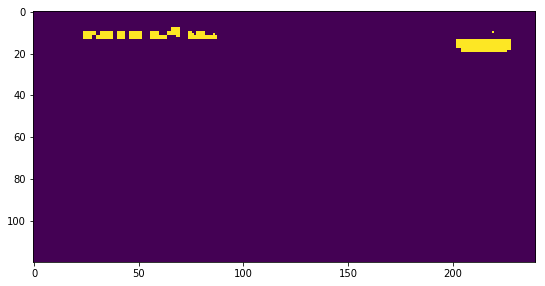

0.5 141 0.2


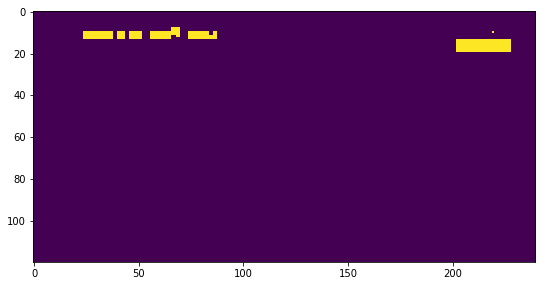

0.5 141 0.25


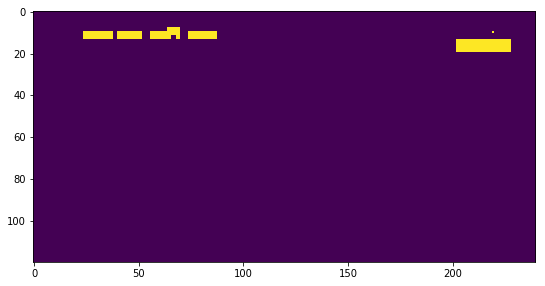

0.5 141 0.3


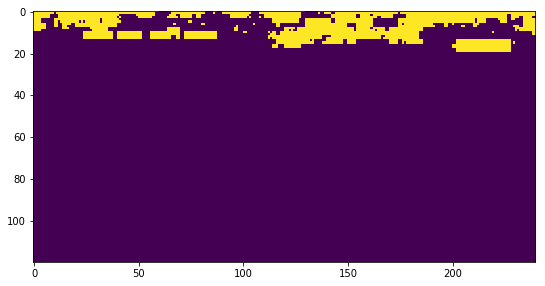

0.5 145 0.15


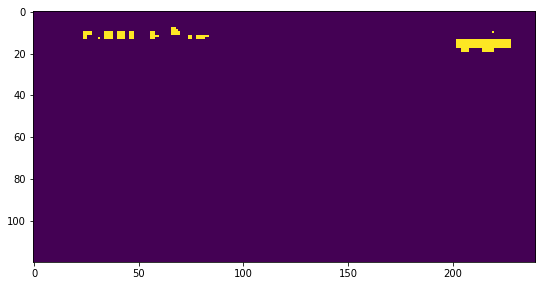

0.5 145 0.18


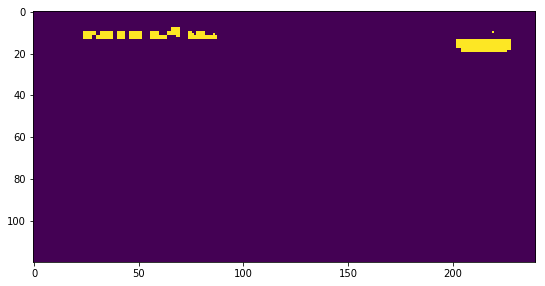

0.5 145 0.2


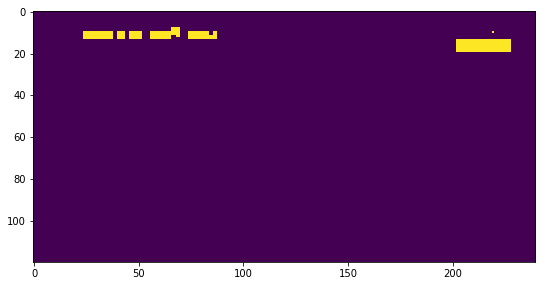

0.5 145 0.25


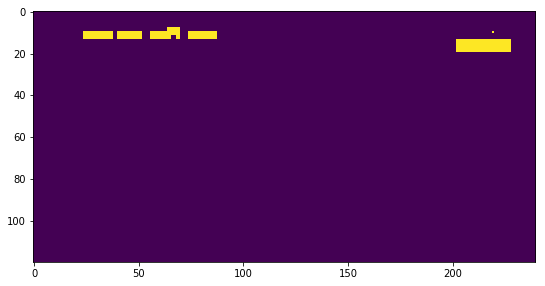

0.5 145 0.3


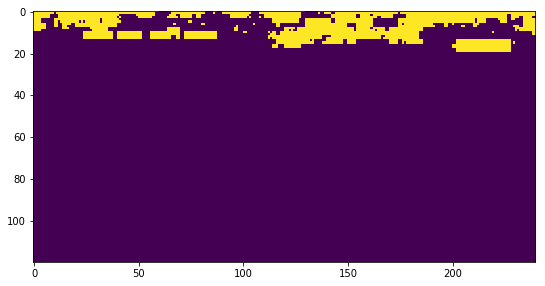

0.5 149 0.15


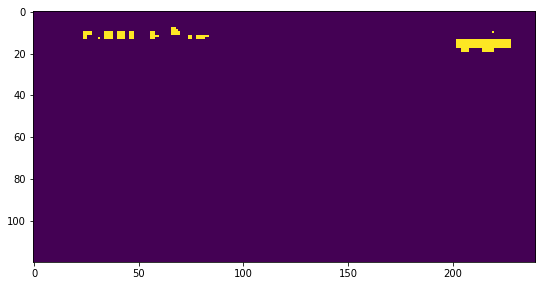

0.5 149 0.18


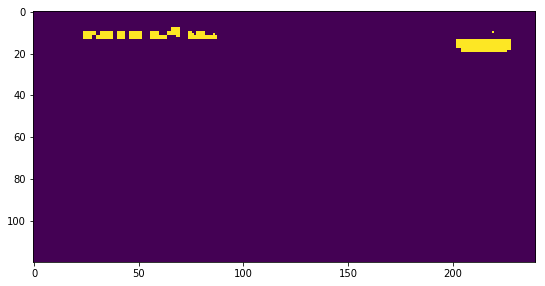

0.5 149 0.2


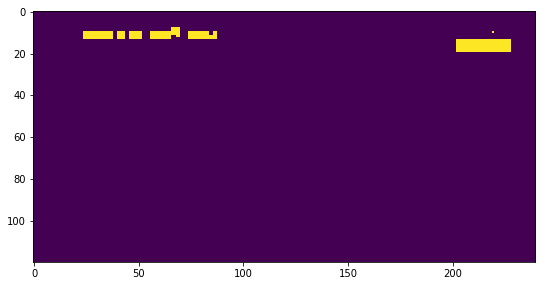

0.5 149 0.25


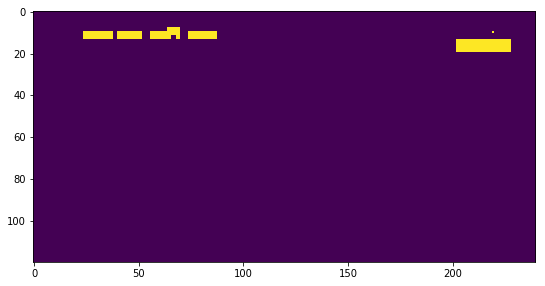

0.5 149 0.3


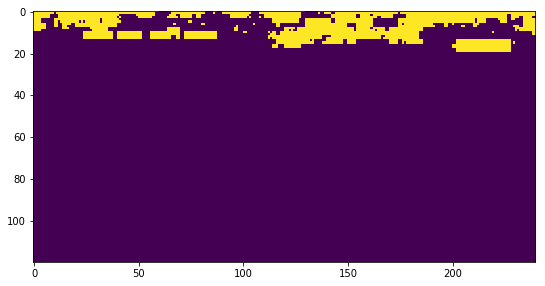

0.5 153 0.15


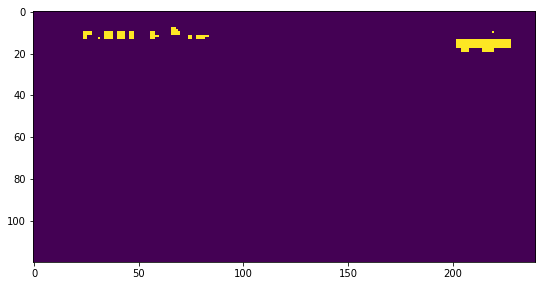

0.5 153 0.18


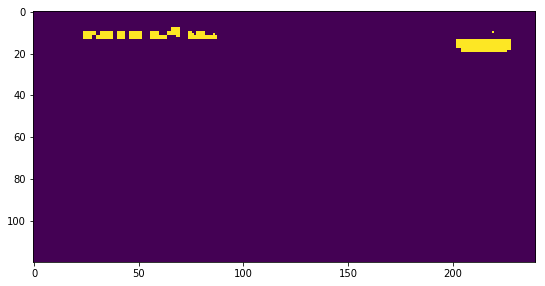

0.5 153 0.2


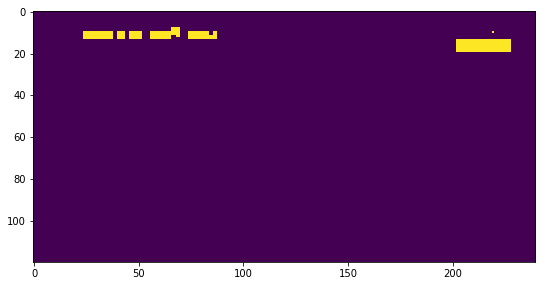

0.5 153 0.25


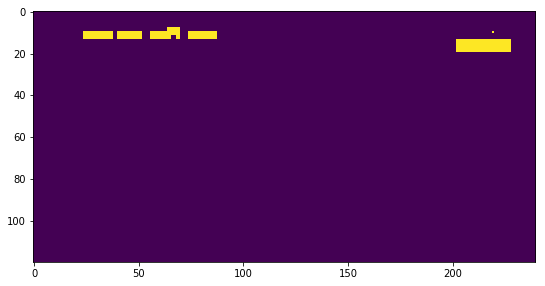

0.5 153 0.3


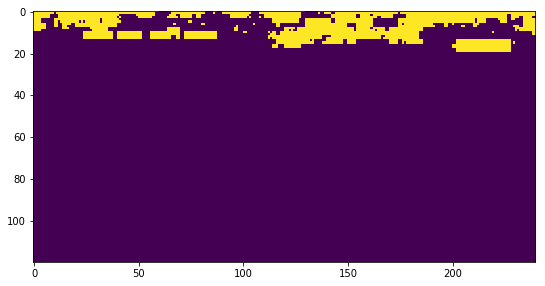

0.5 157 0.15


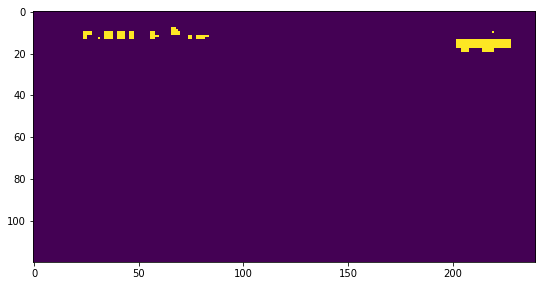

0.5 157 0.18


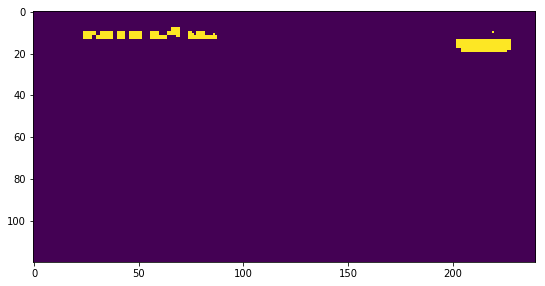

0.5 157 0.2


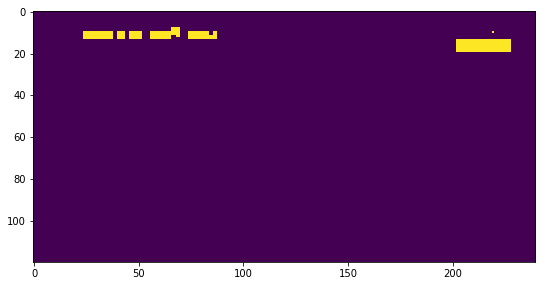

0.5 157 0.25


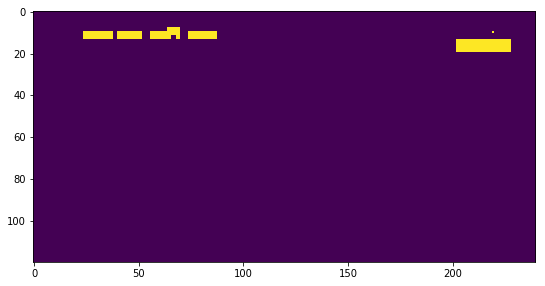

0.5 157 0.3


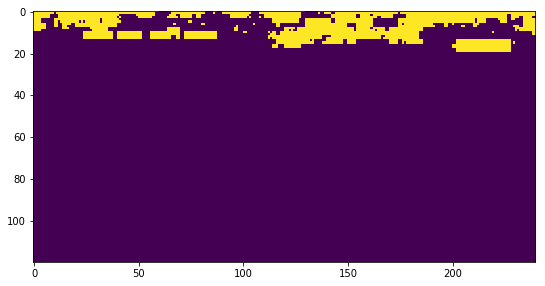

0.5 161 0.15


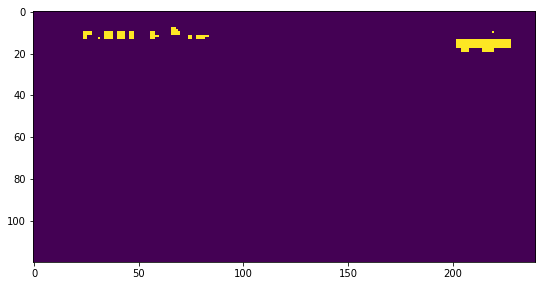

0.5 161 0.18


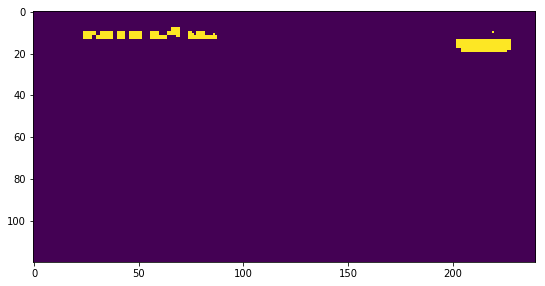

0.5 161 0.2


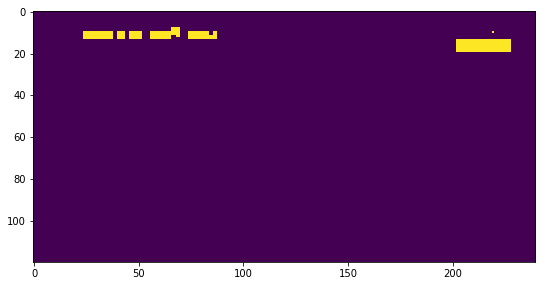

0.5 161 0.25


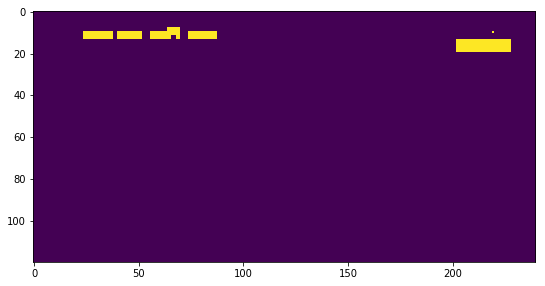

0.5 161 0.3


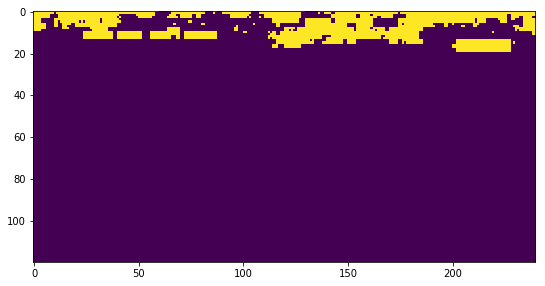

0.5 165 0.15


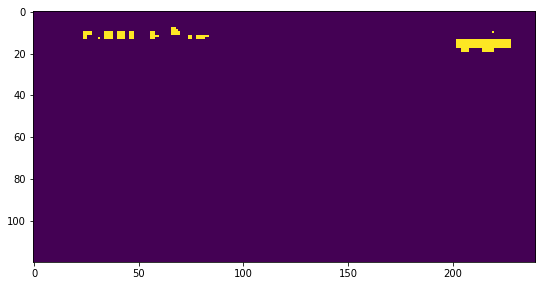

0.5 165 0.18


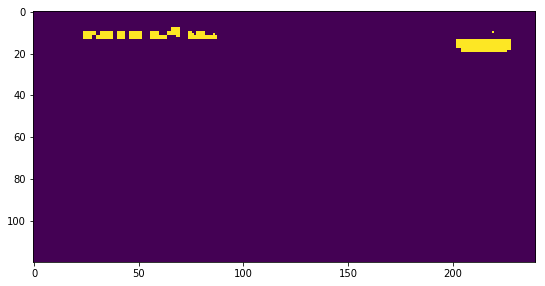

0.5 165 0.2


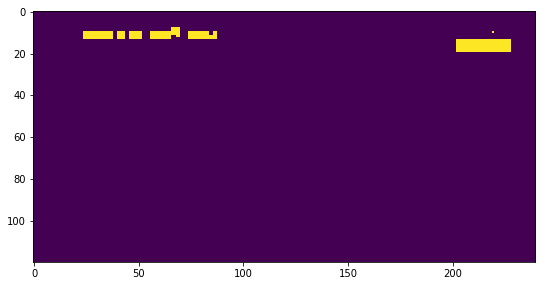

0.5 165 0.25


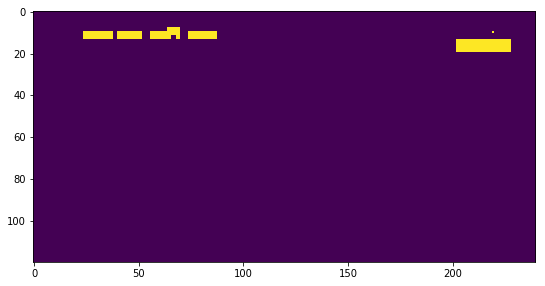

0.5 165 0.3


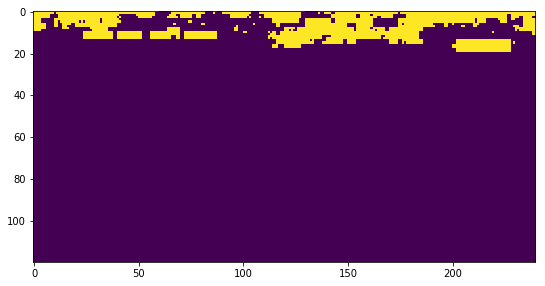

0.5 169 0.15


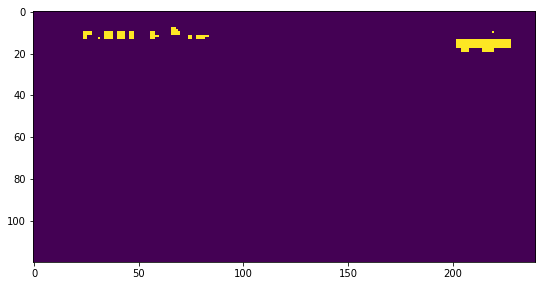

0.5 169 0.18


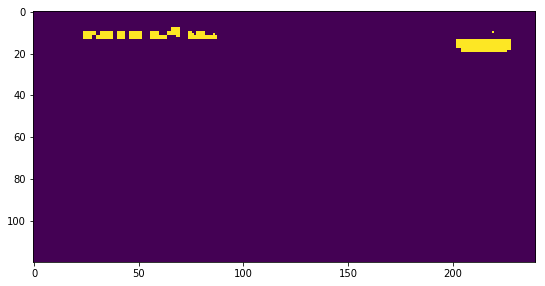

0.5 169 0.2


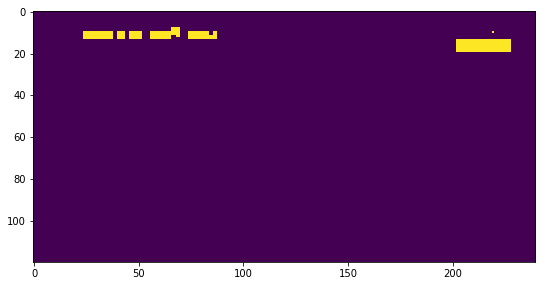

0.5 169 0.25


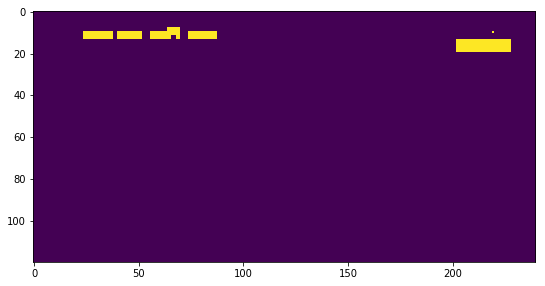

0.5 169 0.3


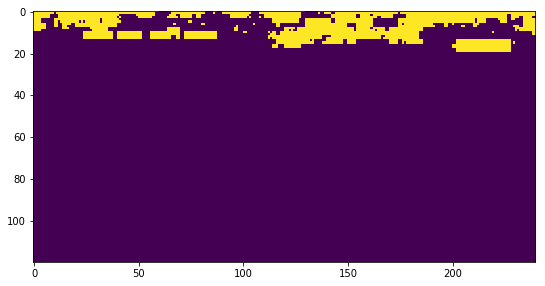

0.5 173 0.15


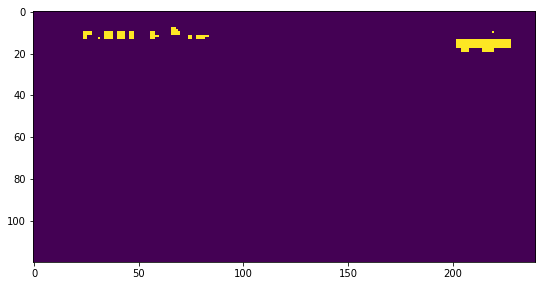

0.5 173 0.18


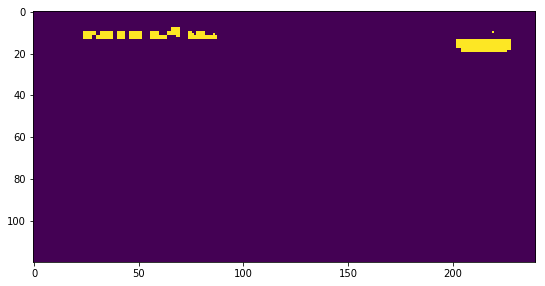

0.5 173 0.2


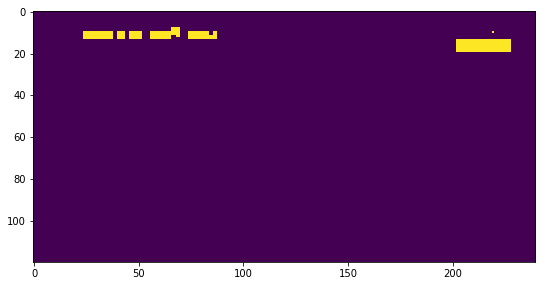

0.5 173 0.25


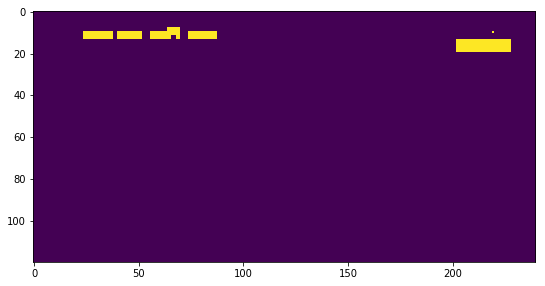

0.5 173 0.3


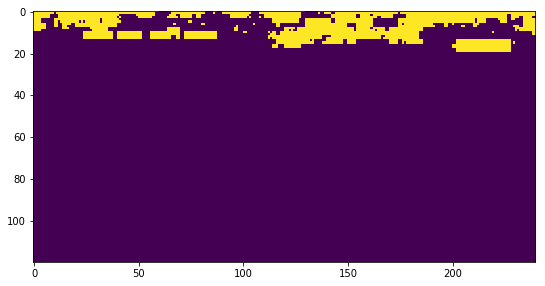

0.5 177 0.15


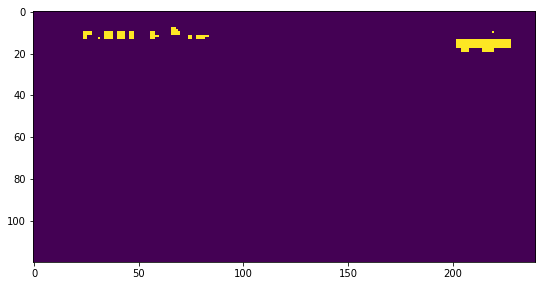

0.5 177 0.18


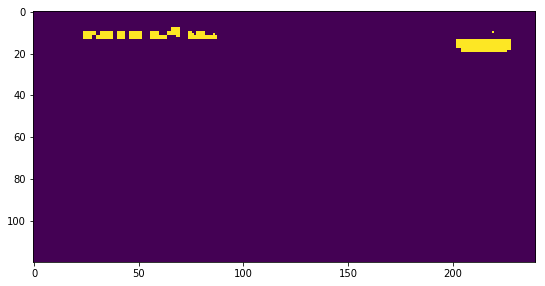

0.5 177 0.2


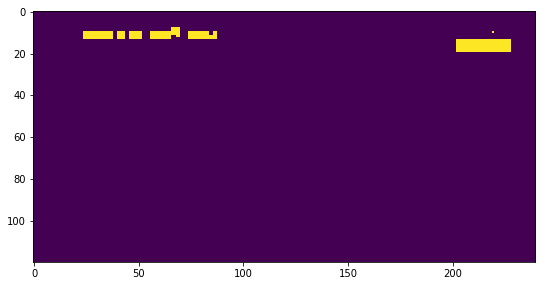

0.5 177 0.25


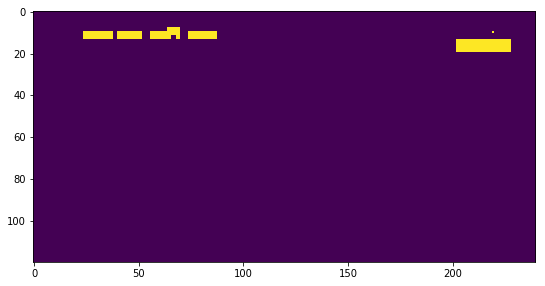

0.5 177 0.3


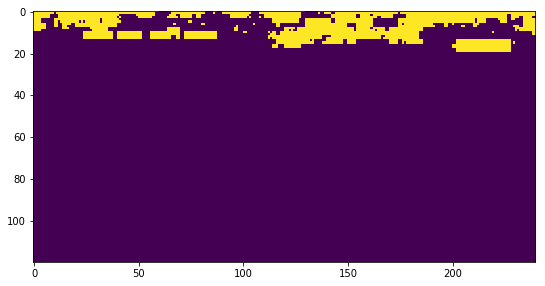

0.5 181 0.15


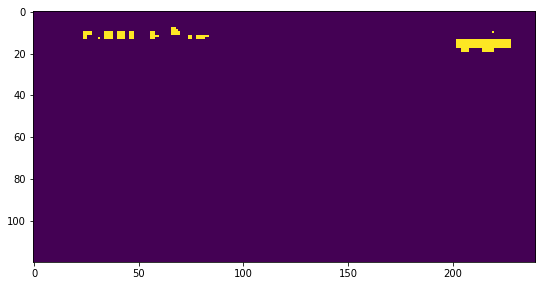

0.5 181 0.18


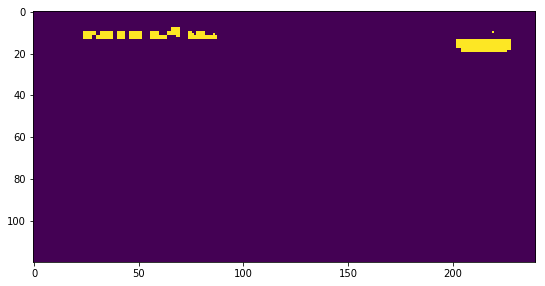

0.5 181 0.2


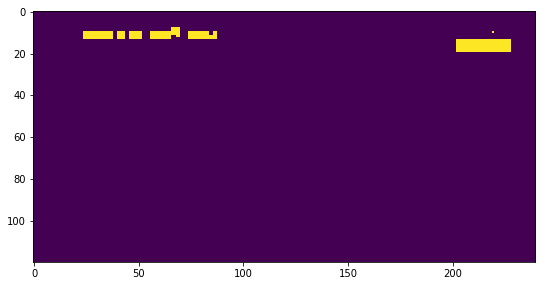

0.5 181 0.25


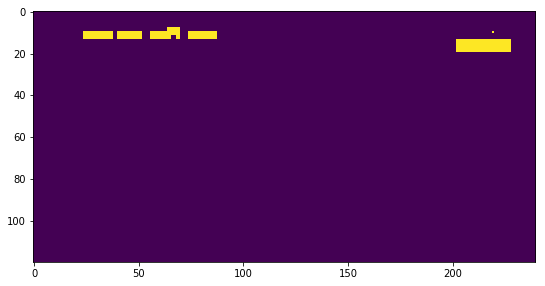

0.5 181 0.3


KeyboardInterrupt: 

In [380]:
for th in [0.3, 0.5, 0.7, 0.9]:
    for tp in range(1, 400, 4):
        for gw in [0.15, 0.18, 0.2, 0.25, 0.3]:
            print(th, tp, gw)
            ui_mask = get_static_mask_exclude_green(colors, green_win, max_green=gw, threshold=th, top_color=tp)
            m = ui_mask.mean()
            show_img(ui_mask, k=0.5)
            plt.show()
            if m > 0.3:
                break;

In [422]:
def get_nonstatic_mask(pixels_colors, threshold=0.85, top_color=5, best_color=1):
    frames_count = pixels_colors[0, 0, 0].sum()
    mask = np.zeros(pixels_colors.shape[:2])
    for i in range(colors.shape[0]):
        for j in range(colors.shape[1]):
            for k in GOOD_COLORS:
                color = pixels_colors[i, j, k] / frames_count
                ind = np.argsort(-color)[best_color:top_color]
                diff = ind.max() - ind.min()
                max_sum = color[ind].sum()
                if max_sum > threshold:
                    mask[i, j] += 1
    return mask == 3

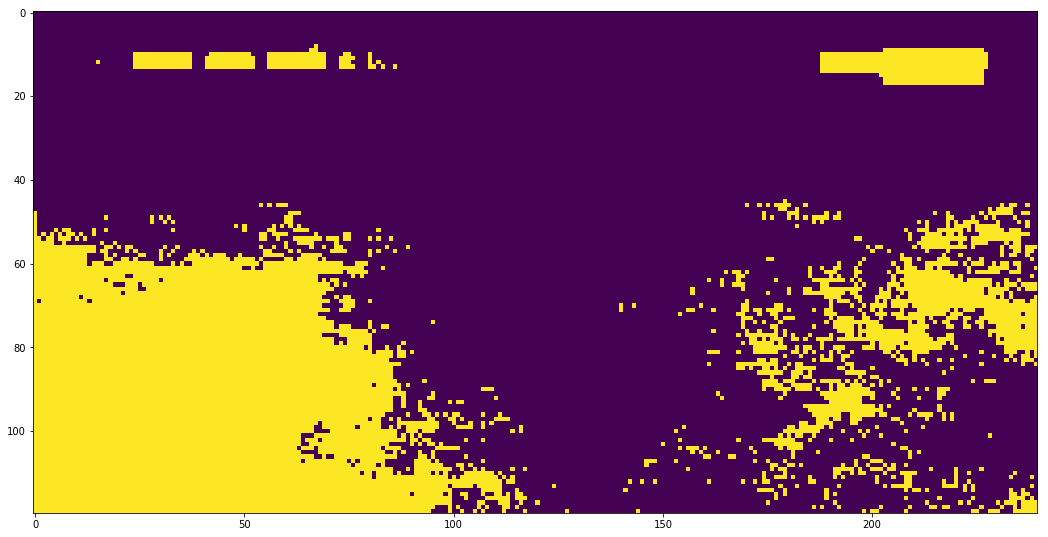

In [435]:
show_img(get_static_mask(colors, threshold=0.45, top_color=20))

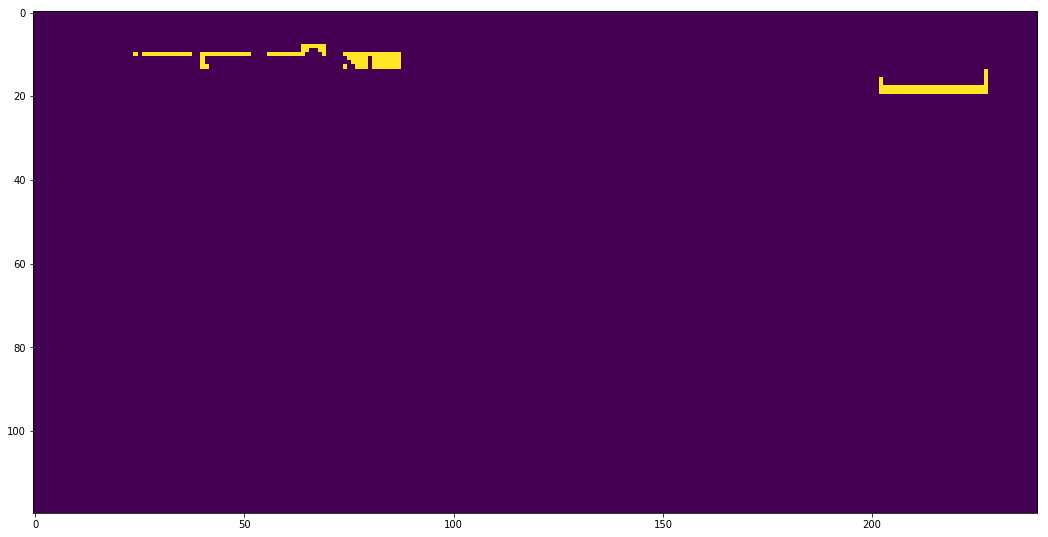

In [441]:
time_img = get_static_mask_exclude_green(colors, green_win, max_green=0.25, threshold=0, top_color=1) - \
           get_static_mask(colors, threshold=0.6, top_color=25)
time_img[time_img < 0] = 0
show_img(time_img)

In [ ]:
Подход 4 (ищем рамки)